## Libraries Import



In [1]:
import cv2, os, json, re
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches
from collections import defaultdict
from PIL import Image
import numpy as np
import seaborn as sns
import statistics
import shapely
import shapely.wkt
%matplotlib inline
import pandas as pd
!pip install wktplot
#from wktplot.wkt_plot import WKTPlot
from wktplot import WKTPlot
from google.colab.patches import cv2_imshow
from scipy.ndimage.interpolation import rotate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import applications, layers, regularizers, optimizers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import Activation, BatchNormalization, concatenate, subtract, Lambda
!pip install livelossplot
from livelossplot import PlotLossesKeras
import logging
import random

2022-05-17 15:49:30,753 - DEBUG - tensorflow : 32 - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2022-05-17 15:49:30,909 - DEBUG - h5py._conv : 47 - Creating converter from 7 to 5
2022-05-17 15:49:30,911 - DEBUG - h5py._conv : 47 - Creating converter from 5 to 7
2022-05-17 15:49:30,911 - DEBUG - h5py._conv : 47 - Creating converter from 7 to 5
2022-05-17 15:49:30,912 - DEBUG - h5py._conv : 47 - Creating converter from 5 to 7


## Drive Import

In [2]:
#Drive Folder 

from google.colab import drive
drive.mount('/content/drive')

'''THESIS PROJECT DIRECTORY'''
path = '/content/drive/My Drive/Thesis Project'
!ln -s /content/drive/My\ Drive/Thesis\ Project /mydrive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/mydrive/Thesis Project': File exists


## Paths

In [3]:
#Full dataset 

complete_path_1 = path + '/Data/train_complete'
complete_path_2 = path + '/Data/test_complete'
complete_path_3 = path + '/Data/tier3'

complete_path_1_images = complete_path_1 + '/images/'
complete_path_2_images = complete_path_2 + '/images/'
complete_path_3_images = complete_path_3 + '/images/'

complete_path_1_labels = complete_path_1 + '/labels/'
complete_path_2_labels = complete_path_2 + '/labels/'
complete_path_3_labels = complete_path_3 + '/labels/'

In [4]:
data_path = path + '/Data'

#Palu dataset
palu_path = data_path + '/palu'
plots_path = palu_path + '/plots'

#FULL Dataset
full_palu_images = palu_path + '/full_dataset/images/'
full_palu_labels = palu_path + '/full_dataset/labels/'

full_palu_images_subtract = palu_path + '/full_dataset/images_subtract/'
full_palu_labels_subtract = palu_path + '/full_dataset/labels_subtract/'

full_palu_buildings_images = palu_path + '/full_buildings/images/'
full_palu_buildings_labels = palu_path + '/full_buildings/labels/'

full_palu_buildings_images_subtract = palu_path + '/full_buildings/images_subtract/'
full_palu_buildings_labels_subtract = palu_path + '/full_buildings/labels_subtract/'

full_palu_buildings_images_complete = palu_path + '/full_buildings/images_complete/'
full_palu_buildings_labels_complete = palu_path + '/full_buildings/labels_complete/'

#HOLD Dataset
hold_palu_images = palu_path + '/hold/images/'
hold_palu_labels = palu_path + '/hold/labels/'
hold_palu_buildings_images = palu_path + '/hold_buildings/images/'
hold_palu_buildings_labels = palu_path + '/hold_buildings/labels/'

#TRAIN Dataset
train_palu_images = palu_path + '/train/images/'
train_palu_buildings_images = palu_path + '/train_buildings/images/'
train_palu_labels = palu_path + '/train/labels/'
train_palu_buildings_labels = palu_path + '/train_buildings/labels/'

#TEST Dataset
test_palu_images = palu_path + '/test/images/'
test_palu_buildings_images = palu_path + '/test_buildings/images/'
test_palu_labels = palu_path + '/test/labels/'
test_palu_buildings_labels = palu_path + '/test_buildings/labels/'

## Utility

In [5]:
#Show image with matplotlib
def imgshow(img, title=None, size=None):
  if type(img) == str:
    img = cv2.imread(img)
  plt.figure(figsize=size)
  if title is not None: plt.title(title)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

#def unison_shuffled_copies(a, b, c, d):
#    assert len(a) == len(b) == len(c) == len(d)
#    p = np.random.permutation(len(a))
#    return a[p], b[p], c[p], d[p]

def unison_shuffled_copies(a, b, c, d, e):
    assert len(a) == len(b) == len(c) == len(d) == len(e)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p], e[p]

#Show JSON label
def labelshow(path):
  with open(path, "r") as json_file:
    data = json.load(json_file)
    # Print the type of data variable
    print("Type:", type(data))

    return data

def print_info_building(data, id):
  if len(data['features']['lng_lat']) > id:
    print("\n-----------------------------------------------")
    print("Building ID: ", id)

    print("Properties: \n", )
    print("1. Feature type: ", data['features']['lng_lat'][id]['properties']['feature_type'])
    print("2. Subtype: ", data['features']['lng_lat'][id]['properties']['subtype'])
    print("3. uid: ", data['features']['lng_lat'][id]['properties']['uid'])

    print("\nWKT Geographic Coordinates: ", data['features']['lng_lat'][id]['wkt'])
    print("\nWKT Pixel Coordinates: ", data['features']['xy'][id]['wkt'])
    print("-----------------------------------------------\n")
  else: 
    print("NO BUILDING at this ID")

def invert_y(shape, resolution):
  #Obtain all numbers from the polygon
  
  #old_res = re.findall(r"[-+]?\d*\.\d+|\d+", shape)
  res = re.findall(r"-?[\d.]+(?:e-?\d+)?", shape)

  #Inversion of y elements
  polygon = f'POLYGON ((' 
  end_str = f'))'
  comma = f', '
  length = len(res)
  #print(res)

  for i in range(length):
    if (i % 2) == 0:
      partial_str = f'{res[i]} {resolution - float(res[i+1])}'
      polygon += partial_str 
      if (length - i) > 2:
        polygon += comma
  polygon += end_str
  
  print(polygon)
  return polygon

def mse(imageA, imageB):

	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

def resize_array_img(array_img):
    array_res = []
    for img in array_img:
      try:
        res = cv2.resize(img, dsize=size, interpolation=cv2.INTER_LINEAR)
        array_res.append(res)
      except:
        res = cv2.resize(img_recovery, dsize=size, interpolation=cv2.INTER_LINEAR)
        array_res.append(res)
        print("Corrupt image")
    
    return array_res

def label_replacement(label_building_encoding):  #4 CLASSES

    label_building_encoding_new = []
    for val in label_building_encoding:
          label_building_encoding_new.append(val)

    label_building_encoding = label_building_encoding_new
    
    return label_building_encoding

## Damage Map Drawing of an Image

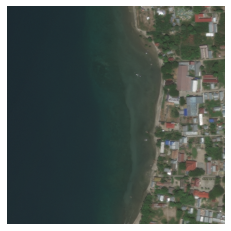

Type: <class 'dict'>

-----------------------------------------------
Building ID:  0
Properties: 

1. Feature type:  building


KeyError: ignored

In [8]:
#Display image and related JSON information
img = cv2.imread(os.path.join(test_palu_images, 'palu-tsunami_00000096_pre_disaster.png'))
imgshow(img)

#Build Python Dictionary starting from JSON file
label = os.path.join(test_palu_labels, 'palu-tsunami_00000096_pre_disaster.json')
data = labelshow(label)

#Print info on a single building
print_info_building(data, 0)

#Draw the polygon corresponding to the building
plot = WKTPlot(title="palu-tsunami_00000096_pre_disaster", save_dir=plots_path)

#Add 4 shapes at the 4 vertices to have a correct image segmentation (find vertices coordinates)

a = "POLYGON ((0.0 0.0, 0.1 0.0, 0.1 0.1, 0.0 0.1, 0.0 0.0))"
plot.add_shape(a, color="blue", line_width=3)
b = "POLYGON ((0.0 1024.0, 0.1 1024.0, 0.1 1023.9, 0.0 1023.9, 0.0 1024.0))"
plot.add_shape(b, color="blue", line_width=3)
c = "POLYGON ((1024.0 1024.0, 1024.0 1023.9, 1023.9 1023.9, 1023.9 1024.0, 1024.0 1024.0))"
plot.add_shape(c, color="blue", line_width=3)
d = "POLYGON ((1024.0 0.0, 1024.0 0.1, 1023.9 0.1, 1023.9 0.0, 1024.0 0.0))"
plot.add_shape(d, color="blue", line_width=3)

building_ids = len(data['features']['xy']) - 1

for id in range(len(data['features']['xy'])):
  
  print(f'ID: {id} on {building_ids} building IDs.')

  shape_old = data['features']['xy'][id]['wkt']
  print(shape_old)
  
  #Invert the coordinates on the 'y' axis
  shape = invert_y(shape_old, 1024.0)
  
  if data['features']['xy'][id]['properties']['subtype'] == 'no-damage':
    plot.add_shape(shape, color="green", line_width=3)
  if data['features']['xy'][id]['properties']['subtype'] == 'destroyed':
    plot.add_shape(shape, color="red", line_width=3)
  if data['features']['xy'][id]['properties']['subtype'] == 'major-damage':
    plot.add_shape(shape, color="yellow", line_width=3)
  if data['features']['xy'][id]['properties']['subtype'] == 'minor-damage':
    plot.add_shape(shape, color="light blue", line_width=3)
  
plot.save()

Building N.  50
[[721.68354406 692.3645791 ]
 [741.41868248 692.16918169]
 [741.41868248 696.07712989]
 [744.15424622 696.07712989]
 [743.56805399 703.69762889]
 [741.02788766 703.69762889]
 [741.02788766 708.58256414]
 [719.92496737 706.62859004]
 [718.16639068 699.59428327]
 [721.68354406 692.3645791 ]]
2022-05-17 15:48:14,679 - DEBUG - matplotlib.font_manager : 1246 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-05-17 15:48:14,680 - DEBUG - matplotlib.font_manager : 1258 - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
2022-05-17 15:48:14,681 - DEBUG - matplotlib.font_manager : 1258 - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
2022-05-17 15:48:14,682 - DEBUG - matplotlib.font_manager : 1258 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2022-05-17 15:48:14,683 - DEBU

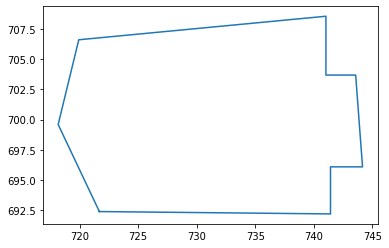

In [7]:
#Visualize shape of the building

def show_building_shape(id):
  if id >= 0 and id < len(data['features']['xy']):
    building_shape = shapely.wkt.loads(data['features']['xy'][id]['wkt'])
    x,y = building_shape.exterior.xy
    print("Building N. ", id)
    plt.plot(x,y)
    return building_shape
  else:
    print("ID not present in the image")

building_shape = show_building_shape(50)

polygon_pts = np.array(list(building_shape.exterior.coords))
print(polygon_pts)

## Damage Map Drawing Superimposed

In [7]:
'''colors = {
    "no-damage": (85, 166, 48, 90),
    "minor-damage": (2, 62, 138, 90),
    "major-damage": (255, 186, 8, 90),
    "destroyed": (230, 57, 70, 90),
    "un-classified": (29, 53, 87, 90)
}'''

colors = {
    "no-damage": 'green',
    "minor-damage": 'blue',
    "major-damage": 'yellow',
    "destroyed": 'red',
    "un-classified": 'black'
}


#json_path = os.path.join(complete_path_2_labels, 'mexico-earthquake_00000139_pre_disaster.json')
#png_path = os.path.join(complete_path_2_images, 'mexico-earthquake_00000139_pre_disaster.png')

json_path = os.path.join(complete_path_2_labels, 'palu-tsunami_00000096_post_disaster.json')
png_path = os.path.join(complete_path_2_images, 'palu-tsunami_00000096_post_disaster.png')

#json_path = os.path.join(complete_path_2_labels, 'hurricane-matthew_00000027_post_disaster.json')
#png_path = os.path.join(complete_path_2_images, 'hurricane-matthew_00000027_post_disaster.png')

with open(json_path) as json_file:
  image_json = json.load(json_file)

coords = image_json['features']['xy']
wkt_polygons = [(coord['properties']['subtype'], coord['wkt']) for coord in coords]
#wkt_polygons = [('no-damage', coord['wkt']) for coord in coords]
polygons = [(damage, shapely.wkt.loads(swkt)) for damage, swkt in wkt_polygons]

from PIL import ImageDraw

image = Image.open(png_path)
draw = ImageDraw.Draw(image, 'RGBA')

for damage, polygon in polygons:
    x,y = polygon.exterior.coords.xy
    draw.polygon(list(zip(x,y)), colors[damage])

image

2022-05-17 15:49:48,696 - DEBUG - PIL.PngImagePlugin : 186 - STREAM b'IHDR' 16 13
2022-05-17 15:49:48,698 - DEBUG - PIL.PngImagePlugin : 186 - STREAM b'tRNS' 41 6
2022-05-17 15:49:48,699 - DEBUG - PIL.PngImagePlugin : 186 - STREAM b'IDAT' 59 8192


KeyError: ignored

## Data Encoding

In [ ]:
#Creation of the data encoding

damage_classes = defaultdict()
damage_classes['no-damage'] = 0
damage_classes['destroyed'] = 1
damage_classes['major-damage'] = 2  
damage_classes['minor-damage'] = 3
damage_classes['un-classified'] = 4
print(damage_classes)

single_disasters = defaultdict()
single_disasters['guatemala-volcano'] = 0
single_disasters['hurricane-florence'] = 1
single_disasters['hurricane-harvey'] = 2
single_disasters['hurricane-michael'] = 3
single_disasters['hurricane-matthew'] = 4
single_disasters['mexico-earthquake'] = 5
single_disasters['midwest-flooding'] = 6
single_disasters['palu-tsunami'] = 7
single_disasters['santa-rosa-wildfire'] = 8
single_disasters['socal-fire'] = 9
single_disasters['joplin-tornado'] = 10
single_disasters['lower-puna-volcano'] = 11
single_disasters['moore-tornado'] = 12
single_disasters['nepal-flooding'] = 13
single_disasters['pinery-bushfire'] = 14
single_disasters['portugal-wildfire'] = 15
single_disasters['sunda-tsunami'] = 16
single_disasters['tuscaloosa-tornado'] = 17
single_disasters['woolsey-fire'] = 18
print(single_disasters)

defaultdict(None, {'no-damage': 0, 'destroyed': 1, 'major-damage': 2, 'minor-damage': 3, 'un-classified': 4})
defaultdict(None, {'guatemala-volcano': 0, 'hurricane-florence': 1, 'hurricane-harvey': 2, 'hurricane-michael': 3, 'hurricane-matthew': 4, 'mexico-earthquake': 5, 'midwest-flooding': 6, 'palu-tsunami': 7, 'santa-rosa-wildfire': 8, 'socal-fire': 9, 'joplin-tornado': 10, 'lower-puna-volcano': 11, 'moore-tornado': 12, 'nepal-flooding': 13, 'pinery-bushfire': 14, 'portugal-wildfire': 15, 'sunda-tsunami': 16, 'tuscaloosa-tornado': 17, 'woolsey-fire': 18})


## Image Segmentation

In [ ]:
def select_post_images(image_paths):
    image_paths_post = []
    image_paths_pre = []
    for name in image_paths:
      if 'post' in name:
        image_paths_post.append(name)
      if 'pre' in name:
        image_paths_pre.append(name)
    
    image_paths_post.sort()
    image_paths_pre.sort()

    return image_paths_post, image_paths_pre

def image_segmentation(image_paths, section):

    x_data = []
    buildings_array = []
    label_building_encoding = []
    disaster_array = []

    #For each image in the train/test folder, we segment it into their buildings and 
    #then we put the resulting images into the train_building/test_building folder

    index = 0
    for img in tqdm(image_paths):

      #if index == 100:
      #  break
      #index += 1

      #DO SMTH WITH SINGLE_DISASTERS
      result = re.search('images/(.*)_0', img)
      curr_disaster = result.group(1) 

      print("\nImg: ", img)
      img_obj = cv2.imread(img)
      img_arr = np.array(img_obj)
      img_height, img_width, _ = img_arr.shape

      label_path = img.replace('images', 'labels').replace('png', 'json')
      print("\nLabel: ", label_path)
      label_data = labelshow(label_path)

      for building in label_data['features']['xy']:
          
          height, width, _ = img_arr.shape

          building_shape = shapely.wkt.loads(building['wkt'])
          polygon_pts = np.array(list(building_shape.exterior.coords))

          xcoords = polygon_pts[:, 0]
          #print("X: ", xcoords)
          ycoords = polygon_pts[:, 1]
          #print("Y: ", ycoords)

          #Find the minimum of the x and maximum of the cooordinates, do a polygon
          #around it and create a .png image containing that single building
          xmin = np.min(xcoords)
          xmax = np.max(xcoords)
          ymin = np.min(ycoords)
          ymax = np.max(ycoords)

          xdiff = xmax - xmin   
          ydiff = ymax - ymin
          max_l = max(xdiff, ydiff)
          
          #The built image is 32*32 at least
          x = 1; img_value = 0
          for i in range(5, 11):
            if x > max_l: 
              img_value = x
              break
            x = pow(2, i) 

          side_xmin = max(int(xmin - ((img_value - xdiff)/2)), 0)
          side_xmax = min(int(xmax + ((img_value - xdiff)/2)), width)
          
          side_ymin = max(int(ymin - ((img_value - ydiff)/2)), 0)
          side_ymax = min(int(ymax + ((img_value - ydiff)/2)), height)

          reduced_img = img_arr[side_ymin:side_ymax, side_xmin:side_xmax, :]

          buildings_array.append(reduced_img)
          disaster_array.append(single_disasters[curr_disaster])
                
          poly_uuid = building['properties']['uid'] + section + '.png'

          #cv2_imshow(poly_img)
          #cv2.imwrite(train_palu_buildings_images + poly_uuid, reduced_img)
          #cv2.imwrite(test_palu_buildings_images + poly_uuid, reduced_img)
          #cv2.imwrite(full_palu_buildings_images_subtract + poly_uuid, reduced_img)

          if len(building['properties']) > 2:
              #Eliminate the Un-specified 
              damage = building['properties']['subtype']          
              label_building_encoding.append(damage_classes[damage])
          
          x_data.append(poly_uuid)

    print("Numero di dati: ", len(x_data))
    print("Numero di label: ", len(label_building_encoding))
    print(disaster_array)

    return x_data, label_building_encoding, buildings_array, disaster_array

## Original Train / Test Sets

In [ ]:
#Train / Test

image_paths = []
image_paths_post = []
image_paths_pre = []

image_paths_train = []
image_paths_test = []

count = 0
for image in os.listdir(complete_path_1_images):
  image_paths_train.append(complete_path_1_images + image)

for image in os.listdir(complete_path_2_images):
  image_paths_test.append(complete_path_2_images + image)

#To use only for the standard dataset to take the POST and PRE images separately
image_paths_post_train, image_paths_pre_train = select_post_images(image_paths_train)
image_paths_post_test, image_paths_pre_test = select_post_images(image_paths_test)

print("N. of post images:", len(image_paths_post_train))
print("N. of pre images:", len(image_paths_pre_train))
print("N. of post images:", len(image_paths_post_test))
print("N. of pre images:", len(image_paths_pre_test))

x_data_post_train, label_building_encoding_post_train, buildings_array_post_train = image_segmentation(image_paths_post_train, 'post')
x_data_pre_train, label_building_encoding_pre_train, buildings_array_pre_train = image_segmentation(image_paths_pre_train, 'pre')

x_data_post_test, label_building_encoding_post_test, buildings_array_post_test = image_segmentation(image_paths_post_test, 'post')
x_data_pre_test, label_building_encoding_pre_test, buildings_array_pre_test = image_segmentation(image_paths_pre_test, 'pre')

N. of post images: 2799
N. of pre images: 2799
N. of post images: 933
N. of pre images: 933


  0%|          | 0/2799 [00:00<?, ?it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000000_post_disaster.json


  0%|          | 1/2799 [00:01<1:29:47,  1.93s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000001_post_disaster.json


  0%|          | 2/2799 [00:03<1:23:54,  1.80s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000002_post_disaster.json


  0%|          | 3/2799 [00:05<1:28:13,  1.89s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000006_post_disaster.json


  0%|          | 4/2799 [00:07<1:21:50,  1.76s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000007_post_disaster.json


  0%|          | 5/2799 [00:09<1:24:49,  1.82s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000008_post_disaster.json


  0%|          | 6/2799 [00:10<1:21:04,  1.74s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000010_post_disaster.json


  0%|          | 7/2799 [00:12<1:16:30,  1.64s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000013_post_disaster.json


  0%|          | 8/2799 [00:13<1:16:44,  1.65s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000015_post_disaster.json


  0%|          | 9/2799 [00:15<1:14:20,  1.60s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000016_post_disaster.json


  0%|          | 10/2799 [00:16<1:14:15,  1.60s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000017_post_disaster.json


  0%|          | 11/2799 [00:18<1:19:18,  1.71s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000018_post_disaster.json


  0%|          | 12/2799 [00:20<1:16:10,  1.64s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000019_post_disaster.json


  0%|          | 13/2799 [00:21<1:14:51,  1.61s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000023_post_disaster.json


  1%|          | 14/2799 [00:23<1:21:34,  1.76s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000024_post_disaster.json


  1%|          | 15/2799 [00:25<1:18:42,  1.70s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000025_post_disaster.json


  1%|          | 16/2799 [00:27<1:17:53,  1.68s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000026_post_disaster.json


  1%|          | 17/2799 [00:29<1:23:39,  1.80s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000027_post_disaster.json


  1%|          | 18/2799 [00:30<1:21:11,  1.75s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000000_post_disaster.json


  1%|          | 19/2799 [00:32<1:24:48,  1.83s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000001_post_disaster.json


  1%|          | 20/2799 [00:34<1:22:34,  1.78s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000002_post_disaster.json


  1%|          | 21/2799 [00:36<1:24:07,  1.82s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000003_post_disaster.json


  1%|          | 22/2799 [00:37<1:19:21,  1.71s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000008_post_disaster.json


  1%|          | 23/2799 [00:40<1:25:44,  1.85s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000012_post_disaster.json


  1%|          | 24/2799 [00:41<1:19:20,  1.72s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000015_post_disaster.json


  1%|          | 25/2799 [00:42<1:15:25,  1.63s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000016_post_disaster.json


  1%|          | 26/2799 [00:44<1:18:54,  1.71s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000018_post_disaster.json


  1%|          | 27/2799 [00:46<1:16:42,  1.66s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000020_post_disaster.json


  1%|          | 28/2799 [00:47<1:14:07,  1.61s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000022_post_disaster.json


  1%|          | 29/2799 [00:49<1:15:14,  1.63s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000023_post_disaster.json


  1%|          | 30/2799 [00:51<1:15:34,  1.64s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000024_post_disaster.json


  1%|          | 31/2799 [00:52<1:13:49,  1.60s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000026_post_disaster.json


  1%|          | 32/2799 [00:54<1:12:05,  1.56s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000027_post_disaster.json


  1%|          | 33/2799 [00:55<1:10:56,  1.54s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000028_post_disaster.json


  1%|          | 34/2799 [00:57<1:08:28,  1.49s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000030_post_disaster.json


  1%|▏         | 35/2799 [00:59<1:15:19,  1.64s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000031_post_disaster.json


  1%|▏         | 36/2799 [01:00<1:16:11,  1.65s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000032_post_disaster.json


  1%|▏         | 37/2799 [01:02<1:20:42,  1.75s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000036_post_disaster.json


  1%|▏         | 38/2799 [01:04<1:18:11,  1.70s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000037_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000037_post_disaster.json


  1%|▏         | 39/2799 [01:06<1:21:28,  1.77s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000042_post_disaster.json


  1%|▏         | 40/2799 [01:07<1:17:09,  1.68s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000043_post_disaster.json


  1%|▏         | 41/2799 [01:09<1:21:46,  1.78s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000044_post_disaster.json


  2%|▏         | 42/2799 [01:11<1:17:10,  1.68s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000045_post_disaster.json


  2%|▏         | 43/2799 [01:12<1:18:04,  1.70s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000048_post_disaster.json


  2%|▏         | 44/2799 [01:14<1:17:05,  1.68s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000049_post_disaster.json


  2%|▏         | 45/2799 [01:17<1:29:51,  1.96s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000051_post_disaster.json


  2%|▏         | 46/2799 [01:18<1:25:48,  1.87s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000053_post_disaster.json


  2%|▏         | 47/2799 [01:20<1:26:39,  1.89s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000054_post_disaster.json


  2%|▏         | 48/2799 [01:22<1:22:15,  1.79s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000055_post_disaster.json


  2%|▏         | 49/2799 [01:23<1:18:37,  1.72s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000057_post_disaster.json


  2%|▏         | 50/2799 [01:25<1:21:17,  1.77s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000058_post_disaster.json


  2%|▏         | 51/2799 [01:27<1:16:21,  1.67s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000059_post_disaster.json


  2%|▏         | 52/2799 [01:28<1:13:22,  1.60s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000060_post_disaster.json


  2%|▏         | 53/2799 [01:30<1:11:49,  1.57s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000061_post_disaster.json


  2%|▏         | 54/2799 [01:31<1:09:46,  1.52s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000062_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000062_post_disaster.json


  2%|▏         | 55/2799 [01:33<1:16:20,  1.67s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000063_post_disaster.json


  2%|▏         | 56/2799 [03:39<29:42:15, 38.98s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000064_post_disaster.json


  2%|▏         | 57/2799 [04:59<38:56:52, 51.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000065_post_disaster.json


  2%|▏         | 58/2799 [04:59<27:22:20, 35.95s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000066_post_disaster.json


  2%|▏         | 59/2799 [05:00<19:17:08, 25.34s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000067_post_disaster.json


  2%|▏         | 60/2799 [05:00<13:37:22, 17.91s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000069_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000069_post_disaster.json


  2%|▏         | 61/2799 [05:01<9:39:22, 12.70s/it] 

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000070_post_disaster.json


  2%|▏         | 62/2799 [05:01<6:52:23,  9.04s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000072_post_disaster.json


  2%|▏         | 63/2799 [05:02<4:56:09,  6.49s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000073_post_disaster.json


  2%|▏         | 64/2799 [05:02<3:34:14,  4.70s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000075_post_disaster.json


  2%|▏         | 65/2799 [05:03<2:37:24,  3.45s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000078_post_disaster.json


  2%|▏         | 66/2799 [05:04<1:58:24,  2.60s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000079_post_disaster.json


  2%|▏         | 67/2799 [05:04<1:30:31,  1.99s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000080_post_disaster.json


  2%|▏         | 68/2799 [05:05<1:10:33,  1.55s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000083_post_disaster.json


  2%|▏         | 69/2799 [05:05<56:21,  1.24s/it]  

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000084_post_disaster.json


  3%|▎         | 70/2799 [05:06<46:18,  1.02s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000085_post_disaster.json


  3%|▎         | 71/2799 [05:06<39:27,  1.15it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000086_post_disaster.json


  3%|▎         | 72/2799 [05:07<34:25,  1.32it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000088_post_disaster.json


  3%|▎         | 73/2799 [05:07<31:24,  1.45it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000091_post_disaster.json


  3%|▎         | 74/2799 [05:08<29:28,  1.54it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000093_post_disaster.json


  3%|▎         | 75/2799 [05:08<27:14,  1.67it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000094_post_disaster.json


  3%|▎         | 76/2799 [05:09<26:30,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000096_post_disaster.json


  3%|▎         | 77/2799 [05:09<25:55,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000099_post_disaster.json


  3%|▎         | 78/2799 [05:10<25:03,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000100_post_disaster.json


  3%|▎         | 79/2799 [05:10<24:39,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000101_post_disaster.json


  3%|▎         | 80/2799 [05:11<23:59,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000102_post_disaster.json


  3%|▎         | 81/2799 [05:11<21:58,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000103_post_disaster.json


  3%|▎         | 82/2799 [05:12<22:26,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000104_post_disaster.json


  3%|▎         | 83/2799 [05:12<23:06,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000106_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000106_post_disaster.json


  3%|▎         | 84/2799 [05:13<22:58,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000110_post_disaster.json


  3%|▎         | 85/2799 [05:13<23:05,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000111_post_disaster.json


  3%|▎         | 86/2799 [05:14<23:21,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000114_post_disaster.json


  3%|▎         | 87/2799 [05:14<23:04,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000115_post_disaster.json


  3%|▎         | 88/2799 [05:15<23:51,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000118_post_disaster.json


  3%|▎         | 89/2799 [05:15<23:42,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000120_post_disaster.json


  3%|▎         | 90/2799 [05:16<23:03,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000122_post_disaster.json


  3%|▎         | 91/2799 [05:16<23:48,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000123_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000123_post_disaster.json


  3%|▎         | 92/2799 [05:17<23:05,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000126_post_disaster.json


  3%|▎         | 93/2799 [05:17<23:45,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000132_post_disaster.json


  3%|▎         | 94/2799 [05:18<24:11,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000136_post_disaster.json


  3%|▎         | 95/2799 [05:19<23:51,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000138_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000138_post_disaster.json


  3%|▎         | 96/2799 [05:19<23:50,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000139_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000139_post_disaster.json


  3%|▎         | 97/2799 [05:20<23:50,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000140_post_disaster.json


  4%|▎         | 98/2799 [05:20<23:50,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000142_post_disaster.json


  4%|▎         | 99/2799 [05:21<24:08,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000144_post_disaster.json


  4%|▎         | 100/2799 [05:21<22:07,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000146_post_disaster.json


  4%|▎         | 101/2799 [05:21<20:43,  2.17it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000147_post_disaster.json


  4%|▎         | 102/2799 [05:22<21:09,  2.12it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000148_post_disaster.json


  4%|▎         | 103/2799 [05:22<21:29,  2.09it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000149_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000149_post_disaster.json


  4%|▎         | 104/2799 [05:23<21:45,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000151_post_disaster.json


  4%|▍         | 105/2799 [05:24<22:30,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000153_post_disaster.json


  4%|▍         | 106/2799 [05:24<22:52,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000156_post_disaster.json


  4%|▍         | 107/2799 [05:24<21:26,  2.09it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000158_post_disaster.json


  4%|▍         | 108/2799 [05:25<21:51,  2.05it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000159_post_disaster.json


  4%|▍         | 109/2799 [05:26<22:44,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000163_post_disaster.json


  4%|▍         | 110/2799 [05:26<22:45,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000164_post_disaster.json


  4%|▍         | 111/2799 [05:27<22:56,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000165_post_disaster.json


  4%|▍         | 112/2799 [05:27<24:27,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000166_post_disaster.json


  4%|▍         | 113/2799 [05:28<23:57,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000168_post_disaster.json


  4%|▍         | 114/2799 [05:28<23:26,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000174_post_disaster.json


  4%|▍         | 115/2799 [05:29<22:36,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000178_post_disaster.json


  4%|▍         | 116/2799 [05:29<23:05,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000180_post_disaster.json


  4%|▍         | 117/2799 [05:30<22:51,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000181_post_disaster.json


  4%|▍         | 118/2799 [05:30<22:41,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000183_post_disaster.json


  4%|▍         | 119/2799 [05:31<22:46,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000185_post_disaster.json


  4%|▍         | 120/2799 [05:31<23:21,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000188_post_disaster.json


  4%|▍         | 121/2799 [05:32<23:08,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000189_post_disaster.json


  4%|▍         | 122/2799 [05:32<24:26,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000190_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000190_post_disaster.json


  4%|▍         | 123/2799 [05:33<23:52,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000191_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000191_post_disaster.json


  4%|▍         | 124/2799 [05:33<23:41,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000192_post_disaster.json


  4%|▍         | 125/2799 [05:34<23:53,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000193_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000193_post_disaster.json


  5%|▍         | 126/2799 [05:34<23:26,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000194_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000194_post_disaster.json


  5%|▍         | 127/2799 [05:35<25:21,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000195_post_disaster.json


  5%|▍         | 128/2799 [05:36<24:40,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000199_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000199_post_disaster.json


  5%|▍         | 129/2799 [05:36<24:24,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000203_post_disaster.json


  5%|▍         | 130/2799 [05:37<25:17,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000210_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000210_post_disaster.json


  5%|▍         | 131/2799 [05:37<23:00,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000212_post_disaster.json


  5%|▍         | 132/2799 [05:38<23:03,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000216_post_disaster.json


  5%|▍         | 133/2799 [05:38<22:48,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000217_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000217_post_disaster.json


  5%|▍         | 134/2799 [05:39<22:58,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000218_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000218_post_disaster.json


  5%|▍         | 135/2799 [05:39<22:31,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000219_post_disaster.json


  5%|▍         | 136/2799 [05:40<22:15,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000221_post_disaster.json


  5%|▍         | 137/2799 [05:40<22:14,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000222_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000222_post_disaster.json


  5%|▍         | 138/2799 [05:41<22:16,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000224_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000224_post_disaster.json


  5%|▍         | 139/2799 [05:41<22:27,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000226_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000226_post_disaster.json


  5%|▌         | 140/2799 [05:42<23:19,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000229_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000229_post_disaster.json


  5%|▌         | 141/2799 [05:42<23:59,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000231_post_disaster.json


  5%|▌         | 142/2799 [05:43<23:27,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000232_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000232_post_disaster.json


  5%|▌         | 143/2799 [05:43<23:11,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000233_post_disaster.json


  5%|▌         | 144/2799 [05:44<23:27,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000237_post_disaster.json


  5%|▌         | 145/2799 [05:44<23:23,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000242_post_disaster.json


  5%|▌         | 146/2799 [05:45<22:52,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000244_post_disaster.json


  5%|▌         | 147/2799 [05:45<22:34,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000245_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000245_post_disaster.json


  5%|▌         | 148/2799 [05:46<22:09,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000247_post_disaster.json


  5%|▌         | 149/2799 [05:46<22:03,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000251_post_disaster.json


  5%|▌         | 150/2799 [05:47<22:05,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000252_post_disaster.json


  5%|▌         | 151/2799 [05:47<22:19,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000255_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000255_post_disaster.json


  5%|▌         | 152/2799 [05:48<22:25,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000256_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000256_post_disaster.json


  5%|▌         | 153/2799 [05:48<22:27,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000259_post_disaster.json


  6%|▌         | 154/2799 [05:49<23:25,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000260_post_disaster.json


  6%|▌         | 155/2799 [05:50<24:07,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000263_post_disaster.json


  6%|▌         | 156/2799 [05:50<23:43,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000264_post_disaster.json


  6%|▌         | 157/2799 [05:51<23:10,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000266_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000266_post_disaster.json


  6%|▌         | 158/2799 [05:51<23:13,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000269_post_disaster.json


  6%|▌         | 159/2799 [05:52<23:16,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000272_post_disaster.json


  6%|▌         | 160/2799 [05:52<23:14,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000273_post_disaster.json


  6%|▌         | 161/2799 [05:53<22:44,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000274_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000274_post_disaster.json


  6%|▌         | 162/2799 [05:53<22:57,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000275_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000275_post_disaster.json


  6%|▌         | 163/2799 [05:54<22:39,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000277_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000277_post_disaster.json


  6%|▌         | 164/2799 [05:54<23:15,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000278_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000278_post_disaster.json


  6%|▌         | 165/2799 [05:55<23:06,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000279_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000279_post_disaster.json


  6%|▌         | 166/2799 [05:55<22:54,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000282_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000282_post_disaster.json


  6%|▌         | 167/2799 [05:56<23:17,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000284_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000284_post_disaster.json


  6%|▌         | 168/2799 [05:57<24:10,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000285_post_disaster.json


  6%|▌         | 169/2799 [05:57<25:52,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000289_post_disaster.json


  6%|▌         | 170/2799 [05:58<24:14,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000290_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000290_post_disaster.json


  6%|▌         | 171/2799 [05:58<24:14,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000293_post_disaster.json


  6%|▌         | 172/2799 [05:59<23:55,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000296_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000296_post_disaster.json


  6%|▌         | 173/2799 [05:59<23:49,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000297_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000297_post_disaster.json


  6%|▌         | 174/2799 [06:00<23:12,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000298_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000298_post_disaster.json


  6%|▋         | 175/2799 [06:00<22:52,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000300_post_disaster.json


  6%|▋         | 176/2799 [06:01<22:26,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000302_post_disaster.json


  6%|▋         | 177/2799 [06:01<22:41,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000303_post_disaster.json


  6%|▋         | 178/2799 [06:02<22:59,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000304_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000304_post_disaster.json


  6%|▋         | 179/2799 [06:02<22:33,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000306_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000306_post_disaster.json


  6%|▋         | 180/2799 [06:03<23:17,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000308_post_disaster.json


  6%|▋         | 181/2799 [06:03<23:00,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000309_post_disaster.json


  7%|▋         | 182/2799 [06:04<22:44,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000310_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000310_post_disaster.json


  7%|▋         | 183/2799 [06:04<22:11,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000312_post_disaster.json


  7%|▋         | 184/2799 [06:05<22:47,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000313_post_disaster.json


  7%|▋         | 185/2799 [06:05<22:33,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000314_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000314_post_disaster.json


  7%|▋         | 186/2799 [06:06<22:52,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000315_post_disaster.json


  7%|▋         | 187/2799 [06:07<26:38,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000316_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000316_post_disaster.json


  7%|▋         | 188/2799 [06:07<25:19,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000319_post_disaster.json


  7%|▋         | 189/2799 [06:08<24:27,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000320_post_disaster.json


  7%|▋         | 190/2799 [06:08<24:23,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000324_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000324_post_disaster.json


  7%|▋         | 191/2799 [06:09<23:48,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000325_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000325_post_disaster.json


  7%|▋         | 192/2799 [06:09<23:15,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000328_post_disaster.json


  7%|▋         | 193/2799 [06:10<23:27,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000329_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000329_post_disaster.json


  7%|▋         | 194/2799 [06:11<23:41,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000330_post_disaster.json


  7%|▋         | 195/2799 [06:11<23:25,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000331_post_disaster.json


  7%|▋         | 196/2799 [06:12<23:53,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000332_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000332_post_disaster.json


  7%|▋         | 197/2799 [06:12<23:33,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000333_post_disaster.json


  7%|▋         | 198/2799 [06:13<23:06,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000334_post_disaster.json


  7%|▋         | 199/2799 [06:13<22:38,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000335_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000335_post_disaster.json


  7%|▋         | 200/2799 [06:14<22:10,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000336_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000336_post_disaster.json


  7%|▋         | 201/2799 [06:14<22:12,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000337_post_disaster.json


  7%|▋         | 202/2799 [06:15<22:18,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000338_post_disaster.json


  7%|▋         | 203/2799 [06:15<22:40,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000340_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000340_post_disaster.json


  7%|▋         | 204/2799 [06:16<22:10,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000341_post_disaster.json


  7%|▋         | 205/2799 [06:16<21:57,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000344_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000344_post_disaster.json


  7%|▋         | 206/2799 [06:17<21:47,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000345_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000345_post_disaster.json


  7%|▋         | 207/2799 [06:17<21:44,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000346_post_disaster.json


  7%|▋         | 208/2799 [06:18<22:02,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000347_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000347_post_disaster.json


  7%|▋         | 209/2799 [06:18<22:37,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000349_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000349_post_disaster.json


  8%|▊         | 210/2799 [06:19<23:15,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000350_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000350_post_disaster.json


  8%|▊         | 211/2799 [06:19<21:27,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000353_post_disaster.json


  8%|▊         | 212/2799 [06:20<22:01,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000355_post_disaster.json


  8%|▊         | 213/2799 [06:20<21:55,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000356_post_disaster.json


  8%|▊         | 214/2799 [06:21<21:54,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000357_post_disaster.json


  8%|▊         | 215/2799 [06:21<21:43,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000359_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000359_post_disaster.json


  8%|▊         | 216/2799 [06:22<27:03,  1.59it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000360_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000360_post_disaster.json


  8%|▊         | 217/2799 [06:23<26:36,  1.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000361_post_disaster.json


  8%|▊         | 218/2799 [06:23<25:56,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000362_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000362_post_disaster.json


  8%|▊         | 219/2799 [06:24<25:24,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000365_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000365_post_disaster.json


  8%|▊         | 220/2799 [06:24<24:24,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000366_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000366_post_disaster.json


  8%|▊         | 221/2799 [06:25<23:41,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000368_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000368_post_disaster.json


  8%|▊         | 222/2799 [06:26<24:16,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000369_post_disaster.json


  8%|▊         | 223/2799 [06:26<24:09,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000370_post_disaster.json


  8%|▊         | 224/2799 [06:27<23:47,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000371_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000371_post_disaster.json


  8%|▊         | 225/2799 [06:27<24:16,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000372_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000372_post_disaster.json


  8%|▊         | 226/2799 [06:28<23:44,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000374_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000374_post_disaster.json


  8%|▊         | 227/2799 [06:28<23:20,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000376_post_disaster.json


  8%|▊         | 228/2799 [06:29<22:36,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000379_post_disaster.json


  8%|▊         | 229/2799 [06:29<21:58,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000380_post_disaster.json


  8%|▊         | 230/2799 [06:30<22:07,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000381_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000381_post_disaster.json


  8%|▊         | 231/2799 [06:30<21:41,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000382_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000382_post_disaster.json


  8%|▊         | 232/2799 [06:31<21:42,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000387_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000387_post_disaster.json


  8%|▊         | 233/2799 [06:31<22:21,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000388_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000388_post_disaster.json


  8%|▊         | 234/2799 [06:32<22:28,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000389_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000389_post_disaster.json


  8%|▊         | 235/2799 [06:32<23:03,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000390_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000390_post_disaster.json


  8%|▊         | 236/2799 [06:33<22:30,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000392_post_disaster.json


  8%|▊         | 237/2799 [06:34<24:14,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000393_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000393_post_disaster.json


  9%|▊         | 238/2799 [06:34<23:27,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000394_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000394_post_disaster.json


  9%|▊         | 239/2799 [06:35<23:10,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000395_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000395_post_disaster.json


  9%|▊         | 240/2799 [06:35<22:21,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000397_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000397_post_disaster.json


  9%|▊         | 241/2799 [06:36<22:12,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000398_post_disaster.json


  9%|▊         | 242/2799 [06:36<22:13,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000399_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000399_post_disaster.json


  9%|▊         | 243/2799 [06:37<22:07,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000401_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000401_post_disaster.json


  9%|▊         | 244/2799 [06:37<21:33,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000403_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000403_post_disaster.json


  9%|▉         | 245/2799 [06:38<22:03,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000404_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000404_post_disaster.json


  9%|▉         | 246/2799 [06:38<22:08,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000405_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000405_post_disaster.json


  9%|▉         | 247/2799 [06:39<22:22,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000406_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000406_post_disaster.json


  9%|▉         | 248/2799 [06:39<22:54,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000407_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000407_post_disaster.json


  9%|▉         | 249/2799 [06:40<22:26,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000408_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000408_post_disaster.json


  9%|▉         | 250/2799 [06:40<22:36,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000409_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000409_post_disaster.json


  9%|▉         | 251/2799 [06:41<21:37,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000410_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000410_post_disaster.json


  9%|▉         | 252/2799 [06:41<21:34,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000411_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000411_post_disaster.json


  9%|▉         | 253/2799 [06:42<22:09,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000414_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000414_post_disaster.json


  9%|▉         | 254/2799 [06:42<22:06,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000416_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000416_post_disaster.json


  9%|▉         | 255/2799 [06:43<21:40,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000418_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000418_post_disaster.json


  9%|▉         | 256/2799 [06:43<22:01,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000419_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000419_post_disaster.json


  9%|▉         | 257/2799 [06:44<23:43,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000420_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000420_post_disaster.json


  9%|▉         | 258/2799 [06:45<22:17,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000423_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000423_post_disaster.json


  9%|▉         | 259/2799 [06:45<22:21,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000424_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000424_post_disaster.json


  9%|▉         | 260/2799 [06:46<22:06,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000425_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000425_post_disaster.json


  9%|▉         | 261/2799 [06:46<22:22,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000426_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000426_post_disaster.json


  9%|▉         | 262/2799 [06:47<22:11,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000427_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000427_post_disaster.json


  9%|▉         | 263/2799 [06:47<23:23,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000428_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000428_post_disaster.json


  9%|▉         | 264/2799 [06:48<22:12,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000431_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000431_post_disaster.json


  9%|▉         | 265/2799 [06:48<21:57,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000433_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000433_post_disaster.json


 10%|▉         | 266/2799 [06:49<22:15,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000435_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000435_post_disaster.json


 10%|▉         | 267/2799 [06:49<22:08,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000436_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000436_post_disaster.json


 10%|▉         | 268/2799 [06:50<22:05,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000437_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000437_post_disaster.json


 10%|▉         | 269/2799 [06:50<22:16,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000438_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000438_post_disaster.json


 10%|▉         | 270/2799 [06:51<22:08,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000441_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000441_post_disaster.json


 10%|▉         | 271/2799 [06:51<22:07,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000442_post_disaster.json


 10%|▉         | 272/2799 [06:52<21:23,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000443_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000443_post_disaster.json


 10%|▉         | 273/2799 [06:53<22:58,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000444_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000444_post_disaster.json


 10%|▉         | 274/2799 [06:53<22:15,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000445_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000445_post_disaster.json


 10%|▉         | 275/2799 [06:54<22:10,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000446_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000446_post_disaster.json


 10%|▉         | 276/2799 [06:54<21:56,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000449_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000449_post_disaster.json


 10%|▉         | 277/2799 [06:55<22:17,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000450_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000450_post_disaster.json


 10%|▉         | 278/2799 [06:55<22:12,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000451_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000451_post_disaster.json


 10%|▉         | 279/2799 [06:56<21:58,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000452_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000452_post_disaster.json


 10%|█         | 280/2799 [06:56<21:32,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000453_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000453_post_disaster.json


 10%|█         | 281/2799 [06:57<22:30,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000454_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000454_post_disaster.json


 10%|█         | 282/2799 [06:57<22:00,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000455_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000455_post_disaster.json


 10%|█         | 283/2799 [06:58<21:55,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000457_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000457_post_disaster.json


 10%|█         | 284/2799 [06:58<21:48,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000459_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000459_post_disaster.json


 10%|█         | 285/2799 [06:59<21:37,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000460_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000460_post_disaster.json


 10%|█         | 286/2799 [06:59<21:24,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000461_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000461_post_disaster.json


 10%|█         | 287/2799 [07:00<22:02,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000462_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000462_post_disaster.json


 10%|█         | 288/2799 [07:00<21:19,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000464_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000464_post_disaster.json


 10%|█         | 289/2799 [07:01<21:09,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000467_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000467_post_disaster.json


 10%|█         | 290/2799 [07:01<21:23,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000469_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000469_post_disaster.json


 10%|█         | 291/2799 [07:02<21:11,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000470_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000470_post_disaster.json


 10%|█         | 292/2799 [07:02<21:31,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000472_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000472_post_disaster.json


 10%|█         | 293/2799 [07:03<21:33,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000473_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000473_post_disaster.json


 11%|█         | 294/2799 [07:03<21:51,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000474_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000474_post_disaster.json


 11%|█         | 295/2799 [07:04<21:19,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000475_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000475_post_disaster.json


 11%|█         | 296/2799 [07:04<21:39,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000476_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000476_post_disaster.json


 11%|█         | 297/2799 [07:05<21:19,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000477_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000477_post_disaster.json


 11%|█         | 298/2799 [07:05<21:15,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000478_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000478_post_disaster.json


 11%|█         | 299/2799 [07:06<21:49,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000481_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000481_post_disaster.json


 11%|█         | 300/2799 [07:06<21:34,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000482_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000482_post_disaster.json


 11%|█         | 301/2799 [07:07<21:24,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000484_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000484_post_disaster.json


 11%|█         | 302/2799 [07:07<21:15,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000485_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000485_post_disaster.json


 11%|█         | 303/2799 [07:08<21:48,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000486_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000486_post_disaster.json


 11%|█         | 304/2799 [07:08<20:52,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000490_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000490_post_disaster.json


 11%|█         | 305/2799 [07:09<21:18,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000492_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000492_post_disaster.json


 11%|█         | 306/2799 [07:10<21:09,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000493_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000493_post_disaster.json


 11%|█         | 307/2799 [07:10<21:00,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000494_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000494_post_disaster.json


 11%|█         | 308/2799 [07:11<21:36,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000496_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000496_post_disaster.json


 11%|█         | 309/2799 [07:11<21:28,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000497_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000497_post_disaster.json


 11%|█         | 310/2799 [07:12<21:27,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000498_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000498_post_disaster.json


 11%|█         | 311/2799 [07:12<20:59,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000500_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000500_post_disaster.json


 11%|█         | 312/2799 [07:13<20:50,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000501_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000501_post_disaster.json


 11%|█         | 313/2799 [07:13<21:11,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000503_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000503_post_disaster.json


 11%|█         | 314/2799 [07:14<21:23,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000504_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000504_post_disaster.json


 11%|█▏        | 315/2799 [07:14<21:00,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000506_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000506_post_disaster.json


 11%|█▏        | 316/2799 [07:15<20:49,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000508_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000508_post_disaster.json


 11%|█▏        | 317/2799 [07:15<20:51,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000510_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000510_post_disaster.json


 11%|█▏        | 318/2799 [07:16<21:47,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000512_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000512_post_disaster.json


 11%|█▏        | 319/2799 [07:16<21:15,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000513_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000513_post_disaster.json


 11%|█▏        | 320/2799 [07:17<20:59,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000514_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000514_post_disaster.json


 11%|█▏        | 321/2799 [07:17<21:01,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000515_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000515_post_disaster.json


 12%|█▏        | 322/2799 [07:18<21:02,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000516_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000516_post_disaster.json


 12%|█▏        | 323/2799 [07:18<21:04,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000517_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000517_post_disaster.json


 12%|█▏        | 324/2799 [07:19<21:17,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000522_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000522_post_disaster.json


 12%|█▏        | 325/2799 [07:19<21:42,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000523_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000523_post_disaster.json


 12%|█▏        | 326/2799 [07:20<21:18,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000526_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000526_post_disaster.json


 12%|█▏        | 327/2799 [07:20<21:45,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000527_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000527_post_disaster.json


 12%|█▏        | 328/2799 [07:21<22:00,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000529_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000529_post_disaster.json


 12%|█▏        | 329/2799 [07:21<22:28,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000531_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000531_post_disaster.json


 12%|█▏        | 330/2799 [07:22<21:35,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000533_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000533_post_disaster.json


 12%|█▏        | 331/2799 [07:22<21:24,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000536_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000536_post_disaster.json


 12%|█▏        | 332/2799 [07:23<21:36,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000537_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000537_post_disaster.json


 12%|█▏        | 333/2799 [07:23<21:09,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000538_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000538_post_disaster.json


 12%|█▏        | 334/2799 [07:24<21:00,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000540_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000540_post_disaster.json


 12%|█▏        | 335/2799 [07:25<21:05,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000542_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000542_post_disaster.json


 12%|█▏        | 336/2799 [07:25<21:09,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000545_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000545_post_disaster.json


 12%|█▏        | 337/2799 [07:26<21:08,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000000_post_disaster.json


 12%|█▏        | 338/2799 [07:26<21:48,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000001_post_disaster.json


 12%|█▏        | 339/2799 [07:27<21:54,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000002_post_disaster.json


 12%|█▏        | 340/2799 [07:27<21:54,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000006_post_disaster.json


 12%|█▏        | 341/2799 [07:28<22:08,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000007_post_disaster.json


 12%|█▏        | 342/2799 [07:28<21:24,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000008_post_disaster.json


 12%|█▏        | 343/2799 [07:29<21:38,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000009_post_disaster.json


 12%|█▏        | 344/2799 [07:29<21:24,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000010_post_disaster.json


 12%|█▏        | 345/2799 [07:30<21:26,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000012_post_disaster.json


 12%|█▏        | 346/2799 [07:30<21:45,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000015_post_disaster.json


 12%|█▏        | 347/2799 [07:31<21:50,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000016_post_disaster.json


 12%|█▏        | 348/2799 [07:31<21:37,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000017_post_disaster.json


 12%|█▏        | 349/2799 [07:32<21:16,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000019_post_disaster.json


 13%|█▎        | 350/2799 [07:32<20:56,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000020_post_disaster.json


 13%|█▎        | 351/2799 [07:33<20:40,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000022_post_disaster.json


 13%|█▎        | 352/2799 [07:33<20:50,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000024_post_disaster.json


 13%|█▎        | 353/2799 [07:34<20:55,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000025_post_disaster.json


 13%|█▎        | 354/2799 [07:34<21:23,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000026_post_disaster.json


 13%|█▎        | 355/2799 [07:35<21:08,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000028_post_disaster.json


 13%|█▎        | 356/2799 [07:36<21:07,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000029_post_disaster.json


 13%|█▎        | 357/2799 [07:36<21:20,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000030_post_disaster.json


 13%|█▎        | 358/2799 [07:37<22:07,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000035_post_disaster.json


 13%|█▎        | 359/2799 [07:37<21:57,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000039_post_disaster.json


 13%|█▎        | 360/2799 [07:38<22:12,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000040_post_disaster.json


 13%|█▎        | 361/2799 [07:38<21:32,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000041_post_disaster.json


 13%|█▎        | 362/2799 [07:39<21:01,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000042_post_disaster.json


 13%|█▎        | 363/2799 [07:39<20:50,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000043_post_disaster.json


 13%|█▎        | 364/2799 [07:40<20:35,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000045_post_disaster.json


 13%|█▎        | 365/2799 [07:40<22:07,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000046_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000046_post_disaster.json


 13%|█▎        | 366/2799 [07:41<21:45,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000047_post_disaster.json


 13%|█▎        | 367/2799 [07:41<21:02,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000048_post_disaster.json


 13%|█▎        | 368/2799 [07:42<20:49,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000049_post_disaster.json


 13%|█▎        | 369/2799 [07:42<20:41,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000051_post_disaster.json


 13%|█▎        | 370/2799 [07:43<20:28,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000052_post_disaster.json


 13%|█▎        | 371/2799 [07:43<20:43,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000053_post_disaster.json


 13%|█▎        | 372/2799 [07:44<20:45,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000054_post_disaster.json


 13%|█▎        | 373/2799 [07:44<20:57,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000055_post_disaster.json


 13%|█▎        | 374/2799 [07:45<20:35,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000056_post_disaster.json


 13%|█▎        | 375/2799 [07:45<21:07,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000057_post_disaster.json


 13%|█▎        | 376/2799 [07:46<20:45,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000059_post_disaster.json


 13%|█▎        | 377/2799 [07:46<20:38,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000060_post_disaster.json


 14%|█▎        | 378/2799 [07:47<20:28,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000061_post_disaster.json


 14%|█▎        | 379/2799 [07:47<20:33,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000066_post_disaster.json


 14%|█▎        | 380/2799 [07:48<20:59,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000069_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000069_post_disaster.json


 14%|█▎        | 381/2799 [07:49<21:07,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000070_post_disaster.json


 14%|█▎        | 382/2799 [07:49<20:44,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000071_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000071_post_disaster.json


 14%|█▎        | 383/2799 [07:50<20:53,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000072_post_disaster.json


 14%|█▎        | 384/2799 [07:50<20:56,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000073_post_disaster.json


 14%|█▍        | 385/2799 [07:51<21:16,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000075_post_disaster.json


 14%|█▍        | 386/2799 [07:51<22:36,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000076_post_disaster.json


 14%|█▍        | 387/2799 [07:52<22:08,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000077_post_disaster.json


 14%|█▍        | 388/2799 [07:52<21:44,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000079_post_disaster.json


 14%|█▍        | 389/2799 [07:53<22:16,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000080_post_disaster.json


 14%|█▍        | 390/2799 [07:53<21:42,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000081_post_disaster.json


 14%|█▍        | 391/2799 [07:54<21:13,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000082_post_disaster.json


 14%|█▍        | 392/2799 [07:54<20:57,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000084_post_disaster.json


 14%|█▍        | 393/2799 [07:55<20:47,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000085_post_disaster.json


 14%|█▍        | 394/2799 [07:55<20:40,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000088_post_disaster.json


 14%|█▍        | 395/2799 [07:56<20:31,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000089_post_disaster.json


 14%|█▍        | 396/2799 [07:56<20:50,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000090_post_disaster.json


 14%|█▍        | 397/2799 [07:57<20:39,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000091_post_disaster.json


 14%|█▍        | 398/2799 [07:58<24:47,  1.61it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000092_post_disaster.json


 14%|█▍        | 399/2799 [07:58<22:21,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000094_post_disaster.json


 14%|█▍        | 400/2799 [07:59<21:37,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000098_post_disaster.json


 14%|█▍        | 401/2799 [07:59<21:20,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000099_post_disaster.json


 14%|█▍        | 402/2799 [08:00<21:28,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000100_post_disaster.json


 14%|█▍        | 403/2799 [08:00<20:58,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000101_post_disaster.json


 14%|█▍        | 404/2799 [08:01<21:58,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000104_post_disaster.json


 14%|█▍        | 405/2799 [08:01<21:42,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000107_post_disaster.json


 15%|█▍        | 406/2799 [08:02<21:16,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000108_post_disaster.json


 15%|█▍        | 407/2799 [08:02<20:59,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000109_post_disaster.json


 15%|█▍        | 408/2799 [08:03<20:27,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000111_post_disaster.json


 15%|█▍        | 409/2799 [08:03<20:21,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000113_post_disaster.json


 15%|█▍        | 410/2799 [08:04<20:10,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000114_post_disaster.json


 15%|█▍        | 411/2799 [08:04<20:11,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000115_post_disaster.json


 15%|█▍        | 412/2799 [08:05<20:40,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000116_post_disaster.json


 15%|█▍        | 413/2799 [08:06<20:28,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000118_post_disaster.json


 15%|█▍        | 414/2799 [08:06<19:59,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000119_post_disaster.json


 15%|█▍        | 415/2799 [08:07<20:38,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000123_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000123_post_disaster.json


 15%|█▍        | 416/2799 [08:07<20:16,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000126_post_disaster.json


 15%|█▍        | 417/2799 [08:08<20:05,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000128_post_disaster.json


 15%|█▍        | 418/2799 [08:08<19:10,  2.07it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000129_post_disaster.json


 15%|█▍        | 419/2799 [08:09<19:44,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000130_post_disaster.json


 15%|█▌        | 420/2799 [08:09<19:33,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000132_post_disaster.json


 15%|█▌        | 421/2799 [08:10<20:19,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000134_post_disaster.json


 15%|█▌        | 422/2799 [08:10<20:19,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000136_post_disaster.json


 15%|█▌        | 423/2799 [08:11<19:56,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000137_post_disaster.json


 15%|█▌        | 424/2799 [08:11<20:32,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000138_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000138_post_disaster.json


 15%|█▌        | 425/2799 [08:12<19:54,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000141_post_disaster.json


 15%|█▌        | 426/2799 [08:12<20:43,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000142_post_disaster.json


 15%|█▌        | 427/2799 [08:13<21:09,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000144_post_disaster.json


 15%|█▌        | 428/2799 [08:13<20:55,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000145_post_disaster.json


 15%|█▌        | 429/2799 [08:14<21:02,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000146_post_disaster.json


 15%|█▌        | 430/2799 [08:14<20:59,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000147_post_disaster.json


 15%|█▌        | 431/2799 [08:15<20:40,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000151_post_disaster.json


 15%|█▌        | 432/2799 [08:15<19:59,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000152_post_disaster.json


 15%|█▌        | 433/2799 [08:16<20:09,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000153_post_disaster.json


 16%|█▌        | 434/2799 [08:16<20:07,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000154_post_disaster.json


 16%|█▌        | 435/2799 [08:17<19:50,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000156_post_disaster.json


 16%|█▌        | 436/2799 [08:17<19:46,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000157_post_disaster.json


 16%|█▌        | 437/2799 [08:18<19:40,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000158_post_disaster.json


 16%|█▌        | 438/2799 [08:18<19:59,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000159_post_disaster.json


 16%|█▌        | 439/2799 [08:19<20:16,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000160_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000160_post_disaster.json


 16%|█▌        | 440/2799 [08:19<20:20,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000165_post_disaster.json


 16%|█▌        | 441/2799 [08:20<20:17,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000167_post_disaster.json


 16%|█▌        | 442/2799 [08:20<20:03,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000168_post_disaster.json


 16%|█▌        | 443/2799 [08:21<20:38,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000169_post_disaster.json


 16%|█▌        | 444/2799 [08:21<20:16,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000170_post_disaster.json


 16%|█▌        | 445/2799 [08:22<20:08,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000171_post_disaster.json


 16%|█▌        | 446/2799 [08:22<20:26,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000172_post_disaster.json


 16%|█▌        | 447/2799 [08:23<21:01,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000174_post_disaster.json


 16%|█▌        | 448/2799 [08:24<20:50,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000176_post_disaster.json


 16%|█▌        | 449/2799 [08:24<20:34,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000177_post_disaster.json


 16%|█▌        | 450/2799 [08:25<20:00,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000178_post_disaster.json


 16%|█▌        | 451/2799 [08:25<20:08,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000180_post_disaster.json


 16%|█▌        | 452/2799 [08:26<21:37,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000187_post_disaster.json


 16%|█▌        | 453/2799 [08:26<21:10,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000189_post_disaster.json


 16%|█▌        | 454/2799 [08:27<21:00,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000194_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000194_post_disaster.json


 16%|█▋        | 455/2799 [08:27<20:32,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000195_post_disaster.json


 16%|█▋        | 456/2799 [08:28<20:17,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000196_post_disaster.json


 16%|█▋        | 457/2799 [08:28<19:50,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000197_post_disaster.json


 16%|█▋        | 458/2799 [08:29<19:49,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000200_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000200_post_disaster.json


 16%|█▋        | 459/2799 [08:29<20:00,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000203_post_disaster.json


 16%|█▋        | 460/2799 [08:30<20:01,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000204_post_disaster.json


 16%|█▋        | 461/2799 [08:30<20:20,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000205_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000205_post_disaster.json


 17%|█▋        | 462/2799 [08:31<24:28,  1.59it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000206_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000206_post_disaster.json


 17%|█▋        | 463/2799 [08:32<23:28,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000207_post_disaster.json


 17%|█▋        | 464/2799 [08:32<22:22,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000208_post_disaster.json


 17%|█▋        | 465/2799 [08:33<20:51,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000210_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000210_post_disaster.json


 17%|█▋        | 466/2799 [08:33<20:44,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000212_post_disaster.json


 17%|█▋        | 467/2799 [08:34<20:10,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000213_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000213_post_disaster.json


 17%|█▋        | 468/2799 [08:34<20:32,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000214_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000214_post_disaster.json


 17%|█▋        | 469/2799 [08:35<20:23,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000216_post_disaster.json


 17%|█▋        | 470/2799 [08:35<20:40,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000217_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000217_post_disaster.json


 17%|█▋        | 471/2799 [08:36<20:24,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000218_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000218_post_disaster.json


 17%|█▋        | 472/2799 [08:36<20:15,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000220_post_disaster.json


 17%|█▋        | 473/2799 [08:37<20:33,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000221_post_disaster.json


 17%|█▋        | 474/2799 [08:37<20:27,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000222_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000222_post_disaster.json


 17%|█▋        | 475/2799 [08:38<20:17,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000224_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000224_post_disaster.json


 17%|█▋        | 476/2799 [08:39<20:45,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000226_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000226_post_disaster.json


 17%|█▋        | 477/2799 [08:39<21:03,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000228_post_disaster.json


 17%|█▋        | 478/2799 [08:40<20:44,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000231_post_disaster.json


 17%|█▋        | 479/2799 [08:40<20:39,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000232_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000232_post_disaster.json


 17%|█▋        | 480/2799 [08:41<20:02,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000233_post_disaster.json


 17%|█▋        | 481/2799 [08:41<20:03,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000235_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000235_post_disaster.json


 17%|█▋        | 482/2799 [08:42<19:42,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000237_post_disaster.json


 17%|█▋        | 483/2799 [08:42<19:10,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000238_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000238_post_disaster.json


 17%|█▋        | 484/2799 [08:43<19:40,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000239_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000239_post_disaster.json


 17%|█▋        | 485/2799 [08:43<20:00,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000241_post_disaster.json


 17%|█▋        | 486/2799 [08:44<20:12,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000242_post_disaster.json


 17%|█▋        | 487/2799 [08:45<25:27,  1.51it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000243_post_disaster.json


 17%|█▋        | 488/2799 [08:45<23:50,  1.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000244_post_disaster.json


 17%|█▋        | 489/2799 [08:46<23:34,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000245_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000245_post_disaster.json


 18%|█▊        | 490/2799 [08:46<22:13,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000248_post_disaster.json


 18%|█▊        | 491/2799 [08:47<21:22,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000249_post_disaster.json


 18%|█▊        | 492/2799 [08:47<20:46,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000251_post_disaster.json


 18%|█▊        | 493/2799 [08:48<19:59,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000255_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000255_post_disaster.json


 18%|█▊        | 494/2799 [08:48<19:48,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000257_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000257_post_disaster.json


 18%|█▊        | 495/2799 [08:49<19:31,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000258_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000258_post_disaster.json


 18%|█▊        | 496/2799 [08:49<19:56,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000260_post_disaster.json


 18%|█▊        | 497/2799 [08:50<19:58,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000261_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000261_post_disaster.json


 18%|█▊        | 498/2799 [08:50<19:51,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000262_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000262_post_disaster.json


 18%|█▊        | 499/2799 [08:51<19:58,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000264_post_disaster.json


 18%|█▊        | 500/2799 [08:51<20:24,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000265_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000265_post_disaster.json


 18%|█▊        | 501/2799 [08:52<20:03,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000266_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000266_post_disaster.json


 18%|█▊        | 502/2799 [08:53<20:22,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000267_post_disaster.json


 18%|█▊        | 503/2799 [08:53<20:27,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000268_post_disaster.json


 18%|█▊        | 504/2799 [08:54<20:29,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000269_post_disaster.json


 18%|█▊        | 505/2799 [08:54<20:05,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000270_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000270_post_disaster.json


 18%|█▊        | 506/2799 [08:55<19:47,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000271_post_disaster.json


 18%|█▊        | 507/2799 [08:55<19:22,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000272_post_disaster.json


 18%|█▊        | 508/2799 [08:56<19:08,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000273_post_disaster.json


 18%|█▊        | 509/2799 [08:56<19:05,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000274_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000274_post_disaster.json


 18%|█▊        | 510/2799 [08:57<19:00,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000275_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000275_post_disaster.json


 18%|█▊        | 511/2799 [08:57<18:42,  2.04it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000277_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000277_post_disaster.json


 18%|█▊        | 512/2799 [08:58<18:50,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000278_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000278_post_disaster.json


 18%|█▊        | 513/2799 [08:58<18:59,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000280_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000280_post_disaster.json


 18%|█▊        | 514/2799 [08:59<18:49,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000281_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000281_post_disaster.json


 18%|█▊        | 515/2799 [08:59<20:24,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000284_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000284_post_disaster.json


 18%|█▊        | 516/2799 [09:00<20:21,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000285_post_disaster.json


 18%|█▊        | 517/2799 [09:00<19:57,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000286_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000286_post_disaster.json


 19%|█▊        | 518/2799 [09:01<19:40,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000288_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000288_post_disaster.json


 19%|█▊        | 519/2799 [09:01<19:29,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000289_post_disaster.json


 19%|█▊        | 520/2799 [09:02<20:02,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000291_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000291_post_disaster.json


 19%|█▊        | 521/2799 [09:02<19:54,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000292_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000292_post_disaster.json


 19%|█▊        | 522/2799 [09:03<19:41,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000299_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000299_post_disaster.json


 19%|█▊        | 523/2799 [09:03<19:32,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000300_post_disaster.json


 19%|█▊        | 524/2799 [09:04<19:52,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000302_post_disaster.json


 19%|█▉        | 525/2799 [09:04<19:53,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000307_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000307_post_disaster.json


 19%|█▉        | 526/2799 [09:05<19:20,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000309_post_disaster.json


 19%|█▉        | 527/2799 [09:05<19:07,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000312_post_disaster.json


 19%|█▉        | 528/2799 [09:06<19:34,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000313_post_disaster.json


 19%|█▉        | 529/2799 [09:06<19:32,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000315_post_disaster.json


 19%|█▉        | 530/2799 [09:07<19:15,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000316_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000316_post_disaster.json


 19%|█▉        | 531/2799 [09:07<19:08,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000317_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000317_post_disaster.json


 19%|█▉        | 532/2799 [09:08<19:35,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000318_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000318_post_disaster.json


 19%|█▉        | 533/2799 [09:08<19:58,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000319_post_disaster.json


 19%|█▉        | 534/2799 [09:09<19:46,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000320_post_disaster.json


 19%|█▉        | 535/2799 [09:09<19:28,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000323_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000323_post_disaster.json


 19%|█▉        | 536/2799 [09:10<19:12,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000325_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000325_post_disaster.json


 19%|█▉        | 537/2799 [09:10<19:12,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000327_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000327_post_disaster.json


 19%|█▉        | 538/2799 [09:11<19:42,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000329_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000329_post_disaster.json


 19%|█▉        | 539/2799 [09:12<20:03,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000330_post_disaster.json


 19%|█▉        | 540/2799 [09:12<19:45,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000332_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000332_post_disaster.json


 19%|█▉        | 541/2799 [09:13<19:41,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000333_post_disaster.json


 19%|█▉        | 542/2799 [09:13<20:12,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000335_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000335_post_disaster.json


 19%|█▉        | 543/2799 [09:14<19:35,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000336_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000336_post_disaster.json


 19%|█▉        | 544/2799 [09:14<19:42,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000337_post_disaster.json


 19%|█▉        | 545/2799 [09:15<19:58,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000338_post_disaster.json


 20%|█▉        | 546/2799 [09:15<20:00,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000344_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000344_post_disaster.json


 20%|█▉        | 547/2799 [09:16<19:41,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000345_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000345_post_disaster.json


 20%|█▉        | 548/2799 [09:16<19:17,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000346_post_disaster.json


 20%|█▉        | 549/2799 [09:17<19:43,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000347_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000347_post_disaster.json


 20%|█▉        | 550/2799 [09:17<19:54,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000348_post_disaster.json


 20%|█▉        | 551/2799 [09:18<19:35,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000351_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000351_post_disaster.json


 20%|█▉        | 552/2799 [09:18<20:22,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000354_post_disaster.json


 20%|█▉        | 553/2799 [09:19<20:07,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000356_post_disaster.json


 20%|█▉        | 554/2799 [09:20<19:51,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000357_post_disaster.json


 20%|█▉        | 555/2799 [09:20<19:44,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000358_post_disaster.json


 20%|█▉        | 556/2799 [09:21<19:20,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000361_post_disaster.json


 20%|█▉        | 557/2799 [09:21<19:29,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000365_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000365_post_disaster.json


 20%|█▉        | 558/2799 [09:22<19:20,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000366_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000366_post_disaster.json


 20%|█▉        | 559/2799 [09:22<19:45,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000367_post_disaster.json


 20%|██        | 560/2799 [09:23<20:11,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000369_post_disaster.json


 20%|██        | 561/2799 [09:23<20:23,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000373_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000373_post_disaster.json


 20%|██        | 562/2799 [09:24<19:45,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000374_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000374_post_disaster.json


 20%|██        | 563/2799 [09:24<19:49,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000375_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000375_post_disaster.json


 20%|██        | 564/2799 [09:25<19:25,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000379_post_disaster.json


 20%|██        | 565/2799 [09:25<19:56,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000380_post_disaster.json


 20%|██        | 566/2799 [09:26<19:53,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000381_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000381_post_disaster.json


 20%|██        | 567/2799 [09:26<19:28,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000382_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000382_post_disaster.json


 20%|██        | 568/2799 [09:27<19:54,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000384_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000384_post_disaster.json


 20%|██        | 569/2799 [09:28<20:12,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000387_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000387_post_disaster.json


 20%|██        | 570/2799 [09:28<20:11,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000388_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000388_post_disaster.json


 20%|██        | 571/2799 [09:29<20:07,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000389_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000389_post_disaster.json


 20%|██        | 572/2799 [09:29<19:48,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000391_post_disaster.json


 20%|██        | 573/2799 [09:30<23:45,  1.56it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000392_post_disaster.json


 21%|██        | 574/2799 [09:31<23:42,  1.56it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000393_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000393_post_disaster.json


 21%|██        | 575/2799 [09:31<22:44,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000396_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000396_post_disaster.json


 21%|██        | 576/2799 [09:32<21:51,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000397_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000397_post_disaster.json


 21%|██        | 577/2799 [09:32<20:53,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000398_post_disaster.json


 21%|██        | 578/2799 [09:33<20:22,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000400_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000400_post_disaster.json


 21%|██        | 579/2799 [09:33<20:00,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000402_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000402_post_disaster.json


 21%|██        | 580/2799 [09:34<19:51,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000406_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000406_post_disaster.json


 21%|██        | 581/2799 [09:34<19:53,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000408_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000408_post_disaster.json


 21%|██        | 582/2799 [09:35<19:31,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000410_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000410_post_disaster.json


 21%|██        | 583/2799 [09:35<20:04,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000411_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000411_post_disaster.json


 21%|██        | 584/2799 [09:36<20:00,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000412_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000412_post_disaster.json


 21%|██        | 585/2799 [09:36<19:48,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000413_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000413_post_disaster.json


 21%|██        | 586/2799 [09:37<19:45,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000418_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000418_post_disaster.json


 21%|██        | 587/2799 [09:37<19:11,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000419_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000419_post_disaster.json


 21%|██        | 588/2799 [09:38<20:00,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000422_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000422_post_disaster.json


 21%|██        | 589/2799 [09:39<19:53,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000423_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000423_post_disaster.json


 21%|██        | 590/2799 [09:39<19:41,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000425_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000425_post_disaster.json


 21%|██        | 591/2799 [09:40<19:21,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000426_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000426_post_disaster.json


 21%|██        | 592/2799 [09:41<23:31,  1.56it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000427_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000427_post_disaster.json


 21%|██        | 593/2799 [09:41<25:24,  1.45it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000429_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000429_post_disaster.json


 21%|██        | 594/2799 [09:42<23:18,  1.58it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000430_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000430_post_disaster.json


 21%|██▏       | 595/2799 [09:42<22:50,  1.61it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000431_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000431_post_disaster.json


 21%|██▏       | 596/2799 [09:43<21:46,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000432_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000432_post_disaster.json


 21%|██▏       | 597/2799 [09:44<21:42,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000433_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000433_post_disaster.json


 21%|██▏       | 598/2799 [09:44<21:11,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000434_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000434_post_disaster.json


 21%|██▏       | 599/2799 [09:45<20:34,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000435_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000435_post_disaster.json


 21%|██▏       | 600/2799 [09:45<20:32,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000436_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000436_post_disaster.json


 21%|██▏       | 601/2799 [09:46<20:10,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000437_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000437_post_disaster.json


 22%|██▏       | 602/2799 [09:46<20:10,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000438_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000438_post_disaster.json


 22%|██▏       | 603/2799 [09:47<20:06,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000439_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000439_post_disaster.json


 22%|██▏       | 604/2799 [09:47<19:49,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000440_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000440_post_disaster.json


 22%|██▏       | 605/2799 [09:48<19:29,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000442_post_disaster.json


 22%|██▏       | 606/2799 [09:48<19:37,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000443_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000443_post_disaster.json


 22%|██▏       | 607/2799 [09:49<19:15,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000444_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000444_post_disaster.json


 22%|██▏       | 608/2799 [09:49<19:04,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000446_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000446_post_disaster.json


 22%|██▏       | 609/2799 [09:50<19:17,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000448_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000448_post_disaster.json


 22%|██▏       | 610/2799 [09:50<18:58,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000451_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000451_post_disaster.json


 22%|██▏       | 611/2799 [09:51<19:42,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000452_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000452_post_disaster.json


 22%|██▏       | 612/2799 [09:52<20:07,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000454_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000454_post_disaster.json


 22%|██▏       | 613/2799 [09:52<20:08,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000455_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000455_post_disaster.json


 22%|██▏       | 614/2799 [09:53<19:58,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000461_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000461_post_disaster.json


 22%|██▏       | 615/2799 [09:53<19:53,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000462_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000462_post_disaster.json


 22%|██▏       | 616/2799 [09:54<19:38,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000463_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000463_post_disaster.json


 22%|██▏       | 617/2799 [09:54<19:10,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000467_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000467_post_disaster.json


 22%|██▏       | 618/2799 [09:55<19:38,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000469_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000469_post_disaster.json


 22%|██▏       | 619/2799 [09:55<19:25,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000470_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000470_post_disaster.json


 22%|██▏       | 620/2799 [09:56<19:02,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000471_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000471_post_disaster.json


 22%|██▏       | 621/2799 [09:56<19:20,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000472_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000472_post_disaster.json


 22%|██▏       | 622/2799 [09:57<19:18,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000473_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000473_post_disaster.json


 22%|██▏       | 623/2799 [09:57<19:14,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000474_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000474_post_disaster.json


 22%|██▏       | 624/2799 [09:58<19:16,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000477_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000477_post_disaster.json


 22%|██▏       | 625/2799 [09:59<19:35,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000478_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000478_post_disaster.json


 22%|██▏       | 626/2799 [09:59<19:14,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000480_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000480_post_disaster.json


 22%|██▏       | 627/2799 [10:00<19:01,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000481_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000481_post_disaster.json


 22%|██▏       | 628/2799 [10:00<18:47,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000482_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000482_post_disaster.json


 22%|██▏       | 629/2799 [10:01<19:06,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000484_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000484_post_disaster.json


 23%|██▎       | 630/2799 [10:01<19:03,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000486_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000486_post_disaster.json


 23%|██▎       | 631/2799 [10:02<17:38,  2.05it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000488_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000488_post_disaster.json


 23%|██▎       | 632/2799 [10:02<17:52,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000489_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000489_post_disaster.json


 23%|██▎       | 633/2799 [10:03<17:58,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000491_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000491_post_disaster.json


 23%|██▎       | 634/2799 [10:03<18:16,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000492_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000492_post_disaster.json


 23%|██▎       | 635/2799 [10:04<18:45,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000493_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000493_post_disaster.json


 23%|██▎       | 636/2799 [10:04<18:47,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000494_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000494_post_disaster.json


 23%|██▎       | 637/2799 [10:05<18:47,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000495_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000495_post_disaster.json


 23%|██▎       | 638/2799 [10:05<18:49,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000496_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000496_post_disaster.json


 23%|██▎       | 639/2799 [10:06<18:46,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000499_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000499_post_disaster.json


 23%|██▎       | 640/2799 [10:06<18:48,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000500_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000500_post_disaster.json


 23%|██▎       | 641/2799 [10:07<18:52,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000501_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000501_post_disaster.json


 23%|██▎       | 642/2799 [10:07<19:06,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000502_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000502_post_disaster.json


 23%|██▎       | 643/2799 [10:08<19:31,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000505_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000505_post_disaster.json


 23%|██▎       | 644/2799 [10:08<19:18,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000506_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000506_post_disaster.json


 23%|██▎       | 645/2799 [10:09<19:05,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000507_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000507_post_disaster.json


 23%|██▎       | 646/2799 [10:10<19:16,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000508_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000508_post_disaster.json


 23%|██▎       | 647/2799 [10:10<19:01,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000509_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000509_post_disaster.json


 23%|██▎       | 648/2799 [10:11<19:01,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000511_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000511_post_disaster.json


 23%|██▎       | 649/2799 [10:11<19:45,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000512_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000512_post_disaster.json


 23%|██▎       | 650/2799 [10:12<19:47,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000514_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000514_post_disaster.json


 23%|██▎       | 651/2799 [10:12<19:28,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000515_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000515_post_disaster.json


 23%|██▎       | 652/2799 [10:13<18:53,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000517_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000517_post_disaster.json


 23%|██▎       | 653/2799 [10:13<18:36,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000519_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000519_post_disaster.json


 23%|██▎       | 654/2799 [10:14<18:53,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000520_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000520_post_disaster.json


 23%|██▎       | 655/2799 [10:14<18:53,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000521_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000521_post_disaster.json


 23%|██▎       | 656/2799 [10:15<18:54,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000000_post_disaster.json


 23%|██▎       | 657/2799 [10:15<18:23,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000001_post_disaster.json


 24%|██▎       | 658/2799 [10:16<18:38,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000002_post_disaster.json


 24%|██▎       | 659/2799 [10:16<18:25,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000003_post_disaster.json


 24%|██▎       | 660/2799 [10:17<19:03,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000004_post_disaster.json


 24%|██▎       | 661/2799 [10:17<18:57,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000005_post_disaster.json


 24%|██▎       | 662/2799 [10:18<18:21,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000006_post_disaster.json


 24%|██▎       | 663/2799 [10:19<18:49,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000007_post_disaster.json


 24%|██▎       | 664/2799 [10:19<19:12,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000008_post_disaster.json


 24%|██▍       | 665/2799 [10:20<18:48,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000009_post_disaster.json


 24%|██▍       | 666/2799 [10:20<19:04,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000013_post_disaster.json


 24%|██▍       | 667/2799 [10:21<18:46,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000014_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000014_post_disaster.json


 24%|██▍       | 668/2799 [10:21<18:56,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000016_post_disaster.json


 24%|██▍       | 669/2799 [10:22<18:35,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000017_post_disaster.json


 24%|██▍       | 670/2799 [10:22<18:18,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000021_post_disaster.json


 24%|██▍       | 671/2799 [10:23<18:15,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000023_post_disaster.json


 24%|██▍       | 672/2799 [10:23<18:17,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000030_post_disaster.json


 24%|██▍       | 673/2799 [10:24<20:05,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000031_post_disaster.json


 24%|██▍       | 674/2799 [10:25<20:20,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000034_post_disaster.json


 24%|██▍       | 675/2799 [10:25<19:22,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000035_post_disaster.json


 24%|██▍       | 676/2799 [10:26<19:25,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000039_post_disaster.json


 24%|██▍       | 677/2799 [10:26<19:05,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000040_post_disaster.json


 24%|██▍       | 678/2799 [10:27<18:25,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000041_post_disaster.json


 24%|██▍       | 679/2799 [10:27<19:10,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000043_post_disaster.json


 24%|██▍       | 680/2799 [10:28<19:01,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000044_post_disaster.json


 24%|██▍       | 681/2799 [10:28<19:05,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000045_post_disaster.json


 24%|██▍       | 682/2799 [10:29<18:33,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000048_post_disaster.json


 24%|██▍       | 683/2799 [10:29<18:20,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000049_post_disaster.json


 24%|██▍       | 684/2799 [10:30<18:02,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000050_post_disaster.json


 24%|██▍       | 685/2799 [10:30<17:58,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000051_post_disaster.json


 25%|██▍       | 686/2799 [10:31<17:51,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000052_post_disaster.json


 25%|██▍       | 687/2799 [10:31<17:56,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000053_post_disaster.json


 25%|██▍       | 688/2799 [10:32<17:40,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000054_post_disaster.json


 25%|██▍       | 689/2799 [10:32<17:23,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000056_post_disaster.json


 25%|██▍       | 690/2799 [10:33<17:45,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000060_post_disaster.json


 25%|██▍       | 691/2799 [10:33<17:53,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000062_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000062_post_disaster.json


 25%|██▍       | 692/2799 [10:34<18:21,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000063_post_disaster.json


 25%|██▍       | 693/2799 [10:34<18:37,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000064_post_disaster.json


 25%|██▍       | 694/2799 [10:35<18:23,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000065_post_disaster.json


 25%|██▍       | 695/2799 [10:35<18:42,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000066_post_disaster.json


 25%|██▍       | 696/2799 [10:36<18:43,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000067_post_disaster.json


 25%|██▍       | 697/2799 [10:36<18:15,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000069_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000069_post_disaster.json


 25%|██▍       | 698/2799 [10:37<18:01,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000070_post_disaster.json


 25%|██▍       | 699/2799 [10:37<18:04,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000071_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000071_post_disaster.json


 25%|██▌       | 700/2799 [10:38<17:41,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000072_post_disaster.json


 25%|██▌       | 701/2799 [10:39<19:32,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000075_post_disaster.json


 25%|██▌       | 702/2799 [10:39<19:02,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000077_post_disaster.json


 25%|██▌       | 703/2799 [10:40<18:40,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000078_post_disaster.json


 25%|██▌       | 704/2799 [10:40<18:46,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000079_post_disaster.json


 25%|██▌       | 705/2799 [10:41<18:32,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000080_post_disaster.json


 25%|██▌       | 706/2799 [10:41<18:10,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000082_post_disaster.json


 25%|██▌       | 707/2799 [10:42<18:05,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000083_post_disaster.json


 25%|██▌       | 708/2799 [10:42<18:36,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000084_post_disaster.json


 25%|██▌       | 709/2799 [10:43<19:22,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000085_post_disaster.json


 25%|██▌       | 710/2799 [10:43<20:01,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000086_post_disaster.json


 25%|██▌       | 711/2799 [10:44<19:37,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000089_post_disaster.json


 25%|██▌       | 712/2799 [10:45<19:52,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000090_post_disaster.json


 25%|██▌       | 713/2799 [10:45<19:44,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000092_post_disaster.json


 26%|██▌       | 714/2799 [10:46<20:08,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000093_post_disaster.json


 26%|██▌       | 715/2799 [10:46<19:20,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000094_post_disaster.json


 26%|██▌       | 716/2799 [10:47<19:43,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000095_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000095_post_disaster.json


 26%|██▌       | 717/2799 [10:47<19:20,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000097_post_disaster.json


 26%|██▌       | 718/2799 [10:48<19:11,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000099_post_disaster.json


 26%|██▌       | 719/2799 [10:48<18:41,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000100_post_disaster.json


 26%|██▌       | 720/2799 [10:49<18:06,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000102_post_disaster.json


 26%|██▌       | 721/2799 [10:50<18:25,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000103_post_disaster.json


 26%|██▌       | 722/2799 [10:50<18:28,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000104_post_disaster.json


 26%|██▌       | 723/2799 [10:51<18:22,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000110_post_disaster.json


 26%|██▌       | 724/2799 [10:51<17:51,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000116_post_disaster.json


 26%|██▌       | 725/2799 [10:52<17:54,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000119_post_disaster.json


 26%|██▌       | 726/2799 [10:52<17:10,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000120_post_disaster.json


 26%|██▌       | 727/2799 [10:53<17:18,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000125_post_disaster.json


 26%|██▌       | 728/2799 [10:53<17:30,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000126_post_disaster.json


 26%|██▌       | 729/2799 [10:54<17:30,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000128_post_disaster.json


 26%|██▌       | 730/2799 [10:54<17:17,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000129_post_disaster.json


 26%|██▌       | 731/2799 [10:55<17:17,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000130_post_disaster.json


 26%|██▌       | 732/2799 [10:55<17:39,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000132_post_disaster.json


 26%|██▌       | 733/2799 [10:56<17:23,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000133_post_disaster.json


 26%|██▌       | 734/2799 [10:56<17:47,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000134_post_disaster.json


 26%|██▋       | 735/2799 [10:57<17:59,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000136_post_disaster.json


 26%|██▋       | 736/2799 [10:57<17:50,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000137_post_disaster.json


 26%|██▋       | 737/2799 [10:58<17:29,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000139_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000139_post_disaster.json


 26%|██▋       | 738/2799 [10:58<17:11,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000140_post_disaster.json


 26%|██▋       | 739/2799 [10:59<17:20,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000143_post_disaster.json


 26%|██▋       | 740/2799 [10:59<17:59,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000145_post_disaster.json


 26%|██▋       | 741/2799 [11:00<17:30,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000149_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000149_post_disaster.json


 27%|██▋       | 742/2799 [11:00<17:29,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000152_post_disaster.json


 27%|██▋       | 743/2799 [11:01<18:23,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000153_post_disaster.json


 27%|██▋       | 744/2799 [11:01<18:24,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000154_post_disaster.json


 27%|██▋       | 745/2799 [11:02<18:11,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000155_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000155_post_disaster.json


 27%|██▋       | 746/2799 [11:02<18:07,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000156_post_disaster.json


 27%|██▋       | 747/2799 [11:03<18:43,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000158_post_disaster.json


 27%|██▋       | 748/2799 [11:04<19:06,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000159_post_disaster.json


 27%|██▋       | 749/2799 [11:04<18:33,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000162_post_disaster.json


 27%|██▋       | 750/2799 [11:05<18:19,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000164_post_disaster.json


 27%|██▋       | 751/2799 [11:05<16:49,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000166_post_disaster.json


 27%|██▋       | 752/2799 [11:06<17:09,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000167_post_disaster.json


 27%|██▋       | 753/2799 [11:06<17:04,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000168_post_disaster.json


 27%|██▋       | 754/2799 [11:06<16:41,  2.04it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000169_post_disaster.json


 27%|██▋       | 755/2799 [11:07<16:43,  2.04it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000170_post_disaster.json


 27%|██▋       | 756/2799 [11:07<16:48,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000171_post_disaster.json


 27%|██▋       | 757/2799 [11:08<16:50,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000172_post_disaster.json


 27%|██▋       | 758/2799 [11:08<16:55,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000173_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000173_post_disaster.json


 27%|██▋       | 759/2799 [11:09<16:44,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000174_post_disaster.json


 27%|██▋       | 760/2799 [11:09<16:45,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000175_post_disaster.json


 27%|██▋       | 761/2799 [11:10<16:49,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000176_post_disaster.json


 27%|██▋       | 762/2799 [11:11<17:47,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000178_post_disaster.json


 27%|██▋       | 763/2799 [11:11<17:33,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000179_post_disaster.json


 27%|██▋       | 764/2799 [11:12<17:31,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000180_post_disaster.json


 27%|██▋       | 765/2799 [11:12<17:15,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000181_post_disaster.json


 27%|██▋       | 766/2799 [11:13<17:45,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000182_post_disaster.json


 27%|██▋       | 767/2799 [11:13<17:13,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000185_post_disaster.json


 27%|██▋       | 768/2799 [11:14<17:27,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000186_post_disaster.json


 27%|██▋       | 769/2799 [11:14<17:09,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000187_post_disaster.json


 28%|██▊       | 770/2799 [11:15<16:54,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000188_post_disaster.json


 28%|██▊       | 771/2799 [11:15<17:11,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000190_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000190_post_disaster.json


 28%|██▊       | 772/2799 [11:16<17:14,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000192_post_disaster.json


 28%|██▊       | 773/2799 [11:16<17:14,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000193_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000193_post_disaster.json


 28%|██▊       | 774/2799 [11:17<17:27,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000195_post_disaster.json


 28%|██▊       | 775/2799 [11:17<17:56,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000197_post_disaster.json


 28%|██▊       | 776/2799 [11:18<17:18,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000198_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000198_post_disaster.json


 28%|██▊       | 777/2799 [11:18<17:20,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000200_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000200_post_disaster.json


 28%|██▊       | 778/2799 [11:19<17:27,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000202_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000202_post_disaster.json


 28%|██▊       | 779/2799 [11:19<17:27,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000204_post_disaster.json


 28%|██▊       | 780/2799 [11:20<17:01,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000205_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000205_post_disaster.json


 28%|██▊       | 781/2799 [11:20<17:17,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000206_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000206_post_disaster.json


 28%|██▊       | 782/2799 [11:21<17:20,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000207_post_disaster.json


 28%|██▊       | 783/2799 [11:21<17:14,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000208_post_disaster.json


 28%|██▊       | 784/2799 [11:22<17:05,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000209_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000209_post_disaster.json


 28%|██▊       | 785/2799 [11:22<16:47,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000211_post_disaster.json


 28%|██▊       | 786/2799 [11:23<16:51,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000212_post_disaster.json


 28%|██▊       | 787/2799 [11:23<17:06,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000213_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000213_post_disaster.json


 28%|██▊       | 788/2799 [11:24<17:00,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000215_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000215_post_disaster.json


 28%|██▊       | 789/2799 [11:24<17:08,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000219_post_disaster.json


 28%|██▊       | 790/2799 [11:25<17:18,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000221_post_disaster.json


 28%|██▊       | 791/2799 [11:25<17:20,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000222_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000222_post_disaster.json


 28%|██▊       | 792/2799 [11:26<17:12,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000223_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000223_post_disaster.json


 28%|██▊       | 793/2799 [11:26<17:06,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000226_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000226_post_disaster.json


 28%|██▊       | 794/2799 [11:27<17:16,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000228_post_disaster.json


 28%|██▊       | 795/2799 [11:27<17:16,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000231_post_disaster.json


 28%|██▊       | 796/2799 [11:28<17:36,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000232_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000232_post_disaster.json


 28%|██▊       | 797/2799 [11:29<17:24,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000233_post_disaster.json


 29%|██▊       | 798/2799 [11:29<17:17,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000234_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000234_post_disaster.json


 29%|██▊       | 799/2799 [11:30<17:11,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000237_post_disaster.json


 29%|██▊       | 800/2799 [11:30<17:02,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000238_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000238_post_disaster.json


 29%|██▊       | 801/2799 [11:30<16:37,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000239_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000239_post_disaster.json


 29%|██▊       | 802/2799 [11:31<17:16,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000241_post_disaster.json


 29%|██▊       | 803/2799 [11:32<17:10,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000242_post_disaster.json


 29%|██▊       | 804/2799 [11:32<17:01,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000243_post_disaster.json


 29%|██▉       | 805/2799 [11:33<17:01,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000244_post_disaster.json


 29%|██▉       | 806/2799 [11:33<16:56,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000245_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000245_post_disaster.json


 29%|██▉       | 807/2799 [11:34<16:55,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000248_post_disaster.json


 29%|██▉       | 808/2799 [11:40<1:12:49,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000249_post_disaster.json


 29%|██▉       | 809/2799 [11:40<55:50,  1.68s/it]  

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000250_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000250_post_disaster.json


 29%|██▉       | 810/2799 [11:41<44:13,  1.33s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000251_post_disaster.json


 29%|██▉       | 811/2799 [11:41<36:04,  1.09s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000252_post_disaster.json


 29%|██▉       | 812/2799 [11:42<30:19,  1.09it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000256_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000256_post_disaster.json


 29%|██▉       | 813/2799 [11:42<26:15,  1.26it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000259_post_disaster.json


 29%|██▉       | 814/2799 [11:43<23:29,  1.41it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000260_post_disaster.json


 29%|██▉       | 815/2799 [11:43<21:25,  1.54it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000261_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000261_post_disaster.json


 29%|██▉       | 816/2799 [11:44<19:54,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000263_post_disaster.json


 29%|██▉       | 817/2799 [11:44<18:47,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000264_post_disaster.json


 29%|██▉       | 818/2799 [11:45<18:18,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000265_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000265_post_disaster.json


 29%|██▉       | 819/2799 [11:45<17:23,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000268_post_disaster.json


 29%|██▉       | 820/2799 [11:46<17:16,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000269_post_disaster.json


 29%|██▉       | 821/2799 [11:46<17:08,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000271_post_disaster.json


 29%|██▉       | 822/2799 [11:47<16:50,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000275_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000275_post_disaster.json


 29%|██▉       | 823/2799 [11:47<17:23,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000276_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000276_post_disaster.json


 29%|██▉       | 824/2799 [11:48<16:58,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000278_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000278_post_disaster.json


 29%|██▉       | 825/2799 [11:48<17:08,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000279_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000279_post_disaster.json


 30%|██▉       | 826/2799 [11:49<16:53,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000281_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000281_post_disaster.json


 30%|██▉       | 827/2799 [11:49<16:50,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000283_post_disaster.json


 30%|██▉       | 828/2799 [11:50<17:01,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000284_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000284_post_disaster.json


 30%|██▉       | 829/2799 [11:50<17:07,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000285_post_disaster.json


 30%|██▉       | 830/2799 [11:51<17:14,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000287_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000287_post_disaster.json


 30%|██▉       | 831/2799 [11:51<17:02,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000289_post_disaster.json


 30%|██▉       | 832/2799 [11:52<17:05,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000293_post_disaster.json


 30%|██▉       | 833/2799 [11:53<17:12,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000295_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000295_post_disaster.json


 30%|██▉       | 834/2799 [11:53<18:07,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000296_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000296_post_disaster.json


 30%|██▉       | 835/2799 [11:54<18:03,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000301_post_disaster.json


 30%|██▉       | 836/2799 [11:54<18:07,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000302_post_disaster.json


 30%|██▉       | 837/2799 [11:55<18:00,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000303_post_disaster.json


 30%|██▉       | 838/2799 [11:55<17:36,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000305_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000305_post_disaster.json


 30%|██▉       | 839/2799 [11:56<17:27,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000306_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000306_post_disaster.json


 30%|███       | 840/2799 [11:56<17:42,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000307_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000307_post_disaster.json


 30%|███       | 841/2799 [11:57<17:36,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000310_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000310_post_disaster.json


 30%|███       | 842/2799 [11:58<20:30,  1.59it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000311_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000311_post_disaster.json


 30%|███       | 843/2799 [11:58<19:24,  1.68it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000312_post_disaster.json


 30%|███       | 844/2799 [11:59<18:39,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000314_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000314_post_disaster.json


 30%|███       | 845/2799 [11:59<18:06,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000316_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000316_post_disaster.json


 30%|███       | 846/2799 [12:00<18:04,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000319_post_disaster.json


 30%|███       | 847/2799 [12:00<17:41,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000321_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000321_post_disaster.json


 30%|███       | 848/2799 [12:01<17:44,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000322_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000322_post_disaster.json


 30%|███       | 849/2799 [12:01<17:43,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000328_post_disaster.json


 30%|███       | 850/2799 [12:02<17:12,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000329_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000329_post_disaster.json


 30%|███       | 851/2799 [12:03<17:17,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000331_post_disaster.json


 30%|███       | 852/2799 [12:03<17:09,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000332_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000332_post_disaster.json


 30%|███       | 853/2799 [12:04<16:41,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000334_post_disaster.json


 31%|███       | 854/2799 [12:04<16:47,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000335_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000335_post_disaster.json


 31%|███       | 855/2799 [12:05<16:55,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000336_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000336_post_disaster.json


 31%|███       | 856/2799 [12:05<16:58,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000338_post_disaster.json


 31%|███       | 857/2799 [12:06<17:16,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000341_post_disaster.json


 31%|███       | 858/2799 [12:06<15:59,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000343_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000343_post_disaster.json


 31%|███       | 859/2799 [12:07<16:48,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000346_post_disaster.json


 31%|███       | 860/2799 [12:07<17:01,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000347_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000347_post_disaster.json


 31%|███       | 861/2799 [12:08<18:10,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000350_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000350_post_disaster.json


 31%|███       | 862/2799 [12:08<17:37,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000353_post_disaster.json


 31%|███       | 863/2799 [12:09<17:44,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000354_post_disaster.json


 31%|███       | 864/2799 [12:09<17:18,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000355_post_disaster.json


 31%|███       | 865/2799 [12:10<17:08,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000360_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000360_post_disaster.json


 31%|███       | 866/2799 [12:10<17:03,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000362_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000362_post_disaster.json


 31%|███       | 867/2799 [12:11<17:09,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000363_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000363_post_disaster.json


 31%|███       | 868/2799 [12:11<16:44,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000364_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000364_post_disaster.json


 31%|███       | 869/2799 [12:12<16:35,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000365_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000365_post_disaster.json


 31%|███       | 870/2799 [12:12<16:26,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000366_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000366_post_disaster.json


 31%|███       | 871/2799 [12:13<16:08,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000367_post_disaster.json


 31%|███       | 872/2799 [12:14<17:20,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000368_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000368_post_disaster.json


 31%|███       | 873/2799 [12:14<17:36,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000369_post_disaster.json


 31%|███       | 874/2799 [12:15<17:30,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000370_post_disaster.json


 31%|███▏      | 875/2799 [12:15<18:10,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000372_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000372_post_disaster.json


 31%|███▏      | 876/2799 [12:16<18:30,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000373_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000373_post_disaster.json


 31%|███▏      | 877/2799 [12:16<17:53,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000375_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000375_post_disaster.json


 31%|███▏      | 878/2799 [12:17<17:57,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000376_post_disaster.json


 31%|███▏      | 879/2799 [12:18<17:38,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000379_post_disaster.json


 31%|███▏      | 880/2799 [12:18<17:37,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000380_post_disaster.json


 31%|███▏      | 881/2799 [12:19<17:04,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000381_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000381_post_disaster.json


 32%|███▏      | 882/2799 [12:19<17:07,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000384_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000384_post_disaster.json


 32%|███▏      | 883/2799 [12:20<16:55,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000385_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000385_post_disaster.json


 32%|███▏      | 884/2799 [12:20<16:49,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000387_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000387_post_disaster.json


 32%|███▏      | 885/2799 [12:21<16:37,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000388_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000388_post_disaster.json


 32%|███▏      | 886/2799 [12:22<21:05,  1.51it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000390_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000390_post_disaster.json


 32%|███▏      | 887/2799 [12:22<19:50,  1.61it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000392_post_disaster.json


 32%|███▏      | 888/2799 [12:23<19:33,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000393_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000393_post_disaster.json


 32%|███▏      | 889/2799 [12:23<18:03,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000398_post_disaster.json


 32%|███▏      | 890/2799 [12:24<18:19,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000399_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000399_post_disaster.json


 32%|███▏      | 891/2799 [12:24<18:08,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000400_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000400_post_disaster.json


 32%|███▏      | 892/2799 [12:25<17:47,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000401_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000401_post_disaster.json


 32%|███▏      | 893/2799 [12:25<17:25,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000402_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000402_post_disaster.json


 32%|███▏      | 894/2799 [12:26<17:09,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000000_post_disaster.json


 32%|███▏      | 895/2799 [12:26<16:59,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000001_post_disaster.json


 32%|███▏      | 896/2799 [12:27<16:47,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000003_post_disaster.json


 32%|███▏      | 897/2799 [12:28<17:09,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000004_post_disaster.json


 32%|███▏      | 898/2799 [12:28<16:44,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000005_post_disaster.json


 32%|███▏      | 899/2799 [12:29<16:54,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000008_post_disaster.json


 32%|███▏      | 900/2799 [12:29<16:27,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000009_post_disaster.json


 32%|███▏      | 901/2799 [12:30<16:37,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000010_post_disaster.json


 32%|███▏      | 902/2799 [12:30<16:14,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000011_post_disaster.json


 32%|███▏      | 903/2799 [12:31<16:12,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000012_post_disaster.json


 32%|███▏      | 904/2799 [12:31<16:51,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000013_post_disaster.json


 32%|███▏      | 905/2799 [12:32<17:17,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000014_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000014_post_disaster.json


 32%|███▏      | 906/2799 [12:32<17:10,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000016_post_disaster.json


 32%|███▏      | 907/2799 [12:33<17:04,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000017_post_disaster.json


 32%|███▏      | 908/2799 [12:33<16:41,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000020_post_disaster.json


 32%|███▏      | 909/2799 [12:34<16:22,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000021_post_disaster.json


 33%|███▎      | 910/2799 [12:34<16:41,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000024_post_disaster.json


 33%|███▎      | 911/2799 [12:35<16:13,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000025_post_disaster.json


 33%|███▎      | 912/2799 [12:35<16:09,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000028_post_disaster.json


 33%|███▎      | 913/2799 [12:36<16:10,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000029_post_disaster.json


 33%|███▎      | 914/2799 [12:36<16:23,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000034_post_disaster.json


 33%|███▎      | 915/2799 [12:37<16:27,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000035_post_disaster.json


 33%|███▎      | 916/2799 [12:38<16:28,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000036_post_disaster.json


 33%|███▎      | 917/2799 [12:38<16:26,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000038_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000038_post_disaster.json


 33%|███▎      | 918/2799 [12:39<16:08,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000039_post_disaster.json


 33%|███▎      | 919/2799 [12:39<15:51,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000040_post_disaster.json


 33%|███▎      | 920/2799 [12:40<16:10,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000041_post_disaster.json


 33%|███▎      | 921/2799 [12:40<16:35,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000043_post_disaster.json


 33%|███▎      | 922/2799 [12:41<16:50,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000044_post_disaster.json


 33%|███▎      | 923/2799 [12:41<16:41,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000045_post_disaster.json


 33%|███▎      | 924/2799 [12:42<16:34,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000046_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000046_post_disaster.json


 33%|███▎      | 925/2799 [12:42<16:31,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000047_post_disaster.json


 33%|███▎      | 926/2799 [12:43<16:06,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000048_post_disaster.json


 33%|███▎      | 927/2799 [12:43<16:23,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000049_post_disaster.json


 33%|███▎      | 928/2799 [12:44<17:17,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000050_post_disaster.json


 33%|███▎      | 929/2799 [12:44<16:34,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000051_post_disaster.json


 33%|███▎      | 930/2799 [12:45<16:39,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000052_post_disaster.json


 33%|███▎      | 931/2799 [12:46<16:53,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000053_post_disaster.json


 33%|███▎      | 932/2799 [12:46<16:56,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000056_post_disaster.json


 33%|███▎      | 933/2799 [12:47<16:34,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000058_post_disaster.json


 33%|███▎      | 934/2799 [12:47<16:21,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000059_post_disaster.json


 33%|███▎      | 935/2799 [12:48<16:31,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000060_post_disaster.json


 33%|███▎      | 936/2799 [12:48<17:11,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000061_post_disaster.json


 33%|███▎      | 937/2799 [12:49<17:08,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000066_post_disaster.json


 34%|███▎      | 938/2799 [12:49<17:03,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000067_post_disaster.json


 34%|███▎      | 939/2799 [12:50<17:05,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000068_post_disaster.json


 34%|███▎      | 940/2799 [12:51<20:08,  1.54it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000072_post_disaster.json


 34%|███▎      | 941/2799 [12:51<19:33,  1.58it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000075_post_disaster.json


 34%|███▎      | 942/2799 [12:52<18:14,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000076_post_disaster.json


 34%|███▎      | 943/2799 [12:52<17:50,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000077_post_disaster.json


 34%|███▎      | 944/2799 [12:53<17:13,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000078_post_disaster.json


 34%|███▍      | 945/2799 [12:53<16:44,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000081_post_disaster.json


 34%|███▍      | 946/2799 [12:54<16:25,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000083_post_disaster.json


 34%|███▍      | 947/2799 [12:54<16:28,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000085_post_disaster.json


 34%|███▍      | 948/2799 [12:55<16:26,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000087_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000087_post_disaster.json


 34%|███▍      | 949/2799 [12:56<16:50,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000088_post_disaster.json


 34%|███▍      | 950/2799 [12:56<16:43,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000090_post_disaster.json


 34%|███▍      | 951/2799 [12:57<16:13,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000092_post_disaster.json


 34%|███▍      | 952/2799 [12:57<16:10,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000093_post_disaster.json


 34%|███▍      | 953/2799 [12:58<16:02,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000094_post_disaster.json


 34%|███▍      | 954/2799 [12:58<15:49,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000096_post_disaster.json


 34%|███▍      | 955/2799 [12:59<15:27,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000097_post_disaster.json


 34%|███▍      | 956/2799 [12:59<15:11,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000098_post_disaster.json


 34%|███▍      | 957/2799 [13:00<15:29,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000099_post_disaster.json


 34%|███▍      | 958/2799 [13:00<15:28,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000100_post_disaster.json


 34%|███▍      | 959/2799 [13:01<15:58,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000101_post_disaster.json


 34%|███▍      | 960/2799 [13:01<15:48,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000102_post_disaster.json


 34%|███▍      | 961/2799 [13:02<15:31,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000103_post_disaster.json


 34%|███▍      | 962/2799 [13:02<15:33,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000104_post_disaster.json


 34%|███▍      | 963/2799 [13:03<15:29,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000109_post_disaster.json


 34%|███▍      | 964/2799 [13:03<15:46,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000110_post_disaster.json


 34%|███▍      | 965/2799 [13:04<15:49,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000112_post_disaster.json


 35%|███▍      | 966/2799 [13:04<14:41,  2.08it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000118_post_disaster.json


 35%|███▍      | 967/2799 [13:05<14:56,  2.04it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000119_post_disaster.json


 35%|███▍      | 968/2799 [13:05<15:12,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000120_post_disaster.json


 35%|███▍      | 969/2799 [13:06<15:21,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000122_post_disaster.json


 35%|███▍      | 970/2799 [13:06<15:20,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000124_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000124_post_disaster.json


 35%|███▍      | 971/2799 [13:07<15:40,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000125_post_disaster.json


 35%|███▍      | 972/2799 [13:07<16:04,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000130_post_disaster.json


 35%|███▍      | 973/2799 [13:08<15:55,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000133_post_disaster.json


 35%|███▍      | 974/2799 [13:08<16:16,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000134_post_disaster.json


 35%|███▍      | 975/2799 [13:09<15:49,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000135_post_disaster.json


 35%|███▍      | 976/2799 [13:09<15:59,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000136_post_disaster.json


 35%|███▍      | 977/2799 [13:10<15:57,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000137_post_disaster.json


 35%|███▍      | 978/2799 [13:10<15:36,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000141_post_disaster.json


 35%|███▍      | 979/2799 [13:11<15:38,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000142_post_disaster.json


 35%|███▌      | 980/2799 [13:11<15:28,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000143_post_disaster.json


 35%|███▌      | 981/2799 [13:12<15:44,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000144_post_disaster.json


 35%|███▌      | 982/2799 [13:12<15:46,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000145_post_disaster.json


 35%|███▌      | 983/2799 [13:13<16:13,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000146_post_disaster.json


 35%|███▌      | 984/2799 [13:14<15:51,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000147_post_disaster.json


 35%|███▌      | 985/2799 [13:14<15:54,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000150_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000150_post_disaster.json


 35%|███▌      | 986/2799 [13:15<15:58,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000151_post_disaster.json


 35%|███▌      | 987/2799 [13:15<16:11,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000152_post_disaster.json


 35%|███▌      | 988/2799 [13:16<16:21,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000153_post_disaster.json


 35%|███▌      | 989/2799 [13:16<16:31,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000154_post_disaster.json


 35%|███▌      | 990/2799 [13:17<19:13,  1.57it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000156_post_disaster.json


 35%|███▌      | 991/2799 [13:18<17:58,  1.68it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000157_post_disaster.json


 35%|███▌      | 992/2799 [13:18<17:19,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000158_post_disaster.json


 35%|███▌      | 993/2799 [13:19<17:02,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000159_post_disaster.json


 36%|███▌      | 994/2799 [13:20<20:51,  1.44it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000162_post_disaster.json


 36%|███▌      | 995/2799 [13:20<19:15,  1.56it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000165_post_disaster.json


 36%|███▌      | 996/2799 [13:21<18:08,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000166_post_disaster.json


 36%|███▌      | 997/2799 [13:21<17:04,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000167_post_disaster.json


 36%|███▌      | 998/2799 [13:22<19:57,  1.50it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000170_post_disaster.json


 36%|███▌      | 999/2799 [13:23<18:41,  1.61it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000172_post_disaster.json


 36%|███▌      | 1000/2799 [13:23<18:09,  1.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000174_post_disaster.json


 36%|███▌      | 1001/2799 [13:24<17:29,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000175_post_disaster.json


 36%|███▌      | 1002/2799 [13:24<16:50,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000177_post_disaster.json


 36%|███▌      | 1003/2799 [13:25<16:10,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000180_post_disaster.json


 36%|███▌      | 1004/2799 [13:25<16:17,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000181_post_disaster.json


 36%|███▌      | 1005/2799 [13:26<15:53,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000183_post_disaster.json


 36%|███▌      | 1006/2799 [13:26<15:32,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000184_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000184_post_disaster.json


 36%|███▌      | 1007/2799 [13:27<15:50,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000187_post_disaster.json


 36%|███▌      | 1008/2799 [13:27<16:01,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000188_post_disaster.json


 36%|███▌      | 1009/2799 [13:28<15:43,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000189_post_disaster.json


 36%|███▌      | 1010/2799 [13:28<15:57,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000192_post_disaster.json


 36%|███▌      | 1011/2799 [13:29<15:59,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000195_post_disaster.json


 36%|███▌      | 1012/2799 [13:29<15:50,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000196_post_disaster.json


 36%|███▌      | 1013/2799 [13:30<16:02,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000199_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000199_post_disaster.json


 36%|███▌      | 1014/2799 [13:31<17:27,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000200_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000200_post_disaster.json


 36%|███▋      | 1015/2799 [13:32<19:44,  1.51it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000202_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000202_post_disaster.json


 36%|███▋      | 1016/2799 [13:32<18:46,  1.58it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000204_post_disaster.json


 36%|███▋      | 1017/2799 [13:33<17:45,  1.67it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000205_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000205_post_disaster.json


 36%|███▋      | 1018/2799 [13:33<17:03,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000206_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000206_post_disaster.json


 36%|███▋      | 1019/2799 [13:34<16:53,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000207_post_disaster.json


 36%|███▋      | 1020/2799 [13:34<16:34,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000208_post_disaster.json


 36%|███▋      | 1021/2799 [13:35<16:23,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000210_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000210_post_disaster.json


 37%|███▋      | 1022/2799 [13:35<16:11,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000211_post_disaster.json


 37%|███▋      | 1023/2799 [13:36<16:33,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000212_post_disaster.json


 37%|███▋      | 1024/2799 [13:36<16:27,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000214_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000214_post_disaster.json


 37%|███▋      | 1025/2799 [13:37<16:04,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000216_post_disaster.json


 37%|███▋      | 1026/2799 [13:38<15:51,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000217_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000217_post_disaster.json


 37%|███▋      | 1027/2799 [13:38<16:01,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000219_post_disaster.json


 37%|███▋      | 1028/2799 [13:39<16:05,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000220_post_disaster.json


 37%|███▋      | 1029/2799 [13:39<15:48,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000222_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000222_post_disaster.json


 37%|███▋      | 1030/2799 [13:40<15:37,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000224_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000224_post_disaster.json


 37%|███▋      | 1031/2799 [13:40<15:45,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000225_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000225_post_disaster.json


 37%|███▋      | 1032/2799 [13:41<15:37,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000228_post_disaster.json


 37%|███▋      | 1033/2799 [13:41<15:20,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000230_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000230_post_disaster.json


 37%|███▋      | 1034/2799 [13:42<15:32,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000231_post_disaster.json


 37%|███▋      | 1035/2799 [13:42<15:23,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000233_post_disaster.json


 37%|███▋      | 1036/2799 [13:43<15:16,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000234_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000234_post_disaster.json


 37%|███▋      | 1037/2799 [13:43<15:28,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000236_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000236_post_disaster.json


 37%|███▋      | 1038/2799 [13:44<15:51,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000238_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000238_post_disaster.json


 37%|███▋      | 1039/2799 [13:44<15:48,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000239_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000239_post_disaster.json


 37%|███▋      | 1040/2799 [13:45<16:01,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000240_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000240_post_disaster.json


 37%|███▋      | 1041/2799 [13:46<16:03,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000241_post_disaster.json


 37%|███▋      | 1042/2799 [13:46<15:45,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000243_post_disaster.json


 37%|███▋      | 1043/2799 [13:47<15:18,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000244_post_disaster.json


 37%|███▋      | 1044/2799 [13:47<15:21,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000246_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000246_post_disaster.json


 37%|███▋      | 1045/2799 [13:48<14:53,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000247_post_disaster.json


 37%|███▋      | 1046/2799 [13:48<15:28,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000248_post_disaster.json


 37%|███▋      | 1047/2799 [13:49<15:25,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000249_post_disaster.json


 37%|███▋      | 1048/2799 [13:49<15:18,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000250_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000250_post_disaster.json


 37%|███▋      | 1049/2799 [13:50<14:59,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000251_post_disaster.json


 38%|███▊      | 1050/2799 [13:50<15:18,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000252_post_disaster.json


 38%|███▊      | 1051/2799 [13:51<15:54,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000253_post_disaster.json


 38%|███▊      | 1052/2799 [13:51<15:51,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000257_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000257_post_disaster.json


 38%|███▊      | 1053/2799 [13:52<15:42,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000258_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000258_post_disaster.json


 38%|███▊      | 1054/2799 [13:52<15:34,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000260_post_disaster.json


 38%|███▊      | 1055/2799 [13:53<15:01,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000261_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000261_post_disaster.json


 38%|███▊      | 1056/2799 [13:53<14:53,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000263_post_disaster.json


 38%|███▊      | 1057/2799 [13:54<17:52,  1.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000265_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000265_post_disaster.json


 38%|███▊      | 1058/2799 [13:55<17:01,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000266_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000266_post_disaster.json


 38%|███▊      | 1059/2799 [13:55<16:41,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000267_post_disaster.json


 38%|███▊      | 1060/2799 [13:56<16:30,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000268_post_disaster.json


 38%|███▊      | 1061/2799 [13:56<16:09,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000269_post_disaster.json


 38%|███▊      | 1062/2799 [13:57<15:54,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000271_post_disaster.json


 38%|███▊      | 1063/2799 [13:57<15:47,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000272_post_disaster.json


 38%|███▊      | 1064/2799 [13:58<15:36,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000273_post_disaster.json


 38%|███▊      | 1065/2799 [13:59<15:41,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000275_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000275_post_disaster.json


 38%|███▊      | 1066/2799 [13:59<15:41,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000276_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000276_post_disaster.json


 38%|███▊      | 1067/2799 [14:00<15:17,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000281_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000281_post_disaster.json


 38%|███▊      | 1068/2799 [14:00<15:45,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000283_post_disaster.json


 38%|███▊      | 1069/2799 [14:01<15:34,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000284_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000284_post_disaster.json


 38%|███▊      | 1070/2799 [14:01<15:05,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000285_post_disaster.json


 38%|███▊      | 1071/2799 [14:02<14:48,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000286_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000286_post_disaster.json


 38%|███▊      | 1072/2799 [14:02<14:53,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000287_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000287_post_disaster.json


 38%|███▊      | 1073/2799 [14:03<14:50,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000289_post_disaster.json


 38%|███▊      | 1074/2799 [14:03<15:01,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000290_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000290_post_disaster.json


 38%|███▊      | 1075/2799 [14:04<15:03,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000292_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000292_post_disaster.json


 38%|███▊      | 1076/2799 [14:04<15:01,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000293_post_disaster.json


 38%|███▊      | 1077/2799 [14:05<15:10,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000294_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000294_post_disaster.json


 39%|███▊      | 1078/2799 [14:05<14:52,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000295_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000295_post_disaster.json


 39%|███▊      | 1079/2799 [14:06<14:51,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000296_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000296_post_disaster.json


 39%|███▊      | 1080/2799 [14:06<14:33,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000299_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000299_post_disaster.json


 39%|███▊      | 1081/2799 [14:07<15:16,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000300_post_disaster.json


 39%|███▊      | 1082/2799 [14:07<15:23,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000301_post_disaster.json


 39%|███▊      | 1083/2799 [14:08<15:12,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000302_post_disaster.json


 39%|███▊      | 1084/2799 [14:09<15:27,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000303_post_disaster.json


 39%|███▉      | 1085/2799 [14:09<15:18,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000304_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000304_post_disaster.json


 39%|███▉      | 1086/2799 [14:10<15:05,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000305_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000305_post_disaster.json


 39%|███▉      | 1087/2799 [14:10<14:48,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000306_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000306_post_disaster.json


 39%|███▉      | 1088/2799 [14:11<15:02,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000307_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000307_post_disaster.json


 39%|███▉      | 1089/2799 [14:11<14:51,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000308_post_disaster.json


 39%|███▉      | 1090/2799 [14:12<14:42,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000309_post_disaster.json


 39%|███▉      | 1091/2799 [14:12<15:05,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000310_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000310_post_disaster.json


 39%|███▉      | 1092/2799 [14:13<14:47,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000311_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000311_post_disaster.json


 39%|███▉      | 1093/2799 [14:13<14:45,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000312_post_disaster.json


 39%|███▉      | 1094/2799 [14:14<14:29,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000313_post_disaster.json


 39%|███▉      | 1095/2799 [14:14<14:48,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000315_post_disaster.json


 39%|███▉      | 1096/2799 [14:15<14:42,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000319_post_disaster.json


 39%|███▉      | 1097/2799 [14:15<14:28,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000322_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000322_post_disaster.json


 39%|███▉      | 1098/2799 [14:16<14:20,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000323_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000323_post_disaster.json


 39%|███▉      | 1099/2799 [14:16<14:40,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000324_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000324_post_disaster.json


 39%|███▉      | 1100/2799 [14:17<14:39,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000325_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000325_post_disaster.json


 39%|███▉      | 1101/2799 [14:17<14:56,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000326_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000326_post_disaster.json


 39%|███▉      | 1102/2799 [14:18<14:38,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000328_post_disaster.json


 39%|███▉      | 1103/2799 [14:18<14:23,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000329_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000329_post_disaster.json


 39%|███▉      | 1104/2799 [14:19<14:31,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000330_post_disaster.json


 39%|███▉      | 1105/2799 [14:19<14:26,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000331_post_disaster.json


 40%|███▉      | 1106/2799 [14:20<14:32,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000333_post_disaster.json


 40%|███▉      | 1107/2799 [14:20<14:25,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000334_post_disaster.json


 40%|███▉      | 1108/2799 [14:21<14:38,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000337_post_disaster.json


 40%|███▉      | 1109/2799 [14:21<14:39,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000338_post_disaster.json


 40%|███▉      | 1110/2799 [14:22<18:11,  1.55it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000339_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000339_post_disaster.json


 40%|███▉      | 1111/2799 [14:23<17:01,  1.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000340_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000340_post_disaster.json


 40%|███▉      | 1112/2799 [14:23<16:08,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000341_post_disaster.json


 40%|███▉      | 1113/2799 [14:24<15:47,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000343_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000343_post_disaster.json


 40%|███▉      | 1114/2799 [14:24<15:21,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000344_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000344_post_disaster.json


 40%|███▉      | 1115/2799 [14:25<15:19,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000345_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000345_post_disaster.json


 40%|███▉      | 1116/2799 [14:26<16:08,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000347_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000347_post_disaster.json


 40%|███▉      | 1117/2799 [14:26<15:40,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000348_post_disaster.json


 40%|███▉      | 1118/2799 [14:27<15:26,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000349_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000349_post_disaster.json


 40%|███▉      | 1119/2799 [14:27<15:32,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000351_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000351_post_disaster.json


 40%|████      | 1120/2799 [14:28<15:01,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000353_post_disaster.json


 40%|████      | 1121/2799 [14:28<14:47,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000355_post_disaster.json


 40%|████      | 1122/2799 [14:29<14:54,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000356_post_disaster.json


 40%|████      | 1123/2799 [14:29<14:41,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000357_post_disaster.json


 40%|████      | 1124/2799 [14:30<14:39,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000358_post_disaster.json


 40%|████      | 1125/2799 [14:30<14:30,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000359_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000359_post_disaster.json


 40%|████      | 1126/2799 [14:31<14:25,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000360_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000360_post_disaster.json


 40%|████      | 1127/2799 [14:31<14:50,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000361_post_disaster.json


 40%|████      | 1128/2799 [14:32<14:37,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000362_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000362_post_disaster.json


 40%|████      | 1129/2799 [14:32<14:54,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000365_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000365_post_disaster.json


 40%|████      | 1130/2799 [14:33<15:14,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000367_post_disaster.json


 40%|████      | 1131/2799 [14:34<14:56,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000369_post_disaster.json


 40%|████      | 1132/2799 [14:34<14:45,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000371_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000371_post_disaster.json


 40%|████      | 1133/2799 [14:35<14:27,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000377_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000377_post_disaster.json


 41%|████      | 1134/2799 [14:35<14:24,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000379_post_disaster.json


 41%|████      | 1135/2799 [14:36<14:33,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000380_post_disaster.json


 41%|████      | 1136/2799 [14:36<14:17,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000386_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000386_post_disaster.json


 41%|████      | 1137/2799 [14:37<14:14,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000387_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000387_post_disaster.json


 41%|████      | 1138/2799 [14:37<14:03,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000388_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000388_post_disaster.json


 41%|████      | 1139/2799 [14:38<14:06,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000389_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000389_post_disaster.json


 41%|████      | 1140/2799 [14:38<14:09,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000391_post_disaster.json


 41%|████      | 1141/2799 [14:39<13:51,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000392_post_disaster.json


 41%|████      | 1142/2799 [14:39<14:11,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000393_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000393_post_disaster.json


 41%|████      | 1143/2799 [14:40<14:03,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000402_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000402_post_disaster.json


 41%|████      | 1144/2799 [14:40<13:48,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000403_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000403_post_disaster.json


 41%|████      | 1145/2799 [14:41<13:47,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000404_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000404_post_disaster.json


 41%|████      | 1146/2799 [14:41<13:57,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000405_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000405_post_disaster.json


 41%|████      | 1147/2799 [14:42<14:18,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000406_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000406_post_disaster.json


 41%|████      | 1148/2799 [14:42<14:11,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000408_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000408_post_disaster.json


 41%|████      | 1149/2799 [14:43<13:43,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000409_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000409_post_disaster.json


 41%|████      | 1150/2799 [14:43<13:56,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000410_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000410_post_disaster.json


 41%|████      | 1151/2799 [14:44<14:15,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000411_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000411_post_disaster.json


 41%|████      | 1152/2799 [14:44<14:41,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000412_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000412_post_disaster.json


 41%|████      | 1153/2799 [14:45<14:28,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000413_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000413_post_disaster.json


 41%|████      | 1154/2799 [14:45<14:26,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000415_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000415_post_disaster.json


 41%|████▏     | 1155/2799 [14:46<14:37,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000416_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000416_post_disaster.json


 41%|████▏     | 1156/2799 [14:46<14:19,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000417_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000417_post_disaster.json


 41%|████▏     | 1157/2799 [14:47<14:34,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000419_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000419_post_disaster.json


 41%|████▏     | 1158/2799 [14:48<14:48,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000421_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000421_post_disaster.json


 41%|████▏     | 1159/2799 [14:48<14:49,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000422_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000422_post_disaster.json


 41%|████▏     | 1160/2799 [14:49<15:08,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000424_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000424_post_disaster.json


 41%|████▏     | 1161/2799 [14:49<15:15,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000427_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000427_post_disaster.json


 42%|████▏     | 1162/2799 [14:50<14:49,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000430_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000430_post_disaster.json


 42%|████▏     | 1163/2799 [14:50<14:36,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000435_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000435_post_disaster.json


 42%|████▏     | 1164/2799 [14:51<15:06,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000439_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000439_post_disaster.json


 42%|████▏     | 1165/2799 [14:51<14:56,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000440_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000440_post_disaster.json


 42%|████▏     | 1166/2799 [14:52<14:49,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000441_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000441_post_disaster.json


 42%|████▏     | 1167/2799 [14:52<14:38,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000442_post_disaster.json


 42%|████▏     | 1168/2799 [14:53<14:34,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000443_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000443_post_disaster.json


 42%|████▏     | 1169/2799 [14:54<14:25,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000444_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000444_post_disaster.json


 42%|████▏     | 1170/2799 [14:54<14:13,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000446_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000446_post_disaster.json


 42%|████▏     | 1171/2799 [14:55<14:13,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000451_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000451_post_disaster.json


 42%|████▏     | 1172/2799 [14:55<14:34,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000452_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000452_post_disaster.json


 42%|████▏     | 1173/2799 [14:56<14:13,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000454_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000454_post_disaster.json


 42%|████▏     | 1174/2799 [14:56<13:57,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000455_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000455_post_disaster.json


 42%|████▏     | 1175/2799 [14:57<14:35,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000458_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000458_post_disaster.json


 42%|████▏     | 1176/2799 [14:57<14:37,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000460_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000460_post_disaster.json


 42%|████▏     | 1177/2799 [14:58<14:56,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000461_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000461_post_disaster.json


 42%|████▏     | 1178/2799 [14:58<14:35,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000462_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000462_post_disaster.json


 42%|████▏     | 1179/2799 [14:59<14:43,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000463_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000463_post_disaster.json


 42%|████▏     | 1180/2799 [14:59<14:45,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000465_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000465_post_disaster.json


 42%|████▏     | 1181/2799 [15:00<14:18,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000466_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000466_post_disaster.json


 42%|████▏     | 1182/2799 [15:00<13:52,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000467_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000467_post_disaster.json


 42%|████▏     | 1183/2799 [15:01<13:47,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000472_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000472_post_disaster.json


 42%|████▏     | 1184/2799 [15:01<13:59,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000473_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000473_post_disaster.json


 42%|████▏     | 1185/2799 [15:02<15:23,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000474_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000474_post_disaster.json


 42%|████▏     | 1186/2799 [15:03<15:13,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000475_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000475_post_disaster.json


 42%|████▏     | 1187/2799 [15:03<14:39,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000476_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000476_post_disaster.json


 42%|████▏     | 1188/2799 [15:04<14:36,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000479_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000479_post_disaster.json


 42%|████▏     | 1189/2799 [15:04<14:38,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000480_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000480_post_disaster.json


 43%|████▎     | 1190/2799 [15:05<14:07,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000482_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000482_post_disaster.json


 43%|████▎     | 1191/2799 [15:05<13:56,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000484_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000484_post_disaster.json


 43%|████▎     | 1192/2799 [15:06<13:47,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000485_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000485_post_disaster.json


 43%|████▎     | 1193/2799 [15:06<13:55,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000486_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000486_post_disaster.json


 43%|████▎     | 1194/2799 [15:07<13:30,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000487_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000487_post_disaster.json


 43%|████▎     | 1195/2799 [15:07<13:41,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000489_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000489_post_disaster.json


 43%|████▎     | 1196/2799 [15:08<14:06,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000490_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000490_post_disaster.json


 43%|████▎     | 1197/2799 [15:08<13:47,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000492_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000492_post_disaster.json


 43%|████▎     | 1198/2799 [15:09<13:58,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000494_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000494_post_disaster.json


 43%|████▎     | 1199/2799 [15:10<14:40,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000496_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000496_post_disaster.json


 43%|████▎     | 1200/2799 [15:10<14:07,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000497_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000497_post_disaster.json


 43%|████▎     | 1201/2799 [15:11<13:48,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000498_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000498_post_disaster.json


 43%|████▎     | 1202/2799 [15:11<13:37,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000499_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000499_post_disaster.json


 43%|████▎     | 1203/2799 [15:12<13:37,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000500_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000500_post_disaster.json


 43%|████▎     | 1204/2799 [15:12<13:43,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000501_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000501_post_disaster.json


 43%|████▎     | 1205/2799 [15:13<13:51,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000502_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000502_post_disaster.json


 43%|████▎     | 1206/2799 [15:13<13:42,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000504_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000504_post_disaster.json


 43%|████▎     | 1207/2799 [15:14<13:41,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000505_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000505_post_disaster.json


 43%|████▎     | 1208/2799 [15:14<13:56,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000509_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000509_post_disaster.json


 43%|████▎     | 1209/2799 [15:15<13:52,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000511_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000511_post_disaster.json


 43%|████▎     | 1210/2799 [15:15<14:00,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000512_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000512_post_disaster.json


 43%|████▎     | 1211/2799 [15:16<13:52,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000514_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000514_post_disaster.json


 43%|████▎     | 1212/2799 [15:16<13:43,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000515_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000515_post_disaster.json


 43%|████▎     | 1213/2799 [15:17<14:00,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000516_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000516_post_disaster.json


 43%|████▎     | 1214/2799 [15:17<13:54,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000517_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000517_post_disaster.json


 43%|████▎     | 1215/2799 [15:18<13:46,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000519_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000519_post_disaster.json


 43%|████▎     | 1216/2799 [15:18<13:39,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000521_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000521_post_disaster.json


 43%|████▎     | 1217/2799 [15:19<13:22,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000522_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000522_post_disaster.json


 44%|████▎     | 1218/2799 [15:19<13:25,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000523_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000523_post_disaster.json


 44%|████▎     | 1219/2799 [15:20<16:14,  1.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000524_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000524_post_disaster.json


 44%|████▎     | 1220/2799 [15:21<15:36,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000527_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000527_post_disaster.json


 44%|████▎     | 1221/2799 [15:21<15:07,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000528_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000528_post_disaster.json


 44%|████▎     | 1222/2799 [15:22<14:49,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000529_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000529_post_disaster.json


 44%|████▎     | 1223/2799 [15:22<14:31,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000530_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000530_post_disaster.json


 44%|████▎     | 1224/2799 [15:23<14:19,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000535_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000535_post_disaster.json


 44%|████▍     | 1225/2799 [15:23<13:50,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000536_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000536_post_disaster.json


 44%|████▍     | 1226/2799 [15:24<13:42,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000537_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000537_post_disaster.json


 44%|████▍     | 1227/2799 [15:24<13:51,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000538_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000538_post_disaster.json


 44%|████▍     | 1228/2799 [15:25<13:48,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000539_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000539_post_disaster.json


 44%|████▍     | 1229/2799 [15:25<13:58,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000540_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000540_post_disaster.json


 44%|████▍     | 1230/2799 [15:26<13:46,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000541_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000541_post_disaster.json


 44%|████▍     | 1231/2799 [15:27<14:07,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000542_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000542_post_disaster.json


 44%|████▍     | 1232/2799 [15:27<13:38,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000543_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000543_post_disaster.json


 44%|████▍     | 1233/2799 [15:28<13:50,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000546_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000546_post_disaster.json


 44%|████▍     | 1234/2799 [15:28<16:32,  1.58it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000547_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000547_post_disaster.json


 44%|████▍     | 1235/2799 [15:29<15:53,  1.64it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000548_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000548_post_disaster.json


 44%|████▍     | 1236/2799 [15:30<15:10,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000549_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000549_post_disaster.json


 44%|████▍     | 1237/2799 [15:30<14:40,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000000_post_disaster.json


 44%|████▍     | 1238/2799 [15:31<14:46,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000001_post_disaster.json


 44%|████▍     | 1239/2799 [15:31<14:41,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000002_post_disaster.json


 44%|████▍     | 1240/2799 [15:32<14:41,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000003_post_disaster.json


 44%|████▍     | 1241/2799 [15:33<17:50,  1.46it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000004_post_disaster.json


 44%|████▍     | 1242/2799 [15:33<17:01,  1.52it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000007_post_disaster.json


 44%|████▍     | 1243/2799 [15:34<15:58,  1.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000008_post_disaster.json


 44%|████▍     | 1244/2799 [15:34<15:47,  1.64it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000009_post_disaster.json


 44%|████▍     | 1245/2799 [15:35<15:44,  1.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000011_post_disaster.json


 45%|████▍     | 1246/2799 [15:36<15:17,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000013_post_disaster.json


 45%|████▍     | 1247/2799 [15:36<15:14,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000015_post_disaster.json


 45%|████▍     | 1248/2799 [15:37<15:02,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000017_post_disaster.json


 45%|████▍     | 1249/2799 [15:38<17:24,  1.48it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000018_post_disaster.json


 45%|████▍     | 1250/2799 [15:38<16:01,  1.61it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000019_post_disaster.json


 45%|████▍     | 1251/2799 [15:39<14:55,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000020_post_disaster.json


 45%|████▍     | 1252/2799 [15:39<14:09,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000021_post_disaster.json


 45%|████▍     | 1253/2799 [15:40<14:02,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000023_post_disaster.json


 45%|████▍     | 1254/2799 [15:40<14:12,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000024_post_disaster.json


 45%|████▍     | 1255/2799 [15:41<14:12,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000027_post_disaster.json


 45%|████▍     | 1256/2799 [15:41<14:43,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000029_post_disaster.json


 45%|████▍     | 1257/2799 [15:42<14:21,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000030_post_disaster.json


 45%|████▍     | 1258/2799 [15:42<13:44,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000031_post_disaster.json


 45%|████▍     | 1259/2799 [15:43<13:14,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000032_post_disaster.json


 45%|████▌     | 1260/2799 [15:43<13:20,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000033_post_disaster.json


 45%|████▌     | 1261/2799 [15:44<13:17,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000034_post_disaster.json


 45%|████▌     | 1262/2799 [15:44<14:01,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000035_post_disaster.json


 45%|████▌     | 1263/2799 [15:45<14:42,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000037_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000037_post_disaster.json


 45%|████▌     | 1264/2799 [15:46<14:42,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000039_post_disaster.json


 45%|████▌     | 1265/2799 [15:46<14:40,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000040_post_disaster.json


 45%|████▌     | 1266/2799 [15:47<14:42,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000041_post_disaster.json


 45%|████▌     | 1267/2799 [15:47<14:27,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000042_post_disaster.json


 45%|████▌     | 1268/2799 [15:48<14:49,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000043_post_disaster.json


 45%|████▌     | 1269/2799 [15:49<15:04,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000044_post_disaster.json


 45%|████▌     | 1270/2799 [15:49<15:00,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000046_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000046_post_disaster.json


 45%|████▌     | 1271/2799 [15:50<14:30,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000047_post_disaster.json


 45%|████▌     | 1272/2799 [15:50<14:37,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000048_post_disaster.json


 45%|████▌     | 1273/2799 [15:51<18:21,  1.38it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000049_post_disaster.json


 46%|████▌     | 1274/2799 [15:52<17:29,  1.45it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000052_post_disaster.json


 46%|████▌     | 1275/2799 [15:53<17:06,  1.48it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000053_post_disaster.json


 46%|████▌     | 1276/2799 [15:53<16:32,  1.53it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000055_post_disaster.json


 46%|████▌     | 1277/2799 [15:54<15:38,  1.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000057_post_disaster.json


 46%|████▌     | 1278/2799 [15:54<15:29,  1.64it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000059_post_disaster.json


 46%|████▌     | 1279/2799 [15:55<15:20,  1.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000064_post_disaster.json


 46%|████▌     | 1280/2799 [15:56<15:09,  1.67it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000066_post_disaster.json


 46%|████▌     | 1281/2799 [15:56<14:39,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000067_post_disaster.json


 46%|████▌     | 1282/2799 [15:57<15:53,  1.59it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000068_post_disaster.json


 46%|████▌     | 1283/2799 [15:57<15:31,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000070_post_disaster.json


 46%|████▌     | 1284/2799 [15:58<17:39,  1.43it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000072_post_disaster.json


 46%|████▌     | 1285/2799 [15:59<16:09,  1.56it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000074_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000074_post_disaster.json


 46%|████▌     | 1286/2799 [15:59<15:31,  1.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000075_post_disaster.json


 46%|████▌     | 1287/2799 [16:00<15:09,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000078_post_disaster.json


 46%|████▌     | 1288/2799 [16:01<15:18,  1.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000079_post_disaster.json


 46%|████▌     | 1289/2799 [16:01<15:03,  1.67it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000082_post_disaster.json


 46%|████▌     | 1290/2799 [16:02<14:57,  1.68it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000083_post_disaster.json


 46%|████▌     | 1291/2799 [16:02<15:10,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000084_post_disaster.json


 46%|████▌     | 1292/2799 [16:03<15:04,  1.67it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000085_post_disaster.json


 46%|████▌     | 1293/2799 [16:04<15:01,  1.67it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000086_post_disaster.json


 46%|████▌     | 1294/2799 [16:04<14:41,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000087_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000087_post_disaster.json


 46%|████▋     | 1295/2799 [16:05<14:12,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000088_post_disaster.json


 46%|████▋     | 1296/2799 [16:05<14:59,  1.67it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000089_post_disaster.json


 46%|████▋     | 1297/2799 [16:06<14:57,  1.67it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000092_post_disaster.json


 46%|████▋     | 1298/2799 [16:06<14:40,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000093_post_disaster.json


 46%|████▋     | 1299/2799 [16:07<14:18,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000096_post_disaster.json


 46%|████▋     | 1300/2799 [16:07<13:47,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000098_post_disaster.json


 46%|████▋     | 1301/2799 [16:08<12:57,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000100_post_disaster.json


 47%|████▋     | 1302/2799 [16:09<13:42,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000101_post_disaster.json


 47%|████▋     | 1303/2799 [16:09<13:37,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000102_post_disaster.json


 47%|████▋     | 1304/2799 [16:09<12:43,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000103_post_disaster.json


 47%|████▋     | 1305/2799 [16:10<12:46,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000104_post_disaster.json


 47%|████▋     | 1306/2799 [16:11<12:36,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000105_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000105_post_disaster.json


 47%|████▋     | 1307/2799 [16:11<12:52,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000107_post_disaster.json


 47%|████▋     | 1308/2799 [16:12<13:37,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000108_post_disaster.json


 47%|████▋     | 1309/2799 [16:12<14:26,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000110_post_disaster.json


 47%|████▋     | 1310/2799 [16:13<13:48,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000111_post_disaster.json


 47%|████▋     | 1311/2799 [16:13<13:34,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000112_post_disaster.json


 47%|████▋     | 1312/2799 [16:14<13:50,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000114_post_disaster.json


 47%|████▋     | 1313/2799 [16:14<13:39,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000115_post_disaster.json


 47%|████▋     | 1314/2799 [16:15<13:25,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000118_post_disaster.json


 47%|████▋     | 1315/2799 [16:16<16:35,  1.49it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000119_post_disaster.json


 47%|████▋     | 1316/2799 [16:17<15:47,  1.57it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000120_post_disaster.json


 47%|████▋     | 1317/2799 [16:17<15:22,  1.61it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000122_post_disaster.json


 47%|████▋     | 1318/2799 [16:18<16:41,  1.48it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000125_post_disaster.json


 47%|████▋     | 1319/2799 [16:19<16:06,  1.53it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000126_post_disaster.json


 47%|████▋     | 1320/2799 [16:19<15:08,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000127_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000127_post_disaster.json


 47%|████▋     | 1321/2799 [16:20<14:39,  1.68it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000128_post_disaster.json


 47%|████▋     | 1322/2799 [16:20<16:20,  1.51it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000129_post_disaster.json


 47%|████▋     | 1323/2799 [16:21<15:25,  1.60it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000132_post_disaster.json


 47%|████▋     | 1324/2799 [16:22<14:49,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000136_post_disaster.json


 47%|████▋     | 1325/2799 [16:22<14:41,  1.67it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000138_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000138_post_disaster.json


 47%|████▋     | 1326/2799 [16:23<14:26,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000140_post_disaster.json


 47%|████▋     | 1327/2799 [16:23<14:48,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000141_post_disaster.json


 47%|████▋     | 1328/2799 [16:24<13:51,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000142_post_disaster.json


 47%|████▋     | 1329/2799 [16:24<13:14,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000143_post_disaster.json


 48%|████▊     | 1330/2799 [16:25<13:31,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000144_post_disaster.json


 48%|████▊     | 1331/2799 [16:25<13:49,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000146_post_disaster.json


 48%|████▊     | 1332/2799 [16:26<13:48,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000148_post_disaster.json


 48%|████▊     | 1333/2799 [16:27<13:51,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000150_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000150_post_disaster.json


 48%|████▊     | 1334/2799 [16:27<13:21,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000151_post_disaster.json


 48%|████▊     | 1335/2799 [16:28<13:29,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000152_post_disaster.json


 48%|████▊     | 1336/2799 [16:28<13:16,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000153_post_disaster.json


 48%|████▊     | 1337/2799 [16:29<12:55,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000154_post_disaster.json


 48%|████▊     | 1338/2799 [16:29<13:07,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000155_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000155_post_disaster.json


 48%|████▊     | 1339/2799 [16:30<12:48,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000158_post_disaster.json


 48%|████▊     | 1340/2799 [16:30<13:23,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000159_post_disaster.json


 48%|████▊     | 1341/2799 [16:31<13:50,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000160_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000160_post_disaster.json


 48%|████▊     | 1342/2799 [16:31<13:44,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000164_post_disaster.json


 48%|████▊     | 1343/2799 [16:32<13:42,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000166_post_disaster.json


 48%|████▊     | 1344/2799 [16:33<13:43,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000168_post_disaster.json


 48%|████▊     | 1345/2799 [16:33<13:31,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000171_post_disaster.json


 48%|████▊     | 1346/2799 [16:34<14:16,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000172_post_disaster.json


 48%|████▊     | 1347/2799 [16:34<13:37,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000173_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000173_post_disaster.json


 48%|████▊     | 1348/2799 [16:35<13:42,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000176_post_disaster.json


 48%|████▊     | 1349/2799 [16:35<13:24,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000177_post_disaster.json


 48%|████▊     | 1350/2799 [16:36<13:11,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000179_post_disaster.json


 48%|████▊     | 1351/2799 [16:36<12:44,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000181_post_disaster.json


 48%|████▊     | 1352/2799 [16:37<13:04,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000182_post_disaster.json


 48%|████▊     | 1353/2799 [16:38<13:01,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000184_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000184_post_disaster.json


 48%|████▊     | 1354/2799 [16:38<13:03,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000185_post_disaster.json


 48%|████▊     | 1355/2799 [16:39<13:11,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000186_post_disaster.json


 48%|████▊     | 1356/2799 [16:39<12:56,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000191_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000191_post_disaster.json


 48%|████▊     | 1357/2799 [16:40<12:52,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000192_post_disaster.json


 49%|████▊     | 1358/2799 [16:40<12:45,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000001_post_disaster.json


 49%|████▊     | 1359/2799 [16:41<12:51,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000002_post_disaster.json


 49%|████▊     | 1360/2799 [16:41<12:30,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000003_post_disaster.json


 49%|████▊     | 1361/2799 [16:42<12:57,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000005_post_disaster.json


 49%|████▊     | 1362/2799 [16:42<12:43,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000007_post_disaster.json


 49%|████▊     | 1363/2799 [16:43<12:28,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000010_post_disaster.json


 49%|████▊     | 1364/2799 [16:43<12:32,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000012_post_disaster.json


 49%|████▉     | 1365/2799 [16:44<12:36,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000013_post_disaster.json


 49%|████▉     | 1366/2799 [16:45<13:05,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000018_post_disaster.json


 49%|████▉     | 1367/2799 [16:45<12:52,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000019_post_disaster.json


 49%|████▉     | 1368/2799 [16:46<12:43,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000020_post_disaster.json


 49%|████▉     | 1369/2799 [16:46<12:48,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000021_post_disaster.json


 49%|████▉     | 1370/2799 [16:47<12:45,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000022_post_disaster.json


 49%|████▉     | 1371/2799 [16:47<13:31,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000023_post_disaster.json


 49%|████▉     | 1372/2799 [16:48<13:13,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000024_post_disaster.json


 49%|████▉     | 1373/2799 [16:48<13:20,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000025_post_disaster.json


 49%|████▉     | 1374/2799 [16:49<13:03,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000027_post_disaster.json


 49%|████▉     | 1375/2799 [16:49<12:49,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000028_post_disaster.json


 49%|████▉     | 1376/2799 [16:50<12:41,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000029_post_disaster.json


 49%|████▉     | 1377/2799 [16:50<12:44,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000030_post_disaster.json


 49%|████▉     | 1378/2799 [16:51<12:20,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000031_post_disaster.json


 49%|████▉     | 1379/2799 [16:52<12:33,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000032_post_disaster.json


 49%|████▉     | 1380/2799 [16:52<12:14,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000033_post_disaster.json


 49%|████▉     | 1381/2799 [16:53<12:08,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000035_post_disaster.json


 49%|████▉     | 1382/2799 [16:53<11:57,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000036_post_disaster.json


 49%|████▉     | 1383/2799 [16:54<12:38,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000038_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000038_post_disaster.json


 49%|████▉     | 1384/2799 [16:54<12:27,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000039_post_disaster.json


 49%|████▉     | 1385/2799 [16:55<12:24,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000040_post_disaster.json


 50%|████▉     | 1386/2799 [16:55<12:24,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000041_post_disaster.json


 50%|████▉     | 1387/2799 [16:56<12:15,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000043_post_disaster.json


 50%|████▉     | 1388/2799 [16:56<12:23,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000044_post_disaster.json


 50%|████▉     | 1389/2799 [16:57<12:34,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000047_post_disaster.json


 50%|████▉     | 1390/2799 [16:57<12:33,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000049_post_disaster.json


 50%|████▉     | 1391/2799 [16:58<12:54,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000054_post_disaster.json


 50%|████▉     | 1392/2799 [16:58<12:55,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000058_post_disaster.json


 50%|████▉     | 1393/2799 [16:59<12:44,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000059_post_disaster.json


 50%|████▉     | 1394/2799 [17:00<12:43,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000060_post_disaster.json


 50%|████▉     | 1395/2799 [17:00<12:54,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000061_post_disaster.json


 50%|████▉     | 1396/2799 [17:01<12:59,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000062_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000062_post_disaster.json


 50%|████▉     | 1397/2799 [17:01<12:39,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000063_post_disaster.json


 50%|████▉     | 1398/2799 [17:02<12:41,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000064_post_disaster.json


 50%|████▉     | 1399/2799 [17:02<12:54,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000065_post_disaster.json


 50%|█████     | 1400/2799 [17:03<12:31,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000066_post_disaster.json


 50%|█████     | 1401/2799 [17:03<12:26,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000067_post_disaster.json


 50%|█████     | 1402/2799 [17:04<12:25,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000068_post_disaster.json


 50%|█████     | 1403/2799 [17:04<12:13,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000070_post_disaster.json


 50%|█████     | 1404/2799 [17:05<12:10,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000073_post_disaster.json


 50%|█████     | 1405/2799 [17:05<12:29,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000074_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000074_post_disaster.json


 50%|█████     | 1406/2799 [17:06<12:12,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000075_post_disaster.json


 50%|█████     | 1407/2799 [17:06<12:03,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000076_post_disaster.json


 50%|█████     | 1408/2799 [17:07<11:59,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000077_post_disaster.json


 50%|█████     | 1409/2799 [17:07<11:59,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000078_post_disaster.json


 50%|█████     | 1410/2799 [17:08<11:51,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000079_post_disaster.json


 50%|█████     | 1411/2799 [17:08<11:56,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000081_post_disaster.json


 50%|█████     | 1412/2799 [17:09<11:55,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000082_post_disaster.json


 50%|█████     | 1413/2799 [17:10<11:58,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000083_post_disaster.json


 51%|█████     | 1414/2799 [17:10<11:57,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000084_post_disaster.json


 51%|█████     | 1415/2799 [17:11<12:00,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000085_post_disaster.json


 51%|█████     | 1416/2799 [17:11<12:00,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000086_post_disaster.json


 51%|█████     | 1417/2799 [17:12<11:50,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000087_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000087_post_disaster.json


 51%|█████     | 1418/2799 [17:12<11:56,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000093_post_disaster.json


 51%|█████     | 1419/2799 [17:13<12:03,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000095_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000095_post_disaster.json


 51%|█████     | 1420/2799 [17:13<11:47,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000096_post_disaster.json


 51%|█████     | 1421/2799 [17:14<11:54,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000099_post_disaster.json


 51%|█████     | 1422/2799 [17:14<11:38,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000100_post_disaster.json


 51%|█████     | 1423/2799 [17:15<11:48,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000102_post_disaster.json


 51%|█████     | 1424/2799 [17:15<11:43,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000103_post_disaster.json


 51%|█████     | 1425/2799 [17:16<11:57,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000107_post_disaster.json


 51%|█████     | 1426/2799 [17:16<12:18,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000108_post_disaster.json


 51%|█████     | 1427/2799 [17:17<12:18,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000109_post_disaster.json


 51%|█████     | 1428/2799 [17:17<12:02,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000110_post_disaster.json


 51%|█████     | 1429/2799 [17:18<12:00,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000113_post_disaster.json


 51%|█████     | 1430/2799 [17:18<11:55,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000114_post_disaster.json


 51%|█████     | 1431/2799 [17:19<11:59,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000115_post_disaster.json


 51%|█████     | 1432/2799 [17:19<11:46,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000117_post_disaster.json


 51%|█████     | 1433/2799 [17:20<11:35,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000119_post_disaster.json


 51%|█████     | 1434/2799 [17:20<11:28,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000120_post_disaster.json


 51%|█████▏    | 1435/2799 [17:21<11:42,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000121_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000121_post_disaster.json


 51%|█████▏    | 1436/2799 [17:21<11:49,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000123_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000123_post_disaster.json


 51%|█████▏    | 1437/2799 [17:22<11:50,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000125_post_disaster.json


 51%|█████▏    | 1438/2799 [17:23<11:59,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000126_post_disaster.json


 51%|█████▏    | 1439/2799 [17:23<11:41,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000127_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000127_post_disaster.json


 51%|█████▏    | 1440/2799 [17:24<11:22,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000130_post_disaster.json


 51%|█████▏    | 1441/2799 [17:24<11:19,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000131_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000131_post_disaster.json


 52%|█████▏    | 1442/2799 [17:25<11:38,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000132_post_disaster.json


 52%|█████▏    | 1443/2799 [17:25<11:42,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000137_post_disaster.json


 52%|█████▏    | 1444/2799 [17:26<11:39,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000139_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000139_post_disaster.json


 52%|█████▏    | 1445/2799 [17:26<11:35,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000140_post_disaster.json


 52%|█████▏    | 1446/2799 [17:27<11:36,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000141_post_disaster.json


 52%|█████▏    | 1447/2799 [17:27<11:48,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000143_post_disaster.json


 52%|█████▏    | 1448/2799 [17:28<11:43,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000144_post_disaster.json


 52%|█████▏    | 1449/2799 [17:28<11:49,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000145_post_disaster.json


 52%|█████▏    | 1450/2799 [17:29<11:35,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000148_post_disaster.json


 52%|█████▏    | 1451/2799 [17:29<11:47,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000150_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000150_post_disaster.json


 52%|█████▏    | 1452/2799 [17:30<11:42,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000151_post_disaster.json


 52%|█████▏    | 1453/2799 [17:30<11:35,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000152_post_disaster.json


 52%|█████▏    | 1454/2799 [17:31<11:38,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000153_post_disaster.json


 52%|█████▏    | 1455/2799 [17:31<11:22,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000154_post_disaster.json


 52%|█████▏    | 1456/2799 [17:32<11:30,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000156_post_disaster.json


 52%|█████▏    | 1457/2799 [17:32<11:21,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000157_post_disaster.json


 52%|█████▏    | 1458/2799 [17:33<11:29,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000159_post_disaster.json


 52%|█████▏    | 1459/2799 [17:33<11:23,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000161_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000161_post_disaster.json


 52%|█████▏    | 1460/2799 [17:34<11:28,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000162_post_disaster.json


 52%|█████▏    | 1461/2799 [17:34<11:35,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000164_post_disaster.json


 52%|█████▏    | 1462/2799 [17:35<10:57,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000165_post_disaster.json


 52%|█████▏    | 1463/2799 [17:35<11:40,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000166_post_disaster.json


 52%|█████▏    | 1464/2799 [17:36<10:55,  2.04it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000167_post_disaster.json


 52%|█████▏    | 1465/2799 [17:36<11:02,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000168_post_disaster.json


 52%|█████▏    | 1466/2799 [17:37<11:14,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000170_post_disaster.json


 52%|█████▏    | 1467/2799 [17:37<11:17,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000171_post_disaster.json


 52%|█████▏    | 1468/2799 [17:38<11:17,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000172_post_disaster.json


 52%|█████▏    | 1469/2799 [17:38<11:05,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000173_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000173_post_disaster.json


 53%|█████▎    | 1470/2799 [17:39<11:32,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000175_post_disaster.json


 53%|█████▎    | 1471/2799 [17:40<12:04,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000177_post_disaster.json


 53%|█████▎    | 1472/2799 [17:40<11:47,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000178_post_disaster.json


 53%|█████▎    | 1473/2799 [17:41<11:27,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000181_post_disaster.json


 53%|█████▎    | 1474/2799 [17:41<11:41,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000182_post_disaster.json


 53%|█████▎    | 1475/2799 [17:42<11:34,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000183_post_disaster.json


 53%|█████▎    | 1476/2799 [17:42<11:31,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000186_post_disaster.json


 53%|█████▎    | 1477/2799 [17:43<11:16,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000188_post_disaster.json


 53%|█████▎    | 1478/2799 [17:43<11:01,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000190_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000190_post_disaster.json


 53%|█████▎    | 1479/2799 [17:44<10:58,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000191_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000191_post_disaster.json


 53%|█████▎    | 1480/2799 [17:44<10:46,  2.04it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000193_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000193_post_disaster.json


 53%|█████▎    | 1481/2799 [17:45<10:47,  2.04it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000194_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000194_post_disaster.json


 53%|█████▎    | 1482/2799 [17:45<11:01,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000196_post_disaster.json


 53%|█████▎    | 1483/2799 [17:46<11:11,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000197_post_disaster.json


 53%|█████▎    | 1484/2799 [17:46<11:05,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000199_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000199_post_disaster.json


 53%|█████▎    | 1485/2799 [17:47<11:08,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000200_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000200_post_disaster.json


 53%|█████▎    | 1486/2799 [17:47<11:01,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000201_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000201_post_disaster.json


 53%|█████▎    | 1487/2799 [17:48<11:05,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000202_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000202_post_disaster.json


 53%|█████▎    | 1488/2799 [17:48<11:28,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000203_post_disaster.json


 53%|█████▎    | 1489/2799 [17:49<11:34,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000204_post_disaster.json


 53%|█████▎    | 1490/2799 [17:49<11:36,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000205_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000205_post_disaster.json


 53%|█████▎    | 1491/2799 [17:50<11:17,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000206_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000206_post_disaster.json


 53%|█████▎    | 1492/2799 [17:50<11:08,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000207_post_disaster.json


 53%|█████▎    | 1493/2799 [17:51<13:21,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000209_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000209_post_disaster.json


 53%|█████▎    | 1494/2799 [17:52<12:39,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000211_post_disaster.json


 53%|█████▎    | 1495/2799 [17:52<11:57,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000212_post_disaster.json


 53%|█████▎    | 1496/2799 [17:53<11:32,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000214_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000214_post_disaster.json


 53%|█████▎    | 1497/2799 [17:53<11:22,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000216_post_disaster.json


 54%|█████▎    | 1498/2799 [17:54<11:06,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000217_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000217_post_disaster.json


 54%|█████▎    | 1499/2799 [17:54<10:55,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000219_post_disaster.json


 54%|█████▎    | 1500/2799 [17:55<10:47,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000220_post_disaster.json


 54%|█████▎    | 1501/2799 [17:55<10:55,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000221_post_disaster.json


 54%|█████▎    | 1502/2799 [17:56<10:53,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000222_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000222_post_disaster.json


 54%|█████▎    | 1503/2799 [17:56<11:09,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000223_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000223_post_disaster.json


 54%|█████▎    | 1504/2799 [17:57<11:07,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000225_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000225_post_disaster.json


 54%|█████▍    | 1505/2799 [17:57<11:36,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000228_post_disaster.json


 54%|█████▍    | 1506/2799 [17:58<11:37,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000229_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000229_post_disaster.json


 54%|█████▍    | 1507/2799 [17:58<11:13,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000230_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000230_post_disaster.json


 54%|█████▍    | 1508/2799 [17:59<11:03,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000231_post_disaster.json


 54%|█████▍    | 1509/2799 [17:59<11:03,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000233_post_disaster.json


 54%|█████▍    | 1510/2799 [18:00<11:01,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000234_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000234_post_disaster.json


 54%|█████▍    | 1511/2799 [18:00<11:55,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000235_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000235_post_disaster.json


 54%|█████▍    | 1512/2799 [18:01<11:37,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000236_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000236_post_disaster.json


 54%|█████▍    | 1513/2799 [18:01<11:24,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000237_post_disaster.json


 54%|█████▍    | 1514/2799 [18:02<11:11,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000238_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000238_post_disaster.json


 54%|█████▍    | 1515/2799 [18:02<11:17,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000239_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000239_post_disaster.json


 54%|█████▍    | 1516/2799 [18:03<11:14,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000242_post_disaster.json


 54%|█████▍    | 1517/2799 [18:03<11:06,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000244_post_disaster.json


 54%|█████▍    | 1518/2799 [18:04<10:55,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000246_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000246_post_disaster.json


 54%|█████▍    | 1519/2799 [18:05<11:21,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000247_post_disaster.json


 54%|█████▍    | 1520/2799 [18:05<11:20,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000249_post_disaster.json


 54%|█████▍    | 1521/2799 [18:06<11:02,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000251_post_disaster.json


 54%|█████▍    | 1522/2799 [18:06<11:22,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000252_post_disaster.json


 54%|█████▍    | 1523/2799 [18:07<11:15,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000253_post_disaster.json


 54%|█████▍    | 1524/2799 [18:07<10:56,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000255_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000255_post_disaster.json


 54%|█████▍    | 1525/2799 [18:08<11:07,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000258_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000258_post_disaster.json


 55%|█████▍    | 1526/2799 [18:08<11:08,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000259_post_disaster.json


 55%|█████▍    | 1527/2799 [18:09<11:11,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000263_post_disaster.json


 55%|█████▍    | 1528/2799 [18:09<10:58,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000264_post_disaster.json


 55%|█████▍    | 1529/2799 [18:10<10:53,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000265_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000265_post_disaster.json


 55%|█████▍    | 1530/2799 [18:10<11:27,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000267_post_disaster.json


 55%|█████▍    | 1531/2799 [18:11<11:04,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000268_post_disaster.json


 55%|█████▍    | 1532/2799 [18:11<10:51,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000269_post_disaster.json


 55%|█████▍    | 1533/2799 [18:12<10:56,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000270_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000270_post_disaster.json


 55%|█████▍    | 1534/2799 [18:12<11:00,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000272_post_disaster.json


 55%|█████▍    | 1535/2799 [18:13<10:55,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000273_post_disaster.json


 55%|█████▍    | 1536/2799 [18:13<10:48,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000275_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000275_post_disaster.json


 55%|█████▍    | 1537/2799 [18:14<10:38,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000276_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000276_post_disaster.json


 55%|█████▍    | 1538/2799 [18:15<12:45,  1.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000277_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000277_post_disaster.json


 55%|█████▍    | 1539/2799 [18:15<12:12,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000279_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000279_post_disaster.json


 55%|█████▌    | 1540/2799 [18:16<11:54,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000281_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000281_post_disaster.json


 55%|█████▌    | 1541/2799 [18:16<11:45,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000282_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000282_post_disaster.json


 55%|█████▌    | 1542/2799 [18:17<11:34,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000283_post_disaster.json


 55%|█████▌    | 1543/2799 [18:17<11:25,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000285_post_disaster.json


 55%|█████▌    | 1544/2799 [18:18<11:15,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000289_post_disaster.json


 55%|█████▌    | 1545/2799 [18:18<10:59,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000290_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000290_post_disaster.json


 55%|█████▌    | 1546/2799 [18:19<11:04,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000293_post_disaster.json


 55%|█████▌    | 1547/2799 [18:19<10:55,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000299_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000299_post_disaster.json


 55%|█████▌    | 1548/2799 [18:20<10:53,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000301_post_disaster.json


 55%|█████▌    | 1549/2799 [18:21<10:55,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000303_post_disaster.json


 55%|█████▌    | 1550/2799 [18:21<10:37,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000304_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000304_post_disaster.json


 55%|█████▌    | 1551/2799 [18:22<10:52,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000308_post_disaster.json


 55%|█████▌    | 1552/2799 [18:22<10:41,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000310_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000310_post_disaster.json


 55%|█████▌    | 1553/2799 [18:23<10:38,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000313_post_disaster.json


 56%|█████▌    | 1554/2799 [18:23<10:42,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000314_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000314_post_disaster.json


 56%|█████▌    | 1555/2799 [18:24<10:38,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000316_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000316_post_disaster.json


 56%|█████▌    | 1556/2799 [18:24<10:33,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000317_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000317_post_disaster.json


 56%|█████▌    | 1557/2799 [18:25<12:47,  1.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000318_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000318_post_disaster.json


 56%|█████▌    | 1558/2799 [18:26<12:33,  1.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000319_post_disaster.json


 56%|█████▌    | 1559/2799 [18:26<12:01,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000320_post_disaster.json


 56%|█████▌    | 1560/2799 [18:27<11:34,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000322_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000322_post_disaster.json


 56%|█████▌    | 1561/2799 [18:27<11:16,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000326_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000326_post_disaster.json


 56%|█████▌    | 1562/2799 [18:28<11:19,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000328_post_disaster.json


 56%|█████▌    | 1563/2799 [18:28<11:03,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000329_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000329_post_disaster.json


 56%|█████▌    | 1564/2799 [18:29<10:51,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000330_post_disaster.json


 56%|█████▌    | 1565/2799 [18:29<10:31,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000331_post_disaster.json


 56%|█████▌    | 1566/2799 [18:30<10:33,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000337_post_disaster.json


 56%|█████▌    | 1567/2799 [18:31<12:53,  1.59it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000338_post_disaster.json


 56%|█████▌    | 1568/2799 [18:31<12:23,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000339_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000339_post_disaster.json


 56%|█████▌    | 1569/2799 [18:32<12:05,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000340_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000340_post_disaster.json


 56%|█████▌    | 1570/2799 [18:32<11:33,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000343_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000343_post_disaster.json


 56%|█████▌    | 1571/2799 [18:33<11:08,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000345_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000345_post_disaster.json


 56%|█████▌    | 1572/2799 [18:33<10:53,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000346_post_disaster.json


 56%|█████▌    | 1573/2799 [18:34<10:39,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000347_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000347_post_disaster.json


 56%|█████▌    | 1574/2799 [18:34<10:38,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000348_post_disaster.json


 56%|█████▋    | 1575/2799 [18:35<10:39,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000350_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000350_post_disaster.json


 56%|█████▋    | 1576/2799 [18:35<10:27,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000351_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000351_post_disaster.json


 56%|█████▋    | 1577/2799 [18:36<10:29,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000352_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000352_post_disaster.json


 56%|█████▋    | 1578/2799 [18:36<10:22,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000353_post_disaster.json


 56%|█████▋    | 1579/2799 [18:37<10:21,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000355_post_disaster.json


 56%|█████▋    | 1580/2799 [18:37<10:28,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000356_post_disaster.json


 56%|█████▋    | 1581/2799 [18:38<10:43,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000357_post_disaster.json


 57%|█████▋    | 1582/2799 [18:38<10:32,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000358_post_disaster.json


 57%|█████▋    | 1583/2799 [18:39<10:28,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000359_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000359_post_disaster.json


 57%|█████▋    | 1584/2799 [18:39<10:24,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000360_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000360_post_disaster.json


 57%|█████▋    | 1585/2799 [18:40<10:41,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000366_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000366_post_disaster.json


 57%|█████▋    | 1586/2799 [18:40<10:38,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000367_post_disaster.json


 57%|█████▋    | 1587/2799 [18:41<10:39,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000368_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000368_post_disaster.json


 57%|█████▋    | 1588/2799 [18:41<10:25,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000371_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000371_post_disaster.json


 57%|█████▋    | 1589/2799 [18:42<10:15,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000374_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000374_post_disaster.json


 57%|█████▋    | 1590/2799 [18:42<10:10,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000376_post_disaster.json


 57%|█████▋    | 1591/2799 [18:43<10:06,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000377_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000377_post_disaster.json


 57%|█████▋    | 1592/2799 [18:43<09:59,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000378_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000378_post_disaster.json


 57%|█████▋    | 1593/2799 [18:44<10:08,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000379_post_disaster.json


 57%|█████▋    | 1594/2799 [18:44<10:15,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000380_post_disaster.json


 57%|█████▋    | 1595/2799 [18:45<10:26,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000381_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000381_post_disaster.json


 57%|█████▋    | 1596/2799 [18:45<10:22,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000385_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000385_post_disaster.json


 57%|█████▋    | 1597/2799 [18:46<10:12,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000386_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000386_post_disaster.json


 57%|█████▋    | 1598/2799 [18:47<10:23,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000388_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000388_post_disaster.json


 57%|█████▋    | 1599/2799 [18:47<10:27,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000389_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000389_post_disaster.json


 57%|█████▋    | 1600/2799 [18:48<10:05,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000391_post_disaster.json


 57%|█████▋    | 1601/2799 [18:48<10:22,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000392_post_disaster.json


 57%|█████▋    | 1602/2799 [18:49<10:21,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000393_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000393_post_disaster.json


 57%|█████▋    | 1603/2799 [18:49<10:24,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000394_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000394_post_disaster.json


 57%|█████▋    | 1604/2799 [18:50<10:16,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000395_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000395_post_disaster.json


 57%|█████▋    | 1605/2799 [18:50<10:31,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000397_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000397_post_disaster.json


 57%|█████▋    | 1606/2799 [18:51<10:39,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000398_post_disaster.json


 57%|█████▋    | 1607/2799 [18:51<10:34,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000399_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000399_post_disaster.json


 57%|█████▋    | 1608/2799 [18:52<10:32,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000400_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000400_post_disaster.json


 57%|█████▋    | 1609/2799 [18:52<10:42,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000401_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000401_post_disaster.json


 58%|█████▊    | 1610/2799 [18:53<10:59,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000403_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000403_post_disaster.json


 58%|█████▊    | 1611/2799 [18:53<10:56,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000404_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000404_post_disaster.json


 58%|█████▊    | 1612/2799 [18:54<10:51,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000405_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000405_post_disaster.json


 58%|█████▊    | 1613/2799 [18:55<10:46,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000406_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000406_post_disaster.json


 58%|█████▊    | 1614/2799 [18:55<10:32,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000407_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000407_post_disaster.json


 58%|█████▊    | 1615/2799 [18:56<10:50,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000408_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000408_post_disaster.json


 58%|█████▊    | 1616/2799 [18:56<10:42,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000410_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000410_post_disaster.json


 58%|█████▊    | 1617/2799 [18:57<10:36,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000411_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000411_post_disaster.json


 58%|█████▊    | 1618/2799 [18:57<10:34,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000415_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000415_post_disaster.json


 58%|█████▊    | 1619/2799 [18:58<10:21,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000416_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000416_post_disaster.json


 58%|█████▊    | 1620/2799 [18:58<10:12,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000417_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000417_post_disaster.json


 58%|█████▊    | 1621/2799 [18:59<10:11,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000418_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000418_post_disaster.json


 58%|█████▊    | 1622/2799 [18:59<10:01,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000422_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000422_post_disaster.json


 58%|█████▊    | 1623/2799 [19:00<10:03,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000423_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000423_post_disaster.json


 58%|█████▊    | 1624/2799 [19:00<09:24,  2.08it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000424_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000424_post_disaster.json


 58%|█████▊    | 1625/2799 [19:01<11:34,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000426_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000426_post_disaster.json


 58%|█████▊    | 1626/2799 [19:01<10:51,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000427_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000427_post_disaster.json


 58%|█████▊    | 1627/2799 [19:02<10:56,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000429_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000429_post_disaster.json


 58%|█████▊    | 1628/2799 [19:03<10:28,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000430_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000430_post_disaster.json


 58%|█████▊    | 1629/2799 [19:03<10:06,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000431_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000431_post_disaster.json


 58%|█████▊    | 1630/2799 [19:03<09:50,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000433_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000433_post_disaster.json


 58%|█████▊    | 1631/2799 [19:04<10:08,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000435_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000435_post_disaster.json


 58%|█████▊    | 1632/2799 [19:05<10:02,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000436_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000436_post_disaster.json


 58%|█████▊    | 1633/2799 [19:05<10:05,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000438_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000438_post_disaster.json


 58%|█████▊    | 1634/2799 [19:06<09:49,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000441_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000441_post_disaster.json


 58%|█████▊    | 1635/2799 [19:06<09:45,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000442_post_disaster.json


 58%|█████▊    | 1636/2799 [19:07<09:37,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000444_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000444_post_disaster.json


 58%|█████▊    | 1637/2799 [19:07<09:59,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000000_post_disaster.json


 59%|█████▊    | 1638/2799 [19:08<10:15,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000001_post_disaster.json


 59%|█████▊    | 1639/2799 [19:08<10:57,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000002_post_disaster.json


 59%|█████▊    | 1640/2799 [19:09<11:46,  1.64it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000003_post_disaster.json


 59%|█████▊    | 1641/2799 [19:10<11:13,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000005_post_disaster.json


 59%|█████▊    | 1642/2799 [19:10<10:54,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000006_post_disaster.json


 59%|█████▊    | 1643/2799 [19:11<11:02,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000007_post_disaster.json


 59%|█████▊    | 1644/2799 [19:11<11:02,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000011_post_disaster.json


 59%|█████▉    | 1645/2799 [19:12<10:54,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000015_post_disaster.json


 59%|█████▉    | 1646/2799 [19:12<10:49,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000016_post_disaster.json


 59%|█████▉    | 1647/2799 [19:13<10:33,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000019_post_disaster.json


 59%|█████▉    | 1648/2799 [19:13<10:48,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000020_post_disaster.json


 59%|█████▉    | 1649/2799 [19:14<10:55,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000022_post_disaster.json


 59%|█████▉    | 1650/2799 [19:15<10:30,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000023_post_disaster.json


 59%|█████▉    | 1651/2799 [19:15<10:23,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000024_post_disaster.json


 59%|█████▉    | 1652/2799 [19:16<10:37,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000025_post_disaster.json


 59%|█████▉    | 1653/2799 [19:16<10:26,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000026_post_disaster.json


 59%|█████▉    | 1654/2799 [19:17<10:18,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000030_post_disaster.json


 59%|█████▉    | 1655/2799 [19:17<10:22,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000033_post_disaster.json


 59%|█████▉    | 1656/2799 [19:18<10:16,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000034_post_disaster.json


 59%|█████▉    | 1657/2799 [19:18<10:39,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000040_post_disaster.json


 59%|█████▉    | 1658/2799 [19:19<10:31,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000042_post_disaster.json


 59%|█████▉    | 1659/2799 [19:19<10:12,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000043_post_disaster.json


 59%|█████▉    | 1660/2799 [19:20<09:35,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000044_post_disaster.json


 59%|█████▉    | 1661/2799 [19:20<09:41,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000045_post_disaster.json


 59%|█████▉    | 1662/2799 [19:21<10:09,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000047_post_disaster.json


 59%|█████▉    | 1663/2799 [19:22<10:24,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000048_post_disaster.json


 59%|█████▉    | 1664/2799 [19:22<10:17,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000049_post_disaster.json


 59%|█████▉    | 1665/2799 [19:23<10:01,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000050_post_disaster.json


 60%|█████▉    | 1666/2799 [19:23<10:49,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000051_post_disaster.json


 60%|█████▉    | 1667/2799 [19:24<10:40,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000053_post_disaster.json


 60%|█████▉    | 1668/2799 [19:24<10:27,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000054_post_disaster.json


 60%|█████▉    | 1669/2799 [19:25<10:24,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000056_post_disaster.json


 60%|█████▉    | 1670/2799 [19:25<10:08,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000057_post_disaster.json


 60%|█████▉    | 1671/2799 [19:26<10:04,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000058_post_disaster.json


 60%|█████▉    | 1672/2799 [19:27<10:25,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000061_post_disaster.json


 60%|█████▉    | 1673/2799 [19:27<10:14,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000064_post_disaster.json


 60%|█████▉    | 1674/2799 [19:28<10:18,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000065_post_disaster.json


 60%|█████▉    | 1675/2799 [19:29<12:15,  1.53it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000066_post_disaster.json


 60%|█████▉    | 1676/2799 [19:29<10:46,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000067_post_disaster.json


 60%|█████▉    | 1677/2799 [19:30<11:01,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000068_post_disaster.json


 60%|█████▉    | 1678/2799 [19:30<10:57,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000069_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000069_post_disaster.json


 60%|█████▉    | 1679/2799 [19:31<10:36,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000071_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000071_post_disaster.json


 60%|██████    | 1680/2799 [19:31<10:11,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000072_post_disaster.json


 60%|██████    | 1681/2799 [19:32<10:26,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000073_post_disaster.json


 60%|██████    | 1682/2799 [19:32<10:14,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000074_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000074_post_disaster.json


 60%|██████    | 1683/2799 [19:33<10:49,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000076_post_disaster.json


 60%|██████    | 1684/2799 [19:33<10:25,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000077_post_disaster.json


 60%|██████    | 1685/2799 [19:34<10:14,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000083_post_disaster.json


 60%|██████    | 1686/2799 [19:34<10:12,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000084_post_disaster.json


 60%|██████    | 1687/2799 [19:35<10:36,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000086_post_disaster.json


 60%|██████    | 1688/2799 [19:36<10:30,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000087_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000087_post_disaster.json


 60%|██████    | 1689/2799 [19:36<11:07,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000088_post_disaster.json


 60%|██████    | 1690/2799 [19:37<10:50,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000090_post_disaster.json


 60%|██████    | 1691/2799 [19:37<10:41,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000092_post_disaster.json


 60%|██████    | 1692/2799 [19:38<12:55,  1.43it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000097_post_disaster.json


 60%|██████    | 1693/2799 [19:39<12:15,  1.50it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000098_post_disaster.json


 61%|██████    | 1694/2799 [19:40<12:13,  1.51it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000099_post_disaster.json


 61%|██████    | 1695/2799 [19:40<11:25,  1.61it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000100_post_disaster.json


 61%|██████    | 1696/2799 [19:41<10:46,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000101_post_disaster.json


 61%|██████    | 1697/2799 [19:41<10:36,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000102_post_disaster.json


 61%|██████    | 1698/2799 [19:42<12:33,  1.46it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000103_post_disaster.json


 61%|██████    | 1699/2799 [19:43<11:43,  1.56it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000106_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000106_post_disaster.json


 61%|██████    | 1700/2799 [19:43<11:00,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000107_post_disaster.json


 61%|██████    | 1701/2799 [19:44<10:31,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000108_post_disaster.json


 61%|██████    | 1702/2799 [19:44<09:58,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000109_post_disaster.json


 61%|██████    | 1703/2799 [19:45<10:01,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000110_post_disaster.json


 61%|██████    | 1704/2799 [19:45<09:47,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000111_post_disaster.json


 61%|██████    | 1705/2799 [19:46<09:33,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000112_post_disaster.json


 61%|██████    | 1706/2799 [19:46<09:46,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000115_post_disaster.json


 61%|██████    | 1707/2799 [19:47<10:00,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000118_post_disaster.json


 61%|██████    | 1708/2799 [19:48<10:59,  1.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000119_post_disaster.json


 61%|██████    | 1709/2799 [19:48<10:30,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000121_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000121_post_disaster.json


 61%|██████    | 1710/2799 [19:49<10:07,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000122_post_disaster.json


 61%|██████    | 1711/2799 [19:49<09:49,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000123_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000123_post_disaster.json


 61%|██████    | 1712/2799 [19:50<09:58,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000125_post_disaster.json


 61%|██████    | 1713/2799 [19:50<10:32,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000126_post_disaster.json


 61%|██████    | 1714/2799 [19:51<10:31,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000128_post_disaster.json


 61%|██████▏   | 1715/2799 [19:52<10:31,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000131_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000131_post_disaster.json


 61%|██████▏   | 1716/2799 [19:52<10:53,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000132_post_disaster.json


 61%|██████▏   | 1717/2799 [19:53<10:33,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000133_post_disaster.json


 61%|██████▏   | 1718/2799 [19:53<10:07,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000134_post_disaster.json


 61%|██████▏   | 1719/2799 [19:54<10:40,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000136_post_disaster.json


 61%|██████▏   | 1720/2799 [19:55<10:30,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000137_post_disaster.json


 61%|██████▏   | 1721/2799 [19:55<11:22,  1.58it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000140_post_disaster.json


 62%|██████▏   | 1722/2799 [19:56<11:14,  1.60it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000142_post_disaster.json


 62%|██████▏   | 1723/2799 [19:56<10:30,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000145_post_disaster.json


 62%|██████▏   | 1724/2799 [19:57<10:05,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000148_post_disaster.json


 62%|██████▏   | 1725/2799 [19:57<09:45,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000152_post_disaster.json


 62%|██████▏   | 1726/2799 [19:58<10:12,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000153_post_disaster.json


 62%|██████▏   | 1727/2799 [19:59<09:56,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000154_post_disaster.json


 62%|██████▏   | 1728/2799 [19:59<09:46,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000155_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000155_post_disaster.json


 62%|██████▏   | 1729/2799 [20:00<09:30,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000157_post_disaster.json


 62%|██████▏   | 1730/2799 [20:00<09:25,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000160_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000160_post_disaster.json


 62%|██████▏   | 1731/2799 [20:01<09:18,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000161_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000161_post_disaster.json


 62%|██████▏   | 1732/2799 [20:01<09:20,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000164_post_disaster.json


 62%|██████▏   | 1733/2799 [20:02<09:21,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000166_post_disaster.json


 62%|██████▏   | 1734/2799 [20:02<09:20,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000167_post_disaster.json


 62%|██████▏   | 1735/2799 [20:03<09:42,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000168_post_disaster.json


 62%|██████▏   | 1736/2799 [20:03<09:41,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000169_post_disaster.json


 62%|██████▏   | 1737/2799 [20:04<09:31,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000171_post_disaster.json


 62%|██████▏   | 1738/2799 [20:04<09:24,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000174_post_disaster.json


 62%|██████▏   | 1739/2799 [20:05<09:29,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000175_post_disaster.json


 62%|██████▏   | 1740/2799 [20:05<09:21,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000177_post_disaster.json


 62%|██████▏   | 1741/2799 [20:06<10:18,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000178_post_disaster.json


 62%|██████▏   | 1742/2799 [20:07<10:08,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000179_post_disaster.json


 62%|██████▏   | 1743/2799 [20:07<10:14,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000182_post_disaster.json


 62%|██████▏   | 1744/2799 [20:08<10:13,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000183_post_disaster.json


 62%|██████▏   | 1745/2799 [20:08<09:53,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000187_post_disaster.json


 62%|██████▏   | 1746/2799 [20:09<09:47,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000188_post_disaster.json


 62%|██████▏   | 1747/2799 [20:09<09:47,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000189_post_disaster.json


 62%|██████▏   | 1748/2799 [20:10<09:41,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000191_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000191_post_disaster.json


 62%|██████▏   | 1749/2799 [20:11<09:33,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000195_post_disaster.json


 63%|██████▎   | 1750/2799 [20:11<09:38,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000002_post_disaster.json


 63%|██████▎   | 1751/2799 [20:12<09:21,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000003_post_disaster.json


 63%|██████▎   | 1752/2799 [20:12<09:14,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000004_post_disaster.json


 63%|██████▎   | 1753/2799 [20:13<09:08,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000005_post_disaster.json


 63%|██████▎   | 1754/2799 [20:13<09:01,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000006_post_disaster.json


 63%|██████▎   | 1755/2799 [20:14<09:05,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000007_post_disaster.json


 63%|██████▎   | 1756/2799 [20:14<09:20,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000009_post_disaster.json


 63%|██████▎   | 1757/2799 [20:15<09:08,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000011_post_disaster.json


 63%|██████▎   | 1758/2799 [20:15<09:06,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000014_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000014_post_disaster.json


 63%|██████▎   | 1759/2799 [20:16<09:01,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000015_post_disaster.json


 63%|██████▎   | 1760/2799 [20:16<09:16,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000017_post_disaster.json


 63%|██████▎   | 1761/2799 [20:17<09:00,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000018_post_disaster.json


 63%|██████▎   | 1762/2799 [20:17<08:47,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000022_post_disaster.json


 63%|██████▎   | 1763/2799 [20:18<08:58,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000023_post_disaster.json


 63%|██████▎   | 1764/2799 [20:18<08:43,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000024_post_disaster.json


 63%|██████▎   | 1765/2799 [20:19<08:42,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000026_post_disaster.json


 63%|██████▎   | 1766/2799 [20:19<08:43,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000027_post_disaster.json


 63%|██████▎   | 1767/2799 [20:20<08:45,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000030_post_disaster.json


 63%|██████▎   | 1768/2799 [20:20<08:55,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000031_post_disaster.json


 63%|██████▎   | 1769/2799 [20:21<08:46,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000033_post_disaster.json


 63%|██████▎   | 1770/2799 [20:21<08:38,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000034_post_disaster.json


 63%|██████▎   | 1771/2799 [20:22<08:44,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000035_post_disaster.json


 63%|██████▎   | 1772/2799 [20:22<08:43,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000036_post_disaster.json


 63%|██████▎   | 1773/2799 [20:23<08:46,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000039_post_disaster.json


 63%|██████▎   | 1774/2799 [20:23<08:51,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000040_post_disaster.json


 63%|██████▎   | 1775/2799 [20:24<09:08,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000041_post_disaster.json


 63%|██████▎   | 1776/2799 [20:25<09:03,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000042_post_disaster.json


 63%|██████▎   | 1777/2799 [20:25<08:56,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000044_post_disaster.json


 64%|██████▎   | 1778/2799 [20:26<09:01,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000046_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000046_post_disaster.json


 64%|██████▎   | 1779/2799 [20:26<09:22,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000047_post_disaster.json


 64%|██████▎   | 1780/2799 [20:27<09:07,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000049_post_disaster.json


 64%|██████▎   | 1781/2799 [20:27<08:55,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000050_post_disaster.json


 64%|██████▎   | 1782/2799 [20:28<08:54,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000051_post_disaster.json


 64%|██████▎   | 1783/2799 [20:28<08:46,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000055_post_disaster.json


 64%|██████▎   | 1784/2799 [20:29<08:09,  2.07it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000056_post_disaster.json


 64%|██████▍   | 1785/2799 [20:29<08:26,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000057_post_disaster.json


 64%|██████▍   | 1786/2799 [20:30<08:59,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000058_post_disaster.json


 64%|██████▍   | 1787/2799 [20:30<08:55,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000059_post_disaster.json


 64%|██████▍   | 1788/2799 [20:31<08:50,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000060_post_disaster.json


 64%|██████▍   | 1789/2799 [20:31<08:54,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000063_post_disaster.json


 64%|██████▍   | 1790/2799 [20:32<09:08,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000065_post_disaster.json


 64%|██████▍   | 1791/2799 [20:33<09:11,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000067_post_disaster.json


 64%|██████▍   | 1792/2799 [20:33<08:54,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000069_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000069_post_disaster.json


 64%|██████▍   | 1793/2799 [20:34<08:58,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000070_post_disaster.json


 64%|██████▍   | 1794/2799 [20:34<09:18,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000072_post_disaster.json


 64%|██████▍   | 1795/2799 [20:35<09:00,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000073_post_disaster.json


 64%|██████▍   | 1796/2799 [20:35<08:52,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000075_post_disaster.json


 64%|██████▍   | 1797/2799 [20:36<09:06,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000076_post_disaster.json


 64%|██████▍   | 1798/2799 [20:36<08:56,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000078_post_disaster.json


 64%|██████▍   | 1799/2799 [20:37<08:43,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000079_post_disaster.json


 64%|██████▍   | 1800/2799 [20:37<09:09,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000081_post_disaster.json


 64%|██████▍   | 1801/2799 [20:38<08:54,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000084_post_disaster.json


 64%|██████▍   | 1802/2799 [20:38<08:40,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000088_post_disaster.json


 64%|██████▍   | 1803/2799 [20:39<08:34,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000090_post_disaster.json


 64%|██████▍   | 1804/2799 [20:39<08:46,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000091_post_disaster.json


 64%|██████▍   | 1805/2799 [20:40<08:29,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000093_post_disaster.json


 65%|██████▍   | 1806/2799 [20:40<08:33,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000094_post_disaster.json


 65%|██████▍   | 1807/2799 [20:41<08:29,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000095_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000095_post_disaster.json


 65%|██████▍   | 1808/2799 [20:42<08:43,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000096_post_disaster.json


 65%|██████▍   | 1809/2799 [20:42<08:36,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000097_post_disaster.json


 65%|██████▍   | 1810/2799 [20:43<08:31,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000098_post_disaster.json


 65%|██████▍   | 1811/2799 [20:43<08:25,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000101_post_disaster.json


 65%|██████▍   | 1812/2799 [20:44<08:28,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000103_post_disaster.json


 65%|██████▍   | 1813/2799 [20:44<08:34,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000105_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000105_post_disaster.json


 65%|██████▍   | 1814/2799 [20:45<08:34,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000106_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000106_post_disaster.json


 65%|██████▍   | 1815/2799 [20:45<08:41,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000109_post_disaster.json


 65%|██████▍   | 1816/2799 [20:46<08:34,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000110_post_disaster.json


 65%|██████▍   | 1817/2799 [20:46<08:29,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000111_post_disaster.json


 65%|██████▍   | 1818/2799 [20:47<08:23,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000114_post_disaster.json


 65%|██████▍   | 1819/2799 [20:48<10:04,  1.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000116_post_disaster.json


 65%|██████▌   | 1820/2799 [20:48<08:55,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000117_post_disaster.json


 65%|██████▌   | 1821/2799 [20:48<08:41,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000118_post_disaster.json


 65%|██████▌   | 1822/2799 [20:49<08:40,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000119_post_disaster.json


 65%|██████▌   | 1823/2799 [20:49<08:31,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000124_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000124_post_disaster.json


 65%|██████▌   | 1824/2799 [20:50<08:26,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000125_post_disaster.json


 65%|██████▌   | 1825/2799 [20:50<08:31,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000128_post_disaster.json


 65%|██████▌   | 1826/2799 [20:51<08:25,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000129_post_disaster.json


 65%|██████▌   | 1827/2799 [20:52<08:19,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000130_post_disaster.json


 65%|██████▌   | 1828/2799 [20:52<08:07,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000132_post_disaster.json


 65%|██████▌   | 1829/2799 [20:53<08:22,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000134_post_disaster.json


 65%|██████▌   | 1830/2799 [20:53<08:17,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000135_post_disaster.json


 65%|██████▌   | 1831/2799 [20:54<08:09,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000136_post_disaster.json


 65%|██████▌   | 1832/2799 [20:54<08:17,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000137_post_disaster.json


 65%|██████▌   | 1833/2799 [20:55<08:13,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000138_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000138_post_disaster.json


 66%|██████▌   | 1834/2799 [20:55<08:49,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000140_post_disaster.json


 66%|██████▌   | 1835/2799 [20:56<08:28,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000142_post_disaster.json


 66%|██████▌   | 1836/2799 [20:56<08:27,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000146_post_disaster.json


 66%|██████▌   | 1837/2799 [20:57<08:24,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000147_post_disaster.json


 66%|██████▌   | 1838/2799 [20:57<07:47,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000148_post_disaster.json


 66%|██████▌   | 1839/2799 [20:58<07:58,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000149_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000149_post_disaster.json


 66%|██████▌   | 1840/2799 [20:59<09:58,  1.60it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000151_post_disaster.json


 66%|██████▌   | 1841/2799 [20:59<09:22,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000152_post_disaster.json


 66%|██████▌   | 1842/2799 [21:00<09:06,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000153_post_disaster.json


 66%|██████▌   | 1843/2799 [21:00<08:51,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000155_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000155_post_disaster.json


 66%|██████▌   | 1844/2799 [21:01<08:39,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000156_post_disaster.json


 66%|██████▌   | 1845/2799 [21:01<08:36,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000158_post_disaster.json


 66%|██████▌   | 1846/2799 [21:02<08:22,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000161_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000161_post_disaster.json


 66%|██████▌   | 1847/2799 [21:02<08:22,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000162_post_disaster.json


 66%|██████▌   | 1848/2799 [21:03<08:16,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000163_post_disaster.json


 66%|██████▌   | 1849/2799 [21:03<08:24,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000164_post_disaster.json


 66%|██████▌   | 1850/2799 [21:04<08:16,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000165_post_disaster.json


 66%|██████▌   | 1851/2799 [21:04<08:12,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000166_post_disaster.json


 66%|██████▌   | 1852/2799 [21:05<08:15,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000168_post_disaster.json


 66%|██████▌   | 1853/2799 [21:05<08:24,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000169_post_disaster.json


 66%|██████▌   | 1854/2799 [21:06<08:14,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000170_post_disaster.json


 66%|██████▋   | 1855/2799 [21:06<08:19,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000171_post_disaster.json


 66%|██████▋   | 1856/2799 [21:07<08:14,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000173_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000173_post_disaster.json


 66%|██████▋   | 1857/2799 [21:07<08:15,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000174_post_disaster.json


 66%|██████▋   | 1858/2799 [21:08<08:10,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000175_post_disaster.json


 66%|██████▋   | 1859/2799 [21:08<08:13,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000176_post_disaster.json


 66%|██████▋   | 1860/2799 [21:09<08:28,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000177_post_disaster.json


 66%|██████▋   | 1861/2799 [21:10<08:31,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000179_post_disaster.json


 67%|██████▋   | 1862/2799 [21:10<08:30,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000180_post_disaster.json


 67%|██████▋   | 1863/2799 [21:11<08:18,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000182_post_disaster.json


 67%|██████▋   | 1864/2799 [21:11<08:15,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000183_post_disaster.json


 67%|██████▋   | 1865/2799 [21:12<08:03,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000185_post_disaster.json


 67%|██████▋   | 1866/2799 [21:12<08:03,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000187_post_disaster.json


 67%|██████▋   | 1867/2799 [21:13<08:06,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000189_post_disaster.json


 67%|██████▋   | 1868/2799 [21:13<08:09,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000190_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000190_post_disaster.json


 67%|██████▋   | 1869/2799 [21:14<08:13,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000191_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000191_post_disaster.json


 67%|██████▋   | 1870/2799 [21:14<08:18,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000192_post_disaster.json


 67%|██████▋   | 1871/2799 [21:15<08:11,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000196_post_disaster.json


 67%|██████▋   | 1872/2799 [21:15<08:15,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000199_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000199_post_disaster.json


 67%|██████▋   | 1873/2799 [21:16<08:15,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000200_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000200_post_disaster.json


 67%|██████▋   | 1874/2799 [21:16<08:03,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000203_post_disaster.json


 67%|██████▋   | 1875/2799 [21:17<08:02,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000205_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000205_post_disaster.json


 67%|██████▋   | 1876/2799 [21:18<08:09,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000208_post_disaster.json


 67%|██████▋   | 1877/2799 [21:18<08:16,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000209_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000209_post_disaster.json


 67%|██████▋   | 1878/2799 [21:19<08:10,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000210_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000210_post_disaster.json


 67%|██████▋   | 1879/2799 [21:19<08:04,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000214_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000214_post_disaster.json


 67%|██████▋   | 1880/2799 [21:20<07:58,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000216_post_disaster.json


 67%|██████▋   | 1881/2799 [21:20<07:52,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000220_post_disaster.json


 67%|██████▋   | 1882/2799 [21:21<07:49,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000221_post_disaster.json


 67%|██████▋   | 1883/2799 [21:21<08:10,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000223_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000223_post_disaster.json


 67%|██████▋   | 1884/2799 [21:22<08:22,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000224_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000224_post_disaster.json


 67%|██████▋   | 1885/2799 [21:22<08:13,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000225_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000225_post_disaster.json


 67%|██████▋   | 1886/2799 [21:23<08:17,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000226_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000226_post_disaster.json


 67%|██████▋   | 1887/2799 [21:23<08:04,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000228_post_disaster.json


 67%|██████▋   | 1888/2799 [21:24<08:05,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000229_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000229_post_disaster.json


 67%|██████▋   | 1889/2799 [21:24<08:00,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000231_post_disaster.json


 68%|██████▊   | 1890/2799 [21:25<08:12,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000233_post_disaster.json


 68%|██████▊   | 1891/2799 [21:25<07:56,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000234_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000234_post_disaster.json


 68%|██████▊   | 1892/2799 [21:26<07:49,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000235_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000235_post_disaster.json


 68%|██████▊   | 1893/2799 [21:26<07:45,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000237_post_disaster.json


 68%|██████▊   | 1894/2799 [21:27<07:46,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000239_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000239_post_disaster.json


 68%|██████▊   | 1895/2799 [21:28<07:45,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000241_post_disaster.json


 68%|██████▊   | 1896/2799 [21:28<07:42,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000243_post_disaster.json


 68%|██████▊   | 1897/2799 [21:29<07:47,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000244_post_disaster.json


 68%|██████▊   | 1898/2799 [21:29<07:42,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000245_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000245_post_disaster.json


 68%|██████▊   | 1899/2799 [21:30<07:46,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000246_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000246_post_disaster.json


 68%|██████▊   | 1900/2799 [21:30<07:50,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000247_post_disaster.json


 68%|██████▊   | 1901/2799 [21:31<07:45,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000248_post_disaster.json


 68%|██████▊   | 1902/2799 [21:31<07:54,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000249_post_disaster.json


 68%|██████▊   | 1903/2799 [21:32<08:06,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000250_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000250_post_disaster.json


 68%|██████▊   | 1904/2799 [21:32<08:26,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000251_post_disaster.json


 68%|██████▊   | 1905/2799 [21:33<08:14,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000252_post_disaster.json


 68%|██████▊   | 1906/2799 [21:33<08:10,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000253_post_disaster.json


 68%|██████▊   | 1907/2799 [21:34<08:08,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000254_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000254_post_disaster.json


 68%|██████▊   | 1908/2799 [21:34<07:59,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000258_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000258_post_disaster.json


 68%|██████▊   | 1909/2799 [21:35<07:50,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000259_post_disaster.json


 68%|██████▊   | 1910/2799 [21:36<07:50,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000260_post_disaster.json


 68%|██████▊   | 1911/2799 [21:36<07:46,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000264_post_disaster.json


 68%|██████▊   | 1912/2799 [21:37<07:43,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000267_post_disaster.json


 68%|██████▊   | 1913/2799 [21:37<07:56,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000268_post_disaster.json


 68%|██████▊   | 1914/2799 [21:38<07:44,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000270_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000270_post_disaster.json


 68%|██████▊   | 1915/2799 [21:38<07:36,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000271_post_disaster.json


 68%|██████▊   | 1916/2799 [21:39<07:35,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000272_post_disaster.json


 68%|██████▊   | 1917/2799 [21:39<07:32,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000274_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000274_post_disaster.json


 69%|██████▊   | 1918/2799 [21:40<07:19,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000275_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000275_post_disaster.json


 69%|██████▊   | 1919/2799 [21:40<07:21,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000276_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000276_post_disaster.json


 69%|██████▊   | 1920/2799 [21:41<07:22,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000277_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000277_post_disaster.json


 69%|██████▊   | 1921/2799 [21:41<07:36,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000280_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000280_post_disaster.json


 69%|██████▊   | 1922/2799 [21:42<07:38,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000281_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000281_post_disaster.json


 69%|██████▊   | 1923/2799 [21:42<07:47,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000283_post_disaster.json


 69%|██████▊   | 1924/2799 [21:43<07:32,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000286_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000286_post_disaster.json


 69%|██████▉   | 1925/2799 [21:43<07:24,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000287_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000287_post_disaster.json


 69%|██████▉   | 1926/2799 [21:44<07:18,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000291_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000291_post_disaster.json


 69%|██████▉   | 1927/2799 [21:44<07:19,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000293_post_disaster.json


 69%|██████▉   | 1928/2799 [21:45<07:25,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000296_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000296_post_disaster.json


 69%|██████▉   | 1929/2799 [21:45<07:19,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000297_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000297_post_disaster.json


 69%|██████▉   | 1930/2799 [21:46<07:26,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000298_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000298_post_disaster.json


 69%|██████▉   | 1931/2799 [21:46<07:21,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000299_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000299_post_disaster.json


 69%|██████▉   | 1932/2799 [21:47<07:19,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000300_post_disaster.json


 69%|██████▉   | 1933/2799 [21:47<07:17,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000301_post_disaster.json


 69%|██████▉   | 1934/2799 [21:48<07:19,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000302_post_disaster.json


 69%|██████▉   | 1935/2799 [21:48<07:22,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000304_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000304_post_disaster.json


 69%|██████▉   | 1936/2799 [21:49<07:25,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000306_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000306_post_disaster.json


 69%|██████▉   | 1937/2799 [21:49<07:20,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000308_post_disaster.json


 69%|██████▉   | 1938/2799 [21:50<07:14,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000309_post_disaster.json


 69%|██████▉   | 1939/2799 [21:50<07:50,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000312_post_disaster.json


 69%|██████▉   | 1940/2799 [21:51<07:38,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000313_post_disaster.json


 69%|██████▉   | 1941/2799 [21:52<07:34,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000314_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000314_post_disaster.json


 69%|██████▉   | 1942/2799 [21:52<07:30,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000315_post_disaster.json


 69%|██████▉   | 1943/2799 [21:53<07:27,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000318_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000318_post_disaster.json


 69%|██████▉   | 1944/2799 [21:53<07:22,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000320_post_disaster.json


 69%|██████▉   | 1945/2799 [21:54<07:24,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000321_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000321_post_disaster.json


 70%|██████▉   | 1946/2799 [21:54<07:23,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000324_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000324_post_disaster.json


 70%|██████▉   | 1947/2799 [21:55<07:18,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000325_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000325_post_disaster.json


 70%|██████▉   | 1948/2799 [21:55<07:16,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000327_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000327_post_disaster.json


 70%|██████▉   | 1949/2799 [21:56<07:15,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000330_post_disaster.json


 70%|██████▉   | 1950/2799 [21:56<07:18,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000331_post_disaster.json


 70%|██████▉   | 1951/2799 [21:57<07:14,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000333_post_disaster.json


 70%|██████▉   | 1952/2799 [21:58<08:39,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000334_post_disaster.json


 70%|██████▉   | 1953/2799 [21:58<08:24,  1.68it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000337_post_disaster.json


 70%|██████▉   | 1954/2799 [21:59<07:57,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000338_post_disaster.json


 70%|██████▉   | 1955/2799 [21:59<07:46,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000340_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000340_post_disaster.json


 70%|██████▉   | 1956/2799 [22:00<07:39,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000341_post_disaster.json


 70%|██████▉   | 1957/2799 [22:00<07:32,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000344_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000344_post_disaster.json


 70%|██████▉   | 1958/2799 [22:03<18:09,  1.30s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000345_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000345_post_disaster.json


 70%|██████▉   | 1959/2799 [22:04<14:48,  1.06s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000346_post_disaster.json


 70%|███████   | 1960/2799 [22:04<12:51,  1.09it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000348_post_disaster.json


 70%|███████   | 1961/2799 [22:05<11:02,  1.27it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000351_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000351_post_disaster.json


 70%|███████   | 1962/2799 [22:05<09:53,  1.41it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000353_post_disaster.json


 70%|███████   | 1963/2799 [22:06<09:04,  1.53it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000355_post_disaster.json


 70%|███████   | 1964/2799 [22:06<08:33,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000356_post_disaster.json


 70%|███████   | 1965/2799 [22:07<08:03,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000357_post_disaster.json


 70%|███████   | 1966/2799 [22:07<07:43,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000361_post_disaster.json


 70%|███████   | 1967/2799 [22:08<07:29,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000362_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000362_post_disaster.json


 70%|███████   | 1968/2799 [22:08<07:28,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000368_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000368_post_disaster.json


 70%|███████   | 1969/2799 [22:09<07:39,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000369_post_disaster.json


 70%|███████   | 1970/2799 [22:09<07:31,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000370_post_disaster.json


 70%|███████   | 1971/2799 [22:10<07:19,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000371_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000371_post_disaster.json


 70%|███████   | 1972/2799 [22:11<07:17,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000372_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000372_post_disaster.json


 70%|███████   | 1973/2799 [22:11<07:14,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000373_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000373_post_disaster.json


 71%|███████   | 1974/2799 [22:11<06:58,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000374_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000374_post_disaster.json


 71%|███████   | 1975/2799 [22:12<07:05,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000376_post_disaster.json


 71%|███████   | 1976/2799 [22:13<07:28,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000001_post_disaster.json


 71%|███████   | 1977/2799 [22:13<07:29,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000002_post_disaster.json


 71%|███████   | 1978/2799 [22:14<07:15,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000003_post_disaster.json


 71%|███████   | 1979/2799 [22:14<07:21,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000004_post_disaster.json


 71%|███████   | 1980/2799 [22:15<07:09,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000006_post_disaster.json


 71%|███████   | 1981/2799 [22:15<07:07,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000008_post_disaster.json


 71%|███████   | 1982/2799 [22:16<07:03,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000010_post_disaster.json


 71%|███████   | 1983/2799 [22:16<07:11,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000012_post_disaster.json


 71%|███████   | 1984/2799 [22:17<07:08,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000013_post_disaster.json


 71%|███████   | 1985/2799 [22:17<07:03,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000014_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000014_post_disaster.json


 71%|███████   | 1986/2799 [22:18<07:02,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000015_post_disaster.json


 71%|███████   | 1987/2799 [22:18<06:59,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000019_post_disaster.json


 71%|███████   | 1988/2799 [22:19<06:55,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000022_post_disaster.json


 71%|███████   | 1989/2799 [22:19<06:50,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000024_post_disaster.json


 71%|███████   | 1990/2799 [22:20<07:03,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000025_post_disaster.json


 71%|███████   | 1991/2799 [22:20<06:58,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000026_post_disaster.json


 71%|███████   | 1992/2799 [22:21<06:47,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000027_post_disaster.json


 71%|███████   | 1993/2799 [22:21<06:50,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000028_post_disaster.json


 71%|███████   | 1994/2799 [22:22<06:49,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000029_post_disaster.json


 71%|███████▏  | 1995/2799 [22:22<06:46,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000030_post_disaster.json


 71%|███████▏  | 1996/2799 [22:23<06:46,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000032_post_disaster.json


 71%|███████▏  | 1997/2799 [22:24<07:00,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000033_post_disaster.json


 71%|███████▏  | 1998/2799 [22:24<06:54,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000035_post_disaster.json


 71%|███████▏  | 1999/2799 [22:25<06:59,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000036_post_disaster.json


 71%|███████▏  | 2000/2799 [22:25<06:54,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000038_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000038_post_disaster.json


 71%|███████▏  | 2001/2799 [22:26<07:03,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000042_post_disaster.json


 72%|███████▏  | 2002/2799 [22:26<07:04,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000043_post_disaster.json


 72%|███████▏  | 2003/2799 [22:27<07:01,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000044_post_disaster.json


 72%|███████▏  | 2004/2799 [22:27<06:47,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000045_post_disaster.json


 72%|███████▏  | 2005/2799 [22:28<06:42,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000046_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000046_post_disaster.json


 72%|███████▏  | 2006/2799 [22:28<06:40,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000048_post_disaster.json


 72%|███████▏  | 2007/2799 [22:29<06:41,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000050_post_disaster.json


 72%|███████▏  | 2008/2799 [22:29<06:42,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000051_post_disaster.json


 72%|███████▏  | 2009/2799 [22:30<06:41,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000053_post_disaster.json


 72%|███████▏  | 2010/2799 [22:30<06:43,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000055_post_disaster.json


 72%|███████▏  | 2011/2799 [22:31<06:49,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000056_post_disaster.json


 72%|███████▏  | 2012/2799 [22:31<06:41,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000057_post_disaster.json


 72%|███████▏  | 2013/2799 [22:32<06:40,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000058_post_disaster.json


 72%|███████▏  | 2014/2799 [22:32<06:36,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000059_post_disaster.json


 72%|███████▏  | 2015/2799 [22:33<06:39,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000060_post_disaster.json


 72%|███████▏  | 2016/2799 [22:33<06:44,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000061_post_disaster.json


 72%|███████▏  | 2017/2799 [22:34<06:38,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000062_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000062_post_disaster.json


 72%|███████▏  | 2018/2799 [22:34<06:31,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000065_post_disaster.json


 72%|███████▏  | 2019/2799 [22:35<06:28,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000070_post_disaster.json


 72%|███████▏  | 2020/2799 [22:35<06:26,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000072_post_disaster.json


 72%|███████▏  | 2021/2799 [22:36<06:29,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000073_post_disaster.json


 72%|███████▏  | 2022/2799 [22:36<06:33,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000076_post_disaster.json


 72%|███████▏  | 2023/2799 [22:37<06:39,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000078_post_disaster.json


 72%|███████▏  | 2024/2799 [22:37<06:47,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000079_post_disaster.json


 72%|███████▏  | 2025/2799 [22:38<06:42,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000080_post_disaster.json


 72%|███████▏  | 2026/2799 [22:38<06:48,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000081_post_disaster.json


 72%|███████▏  | 2027/2799 [22:39<06:41,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000082_post_disaster.json


 72%|███████▏  | 2028/2799 [22:39<06:42,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000083_post_disaster.json


 72%|███████▏  | 2029/2799 [22:40<06:36,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000084_post_disaster.json


 73%|███████▎  | 2030/2799 [22:40<06:35,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000087_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000087_post_disaster.json


 73%|███████▎  | 2031/2799 [22:41<06:11,  2.07it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000088_post_disaster.json


 73%|███████▎  | 2032/2799 [22:41<06:12,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000089_post_disaster.json


 73%|███████▎  | 2033/2799 [22:42<06:22,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000090_post_disaster.json


 73%|███████▎  | 2034/2799 [22:42<06:21,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000091_post_disaster.json


 73%|███████▎  | 2035/2799 [22:43<06:18,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000092_post_disaster.json


 73%|███████▎  | 2036/2799 [22:43<06:26,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000093_post_disaster.json


 73%|███████▎  | 2037/2799 [22:44<06:34,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000094_post_disaster.json


 73%|███████▎  | 2038/2799 [22:44<06:31,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000095_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000095_post_disaster.json


 73%|███████▎  | 2039/2799 [22:45<06:31,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000096_post_disaster.json


 73%|███████▎  | 2040/2799 [22:45<06:28,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000097_post_disaster.json


 73%|███████▎  | 2041/2799 [22:46<06:25,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000099_post_disaster.json


 73%|███████▎  | 2042/2799 [22:47<06:36,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000101_post_disaster.json


 73%|███████▎  | 2043/2799 [22:47<06:29,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000102_post_disaster.json


 73%|███████▎  | 2044/2799 [22:48<06:19,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000103_post_disaster.json


 73%|███████▎  | 2045/2799 [22:48<06:12,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000105_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000105_post_disaster.json


 73%|███████▎  | 2046/2799 [22:48<06:17,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000106_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000106_post_disaster.json


 73%|███████▎  | 2047/2799 [22:49<06:18,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000107_post_disaster.json


 73%|███████▎  | 2048/2799 [22:50<06:22,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000108_post_disaster.json


 73%|███████▎  | 2049/2799 [22:50<06:15,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000109_post_disaster.json


 73%|███████▎  | 2050/2799 [22:51<06:20,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000110_post_disaster.json


 73%|███████▎  | 2051/2799 [22:51<06:18,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000113_post_disaster.json


 73%|███████▎  | 2052/2799 [22:52<06:24,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000114_post_disaster.json


 73%|███████▎  | 2053/2799 [22:52<06:25,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000115_post_disaster.json


 73%|███████▎  | 2054/2799 [22:53<06:24,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000116_post_disaster.json


 73%|███████▎  | 2055/2799 [22:53<06:24,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000117_post_disaster.json


 73%|███████▎  | 2056/2799 [22:54<06:19,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000118_post_disaster.json


 73%|███████▎  | 2057/2799 [22:54<06:18,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000122_post_disaster.json


 74%|███████▎  | 2058/2799 [22:55<06:10,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000124_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000124_post_disaster.json


 74%|███████▎  | 2059/2799 [22:55<06:16,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000126_post_disaster.json


 74%|███████▎  | 2060/2799 [22:56<06:30,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000130_post_disaster.json


 74%|███████▎  | 2061/2799 [22:56<06:27,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000135_post_disaster.json


 74%|███████▎  | 2062/2799 [22:57<06:25,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000136_post_disaster.json


 74%|███████▎  | 2063/2799 [22:57<06:30,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000141_post_disaster.json


 74%|███████▎  | 2064/2799 [22:58<06:23,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000144_post_disaster.json


 74%|███████▍  | 2065/2799 [22:58<06:17,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000146_post_disaster.json


 74%|███████▍  | 2066/2799 [22:59<06:16,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000149_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000149_post_disaster.json


 74%|███████▍  | 2067/2799 [22:59<06:27,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000151_post_disaster.json


 74%|███████▍  | 2068/2799 [23:00<06:19,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000153_post_disaster.json


 74%|███████▍  | 2069/2799 [23:00<06:25,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000154_post_disaster.json


 74%|███████▍  | 2070/2799 [23:01<06:22,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000156_post_disaster.json


 74%|███████▍  | 2071/2799 [23:01<06:21,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000157_post_disaster.json


 74%|███████▍  | 2072/2799 [23:02<06:16,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000160_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000160_post_disaster.json


 74%|███████▍  | 2073/2799 [23:02<06:14,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000162_post_disaster.json


 74%|███████▍  | 2074/2799 [23:03<06:10,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000163_post_disaster.json


 74%|███████▍  | 2075/2799 [23:03<06:10,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000166_post_disaster.json


 74%|███████▍  | 2076/2799 [23:04<06:09,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000167_post_disaster.json


 74%|███████▍  | 2077/2799 [23:05<06:25,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000169_post_disaster.json


 74%|███████▍  | 2078/2799 [23:05<06:20,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000171_post_disaster.json


 74%|███████▍  | 2079/2799 [23:06<06:12,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000174_post_disaster.json


 74%|███████▍  | 2080/2799 [23:06<06:08,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000175_post_disaster.json


 74%|███████▍  | 2081/2799 [23:07<06:05,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000178_post_disaster.json


 74%|███████▍  | 2082/2799 [23:07<06:04,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000180_post_disaster.json


 74%|███████▍  | 2083/2799 [23:08<06:05,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000183_post_disaster.json


 74%|███████▍  | 2084/2799 [23:08<06:09,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000185_post_disaster.json


 74%|███████▍  | 2085/2799 [23:09<06:08,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000186_post_disaster.json


 75%|███████▍  | 2086/2799 [23:09<06:11,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000187_post_disaster.json


 75%|███████▍  | 2087/2799 [23:10<06:06,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000191_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000191_post_disaster.json


 75%|███████▍  | 2088/2799 [23:10<06:06,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000193_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000193_post_disaster.json


 75%|███████▍  | 2089/2799 [23:11<06:14,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000194_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000194_post_disaster.json


 75%|███████▍  | 2090/2799 [23:12<07:27,  1.59it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000196_post_disaster.json


 75%|███████▍  | 2091/2799 [23:12<06:57,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000197_post_disaster.json


 75%|███████▍  | 2092/2799 [23:13<06:40,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000199_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000199_post_disaster.json


 75%|███████▍  | 2093/2799 [23:13<06:37,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000203_post_disaster.json


 75%|███████▍  | 2094/2799 [23:14<06:22,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000204_post_disaster.json


 75%|███████▍  | 2095/2799 [23:14<06:15,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000205_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000205_post_disaster.json


 75%|███████▍  | 2096/2799 [23:15<06:02,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000211_post_disaster.json


 75%|███████▍  | 2097/2799 [23:15<06:08,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000213_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000213_post_disaster.json


 75%|███████▍  | 2098/2799 [23:16<06:06,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000215_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000215_post_disaster.json


 75%|███████▍  | 2099/2799 [23:16<06:02,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000219_post_disaster.json


 75%|███████▌  | 2100/2799 [23:17<05:56,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000220_post_disaster.json


 75%|███████▌  | 2101/2799 [23:17<05:55,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000221_post_disaster.json


 75%|███████▌  | 2102/2799 [23:18<05:46,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000222_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000222_post_disaster.json


 75%|███████▌  | 2103/2799 [23:18<05:47,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000224_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000224_post_disaster.json


 75%|███████▌  | 2104/2799 [23:19<05:52,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000226_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000226_post_disaster.json


 75%|███████▌  | 2105/2799 [23:19<05:55,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000227_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000227_post_disaster.json


 75%|███████▌  | 2106/2799 [23:20<05:57,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000228_post_disaster.json


 75%|███████▌  | 2107/2799 [23:20<05:59,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000230_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000230_post_disaster.json


 75%|███████▌  | 2108/2799 [23:21<06:02,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000231_post_disaster.json


 75%|███████▌  | 2109/2799 [23:21<05:59,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000232_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000232_post_disaster.json


 75%|███████▌  | 2110/2799 [23:22<06:08,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000236_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000236_post_disaster.json


 75%|███████▌  | 2111/2799 [23:22<06:06,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000237_post_disaster.json


 75%|███████▌  | 2112/2799 [23:23<05:58,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000239_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000239_post_disaster.json


 75%|███████▌  | 2113/2799 [23:23<05:51,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000240_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000240_post_disaster.json


 76%|███████▌  | 2114/2799 [23:24<05:54,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000243_post_disaster.json


 76%|███████▌  | 2115/2799 [23:25<05:56,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000244_post_disaster.json


 76%|███████▌  | 2116/2799 [23:25<05:48,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000245_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000245_post_disaster.json


 76%|███████▌  | 2117/2799 [23:26<05:48,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000247_post_disaster.json


 76%|███████▌  | 2118/2799 [23:26<05:51,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000248_post_disaster.json


 76%|███████▌  | 2119/2799 [23:27<05:55,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000249_post_disaster.json


 76%|███████▌  | 2120/2799 [23:27<05:41,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000251_post_disaster.json


 76%|███████▌  | 2121/2799 [23:28<05:43,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000252_post_disaster.json


 76%|███████▌  | 2122/2799 [23:28<05:26,  2.07it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000253_post_disaster.json


 76%|███████▌  | 2123/2799 [23:28<05:28,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000257_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000257_post_disaster.json


 76%|███████▌  | 2124/2799 [23:29<05:32,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000259_post_disaster.json


 76%|███████▌  | 2125/2799 [23:29<05:38,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000261_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000261_post_disaster.json


 76%|███████▌  | 2126/2799 [23:30<05:40,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000264_post_disaster.json


 76%|███████▌  | 2127/2799 [23:31<05:41,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000265_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000265_post_disaster.json


 76%|███████▌  | 2128/2799 [23:31<05:44,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000266_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000266_post_disaster.json


 76%|███████▌  | 2129/2799 [23:32<05:44,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000268_post_disaster.json


 76%|███████▌  | 2130/2799 [23:32<05:43,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000269_post_disaster.json


 76%|███████▌  | 2131/2799 [23:33<05:41,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000270_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000270_post_disaster.json


 76%|███████▌  | 2132/2799 [23:33<05:33,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000271_post_disaster.json


 76%|███████▌  | 2133/2799 [23:34<05:35,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000272_post_disaster.json


 76%|███████▌  | 2134/2799 [23:34<05:40,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000273_post_disaster.json


 76%|███████▋  | 2135/2799 [23:35<05:34,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000277_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000277_post_disaster.json


 76%|███████▋  | 2136/2799 [23:35<05:51,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000278_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000278_post_disaster.json


 76%|███████▋  | 2137/2799 [23:36<05:46,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000279_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000279_post_disaster.json


 76%|███████▋  | 2138/2799 [23:36<05:42,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000282_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000282_post_disaster.json


 76%|███████▋  | 2139/2799 [23:37<05:52,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000283_post_disaster.json


 76%|███████▋  | 2140/2799 [23:37<05:27,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000285_post_disaster.json


 76%|███████▋  | 2141/2799 [23:38<05:43,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000286_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000286_post_disaster.json


 77%|███████▋  | 2142/2799 [23:38<05:41,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000287_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000287_post_disaster.json


 77%|███████▋  | 2143/2799 [23:39<05:39,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000288_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000288_post_disaster.json


 77%|███████▋  | 2144/2799 [23:39<05:38,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000290_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000290_post_disaster.json


 77%|███████▋  | 2145/2799 [23:40<05:33,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000292_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000292_post_disaster.json


 77%|███████▋  | 2146/2799 [23:40<05:38,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000295_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000295_post_disaster.json


 77%|███████▋  | 2147/2799 [23:41<05:29,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000296_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000296_post_disaster.json


 77%|███████▋  | 2148/2799 [23:41<05:33,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000297_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000297_post_disaster.json


 77%|███████▋  | 2149/2799 [23:42<05:48,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000301_post_disaster.json


 77%|███████▋  | 2150/2799 [23:42<05:40,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000302_post_disaster.json


 77%|███████▋  | 2151/2799 [23:43<06:46,  1.60it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000303_post_disaster.json


 77%|███████▋  | 2152/2799 [23:44<06:23,  1.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000306_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000306_post_disaster.json


 77%|███████▋  | 2153/2799 [23:44<06:05,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000308_post_disaster.json


 77%|███████▋  | 2154/2799 [23:45<05:56,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000311_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000311_post_disaster.json


 77%|███████▋  | 2155/2799 [23:45<05:42,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000312_post_disaster.json


 77%|███████▋  | 2156/2799 [23:46<05:37,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000313_post_disaster.json


 77%|███████▋  | 2157/2799 [23:46<05:33,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000318_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000318_post_disaster.json


 77%|███████▋  | 2158/2799 [23:47<05:38,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000321_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000321_post_disaster.json


 77%|███████▋  | 2159/2799 [23:47<05:31,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000322_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000322_post_disaster.json


 77%|███████▋  | 2160/2799 [23:48<05:27,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000327_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000327_post_disaster.json


 77%|███████▋  | 2161/2799 [23:48<05:42,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000330_post_disaster.json


 77%|███████▋  | 2162/2799 [23:49<05:35,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000331_post_disaster.json


 77%|███████▋  | 2163/2799 [23:49<05:34,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000332_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000332_post_disaster.json


 77%|███████▋  | 2164/2799 [23:50<05:28,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000333_post_disaster.json


 77%|███████▋  | 2165/2799 [23:50<05:18,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000334_post_disaster.json


 77%|███████▋  | 2166/2799 [23:51<05:19,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000335_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000335_post_disaster.json


 77%|███████▋  | 2167/2799 [23:51<05:17,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000336_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000336_post_disaster.json


 77%|███████▋  | 2168/2799 [23:52<05:11,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000337_post_disaster.json


 77%|███████▋  | 2169/2799 [23:52<05:11,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000339_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000339_post_disaster.json


 78%|███████▊  | 2170/2799 [23:53<05:15,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000340_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000340_post_disaster.json


 78%|███████▊  | 2171/2799 [23:53<05:09,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000341_post_disaster.json


 78%|███████▊  | 2172/2799 [23:54<05:12,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000343_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000343_post_disaster.json


 78%|███████▊  | 2173/2799 [23:54<05:14,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000346_post_disaster.json


 78%|███████▊  | 2174/2799 [23:55<05:25,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000348_post_disaster.json


 78%|███████▊  | 2175/2799 [23:56<05:24,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000349_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000349_post_disaster.json


 78%|███████▊  | 2176/2799 [23:56<05:24,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000352_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000352_post_disaster.json


 78%|███████▊  | 2177/2799 [23:57<05:21,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000353_post_disaster.json


 78%|███████▊  | 2178/2799 [23:57<05:12,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000354_post_disaster.json


 78%|███████▊  | 2179/2799 [23:58<05:15,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000357_post_disaster.json


 78%|███████▊  | 2180/2799 [23:58<05:22,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000358_post_disaster.json


 78%|███████▊  | 2181/2799 [23:59<05:26,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000360_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000360_post_disaster.json


 78%|███████▊  | 2182/2799 [23:59<05:27,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000361_post_disaster.json


 78%|███████▊  | 2183/2799 [24:00<05:21,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000363_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000363_post_disaster.json


 78%|███████▊  | 2184/2799 [24:00<05:17,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000364_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000364_post_disaster.json


 78%|███████▊  | 2185/2799 [24:01<05:14,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000367_post_disaster.json


 78%|███████▊  | 2186/2799 [24:01<05:13,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000369_post_disaster.json


 78%|███████▊  | 2187/2799 [24:02<05:12,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000370_post_disaster.json


 78%|███████▊  | 2188/2799 [24:02<05:17,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000371_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000371_post_disaster.json


 78%|███████▊  | 2189/2799 [24:03<05:19,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000372_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000372_post_disaster.json


 78%|███████▊  | 2190/2799 [24:03<05:18,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000373_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000373_post_disaster.json


 78%|███████▊  | 2191/2799 [24:04<05:09,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000374_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000374_post_disaster.json


 78%|███████▊  | 2192/2799 [24:04<05:05,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000375_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000375_post_disaster.json


 78%|███████▊  | 2193/2799 [24:05<05:03,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000376_post_disaster.json


 78%|███████▊  | 2194/2799 [24:05<05:00,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000377_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000377_post_disaster.json


 78%|███████▊  | 2195/2799 [24:06<04:58,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000378_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000378_post_disaster.json


 78%|███████▊  | 2196/2799 [24:06<04:58,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000383_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000383_post_disaster.json


 78%|███████▊  | 2197/2799 [24:07<04:58,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000384_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000384_post_disaster.json


 79%|███████▊  | 2198/2799 [24:07<04:57,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000385_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000385_post_disaster.json


 79%|███████▊  | 2199/2799 [24:08<05:00,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000386_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000386_post_disaster.json


 79%|███████▊  | 2200/2799 [24:08<04:59,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000387_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000387_post_disaster.json


 79%|███████▊  | 2201/2799 [24:09<05:00,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000388_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000388_post_disaster.json


 79%|███████▊  | 2202/2799 [24:09<05:07,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000389_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000389_post_disaster.json


 79%|███████▊  | 2203/2799 [24:10<05:03,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000391_post_disaster.json


 79%|███████▊  | 2204/2799 [24:10<05:05,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000392_post_disaster.json


 79%|███████▉  | 2205/2799 [24:11<05:11,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000397_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000397_post_disaster.json


 79%|███████▉  | 2206/2799 [24:11<05:08,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000398_post_disaster.json


 79%|███████▉  | 2207/2799 [24:12<05:04,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000399_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000399_post_disaster.json


 79%|███████▉  | 2208/2799 [24:12<05:05,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000400_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000400_post_disaster.json


 79%|███████▉  | 2209/2799 [24:13<05:04,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000401_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000401_post_disaster.json


 79%|███████▉  | 2210/2799 [24:13<05:08,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000402_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000402_post_disaster.json


 79%|███████▉  | 2211/2799 [24:14<05:15,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000403_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000403_post_disaster.json


 79%|███████▉  | 2212/2799 [24:15<05:16,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000405_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000405_post_disaster.json


 79%|███████▉  | 2213/2799 [24:15<05:08,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000408_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000408_post_disaster.json


 79%|███████▉  | 2214/2799 [24:16<05:03,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000409_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000409_post_disaster.json


 79%|███████▉  | 2215/2799 [24:16<05:01,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000410_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000410_post_disaster.json


 79%|███████▉  | 2216/2799 [24:17<04:58,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000411_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000411_post_disaster.json


 79%|███████▉  | 2217/2799 [24:17<04:59,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000412_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000412_post_disaster.json


 79%|███████▉  | 2218/2799 [24:18<04:54,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000415_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000415_post_disaster.json


 79%|███████▉  | 2219/2799 [24:18<04:50,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000417_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000417_post_disaster.json


 79%|███████▉  | 2220/2799 [24:19<04:54,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000420_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000420_post_disaster.json


 79%|███████▉  | 2221/2799 [24:19<04:58,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000421_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000421_post_disaster.json


 79%|███████▉  | 2222/2799 [24:20<04:54,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000422_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000422_post_disaster.json


 79%|███████▉  | 2223/2799 [24:20<04:57,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000423_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000423_post_disaster.json


 79%|███████▉  | 2224/2799 [24:21<05:01,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000427_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000427_post_disaster.json


 79%|███████▉  | 2225/2799 [24:21<05:01,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000429_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000429_post_disaster.json


 80%|███████▉  | 2226/2799 [24:22<04:52,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000430_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000430_post_disaster.json


 80%|███████▉  | 2227/2799 [24:22<04:55,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000432_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000432_post_disaster.json


 80%|███████▉  | 2228/2799 [24:23<04:52,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000433_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000433_post_disaster.json


 80%|███████▉  | 2229/2799 [24:23<04:52,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000434_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000434_post_disaster.json


 80%|███████▉  | 2230/2799 [24:24<04:48,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000435_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000435_post_disaster.json


 80%|███████▉  | 2231/2799 [24:24<04:53,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000436_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000436_post_disaster.json


 80%|███████▉  | 2232/2799 [24:26<08:23,  1.13it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000438_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000438_post_disaster.json


 80%|███████▉  | 2233/2799 [24:27<07:12,  1.31it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000442_post_disaster.json


 80%|███████▉  | 2234/2799 [24:27<06:42,  1.40it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000445_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000445_post_disaster.json


 80%|███████▉  | 2235/2799 [24:28<06:06,  1.54it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000446_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000446_post_disaster.json


 80%|███████▉  | 2236/2799 [24:28<05:46,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000447_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000447_post_disaster.json


 80%|███████▉  | 2237/2799 [24:29<05:29,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000450_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000450_post_disaster.json


 80%|███████▉  | 2238/2799 [24:29<05:19,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000451_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000451_post_disaster.json


 80%|███████▉  | 2239/2799 [24:30<05:08,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000454_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000454_post_disaster.json


 80%|████████  | 2240/2799 [24:30<05:03,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000455_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000455_post_disaster.json


 80%|████████  | 2241/2799 [24:31<05:01,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000457_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000457_post_disaster.json


 80%|████████  | 2242/2799 [24:31<04:49,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000461_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000461_post_disaster.json


 80%|████████  | 2243/2799 [24:32<04:51,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000462_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000462_post_disaster.json


 80%|████████  | 2244/2799 [24:32<04:54,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000464_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000464_post_disaster.json


 80%|████████  | 2245/2799 [24:33<04:36,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000465_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000465_post_disaster.json


 80%|████████  | 2246/2799 [24:33<04:54,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000466_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000466_post_disaster.json


 80%|████████  | 2247/2799 [24:34<04:48,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000467_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000467_post_disaster.json


 80%|████████  | 2248/2799 [24:34<04:42,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000468_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000468_post_disaster.json


 80%|████████  | 2249/2799 [24:35<04:52,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000469_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000469_post_disaster.json


 80%|████████  | 2250/2799 [24:35<04:52,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000471_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000471_post_disaster.json


 80%|████████  | 2251/2799 [24:36<04:55,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000472_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000472_post_disaster.json


 80%|████████  | 2252/2799 [24:36<04:43,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000473_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000473_post_disaster.json


 80%|████████  | 2253/2799 [24:37<04:54,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000474_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000474_post_disaster.json


 81%|████████  | 2254/2799 [24:38<04:52,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000477_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000477_post_disaster.json


 81%|████████  | 2255/2799 [24:38<04:47,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000478_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000478_post_disaster.json


 81%|████████  | 2256/2799 [24:39<04:45,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000480_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000480_post_disaster.json


 81%|████████  | 2257/2799 [24:39<04:37,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000484_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000484_post_disaster.json


 81%|████████  | 2258/2799 [24:40<04:49,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000488_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000488_post_disaster.json


 81%|████████  | 2259/2799 [24:40<04:43,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000489_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000489_post_disaster.json


 81%|████████  | 2260/2799 [24:41<04:37,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000492_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000492_post_disaster.json


 81%|████████  | 2261/2799 [24:41<04:24,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000494_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000494_post_disaster.json


 81%|████████  | 2262/2799 [24:42<04:33,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000495_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000495_post_disaster.json


 81%|████████  | 2263/2799 [24:42<04:35,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000496_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000496_post_disaster.json


 81%|████████  | 2264/2799 [24:43<04:31,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000497_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000497_post_disaster.json


 81%|████████  | 2265/2799 [24:43<04:45,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000500_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000500_post_disaster.json


 81%|████████  | 2266/2799 [24:44<04:46,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000501_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000501_post_disaster.json


 81%|████████  | 2267/2799 [24:44<04:42,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000502_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000502_post_disaster.json


 81%|████████  | 2268/2799 [24:45<04:43,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000503_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000503_post_disaster.json


 81%|████████  | 2269/2799 [24:45<04:48,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000505_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000505_post_disaster.json


 81%|████████  | 2270/2799 [24:46<04:40,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000507_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000507_post_disaster.json


 81%|████████  | 2271/2799 [24:46<04:35,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000508_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000508_post_disaster.json


 81%|████████  | 2272/2799 [24:47<04:30,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000510_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000510_post_disaster.json


 81%|████████  | 2273/2799 [24:47<04:26,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000511_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000511_post_disaster.json


 81%|████████  | 2274/2799 [24:48<04:24,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000514_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000514_post_disaster.json


 81%|████████▏ | 2275/2799 [24:48<04:22,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000515_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000515_post_disaster.json


 81%|████████▏ | 2276/2799 [24:49<04:27,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000516_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000516_post_disaster.json


 81%|████████▏ | 2277/2799 [24:49<04:24,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000517_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000517_post_disaster.json


 81%|████████▏ | 2278/2799 [24:50<04:21,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000519_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000519_post_disaster.json


 81%|████████▏ | 2279/2799 [24:50<04:27,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000520_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000520_post_disaster.json


 81%|████████▏ | 2280/2799 [24:51<04:23,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000521_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000521_post_disaster.json


 81%|████████▏ | 2281/2799 [24:51<04:19,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000522_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000522_post_disaster.json


 82%|████████▏ | 2282/2799 [24:52<04:20,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000525_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000525_post_disaster.json


 82%|████████▏ | 2283/2799 [24:53<04:25,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000528_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000528_post_disaster.json


 82%|████████▏ | 2284/2799 [24:53<04:24,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000529_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000529_post_disaster.json


 82%|████████▏ | 2285/2799 [24:54<04:23,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000530_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000530_post_disaster.json


 82%|████████▏ | 2286/2799 [24:54<04:30,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000531_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000531_post_disaster.json


 82%|████████▏ | 2287/2799 [24:55<04:30,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000533_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000533_post_disaster.json


 82%|████████▏ | 2288/2799 [24:55<04:26,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000534_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000534_post_disaster.json


 82%|████████▏ | 2289/2799 [24:56<04:23,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000535_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000535_post_disaster.json


 82%|████████▏ | 2290/2799 [24:56<04:17,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000536_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000536_post_disaster.json


 82%|████████▏ | 2291/2799 [24:57<04:53,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000537_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000537_post_disaster.json


 82%|████████▏ | 2292/2799 [24:57<04:50,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000538_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000538_post_disaster.json


 82%|████████▏ | 2293/2799 [24:58<04:44,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000540_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000540_post_disaster.json


 82%|████████▏ | 2294/2799 [24:59<04:43,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000541_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000541_post_disaster.json


 82%|████████▏ | 2295/2799 [24:59<04:55,  1.71it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000543_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000543_post_disaster.json


 82%|████████▏ | 2296/2799 [25:00<04:26,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000545_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000545_post_disaster.json


 82%|████████▏ | 2297/2799 [25:00<04:20,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000547_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000547_post_disaster.json


 82%|████████▏ | 2298/2799 [25:01<04:17,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000549_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000549_post_disaster.json


 82%|████████▏ | 2299/2799 [25:01<04:12,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000550_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000550_post_disaster.json


 82%|████████▏ | 2300/2799 [25:02<04:13,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000552_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000552_post_disaster.json


 82%|████████▏ | 2301/2799 [25:02<04:13,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000553_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000553_post_disaster.json


 82%|████████▏ | 2302/2799 [25:03<04:16,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000554_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000554_post_disaster.json


 82%|████████▏ | 2303/2799 [25:03<04:21,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000556_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000556_post_disaster.json


 82%|████████▏ | 2304/2799 [25:04<04:21,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000560_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000560_post_disaster.json


 82%|████████▏ | 2305/2799 [25:04<04:25,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000563_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000563_post_disaster.json


 82%|████████▏ | 2306/2799 [25:05<04:24,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000564_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000564_post_disaster.json


 82%|████████▏ | 2307/2799 [25:05<04:17,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000565_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000565_post_disaster.json


 82%|████████▏ | 2308/2799 [25:06<04:11,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000566_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000566_post_disaster.json


 82%|████████▏ | 2309/2799 [25:06<04:10,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000569_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000569_post_disaster.json


 83%|████████▎ | 2310/2799 [25:07<04:11,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000572_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000572_post_disaster.json


 83%|████████▎ | 2311/2799 [25:07<04:08,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000573_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000573_post_disaster.json


 83%|████████▎ | 2312/2799 [25:08<04:08,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000576_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000576_post_disaster.json


 83%|████████▎ | 2313/2799 [25:08<04:17,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000577_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000577_post_disaster.json


 83%|████████▎ | 2314/2799 [25:09<05:11,  1.56it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000578_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000578_post_disaster.json


 83%|████████▎ | 2315/2799 [25:10<04:48,  1.68it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000579_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000579_post_disaster.json


 83%|████████▎ | 2316/2799 [25:10<04:18,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000580_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000580_post_disaster.json


 83%|████████▎ | 2317/2799 [25:11<04:11,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000581_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000581_post_disaster.json


 83%|████████▎ | 2318/2799 [25:11<04:13,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000583_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000583_post_disaster.json


 83%|████████▎ | 2319/2799 [25:12<04:13,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000584_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000584_post_disaster.json


 83%|████████▎ | 2320/2799 [25:12<04:11,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000585_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000585_post_disaster.json


 83%|████████▎ | 2321/2799 [25:13<04:08,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000586_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000586_post_disaster.json


 83%|████████▎ | 2322/2799 [25:13<03:56,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000587_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000587_post_disaster.json


 83%|████████▎ | 2323/2799 [25:14<03:57,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000589_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000589_post_disaster.json


 83%|████████▎ | 2324/2799 [25:14<03:58,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000591_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000591_post_disaster.json


 83%|████████▎ | 2325/2799 [25:15<03:52,  2.04it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000592_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000592_post_disaster.json


 83%|████████▎ | 2326/2799 [25:15<03:54,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000593_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000593_post_disaster.json


 83%|████████▎ | 2327/2799 [25:16<03:54,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000594_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000594_post_disaster.json


 83%|████████▎ | 2328/2799 [25:16<04:02,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000596_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000596_post_disaster.json


 83%|████████▎ | 2329/2799 [25:17<04:10,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000598_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000598_post_disaster.json


 83%|████████▎ | 2330/2799 [25:17<04:12,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000599_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000599_post_disaster.json


 83%|████████▎ | 2331/2799 [25:18<04:17,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000600_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000600_post_disaster.json


 83%|████████▎ | 2332/2799 [25:18<04:18,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000601_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000601_post_disaster.json


 83%|████████▎ | 2333/2799 [25:19<04:08,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000602_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000602_post_disaster.json


 83%|████████▎ | 2334/2799 [25:19<04:03,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000603_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000603_post_disaster.json


 83%|████████▎ | 2335/2799 [25:20<04:01,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000606_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000606_post_disaster.json


 83%|████████▎ | 2336/2799 [25:21<04:03,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000607_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000607_post_disaster.json


 83%|████████▎ | 2337/2799 [25:21<04:04,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000608_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000608_post_disaster.json


 84%|████████▎ | 2338/2799 [25:22<03:57,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000609_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000609_post_disaster.json


 84%|████████▎ | 2339/2799 [25:22<03:59,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000611_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000611_post_disaster.json


 84%|████████▎ | 2340/2799 [25:23<03:56,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000618_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000618_post_disaster.json


 84%|████████▎ | 2341/2799 [25:23<03:57,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000619_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000619_post_disaster.json


 84%|████████▎ | 2342/2799 [25:24<03:54,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000620_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000620_post_disaster.json


 84%|████████▎ | 2343/2799 [25:24<03:49,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000623_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000623_post_disaster.json


 84%|████████▎ | 2344/2799 [25:25<03:47,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000624_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000624_post_disaster.json


 84%|████████▍ | 2345/2799 [25:25<03:44,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000626_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000626_post_disaster.json


 84%|████████▍ | 2346/2799 [25:26<03:44,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000628_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000628_post_disaster.json


 84%|████████▍ | 2347/2799 [25:26<03:42,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000629_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000629_post_disaster.json


 84%|████████▍ | 2348/2799 [25:27<03:46,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000631_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000631_post_disaster.json


 84%|████████▍ | 2349/2799 [25:27<03:43,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000632_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000632_post_disaster.json


 84%|████████▍ | 2350/2799 [25:28<03:38,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000633_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000633_post_disaster.json


 84%|████████▍ | 2351/2799 [25:28<03:40,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000634_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000634_post_disaster.json


 84%|████████▍ | 2352/2799 [25:29<03:46,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000635_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000635_post_disaster.json


 84%|████████▍ | 2353/2799 [25:29<03:51,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000636_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000636_post_disaster.json


 84%|████████▍ | 2354/2799 [25:30<03:47,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000639_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000639_post_disaster.json


 84%|████████▍ | 2355/2799 [25:30<03:52,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000640_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000640_post_disaster.json


 84%|████████▍ | 2356/2799 [25:31<03:48,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000642_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000642_post_disaster.json


 84%|████████▍ | 2357/2799 [25:31<03:53,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000643_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000643_post_disaster.json


 84%|████████▍ | 2358/2799 [25:32<03:53,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000644_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000644_post_disaster.json


 84%|████████▍ | 2359/2799 [25:32<03:51,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000647_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000647_post_disaster.json


 84%|████████▍ | 2360/2799 [25:33<03:48,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000651_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000651_post_disaster.json


 84%|████████▍ | 2361/2799 [25:33<03:46,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000652_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000652_post_disaster.json


 84%|████████▍ | 2362/2799 [25:34<03:47,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000653_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000653_post_disaster.json


 84%|████████▍ | 2363/2799 [25:34<03:41,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000655_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000655_post_disaster.json


 84%|████████▍ | 2364/2799 [25:35<03:45,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000657_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000657_post_disaster.json


 84%|████████▍ | 2365/2799 [25:35<03:42,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000660_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000660_post_disaster.json


 85%|████████▍ | 2366/2799 [25:36<03:45,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000661_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000661_post_disaster.json


 85%|████████▍ | 2367/2799 [25:36<03:43,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000662_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000662_post_disaster.json


 85%|████████▍ | 2368/2799 [25:37<03:58,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000663_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000663_post_disaster.json


 85%|████████▍ | 2369/2799 [25:38<03:52,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000665_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000665_post_disaster.json


 85%|████████▍ | 2370/2799 [25:38<03:47,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000666_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000666_post_disaster.json


 85%|████████▍ | 2371/2799 [25:39<03:45,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000668_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000668_post_disaster.json


 85%|████████▍ | 2372/2799 [25:39<03:45,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000669_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000669_post_disaster.json


 85%|████████▍ | 2373/2799 [25:40<03:40,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000671_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000671_post_disaster.json


 85%|████████▍ | 2374/2799 [25:40<03:38,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000672_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000672_post_disaster.json


 85%|████████▍ | 2375/2799 [25:41<03:37,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000675_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000675_post_disaster.json


 85%|████████▍ | 2376/2799 [25:41<03:36,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000676_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000676_post_disaster.json


 85%|████████▍ | 2377/2799 [25:42<03:33,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000677_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000677_post_disaster.json


 85%|████████▍ | 2378/2799 [25:42<03:38,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000679_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000679_post_disaster.json


 85%|████████▍ | 2379/2799 [25:43<03:31,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000680_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000680_post_disaster.json


 85%|████████▌ | 2380/2799 [25:43<03:33,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000681_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000681_post_disaster.json


 85%|████████▌ | 2381/2799 [25:44<03:31,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000686_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000686_post_disaster.json


 85%|████████▌ | 2382/2799 [25:44<03:57,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000688_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000688_post_disaster.json


 85%|████████▌ | 2383/2799 [25:45<03:53,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000689_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000689_post_disaster.json


 85%|████████▌ | 2384/2799 [25:45<03:46,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000691_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000691_post_disaster.json


 85%|████████▌ | 2385/2799 [25:46<03:36,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000692_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000692_post_disaster.json


 85%|████████▌ | 2386/2799 [25:46<03:33,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000693_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000693_post_disaster.json


 85%|████████▌ | 2387/2799 [25:47<03:32,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000695_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000695_post_disaster.json


 85%|████████▌ | 2388/2799 [25:47<03:34,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000697_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000697_post_disaster.json


 85%|████████▌ | 2389/2799 [25:48<03:31,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000698_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000698_post_disaster.json


 85%|████████▌ | 2390/2799 [25:48<03:27,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000701_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000701_post_disaster.json


 85%|████████▌ | 2391/2799 [25:49<03:25,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000704_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000704_post_disaster.json


 85%|████████▌ | 2392/2799 [25:49<03:23,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000705_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000705_post_disaster.json


 85%|████████▌ | 2393/2799 [25:50<03:25,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000706_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000706_post_disaster.json


 86%|████████▌ | 2394/2799 [25:50<03:25,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000709_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000709_post_disaster.json


 86%|████████▌ | 2395/2799 [25:51<03:22,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000710_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000710_post_disaster.json


 86%|████████▌ | 2396/2799 [25:51<03:20,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000714_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000714_post_disaster.json


 86%|████████▌ | 2397/2799 [25:52<03:19,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000715_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000715_post_disaster.json


 86%|████████▌ | 2398/2799 [25:52<03:18,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000718_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000718_post_disaster.json


 86%|████████▌ | 2399/2799 [25:53<03:22,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000723_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000723_post_disaster.json


 86%|████████▌ | 2400/2799 [25:53<03:09,  2.10it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000725_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000725_post_disaster.json


 86%|████████▌ | 2401/2799 [25:54<03:13,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000727_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000727_post_disaster.json


 86%|████████▌ | 2402/2799 [25:54<03:12,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000731_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000731_post_disaster.json


 86%|████████▌ | 2403/2799 [25:55<03:14,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000734_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000734_post_disaster.json


 86%|████████▌ | 2404/2799 [25:55<03:17,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000739_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000739_post_disaster.json


 86%|████████▌ | 2405/2799 [25:56<03:17,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000740_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000740_post_disaster.json


 86%|████████▌ | 2406/2799 [25:56<03:18,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000744_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000744_post_disaster.json


 86%|████████▌ | 2407/2799 [25:57<03:16,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000747_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000747_post_disaster.json


 86%|████████▌ | 2408/2799 [25:57<03:19,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000748_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000748_post_disaster.json


 86%|████████▌ | 2409/2799 [25:58<03:16,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000751_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000751_post_disaster.json


 86%|████████▌ | 2410/2799 [25:58<03:16,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000752_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000752_post_disaster.json


 86%|████████▌ | 2411/2799 [25:59<03:15,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000757_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000757_post_disaster.json


 86%|████████▌ | 2412/2799 [25:59<03:16,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000760_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000760_post_disaster.json


 86%|████████▌ | 2413/2799 [26:00<03:17,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000763_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000763_post_disaster.json


 86%|████████▌ | 2414/2799 [26:00<03:13,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000766_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000766_post_disaster.json


 86%|████████▋ | 2415/2799 [26:01<03:10,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000767_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000767_post_disaster.json


 86%|████████▋ | 2416/2799 [26:01<03:09,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000769_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000769_post_disaster.json


 86%|████████▋ | 2417/2799 [26:02<03:11,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000770_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000770_post_disaster.json


 86%|████████▋ | 2418/2799 [26:02<03:16,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000771_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000771_post_disaster.json


 86%|████████▋ | 2419/2799 [26:03<03:22,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000772_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000772_post_disaster.json


 86%|████████▋ | 2420/2799 [26:04<03:18,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000774_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000774_post_disaster.json


 86%|████████▋ | 2421/2799 [26:04<03:13,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000775_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000775_post_disaster.json


 87%|████████▋ | 2422/2799 [26:05<03:21,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000776_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000776_post_disaster.json


 87%|████████▋ | 2423/2799 [26:05<03:17,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000779_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000779_post_disaster.json


 87%|████████▋ | 2424/2799 [26:06<03:21,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000781_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000781_post_disaster.json


 87%|████████▋ | 2425/2799 [26:06<03:17,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000785_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000785_post_disaster.json


 87%|████████▋ | 2426/2799 [26:07<03:14,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000787_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000787_post_disaster.json


 87%|████████▋ | 2427/2799 [26:07<03:06,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000788_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000788_post_disaster.json


 87%|████████▋ | 2428/2799 [26:08<03:10,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000789_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000789_post_disaster.json


 87%|████████▋ | 2429/2799 [26:08<03:07,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000790_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000790_post_disaster.json


 87%|████████▋ | 2430/2799 [26:09<03:07,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000791_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000791_post_disaster.json


 87%|████████▋ | 2431/2799 [26:09<03:05,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000792_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000792_post_disaster.json


 87%|████████▋ | 2432/2799 [26:10<03:04,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000793_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000793_post_disaster.json


 87%|████████▋ | 2433/2799 [26:10<03:05,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000794_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000794_post_disaster.json


 87%|████████▋ | 2434/2799 [26:11<03:02,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000795_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000795_post_disaster.json


 87%|████████▋ | 2435/2799 [26:11<03:08,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000798_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000798_post_disaster.json


 87%|████████▋ | 2436/2799 [26:12<03:06,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000805_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000805_post_disaster.json


 87%|████████▋ | 2437/2799 [26:12<03:12,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000807_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000807_post_disaster.json


 87%|████████▋ | 2438/2799 [26:13<03:10,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000810_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000810_post_disaster.json


 87%|████████▋ | 2439/2799 [26:13<03:06,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000812_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000812_post_disaster.json


 87%|████████▋ | 2440/2799 [26:14<03:04,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000817_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000817_post_disaster.json


 87%|████████▋ | 2441/2799 [26:14<03:10,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000819_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000819_post_disaster.json


 87%|████████▋ | 2442/2799 [26:15<03:08,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000820_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000820_post_disaster.json


 87%|████████▋ | 2443/2799 [26:15<03:04,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000821_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000821_post_disaster.json


 87%|████████▋ | 2444/2799 [26:16<03:03,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000822_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000822_post_disaster.json


 87%|████████▋ | 2445/2799 [26:16<03:06,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000824_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000824_post_disaster.json


 87%|████████▋ | 2446/2799 [26:17<03:04,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000827_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000827_post_disaster.json


 87%|████████▋ | 2447/2799 [26:18<03:05,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000828_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000828_post_disaster.json


 87%|████████▋ | 2448/2799 [26:18<03:07,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000830_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000830_post_disaster.json


 87%|████████▋ | 2449/2799 [26:19<02:59,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000833_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000833_post_disaster.json


 88%|████████▊ | 2450/2799 [26:19<02:57,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000834_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000834_post_disaster.json


 88%|████████▊ | 2451/2799 [26:20<02:55,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000835_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000835_post_disaster.json


 88%|████████▊ | 2452/2799 [26:20<02:56,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000838_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000838_post_disaster.json


 88%|████████▊ | 2453/2799 [26:21<02:59,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000839_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000839_post_disaster.json


 88%|████████▊ | 2454/2799 [26:21<02:59,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000840_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000840_post_disaster.json


 88%|████████▊ | 2455/2799 [26:22<02:57,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000842_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000842_post_disaster.json


 88%|████████▊ | 2456/2799 [26:22<02:52,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000843_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000843_post_disaster.json


 88%|████████▊ | 2457/2799 [26:23<02:52,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000845_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000845_post_disaster.json


 88%|████████▊ | 2458/2799 [26:23<02:49,  2.01it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000850_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000850_post_disaster.json


 88%|████████▊ | 2459/2799 [26:24<02:44,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000851_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000851_post_disaster.json


 88%|████████▊ | 2460/2799 [26:24<02:47,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000852_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000852_post_disaster.json


 88%|████████▊ | 2461/2799 [26:25<02:49,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000857_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000857_post_disaster.json


 88%|████████▊ | 2462/2799 [26:25<02:50,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000858_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000858_post_disaster.json


 88%|████████▊ | 2463/2799 [26:26<02:54,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000859_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000859_post_disaster.json


 88%|████████▊ | 2464/2799 [26:26<02:56,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000861_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000861_post_disaster.json


 88%|████████▊ | 2465/2799 [26:27<02:59,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000862_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000862_post_disaster.json


 88%|████████▊ | 2466/2799 [26:27<02:55,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000864_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000864_post_disaster.json


 88%|████████▊ | 2467/2799 [26:28<02:52,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000865_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000865_post_disaster.json


 88%|████████▊ | 2468/2799 [26:28<03:00,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000866_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000866_post_disaster.json


 88%|████████▊ | 2469/2799 [26:29<02:55,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000867_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000867_post_disaster.json


 88%|████████▊ | 2470/2799 [26:29<02:57,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000868_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000868_post_disaster.json


 88%|████████▊ | 2471/2799 [26:30<02:54,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000873_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000873_post_disaster.json


 88%|████████▊ | 2472/2799 [26:30<02:54,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000874_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000874_post_disaster.json


 88%|████████▊ | 2473/2799 [26:31<02:58,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000875_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000875_post_disaster.json


 88%|████████▊ | 2474/2799 [26:32<03:00,  1.80it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000876_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000876_post_disaster.json


 88%|████████▊ | 2475/2799 [26:32<03:00,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000878_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000878_post_disaster.json


 88%|████████▊ | 2476/2799 [26:33<02:56,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000880_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000880_post_disaster.json


 88%|████████▊ | 2477/2799 [26:33<02:53,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000881_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000881_post_disaster.json


 89%|████████▊ | 2478/2799 [26:34<02:48,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000884_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000884_post_disaster.json


 89%|████████▊ | 2479/2799 [26:34<02:45,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000886_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000886_post_disaster.json


 89%|████████▊ | 2480/2799 [26:35<02:43,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000887_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000887_post_disaster.json


 89%|████████▊ | 2481/2799 [26:35<02:41,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000888_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000888_post_disaster.json


 89%|████████▊ | 2482/2799 [26:36<02:40,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000891_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000891_post_disaster.json


 89%|████████▊ | 2483/2799 [26:36<02:41,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000892_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000892_post_disaster.json


 89%|████████▊ | 2484/2799 [26:37<02:28,  2.12it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000895_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000895_post_disaster.json


 89%|████████▉ | 2485/2799 [26:37<02:30,  2.09it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000897_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000897_post_disaster.json


 89%|████████▉ | 2486/2799 [26:38<02:32,  2.05it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000901_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000901_post_disaster.json


 89%|████████▉ | 2487/2799 [26:39<03:10,  1.64it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000903_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000903_post_disaster.json


 89%|████████▉ | 2488/2799 [26:39<03:05,  1.68it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000904_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000904_post_disaster.json


 89%|████████▉ | 2489/2799 [26:40<02:58,  1.74it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000905_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000905_post_disaster.json


 89%|████████▉ | 2490/2799 [26:40<02:41,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000906_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000906_post_disaster.json


 89%|████████▉ | 2491/2799 [26:41<02:41,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000907_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000907_post_disaster.json


 89%|████████▉ | 2492/2799 [26:41<02:38,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000908_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000908_post_disaster.json


 89%|████████▉ | 2493/2799 [26:42<02:41,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000909_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000909_post_disaster.json


 89%|████████▉ | 2494/2799 [26:42<02:42,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000910_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000910_post_disaster.json


 89%|████████▉ | 2495/2799 [26:43<02:40,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000912_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000912_post_disaster.json


 89%|████████▉ | 2496/2799 [26:43<02:45,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000913_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000913_post_disaster.json


 89%|████████▉ | 2497/2799 [26:44<02:43,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000914_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000914_post_disaster.json


 89%|████████▉ | 2498/2799 [26:44<02:46,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000915_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000915_post_disaster.json


 89%|████████▉ | 2499/2799 [26:45<02:43,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000916_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000916_post_disaster.json


 89%|████████▉ | 2500/2799 [26:45<02:41,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000917_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000917_post_disaster.json


 89%|████████▉ | 2501/2799 [26:46<02:39,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000921_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000921_post_disaster.json


 89%|████████▉ | 2502/2799 [26:46<02:35,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000923_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000923_post_disaster.json


 89%|████████▉ | 2503/2799 [26:47<02:36,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000926_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000926_post_disaster.json


 89%|████████▉ | 2504/2799 [26:47<02:32,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000927_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000927_post_disaster.json


 89%|████████▉ | 2505/2799 [26:48<02:33,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000928_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000928_post_disaster.json


 90%|████████▉ | 2506/2799 [26:49<02:32,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000931_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000931_post_disaster.json


 90%|████████▉ | 2507/2799 [26:49<02:28,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000932_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000932_post_disaster.json


 90%|████████▉ | 2508/2799 [26:50<02:30,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000933_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000933_post_disaster.json


 90%|████████▉ | 2509/2799 [26:50<02:24,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000935_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000935_post_disaster.json


 90%|████████▉ | 2510/2799 [26:51<02:28,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000938_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000938_post_disaster.json


 90%|████████▉ | 2511/2799 [26:51<02:28,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000939_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000939_post_disaster.json


 90%|████████▉ | 2512/2799 [26:52<02:26,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000940_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000940_post_disaster.json


 90%|████████▉ | 2513/2799 [26:52<02:26,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000944_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000944_post_disaster.json


 90%|████████▉ | 2514/2799 [26:53<02:29,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000945_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000945_post_disaster.json


 90%|████████▉ | 2515/2799 [26:54<03:00,  1.57it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000947_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000947_post_disaster.json


 90%|████████▉ | 2516/2799 [26:54<02:50,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000949_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000949_post_disaster.json


 90%|████████▉ | 2517/2799 [26:55<02:42,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000950_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000950_post_disaster.json


 90%|████████▉ | 2518/2799 [26:55<02:40,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000951_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000951_post_disaster.json


 90%|████████▉ | 2519/2799 [26:56<02:38,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000952_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000952_post_disaster.json


 90%|█████████ | 2520/2799 [26:56<02:33,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000953_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000953_post_disaster.json


 90%|█████████ | 2521/2799 [26:57<02:31,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000955_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000955_post_disaster.json


 90%|█████████ | 2522/2799 [26:57<02:26,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000957_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000957_post_disaster.json


 90%|█████████ | 2523/2799 [26:58<02:23,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000958_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000958_post_disaster.json


 90%|█████████ | 2524/2799 [26:58<02:21,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000959_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000959_post_disaster.json


 90%|█████████ | 2525/2799 [26:59<02:20,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000960_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000960_post_disaster.json


 90%|█████████ | 2526/2799 [26:59<02:19,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000962_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000962_post_disaster.json


 90%|█████████ | 2527/2799 [27:00<02:19,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000964_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000964_post_disaster.json


 90%|█████████ | 2528/2799 [27:00<02:18,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000965_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000965_post_disaster.json


 90%|█████████ | 2529/2799 [27:01<02:20,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000966_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000966_post_disaster.json


 90%|█████████ | 2530/2799 [27:01<02:18,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000968_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000968_post_disaster.json


 90%|█████████ | 2531/2799 [27:02<02:16,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000969_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000969_post_disaster.json


 90%|█████████ | 2532/2799 [27:02<02:19,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000970_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000970_post_disaster.json


 90%|█████████ | 2533/2799 [27:03<02:19,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000971_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000971_post_disaster.json


 91%|█████████ | 2534/2799 [27:03<02:17,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000972_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000972_post_disaster.json


 91%|█████████ | 2535/2799 [27:04<02:20,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000973_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000973_post_disaster.json


 91%|█████████ | 2536/2799 [27:04<02:15,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000975_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000975_post_disaster.json


 91%|█████████ | 2537/2799 [27:05<02:15,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000978_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000978_post_disaster.json


 91%|█████████ | 2538/2799 [27:05<02:15,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000979_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000979_post_disaster.json


 91%|█████████ | 2539/2799 [27:06<02:15,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000980_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000980_post_disaster.json


 91%|█████████ | 2540/2799 [27:07<02:13,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000984_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000984_post_disaster.json


 91%|█████████ | 2541/2799 [27:07<02:10,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000985_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000985_post_disaster.json


 91%|█████████ | 2542/2799 [27:08<02:10,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000986_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000986_post_disaster.json


 91%|█████████ | 2543/2799 [27:08<02:09,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000987_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000987_post_disaster.json


 91%|█████████ | 2544/2799 [27:09<02:09,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000988_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000988_post_disaster.json


 91%|█████████ | 2545/2799 [27:09<02:11,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000989_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000989_post_disaster.json


 91%|█████████ | 2546/2799 [27:10<02:11,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000991_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000991_post_disaster.json


 91%|█████████ | 2547/2799 [27:10<02:12,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000992_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000992_post_disaster.json


 91%|█████████ | 2548/2799 [27:11<02:07,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000994_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000994_post_disaster.json


 91%|█████████ | 2549/2799 [27:11<02:08,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000995_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000995_post_disaster.json


 91%|█████████ | 2550/2799 [27:12<02:10,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000996_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000996_post_disaster.json


 91%|█████████ | 2551/2799 [27:12<02:05,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000998_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000998_post_disaster.json


 91%|█████████ | 2552/2799 [27:13<02:07,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000999_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000999_post_disaster.json


 91%|█████████ | 2553/2799 [27:13<02:07,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001000_post_disaster.json


 91%|█████████ | 2554/2799 [27:14<02:06,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001001_post_disaster.json


 91%|█████████▏| 2555/2799 [27:14<02:05,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001003_post_disaster.json


 91%|█████████▏| 2556/2799 [27:15<02:05,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001004_post_disaster.json


 91%|█████████▏| 2557/2799 [27:15<02:04,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001007_post_disaster.json


 91%|█████████▏| 2558/2799 [27:16<02:06,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001012_post_disaster.json


 91%|█████████▏| 2559/2799 [27:16<02:04,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001013_post_disaster.json


 91%|█████████▏| 2560/2799 [27:17<02:02,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001016_post_disaster.json


 91%|█████████▏| 2561/2799 [27:17<02:05,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001017_post_disaster.json


 92%|█████████▏| 2562/2799 [27:18<02:03,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001019_post_disaster.json


 92%|█████████▏| 2563/2799 [27:18<02:03,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001020_post_disaster.json


 92%|█████████▏| 2564/2799 [27:19<02:02,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001021_post_disaster.json


 92%|█████████▏| 2565/2799 [27:19<02:00,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001023_post_disaster.json


 92%|█████████▏| 2566/2799 [27:20<01:58,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001025_post_disaster.json


 92%|█████████▏| 2567/2799 [27:20<02:02,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001027_post_disaster.json


 92%|█████████▏| 2568/2799 [27:21<02:01,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001028_post_disaster.json


 92%|█████████▏| 2569/2799 [27:22<02:01,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001033_post_disaster.json


 92%|█████████▏| 2570/2799 [27:22<01:57,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001035_post_disaster.json


 92%|█████████▏| 2571/2799 [27:23<01:58,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001039_post_disaster.json


 92%|█████████▏| 2572/2799 [27:23<01:57,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001040_post_disaster.json


 92%|█████████▏| 2573/2799 [27:24<01:56,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001042_post_disaster.json


 92%|█████████▏| 2574/2799 [27:24<01:55,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001043_post_disaster.json


 92%|█████████▏| 2575/2799 [27:25<01:53,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001045_post_disaster.json


 92%|█████████▏| 2576/2799 [27:25<01:52,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001047_post_disaster.json


 92%|█████████▏| 2577/2799 [27:26<01:57,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001049_post_disaster.json


 92%|█████████▏| 2578/2799 [27:26<01:57,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001050_post_disaster.json


 92%|█████████▏| 2579/2799 [27:27<01:55,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001052_post_disaster.json


 92%|█████████▏| 2580/2799 [27:27<01:56,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001054_post_disaster.json


 92%|█████████▏| 2581/2799 [27:28<01:54,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001055_post_disaster.json


 92%|█████████▏| 2582/2799 [27:28<01:51,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001058_post_disaster.json


 92%|█████████▏| 2583/2799 [27:29<01:51,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001059_post_disaster.json


 92%|█████████▏| 2584/2799 [27:29<01:50,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001063_post_disaster.json


 92%|█████████▏| 2585/2799 [27:30<01:49,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001066_post_disaster.json


 92%|█████████▏| 2586/2799 [27:30<01:48,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001067_post_disaster.json


 92%|█████████▏| 2587/2799 [27:31<01:47,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001070_post_disaster.json


 92%|█████████▏| 2588/2799 [27:31<01:46,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001071_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001071_post_disaster.json


 92%|█████████▏| 2589/2799 [27:32<01:52,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001072_post_disaster.json


 93%|█████████▎| 2590/2799 [27:32<01:51,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001073_post_disaster.json


 93%|█████████▎| 2591/2799 [27:33<01:50,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001075_post_disaster.json


 93%|█████████▎| 2592/2799 [27:33<01:50,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001077_post_disaster.json


 93%|█████████▎| 2593/2799 [27:34<01:47,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001078_post_disaster.json


 93%|█████████▎| 2594/2799 [27:34<01:45,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001079_post_disaster.json


 93%|█████████▎| 2595/2799 [27:35<01:45,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001080_post_disaster.json


 93%|█████████▎| 2596/2799 [27:36<01:44,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001081_post_disaster.json


 93%|█████████▎| 2597/2799 [27:36<01:45,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001082_post_disaster.json


 93%|█████████▎| 2598/2799 [27:37<01:44,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001083_post_disaster.json


 93%|█████████▎| 2599/2799 [27:37<01:43,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001085_post_disaster.json


 93%|█████████▎| 2600/2799 [27:38<01:42,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001086_post_disaster.json


 93%|█████████▎| 2601/2799 [27:38<02:01,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001088_post_disaster.json


 93%|█████████▎| 2602/2799 [27:39<01:58,  1.66it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001089_post_disaster.json


 93%|█████████▎| 2603/2799 [27:40<01:53,  1.73it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001092_post_disaster.json


 93%|█████████▎| 2604/2799 [27:40<01:49,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001093_post_disaster.json


 93%|█████████▎| 2605/2799 [27:41<01:45,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001101_post_disaster.json


 93%|█████████▎| 2606/2799 [27:41<01:42,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001102_post_disaster.json


 93%|█████████▎| 2607/2799 [27:42<01:40,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001103_post_disaster.json


 93%|█████████▎| 2608/2799 [27:42<01:38,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001104_post_disaster.json


 93%|█████████▎| 2609/2799 [27:43<01:36,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001105_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001105_post_disaster.json


 93%|█████████▎| 2610/2799 [27:43<01:34,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001106_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001106_post_disaster.json


 93%|█████████▎| 2611/2799 [27:44<01:35,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001107_post_disaster.json


 93%|█████████▎| 2612/2799 [27:44<01:33,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001108_post_disaster.json


 93%|█████████▎| 2613/2799 [27:45<01:37,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001110_post_disaster.json


 93%|█████████▎| 2614/2799 [27:45<01:35,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001112_post_disaster.json


 93%|█████████▎| 2615/2799 [27:46<01:36,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001113_post_disaster.json


 93%|█████████▎| 2616/2799 [27:46<01:37,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001115_post_disaster.json


 93%|█████████▎| 2617/2799 [27:47<01:35,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001116_post_disaster.json


 94%|█████████▎| 2618/2799 [27:47<01:34,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001117_post_disaster.json


 94%|█████████▎| 2619/2799 [27:48<01:33,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001118_post_disaster.json


 94%|█████████▎| 2620/2799 [27:48<01:35,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001120_post_disaster.json


 94%|█████████▎| 2621/2799 [27:49<01:33,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001121_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001121_post_disaster.json


 94%|█████████▎| 2622/2799 [27:49<01:31,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001122_post_disaster.json


 94%|█████████▎| 2623/2799 [27:50<01:31,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001123_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001123_post_disaster.json


 94%|█████████▎| 2624/2799 [27:50<01:31,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001124_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001124_post_disaster.json


 94%|█████████▍| 2625/2799 [27:51<01:32,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001125_post_disaster.json


 94%|█████████▍| 2626/2799 [27:51<01:30,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001127_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001127_post_disaster.json


 94%|█████████▍| 2627/2799 [27:52<01:29,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001129_post_disaster.json


 94%|█████████▍| 2628/2799 [27:52<01:27,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001130_post_disaster.json


 94%|█████████▍| 2629/2799 [27:53<01:26,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001133_post_disaster.json


 94%|█████████▍| 2630/2799 [27:53<01:26,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001134_post_disaster.json


 94%|█████████▍| 2631/2799 [27:54<01:24,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001135_post_disaster.json


 94%|█████████▍| 2632/2799 [27:54<01:25,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001136_post_disaster.json


 94%|█████████▍| 2633/2799 [27:55<01:26,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001140_post_disaster.json


 94%|█████████▍| 2634/2799 [27:56<01:24,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001142_post_disaster.json


 94%|█████████▍| 2635/2799 [27:56<01:23,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001143_post_disaster.json


 94%|█████████▍| 2636/2799 [27:57<01:22,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001146_post_disaster.json


 94%|█████████▍| 2637/2799 [27:57<01:26,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001149_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001149_post_disaster.json


 94%|█████████▍| 2638/2799 [27:58<01:25,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001150_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001150_post_disaster.json


 94%|█████████▍| 2639/2799 [27:58<01:25,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001152_post_disaster.json


 94%|█████████▍| 2640/2799 [27:59<01:21,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001154_post_disaster.json


 94%|█████████▍| 2641/2799 [27:59<01:22,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001156_post_disaster.json


 94%|█████████▍| 2642/2799 [28:00<01:18,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001158_post_disaster.json


 94%|█████████▍| 2643/2799 [28:00<01:18,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001159_post_disaster.json


 94%|█████████▍| 2644/2799 [28:01<01:18,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001162_post_disaster.json


 94%|█████████▍| 2645/2799 [28:01<01:17,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001165_post_disaster.json


 95%|█████████▍| 2646/2799 [28:02<01:17,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001166_post_disaster.json


 95%|█████████▍| 2647/2799 [28:03<01:33,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001167_post_disaster.json


 95%|█████████▍| 2648/2799 [28:03<01:28,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001169_post_disaster.json


 95%|█████████▍| 2649/2799 [28:04<01:24,  1.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001170_post_disaster.json


 95%|█████████▍| 2650/2799 [28:04<01:22,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001171_post_disaster.json


 95%|█████████▍| 2651/2799 [28:05<01:20,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001175_post_disaster.json


 95%|█████████▍| 2652/2799 [28:05<01:17,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001176_post_disaster.json


 95%|█████████▍| 2653/2799 [28:06<01:17,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001177_post_disaster.json


 95%|█████████▍| 2654/2799 [28:06<01:15,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001178_post_disaster.json


 95%|█████████▍| 2655/2799 [28:07<01:12,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001179_post_disaster.json


 95%|█████████▍| 2656/2799 [28:07<01:11,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001180_post_disaster.json


 95%|█████████▍| 2657/2799 [28:08<01:10,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001182_post_disaster.json


 95%|█████████▍| 2658/2799 [28:08<01:12,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001184_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001184_post_disaster.json


 95%|█████████▍| 2659/2799 [28:09<01:26,  1.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001185_post_disaster.json


 95%|█████████▌| 2660/2799 [28:10<01:22,  1.68it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001186_post_disaster.json


 95%|█████████▌| 2661/2799 [28:10<01:18,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001192_post_disaster.json


 95%|█████████▌| 2662/2799 [28:11<01:15,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001195_post_disaster.json


 95%|█████████▌| 2663/2799 [28:11<01:13,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001196_post_disaster.json


 95%|█████████▌| 2664/2799 [28:12<01:10,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001197_post_disaster.json


 95%|█████████▌| 2665/2799 [28:12<01:09,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001198_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001198_post_disaster.json


 95%|█████████▌| 2666/2799 [28:13<01:10,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001202_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001202_post_disaster.json


 95%|█████████▌| 2667/2799 [28:13<01:08,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001203_post_disaster.json


 95%|█████████▌| 2668/2799 [28:14<01:06,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001204_post_disaster.json


 95%|█████████▌| 2669/2799 [28:14<01:07,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001206_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001206_post_disaster.json


 95%|█████████▌| 2670/2799 [28:15<01:05,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001207_post_disaster.json


 95%|█████████▌| 2671/2799 [28:15<01:05,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001208_post_disaster.json


 95%|█████████▌| 2672/2799 [28:16<01:05,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001211_post_disaster.json


 95%|█████████▌| 2673/2799 [28:16<01:04,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001215_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001215_post_disaster.json


 96%|█████████▌| 2674/2799 [28:17<01:06,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001216_post_disaster.json


 96%|█████████▌| 2675/2799 [28:17<01:06,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001218_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001218_post_disaster.json


 96%|█████████▌| 2676/2799 [28:18<01:06,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001221_post_disaster.json


 96%|█████████▌| 2677/2799 [28:18<01:06,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001223_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001223_post_disaster.json


 96%|█████████▌| 2678/2799 [28:19<01:05,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001225_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001225_post_disaster.json


 96%|█████████▌| 2679/2799 [28:19<01:03,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001227_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001227_post_disaster.json


 96%|█████████▌| 2680/2799 [28:20<01:01,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001228_post_disaster.json


 96%|█████████▌| 2681/2799 [28:20<01:00,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001229_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001229_post_disaster.json


 96%|█████████▌| 2682/2799 [28:21<00:58,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001232_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001232_post_disaster.json


 96%|█████████▌| 2683/2799 [28:21<00:58,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001233_post_disaster.json


 96%|█████████▌| 2684/2799 [28:22<00:58,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001234_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001234_post_disaster.json


 96%|█████████▌| 2685/2799 [28:22<00:58,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001235_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001235_post_disaster.json


 96%|█████████▌| 2686/2799 [28:23<00:58,  1.92it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001237_post_disaster.json


 96%|█████████▌| 2687/2799 [28:23<00:57,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001238_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001238_post_disaster.json


 96%|█████████▌| 2688/2799 [28:24<01:00,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001241_post_disaster.json


 96%|█████████▌| 2689/2799 [28:25<00:58,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001242_post_disaster.json


 96%|█████████▌| 2690/2799 [28:25<00:56,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001243_post_disaster.json


 96%|█████████▌| 2691/2799 [28:26<00:55,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001244_post_disaster.json


 96%|█████████▌| 2692/2799 [28:26<00:55,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001245_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001245_post_disaster.json


 96%|█████████▌| 2693/2799 [28:27<00:54,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001248_post_disaster.json


 96%|█████████▌| 2694/2799 [28:27<00:53,  1.98it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001251_post_disaster.json


 96%|█████████▋| 2695/2799 [28:28<00:55,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001253_post_disaster.json


 96%|█████████▋| 2696/2799 [28:28<00:53,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001254_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001254_post_disaster.json


 96%|█████████▋| 2697/2799 [28:29<00:53,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001255_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001255_post_disaster.json


 96%|█████████▋| 2698/2799 [28:29<00:51,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001256_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001256_post_disaster.json


 96%|█████████▋| 2699/2799 [28:30<00:50,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001257_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001257_post_disaster.json


 96%|█████████▋| 2700/2799 [28:30<00:50,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001258_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001258_post_disaster.json


 96%|█████████▋| 2701/2799 [28:31<01:04,  1.53it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001259_post_disaster.json


 97%|█████████▋| 2702/2799 [28:32<00:58,  1.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001260_post_disaster.json


 97%|█████████▋| 2703/2799 [28:32<00:55,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001261_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001261_post_disaster.json


 97%|█████████▋| 2704/2799 [28:33<00:53,  1.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001263_post_disaster.json


 97%|█████████▋| 2705/2799 [28:33<00:51,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001264_post_disaster.json


 97%|█████████▋| 2706/2799 [28:34<00:50,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001268_post_disaster.json


 97%|█████████▋| 2707/2799 [28:34<00:48,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001269_post_disaster.json


 97%|█████████▋| 2708/2799 [28:35<00:48,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001270_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001270_post_disaster.json


 97%|█████████▋| 2709/2799 [28:35<00:47,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001271_post_disaster.json


 97%|█████████▋| 2710/2799 [28:36<00:45,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001272_post_disaster.json


 97%|█████████▋| 2711/2799 [28:36<00:46,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001274_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001274_post_disaster.json


 97%|█████████▋| 2712/2799 [28:37<00:46,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001275_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001275_post_disaster.json


 97%|█████████▋| 2713/2799 [28:37<00:45,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001278_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001278_post_disaster.json


 97%|█████████▋| 2714/2799 [28:38<00:44,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001282_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001282_post_disaster.json


 97%|█████████▋| 2715/2799 [28:39<00:46,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001283_post_disaster.json


 97%|█████████▋| 2716/2799 [28:39<00:45,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001285_post_disaster.json


 97%|█████████▋| 2717/2799 [28:40<00:43,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001286_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001286_post_disaster.json


 97%|█████████▋| 2718/2799 [28:40<00:50,  1.59it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001287_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001287_post_disaster.json


 97%|█████████▋| 2719/2799 [28:41<00:46,  1.72it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001288_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001288_post_disaster.json


 97%|█████████▋| 2720/2799 [28:41<00:44,  1.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001289_post_disaster.json


 97%|█████████▋| 2721/2799 [28:42<00:42,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001291_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001291_post_disaster.json


 97%|█████████▋| 2722/2799 [28:43<00:41,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001292_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001292_post_disaster.json


 97%|█████████▋| 2723/2799 [28:43<00:40,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001293_post_disaster.json


 97%|█████████▋| 2724/2799 [28:44<00:39,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001296_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001296_post_disaster.json


 97%|█████████▋| 2725/2799 [28:44<00:39,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001297_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001297_post_disaster.json


 97%|█████████▋| 2726/2799 [28:45<00:38,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001298_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001298_post_disaster.json


 97%|█████████▋| 2727/2799 [28:45<00:37,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001300_post_disaster.json


 97%|█████████▋| 2728/2799 [28:46<00:37,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001301_post_disaster.json


 97%|█████████▋| 2729/2799 [28:46<00:36,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001302_post_disaster.json


 98%|█████████▊| 2730/2799 [28:47<00:36,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001303_post_disaster.json


 98%|█████████▊| 2731/2799 [28:47<00:35,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001304_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001304_post_disaster.json


 98%|█████████▊| 2732/2799 [28:48<00:36,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001307_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001307_post_disaster.json


 98%|█████████▊| 2733/2799 [28:48<00:35,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001308_post_disaster.json


 98%|█████████▊| 2734/2799 [28:49<00:34,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001312_post_disaster.json


 98%|█████████▊| 2735/2799 [28:49<00:33,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001313_post_disaster.json


 98%|█████████▊| 2736/2799 [28:50<00:32,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001315_post_disaster.json


 98%|█████████▊| 2737/2799 [28:50<00:31,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001317_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001317_post_disaster.json


 98%|█████████▊| 2738/2799 [28:51<00:30,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001318_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001318_post_disaster.json


 98%|█████████▊| 2739/2799 [28:51<00:30,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001319_post_disaster.json


 98%|█████████▊| 2740/2799 [28:52<00:30,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001320_post_disaster.json


 98%|█████████▊| 2741/2799 [28:52<00:29,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001322_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001322_post_disaster.json


 98%|█████████▊| 2742/2799 [28:53<00:29,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001323_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001323_post_disaster.json


 98%|█████████▊| 2743/2799 [28:53<00:28,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001324_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001324_post_disaster.json


 98%|█████████▊| 2744/2799 [28:54<00:28,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001325_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001325_post_disaster.json


 98%|█████████▊| 2745/2799 [28:54<00:28,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001330_post_disaster.json


 98%|█████████▊| 2746/2799 [28:55<00:25,  2.10it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001331_post_disaster.json


 98%|█████████▊| 2747/2799 [28:55<00:25,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001333_post_disaster.json


 98%|█████████▊| 2748/2799 [28:56<00:25,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001334_post_disaster.json


 98%|█████████▊| 2749/2799 [28:56<00:25,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001337_post_disaster.json


 98%|█████████▊| 2750/2799 [28:57<00:25,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001338_post_disaster.json


 98%|█████████▊| 2751/2799 [28:57<00:24,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001339_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001339_post_disaster.json


 98%|█████████▊| 2752/2799 [28:58<00:24,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001340_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001340_post_disaster.json


 98%|█████████▊| 2753/2799 [28:59<00:24,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001341_post_disaster.json


 98%|█████████▊| 2754/2799 [28:59<00:23,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001343_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001343_post_disaster.json


 98%|█████████▊| 2755/2799 [29:00<00:23,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001344_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001344_post_disaster.json


 98%|█████████▊| 2756/2799 [29:00<00:24,  1.79it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001346_post_disaster.json


 98%|█████████▊| 2757/2799 [29:01<00:22,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001347_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001347_post_disaster.json


 99%|█████████▊| 2758/2799 [29:01<00:22,  1.83it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001348_post_disaster.json


 99%|█████████▊| 2759/2799 [29:02<00:21,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001349_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001349_post_disaster.json


 99%|█████████▊| 2760/2799 [29:02<00:20,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001350_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001350_post_disaster.json


 99%|█████████▊| 2761/2799 [29:03<00:19,  1.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001351_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001351_post_disaster.json


 99%|█████████▊| 2762/2799 [29:03<00:19,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001352_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001352_post_disaster.json


 99%|█████████▊| 2763/2799 [29:04<00:18,  1.91it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001353_post_disaster.json


 99%|█████████▊| 2764/2799 [29:04<00:18,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001354_post_disaster.json


 99%|█████████▉| 2765/2799 [29:05<00:18,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001355_post_disaster.json


 99%|█████████▉| 2766/2799 [29:05<00:17,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001356_post_disaster.json


 99%|█████████▉| 2767/2799 [29:06<00:17,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001357_post_disaster.json


 99%|█████████▉| 2768/2799 [29:07<00:16,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001359_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001359_post_disaster.json


 99%|█████████▉| 2769/2799 [29:07<00:15,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001361_post_disaster.json


 99%|█████████▉| 2770/2799 [29:08<00:15,  1.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001363_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001363_post_disaster.json


 99%|█████████▉| 2771/2799 [29:08<00:14,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001364_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001364_post_disaster.json


 99%|█████████▉| 2772/2799 [29:09<00:13,  1.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001365_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001365_post_disaster.json


 99%|█████████▉| 2773/2799 [29:09<00:13,  1.99it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001366_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001366_post_disaster.json


 99%|█████████▉| 2774/2799 [29:10<00:12,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001367_post_disaster.json


 99%|█████████▉| 2775/2799 [29:10<00:12,  1.95it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001368_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001368_post_disaster.json


 99%|█████████▉| 2776/2799 [29:11<00:11,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001369_post_disaster.json


 99%|█████████▉| 2777/2799 [29:11<00:11,  1.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001373_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001373_post_disaster.json


 99%|█████████▉| 2778/2799 [29:12<00:13,  1.61it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001374_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001374_post_disaster.json


 99%|█████████▉| 2779/2799 [29:13<00:11,  1.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001375_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001375_post_disaster.json


 99%|█████████▉| 2780/2799 [29:13<00:10,  1.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001376_post_disaster.json


 99%|█████████▉| 2781/2799 [29:14<00:09,  1.81it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001377_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001377_post_disaster.json


 99%|█████████▉| 2782/2799 [29:14<00:09,  1.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001379_post_disaster.json


 99%|█████████▉| 2783/2799 [29:15<00:08,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001380_post_disaster.json


 99%|█████████▉| 2784/2799 [29:15<00:07,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001381_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001381_post_disaster.json


 99%|█████████▉| 2785/2799 [29:16<00:06,  2.04it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001382_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001382_post_disaster.json


100%|█████████▉| 2786/2799 [29:16<00:06,  2.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001383_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001383_post_disaster.json


100%|█████████▉| 2787/2799 [29:17<00:06,  1.93it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001385_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001385_post_disaster.json


100%|█████████▉| 2788/2799 [29:17<00:05,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001386_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001386_post_disaster.json


100%|█████████▉| 2789/2799 [29:18<00:05,  1.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001387_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001387_post_disaster.json


100%|█████████▉| 2790/2799 [29:18<00:04,  1.88it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001389_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001389_post_disaster.json


100%|█████████▉| 2791/2799 [29:19<00:04,  1.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001390_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001390_post_disaster.json


100%|█████████▉| 2792/2799 [29:19<00:03,  1.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001391_post_disaster.json


100%|█████████▉| 2793/2799 [29:20<00:03,  1.82it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001394_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001394_post_disaster.json


100%|█████████▉| 2794/2799 [29:20<00:02,  1.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001396_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001396_post_disaster.json


100%|█████████▉| 2795/2799 [29:21<00:01,  2.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001397_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001397_post_disaster.json


100%|█████████▉| 2796/2799 [29:21<00:01,  2.06it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001398_post_disaster.json


100%|█████████▉| 2797/2799 [29:22<00:00,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001399_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001399_post_disaster.json


100%|█████████▉| 2798/2799 [29:22<00:00,  2.02it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001402_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001402_post_disaster.json


100%|██████████| 2799/2799 [29:23<00:00,  1.59it/s]

Type: <class 'dict'>
Numero di dati:  162787
Numero di label:  162787
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

ValueError: ignored

## Train Whole, Test Single Disaster

In [ ]:
image_paths = []
image_paths_post = []
image_paths_pre = []

image_paths_train = []
image_paths_test = []

count = 0
for image in os.listdir(complete_path_1_images):
  if 'hurricane-michael' in image:
    image_paths_test.append(complete_path_1_images + image)
  else:
    image_paths_train.append(complete_path_1_images + image)

for image in os.listdir(complete_path_2_images):
  if 'hurricane-michael' in image:
    image_paths_test.append(complete_path_2_images + image)
  else:
    image_paths_train.append(complete_path_2_images + image)

#To use only for the standard dataset to take the POST and PRE images separately
image_paths_post_train, image_paths_pre_train = select_post_images(image_paths_train)
image_paths_post_test, image_paths_pre_test = select_post_images(image_paths_test)

print("N. of post images:", len(image_paths_post_train))
print("N. of pre images:", len(image_paths_pre_train))
print("N. of post images:", len(image_paths_post_test))
print("N. of pre images:", len(image_paths_pre_test))

x_data_post_train, label_building_encoding_post_train, buildings_array_post_train = image_segmentation(image_paths_post_train, 'post')
x_data_pre_train, label_building_encoding_pre_train, buildings_array_pre_train = image_segmentation(image_paths_pre_train, 'pre')

x_data_post_test, label_building_encoding_post_test, buildings_array_post_test = image_segmentation(image_paths_post_test, 'post')
x_data_pre_test, label_building_encoding_pre_test, buildings_array_pre_test = image_segmentation(image_paths_pre_test, 'pre')

N. of post images: 3291
N. of pre images: 3291
N. of post images: 441
N. of pre images: 441


  0%|          | 2/3291 [00:00<03:17, 16.62it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000003_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000005_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000009_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000011_post_disaster.png


  0%|          | 8/3291 [00:00<02:41, 20.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000011_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000021_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000004_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000005_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane

  0%|          | 11/3291 [00:00<02:39, 20.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000013_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000029_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000039_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  1%|          | 17/3291 [00:00<02:25, 22.47it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000056_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000076_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000077_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000082_

  1%|          | 23/3291 [00:08<34:44,  1.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000095_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000112_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000113_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000116_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  1%|          | 29/3291 [00:09<17:29,  3.11it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000119_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000125_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000127_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000127_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000128_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  1%|          | 35/3291 [00:09<09:26,  5.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000133_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000141_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000143_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  1%|▏         | 42/3291 [00:09<05:21, 10.11it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000152_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000160_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000160_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000167_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000169_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  1%|▏         | 48/3291 [00:09<03:43, 14.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000173_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000176_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000177_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  2%|▏         | 51/3291 [00:10<03:18, 16.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000186_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000187_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000196_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000197_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  2%|▏         | 57/3291 [00:10<02:41, 20.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000204_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000208_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000211_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000215_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000215_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  2%|▏         | 63/3291 [00:10<02:24, 22.34it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000235_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000235_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000240_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000240_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000249_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000253_

  2%|▏         | 69/3291 [00:10<02:12, 24.35it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000265_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000267_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000268_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000276_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000276_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  2%|▏         | 75/3291 [00:10<02:08, 25.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000292_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000294_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000294_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000301_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000307_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000307_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  2%|▏         | 81/3291 [00:11<02:04, 25.73it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000321_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000321_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000323_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000323_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000326_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000326_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000342_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000342_

  3%|▎         | 84/3291 [00:11<02:04, 25.72it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000363_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000364_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000364_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000375_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000375_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000377_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000377_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  3%|▎         | 90/3291 [00:11<02:05, 25.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000384_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000386_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000386_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000396_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000396_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000400_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000400_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  3%|▎         | 96/3291 [00:11<02:01, 26.38it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000421_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000434_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000434_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000448_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000448_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000456_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000456_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  3%|▎         | 102/3291 [00:12<01:59, 26.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000471_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000480_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000480_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000483_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000483_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000488_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000488_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  3%|▎         | 108/3291 [00:12<01:57, 27.09it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000509_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000519_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000519_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000525_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000525_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000528_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000528_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurric

  3%|▎         | 114/3291 [00:12<01:57, 26.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000541_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000543_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000543_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000544_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000544_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000003_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-

  4%|▎         | 117/3291 [00:12<02:24, 21.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000018_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000023_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000033_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000036_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  4%|▍         | 124/3291 [00:12<02:05, 25.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000044_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000058_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000062_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000062_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000063_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  4%|▍         | 130/3291 [00:13<02:13, 23.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000078_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000093_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000096_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000097_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  4%|▍         | 133/3291 [00:13<02:23, 22.08it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000105_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000112_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000120_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000122_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  4%|▍         | 139/3291 [00:13<02:33, 20.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000127_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000131_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000131_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000133_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  4%|▍         | 142/3291 [00:13<02:24, 21.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000139_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000143_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000150_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000150_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000155_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000155_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  4%|▍         | 148/3291 [00:14<02:23, 21.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000162_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000163_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000164_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000166_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  5%|▍         | 151/3291 [00:14<02:30, 20.91it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000182_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000185_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000186_post_disaster.js

  5%|▍         | 157/3291 [00:14<02:18, 22.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000191_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000192_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000202_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000202_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000211_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  5%|▍         | 160/3291 [00:14<02:21, 22.13it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000225_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000225_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000227_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000227_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000230_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000230_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000246_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000246_post_disaster.js

  5%|▌         | 166/3291 [00:14<02:14, 23.24it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000252_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000254_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000254_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000259_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000276_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000276_post_disaster.js

  5%|▌         | 172/3291 [00:15<02:10, 23.87it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000287_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000294_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000294_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000297_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000297_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000298_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000298_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  5%|▌         | 178/3291 [00:15<02:04, 25.09it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000303_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000304_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000304_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000305_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000305_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000308_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  6%|▌         | 184/3291 [00:15<02:01, 25.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000324_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000326_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000326_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000328_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000331_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  6%|▌         | 187/3291 [00:15<02:04, 24.90it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000341_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000342_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000342_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000353_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000355_post_disaster.js

  6%|▌         | 193/3291 [00:15<02:23, 21.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000360_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000364_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000364_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000368_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000368_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000370_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  6%|▌         | 196/3291 [00:16<02:35, 19.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000377_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000378_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000378_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000390_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000390_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000394_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000394_post_disaster.json
Type: <class 'dict'>


  6%|▌         | 199/3291 [00:16<02:40, 19.31it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000407_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000407_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000415_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000415_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000416_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000416_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000420_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000420_post_disaster.js

  6%|▌         | 205/3291 [00:16<02:35, 19.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000424_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000428_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000428_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000441_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000441_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000445_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000445_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  6%|▋         | 208/3291 [00:16<02:39, 19.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000453_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000456_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000456_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000458_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000458_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000460_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000460_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  6%|▋         | 211/3291 [00:16<02:38, 19.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000464_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000465_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000465_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000466_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000466_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000468_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000468_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_000

  7%|▋         | 216/3291 [00:17<02:48, 18.21it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000479_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000479_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000483_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000483_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000485_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000485_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000498_post_disaster.png


  7%|▋         | 222/3291 [00:17<02:28, 20.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000498_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000504_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000504_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000510_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000510_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000516_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000516_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  7%|▋         | 225/3291 [00:17<02:21, 21.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000011_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000018_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000022_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  7%|▋         | 228/3291 [00:17<02:34, 19.86it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000028_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000029_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000033_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000037_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000037_post_dis

  7%|▋         | 234/3291 [00:18<02:27, 20.76it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000042_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000057_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000076_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000096_post_dis

  7%|▋         | 240/3291 [00:18<02:24, 21.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000105_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000108_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000111_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000112_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  7%|▋         | 246/3291 [00:18<02:05, 24.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000113_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000114_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000115_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000118_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  8%|▊         | 252/3291 [00:18<01:58, 25.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000146_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000147_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000150_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000150_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  8%|▊         | 258/3291 [00:18<01:56, 25.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000165_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000177_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000183_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000184_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000184_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  8%|▊         | 264/3291 [00:19<01:56, 26.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000225_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000227_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000227_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000236_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000236_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000257_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000257_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  8%|▊         | 267/3291 [00:19<01:57, 25.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000270_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000272_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000273_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000274_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000274_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  8%|▊         | 273/3291 [00:19<02:09, 23.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000286_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000291_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000291_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000297_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000297_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000298_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000298_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  9%|▊         | 280/3291 [00:19<01:52, 26.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000317_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000318_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000318_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000320_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000324_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000324_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  9%|▊         | 283/3291 [00:20<02:10, 23.04it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000345_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000345_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000348_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000349_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000349_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000352_post_disaster.png


  9%|▉         | 289/3291 [00:20<02:01, 24.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000352_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000358_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000361_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000378_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000378_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mat

  9%|▉         | 292/3291 [00:20<02:03, 24.38it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000394_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000394_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000395_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000395_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000396_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000396_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000397_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000397_post_dis

  9%|▉         | 295/3291 [00:20<02:12, 22.65it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000006_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000010_post_disaster.json
Type: <class 'dict'>


  9%|▉         | 300/3291 [00:20<02:43, 18.25it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000012_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000022_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000025_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000028_post_disaster.png


  9%|▉         | 302/3291 [00:21<03:06, 16.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000028_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000058_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000061_post_disaster.json
Type: <class 'dict'>


  9%|▉         | 304/3291 [00:21<03:33, 13.98it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000063_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000065_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000069_post_disaster.png


  9%|▉         | 308/3291 [00:21<03:36, 13.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000069_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000076_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000080_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000090_post_disaster.png


  9%|▉         | 310/3291 [00:21<03:44, 13.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000090_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000094_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000095_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000095_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000106_post_disaster.png


 10%|▉         | 313/3291 [00:21<03:07, 15.86it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000106_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000109_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000113_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000117_post_disaster.json
Type: <class 'dict'>


 10%|▉         | 317/3291 [00:22<03:57, 12.50it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000121_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000121_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000124_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000124_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000131_post_disaster.png


 10%|▉         | 319/3291 [00:22<04:04, 12.14it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000131_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000139_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000139_post_disaster.json
Type: <class 'dict'>


 10%|▉         | 321/3291 [00:22<03:58, 12.48it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000157_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000161_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000161_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000163_post_disaster.json
Type: <class 'dict'>


 10%|▉         | 326/3291 [00:22<03:14, 15.25it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000169_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000174_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000178_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000180_post_dis

 10%|▉         | 328/3291 [00:23<03:24, 14.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000183_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000187_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000188_post_disaster.json
Type: <class 'dict'>


 10%|█         | 332/3291 [00:23<03:17, 14.98it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000189_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000190_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000190_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000004_post_disaste

 10%|█         | 338/3291 [00:23<02:31, 19.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000006_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000008_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000011_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000014_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000014_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 10%|█         | 341/3291 [00:23<02:24, 20.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000017_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000026_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000048_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000050_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 11%|█         | 346/3291 [00:23<02:40, 18.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000056_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000071_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000071_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000072_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000088_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 11%|█         | 352/3291 [00:24<02:12, 22.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000090_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000092_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000104_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000105_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000105_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 11%|█         | 358/3291 [00:24<01:59, 24.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000122_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000128_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000133_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 11%|█         | 365/3291 [00:24<01:48, 27.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000169_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000176_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000184_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_0000

 11%|█▏        | 371/3291 [00:24<01:45, 27.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000198_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000208_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000210_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000210_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000215_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000215_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 11%|█▏        | 374/3291 [00:24<01:46, 27.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000243_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000248_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000254_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000254_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000256_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000256_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 12%|█▏        | 380/3291 [00:25<01:55, 25.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000274_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000284_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000284_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000286_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000286_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000287_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000287_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 12%|█▏        | 386/3291 [00:25<01:55, 25.18it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000302_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000309_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000311_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000311_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_0000

 12%|█▏        | 392/3291 [00:25<01:50, 26.13it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000324_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000324_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000332_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000332_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000333_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_0000

 12%|█▏        | 398/3291 [00:25<01:50, 26.14it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000336_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000344_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000344_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000354_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000361_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 12%|█▏        | 404/3291 [00:26<01:47, 26.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000365_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000370_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000382_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000382_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000396_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000396_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 12%|█▏        | 407/3291 [00:26<01:50, 26.18it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000413_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000414_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000414_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000420_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000420_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000421_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000421_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_000

 13%|█▎        | 413/3291 [00:26<01:58, 24.21it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000437_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000437_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000440_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000440_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000004_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000008_post_disast

 13%|█▎        | 416/3291 [00:26<02:23, 20.00it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000010_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000012_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000021_post_disaster.json
Type: <class 'dict'>


 13%|█▎        | 419/3291 [00:26<02:30, 19.13it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000027_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000028_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000032_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000035_post_disaster.json
Type: <class 'dict'>

Img:  /

 13%|█▎        | 424/3291 [00:27<02:47, 17.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000037_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000038_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000038_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000041_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000062_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000062_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000081_post_disaster.png

Label: 

 13%|█▎        | 426/3291 [00:27<03:34, 13.36it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000082_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000091_post_disaster.json
Type: <class 'dict'>


 13%|█▎        | 430/3291 [00:27<03:56, 12.09it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000094_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000096_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000113_post_disaster.png


 13%|█▎        | 432/3291 [00:28<04:12, 11.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000113_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000114_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000117_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000120_post_disaster.json


 13%|█▎        | 437/3291 [00:28<04:16, 11.12it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000124_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000124_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000127_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000127_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000129_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000135_post_disaster.png


 13%|█▎        | 441/3291 [00:28<03:35, 13.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000139_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000139_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000141_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000143_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000146_post_disaster.png


 13%|█▎        | 443/3291 [00:29<04:05, 11.60it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000146_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000147_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000151_post_disaster.png


 14%|█▎        | 445/3291 [00:29<04:07, 11.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000151_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000158_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000163_post_disaster.json
Type: <class 'dict'>


 14%|█▎        | 447/3291 [00:29<03:58, 11.91it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000165_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000170_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000173_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000173_post_disaster.json
Type: <class 'dict'>


 14%|█▎        | 451/3291 [00:29<03:48, 12.45it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000181_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000184_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000184_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000185_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000193_post_disaster.png


 14%|█▍        | 457/3291 [00:29<02:46, 16.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000193_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000194_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000194_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000001_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_

 14%|█▍        | 460/3291 [00:30<02:29, 18.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000021_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000028_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000038_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000038_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 14%|█▍        | 466/3291 [00:30<02:17, 20.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000045_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000052_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000066_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000068_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 14%|█▍        | 472/3291 [00:30<02:02, 23.09it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000074_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000074_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000082_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000085_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_0

 14%|█▍        | 475/3291 [00:30<02:00, 23.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000089_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000099_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000100_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000102_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 15%|█▍        | 481/3291 [00:30<02:03, 22.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000123_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000133_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000141_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000143_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 15%|█▍        | 484/3291 [00:31<02:10, 21.46it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000145_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000159_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000172_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_0

 15%|█▍        | 490/3291 [00:31<02:07, 21.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000181_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000184_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000184_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000198_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000198_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000202_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000202_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 15%|█▌        | 496/3291 [00:31<02:04, 22.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000206_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000207_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000212_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000213_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000213_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 15%|█▌        | 499/3291 [00:31<02:10, 21.38it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000217_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000236_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000236_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000238_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000238_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000242_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 15%|█▌        | 505/3291 [00:32<01:57, 23.74it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000257_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000257_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000269_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000273_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000279_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_0

 16%|█▌        | 511/3291 [00:32<01:54, 24.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000285_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000289_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000290_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000290_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000292_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000292_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 16%|█▌        | 517/3291 [00:32<01:51, 24.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000305_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000311_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000311_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000328_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000329_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000329_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 16%|█▌        | 521/3291 [00:32<01:42, 27.09it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000343_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000350_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000350_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000354_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000358_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images

 16%|█▌        | 527/3291 [00:32<02:03, 22.38it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000364_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000364_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000366_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000366_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000367_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000375_post_disaster.png


 16%|█▌        | 530/3291 [00:33<02:02, 22.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000375_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000009_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000016_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000018_post_disaster.png

Label:  /conte

 16%|█▋        | 536/3291 [00:33<01:55, 23.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000021_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000031_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000049_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000052_post_disaster.json
Type: <class 'dict'>

Im

 16%|█▋        | 542/3291 [00:33<01:46, 25.78it/s]



Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000075_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000077_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000085_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000086_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000098_post_disaster.png

Label:  /content/drive

 17%|█▋        | 548/3291 [00:33<01:44, 26.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000104_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000125_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000129_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000133_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000137_post_disaster.png

Label:  /content/drive/

 17%|█▋        | 554/3291 [00:33<01:43, 26.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000139_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000142_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000145_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000148_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000150_post_disaster.png

Label:  /content/drive/

 17%|█▋        | 560/3291 [00:34<01:41, 27.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000168_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000170_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000172_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000173_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000173_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000176_post_disaster.png

Label:  /content/drive/

 17%|█▋        | 567/3291 [00:34<01:37, 27.91it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000190_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000190_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000198_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000198_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000200_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000200_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000201_post_disaster.png

Label:  /content/drive/

 17%|█▋        | 573/3291 [00:34<01:35, 28.60it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000206_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000207_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000208_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000209_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000209_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000214_post_disaster.png

Label:  /content/drive/

 18%|█▊        | 579/3291 [00:34<01:38, 27.41it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000217_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000223_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000223_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000229_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000229_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000233_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000234_post_disaster.png

Label:  /content/drive/

 18%|█▊        | 583/3291 [00:35<01:37, 27.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000238_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000241_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000242_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000250_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000250_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000255_post_disaster.png

Label:  /content/drive/

 18%|█▊        | 590/3291 [00:35<01:41, 26.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000258_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000260_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000262_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000262_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000263_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000275_post_disaster.png

Label:  /content/drive/

 18%|█▊        | 596/3291 [00:35<01:40, 26.72it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000276_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000293_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000294_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000294_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000298_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000298_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000299_post_disaster.png

Label:  /content/drive/

 18%|█▊        | 602/3291 [00:35<01:35, 28.11it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000304_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000309_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000314_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000314_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000317_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000317_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000319_post_disaster.png

Label:  /content/drive/

 18%|█▊        | 608/3291 [00:35<01:38, 27.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000323_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000325_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000325_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000328_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000329_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000329_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000347_post_disaster.png

Label:  /content/drive/

 19%|█▊        | 614/3291 [00:36<01:38, 27.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000356_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000359_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000359_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000366_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000366_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000379_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000381_post_disaster.png

Label:  /content/drive/

 19%|█▉        | 620/3291 [00:36<01:35, 27.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000393_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000394_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000394_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000396_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000396_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000414_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000414_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000416_post_disaster.png

Label:  /content/drive/

 19%|█▉        | 626/3291 [00:36<01:37, 27.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000425_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000426_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000426_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000431_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000431_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000439_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000439_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000443_post_disaster.png

Label:  /content/drive/

 19%|█▉        | 632/3291 [00:36<01:38, 27.11it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000449_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000456_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000456_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000460_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000460_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000470_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000470_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000475_post_disaster.png

Label:  /content/drive/

 19%|█▉        | 635/3291 [00:36<01:39, 26.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000483_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000485_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000485_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000486_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000486_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000493_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000493_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000498_post_disaster.png

Label:  /content/drive/

 19%|█▉        | 641/3291 [00:37<01:43, 25.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000499_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000504_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000504_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000506_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000506_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000509_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000509_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000513_post_disaster.png

Label:  /content/drive/

 20%|█▉        | 647/3291 [00:37<01:38, 26.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000524_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000544_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000544_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000546_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000546_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000551_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000551_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000558_post_disaster.png

Label:  /content/drive/

 20%|█▉        | 653/3291 [00:37<01:38, 26.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000568_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000571_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000571_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000574_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000574_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000588_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000588_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000590_post_disaster.png

Label:  /content/drive/

 20%|██        | 659/3291 [00:37<01:40, 26.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000605_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000612_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000612_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000613_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000613_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000614_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000614_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000615_post_disaster.png

Label:  /content/drive/

 20%|██        | 665/3291 [00:38<01:39, 26.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000621_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000625_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000625_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000637_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000637_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000638_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000638_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000646_post_disaster.png

Label:  /content/drive/

 20%|██        | 672/3291 [00:38<01:32, 28.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000650_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000654_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000654_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000656_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000656_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000659_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000659_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000674_post_disaster.png

Label:  /content/drive/

 21%|██        | 678/3291 [00:38<01:34, 27.67it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000685_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000694_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000694_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000696_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000696_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000699_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000699_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000700_post_disaster.png

Label:  /content/drive/

 21%|██        | 684/3291 [00:38<01:35, 27.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000707_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000708_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000708_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000713_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000713_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000719_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000719_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000721_post_disaster.png

Label:  /content/drive/

 21%|██        | 690/3291 [00:38<01:36, 27.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000726_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000732_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000732_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000738_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000738_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000741_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000741_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000742_post_disaster.png

Label:  /content/drive/

 21%|██        | 696/3291 [00:39<01:35, 27.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000749_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000753_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000753_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000755_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000755_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000756_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000756_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000758_post_disaster.png

Label:  /content/drive/

 21%|██▏       | 702/3291 [00:39<01:35, 27.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000764_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000765_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000765_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000778_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000778_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000780_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000780_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000782_post_disaster.png

Label:  /content/drive/

 22%|██▏       | 709/3291 [00:39<01:34, 27.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000799_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000801_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000801_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000804_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000804_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000815_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000815_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000823_post_disaster.png

Label:  /content/drive/

 22%|██▏       | 715/3291 [00:39<01:33, 27.67it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000841_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000844_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000844_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000847_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000847_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000849_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000849_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000853_post_disaster.png

Label:  /content/drive/

 22%|██▏       | 718/3291 [00:40<01:31, 28.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000855_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000871_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000871_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000877_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000877_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000879_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000879_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000882_post_disaster.png

Label:  /content/drive/

 22%|██▏       | 724/3291 [00:40<01:40, 25.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000883_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000885_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000885_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000889_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000889_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000890_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000890_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000893_post_disaster.png

Label:  /content/drive/

 22%|██▏       | 730/3291 [00:40<01:44, 24.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000894_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000898_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000898_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000922_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000922_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000929_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000929_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000930_post_disaster.png

Label:  /content/drive/

 22%|██▏       | 736/3291 [00:40<01:39, 25.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000937_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000942_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000942_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000946_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000946_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000956_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000956_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000961_post_disaster.png

Label:  /content/drive/

 23%|██▎       | 742/3291 [00:40<01:38, 25.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000967_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000976_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000976_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000982_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000982_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000997_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000997_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001006_post_disaster.png

Label:  /content/drive/

 23%|██▎       | 748/3291 [00:41<01:37, 26.06it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001009_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001010_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001011_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001018_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My

 23%|██▎       | 754/3291 [00:41<01:36, 26.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001024_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001029_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001030_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001031_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001036_post_disaster.png

Label:  /content/drive/

 23%|██▎       | 760/3291 [00:41<01:32, 27.41it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001046_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001053_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001056_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001060_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001061_post_disaster.png

Label:  /content/drive/

 23%|██▎       | 766/3291 [00:41<01:30, 27.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001064_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001065_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001074_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001074_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001084_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001087_post_disaster.png

Label:  /content/drive/

 23%|██▎       | 772/3291 [00:42<01:32, 27.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001091_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001095_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001095_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001096_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001098_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001099_post_disaster.png

Label:  /content/drive/

 24%|██▎       | 778/3291 [00:42<01:30, 27.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001114_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001119_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001126_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001128_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001137_post_disaster.png

Label:  /content/drive/

 24%|██▍       | 784/3291 [00:42<01:31, 27.38it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001141_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001147_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001151_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001153_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001163_post_disaster.png

Label:  /content/drive/

 24%|██▍       | 788/3291 [00:42<01:28, 28.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001168_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001172_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001181_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001183_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001188_post_disaster.png

Label:  /content/drive/

 24%|██▍       | 794/3291 [00:42<01:33, 26.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001191_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001193_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001193_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001199_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001199_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001200_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001200_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001205_post_disaster.png

Label:  /content/drive/

 24%|██▍       | 800/3291 [00:43<01:37, 25.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001213_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001214_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001214_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001219_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001220_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001222_post_disaster.png

Label:  /content/drive/

 24%|██▍       | 806/3291 [00:43<01:40, 24.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001224_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001226_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001226_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001230_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001230_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001236_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001236_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001240_post_disaster.png

Label:  /content/drive/

 25%|██▍       | 809/3291 [00:43<01:38, 25.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001246_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001247_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001249_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001252_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001262_post_disaster.png

Label:  /content/drive/

 25%|██▍       | 815/3291 [00:43<01:42, 24.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001265_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001266_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001266_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001267_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001273_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001279_post_disaster.png

Label:  /content/drive/

 25%|██▍       | 821/3291 [00:43<01:37, 25.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001281_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001299_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001299_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001305_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001305_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001309_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001316_post_disaster.png

Label:  /content/drive/

 25%|██▌       | 827/3291 [00:44<01:35, 25.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001326_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001328_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001329_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001329_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001335_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001335_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001358_post_disaster.png

Label:  /content/drive/

 25%|██▌       | 833/3291 [00:44<01:33, 26.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001371_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001372_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001372_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001378_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001378_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001384_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001384_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001388_post_disaster.png

Label:  /content/drive/

 25%|██▌       | 839/3291 [00:44<01:38, 24.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001400_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000001_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000002_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-vol

 26%|██▌       | 842/3291 [00:44<01:40, 24.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000007_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000008_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000010_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000013_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guate

 26%|██▌       | 848/3291 [00:45<01:52, 21.70it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000016_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000017_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000018_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000019_

 26%|██▌       | 851/3291 [00:45<02:04, 19.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000023_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000024_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000025_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000026_post_disaster.json
Type: <class 'dict'>


 26%|██▌       | 854/3291 [00:45<02:05, 19.41it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000027_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000001_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_000

 26%|██▌       | 858/3291 [00:45<02:04, 19.51it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000003_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000008_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000012_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels

 26%|██▌       | 863/3291 [00:45<02:01, 20.05it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000016_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000018_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000020_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_0

 26%|██▋       | 869/3291 [00:46<01:54, 21.19it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000023_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000024_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000026_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000027_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 26%|██▋       | 872/3291 [00:46<01:50, 21.81it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000030_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000031_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000032_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000036_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 27%|██▋       | 878/3291 [00:46<01:45, 22.91it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000042_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000043_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000044_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000045_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 27%|██▋       | 884/3291 [00:46<01:39, 24.12it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000049_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000051_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000053_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000054_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 27%|██▋       | 890/3291 [00:47<01:41, 23.64it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000058_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000059_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000060_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000061_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 27%|██▋       | 893/3291 [00:47<01:40, 23.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000063_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000064_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000065_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000066_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 27%|██▋       | 899/3291 [00:47<01:40, 23.91it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000069_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000070_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000072_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000073_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 27%|██▋       | 905/3291 [00:47<01:38, 24.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000078_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000079_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000080_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000083_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 28%|██▊       | 908/3291 [00:47<01:38, 24.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000085_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000086_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000088_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000091_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 28%|██▊       | 914/3291 [00:48<01:48, 21.87it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000094_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000096_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000099_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000100_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 28%|██▊       | 920/3291 [00:48<01:46, 22.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000102_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000103_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000104_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000106_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000106_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 28%|██▊       | 923/3291 [00:48<01:44, 22.67it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000111_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000114_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000115_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000118_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 28%|██▊       | 929/3291 [00:48<01:38, 24.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000122_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000123_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000123_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000126_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000132_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 28%|██▊       | 935/3291 [00:48<01:36, 24.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000139_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000140_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000142_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000144_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 29%|██▊       | 941/3291 [00:49<01:36, 24.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000147_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000148_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000149_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000149_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000151_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 29%|██▉       | 947/3291 [00:49<01:32, 25.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000156_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000158_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000159_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000163_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 29%|██▉       | 953/3291 [00:49<01:31, 25.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000166_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000168_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000174_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000178_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 29%|██▉       | 956/3291 [00:49<01:31, 25.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000183_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000185_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000188_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000189_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 29%|██▉       | 962/3291 [00:50<01:31, 25.32it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000192_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000193_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000193_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000194_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000194_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_0

 29%|██▉       | 968/3291 [00:50<01:32, 25.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000203_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000210_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000210_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000212_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000216_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 30%|██▉       | 974/3291 [00:50<01:32, 25.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000218_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000219_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000221_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000222_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000222_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 30%|██▉       | 980/3291 [00:50<01:32, 25.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000229_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000231_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000232_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000232_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000233_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 30%|██▉       | 986/3291 [00:50<01:28, 25.95it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000244_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000245_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000245_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000247_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_0

 30%|███       | 989/3291 [00:51<01:29, 25.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000255_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000256_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000256_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000259_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000260_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 30%|███       | 995/3291 [00:51<01:31, 25.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000264_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000266_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000266_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000269_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000272_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 30%|███       | 1001/3291 [00:51<01:31, 24.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000274_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000275_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000275_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000277_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000277_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000278_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000278_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 31%|███       | 1007/3291 [00:51<01:30, 25.35it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000284_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000284_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000285_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000289_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000290_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels

 31%|███       | 1013/3291 [00:52<01:29, 25.38it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000296_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000297_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000297_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000298_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000298_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000300_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 31%|███       | 1016/3291 [00:52<01:30, 25.09it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000304_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000306_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000306_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000308_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000309_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 31%|███       | 1022/3291 [00:52<01:28, 25.54it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000313_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000314_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000314_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000315_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000316_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_0

 31%|███       | 1028/3291 [00:52<01:29, 25.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000320_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000324_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000324_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000325_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000325_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000328_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 31%|███▏      | 1034/3291 [00:52<01:28, 25.46it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000331_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000332_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000332_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000333_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_0

 32%|███▏      | 1040/3291 [00:53<01:25, 26.42it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000336_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000336_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000337_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000338_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000340_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_0

 32%|███▏      | 1043/3291 [00:53<01:28, 25.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000344_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000345_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000345_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000346_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000347_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000347_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 32%|███▏      | 1049/3291 [00:53<01:29, 25.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000350_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000353_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000355_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000356_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 32%|███▏      | 1055/3291 [00:53<01:29, 24.86it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000360_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000360_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000361_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000362_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000362_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000365_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_0

 32%|███▏      | 1061/3291 [00:53<01:27, 25.40it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000368_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000368_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000369_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000370_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000371_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels

 32%|███▏      | 1064/3291 [00:54<01:30, 24.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000374_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000376_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000379_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000380_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 33%|███▎      | 1070/3291 [00:54<01:28, 25.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000387_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000387_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000388_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000388_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000389_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000389_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000390_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels

 33%|███▎      | 1076/3291 [00:54<01:25, 25.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000393_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000394_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000394_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000395_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000395_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000397_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000397_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 33%|███▎      | 1082/3291 [00:54<01:26, 25.50it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000401_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000401_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000403_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000403_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000404_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000404_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000405_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_0

 33%|███▎      | 1088/3291 [00:55<01:28, 24.95it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000407_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000408_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000408_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000409_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000409_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000410_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000410_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 33%|███▎      | 1091/3291 [00:55<01:32, 23.74it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000414_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000416_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000416_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000418_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000418_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000419_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000419_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 33%|███▎      | 1097/3291 [00:55<01:30, 24.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000423_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000424_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000424_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000425_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000425_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000426_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000426_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 34%|███▎      | 1103/3291 [00:55<01:29, 24.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000428_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000431_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000431_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000433_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000433_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000435_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000435_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 34%|███▎      | 1106/3291 [00:55<01:28, 24.78it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000437_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000438_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000438_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000441_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000441_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000442_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 34%|███▍      | 1112/3291 [00:56<01:28, 24.75it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000445_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000445_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000446_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000446_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000449_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000449_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000450_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels

 34%|███▍      | 1118/3291 [00:56<01:27, 24.95it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000452_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000452_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000453_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000453_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000454_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000454_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000455_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_0

 34%|███▍      | 1124/3291 [00:56<01:26, 25.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000459_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000460_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000460_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000461_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000461_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000462_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000462_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 34%|███▍      | 1130/3291 [00:56<01:25, 25.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000467_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000469_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000469_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000470_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000470_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000472_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000472_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 35%|███▍      | 1136/3291 [00:56<01:24, 25.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000475_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000476_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000476_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000477_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000477_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000478_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000478_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 35%|███▍      | 1142/3291 [00:57<01:22, 25.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000484_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000485_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000485_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000486_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000486_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000490_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000490_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 35%|███▍      | 1148/3291 [00:57<01:22, 26.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000494_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000496_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000496_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000497_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000497_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000498_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000498_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 35%|███▌      | 1154/3291 [00:57<01:20, 26.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000503_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000504_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000504_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000506_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000506_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000508_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000508_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 35%|███▌      | 1160/3291 [00:57<01:20, 26.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000513_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000514_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000514_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000515_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000515_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000516_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000516_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 35%|███▌      | 1163/3291 [00:57<01:19, 26.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000523_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000526_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000526_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000527_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000527_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000529_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000529_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 36%|███▌      | 1170/3291 [00:58<01:17, 27.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000536_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000537_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000537_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000538_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000538_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000540_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000540_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 36%|███▌      | 1176/3291 [00:58<01:29, 23.72it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000001_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000002_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000006_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 36%|███▌      | 1179/3291 [00:58<01:34, 22.46it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000007_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000008_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000009_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000010_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 36%|███▌      | 1182/3291 [00:58<01:40, 21.02it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000012_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000015_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000016_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000017_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 36%|███▌      | 1188/3291 [00:59<01:38, 21.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000020_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000022_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000024_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 36%|███▌      | 1191/3291 [00:59<01:40, 20.87it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000026_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000028_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000029_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000030_post_dis

 36%|███▋      | 1197/3291 [00:59<01:35, 22.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000035_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000039_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000040_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000041_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 37%|███▋      | 1203/3291 [00:59<01:25, 24.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000045_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000046_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000046_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000047_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000048_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 37%|███▋      | 1210/3291 [00:59<01:20, 25.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000052_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000053_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000054_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000055_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 37%|███▋      | 1216/3291 [01:00<01:21, 25.42it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000059_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000060_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000061_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000066_post_dis

 37%|███▋      | 1219/3291 [01:00<01:20, 25.70it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000070_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000071_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000071_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000072_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000073_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 37%|███▋      | 1225/3291 [01:00<01:30, 22.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000076_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000077_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000079_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000080_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 37%|███▋      | 1228/3291 [01:00<01:28, 23.18it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000082_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000084_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000085_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-har

 37%|███▋      | 1234/3291 [01:01<01:32, 22.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000089_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000090_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000091_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000092_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 38%|███▊      | 1237/3291 [01:01<01:37, 21.12it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000094_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000098_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000099_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000100_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 38%|███▊      | 1240/3291 [01:01<01:45, 19.46it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000104_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000107_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000108_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000109_post_dis

 38%|███▊      | 1246/3291 [01:01<01:37, 21.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000111_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000113_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000114_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-har

 38%|███▊      | 1249/3291 [01:01<01:40, 20.31it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000116_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000118_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000119_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000123_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000123_post_dis

 38%|███▊      | 1255/3291 [01:02<01:34, 21.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000126_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000128_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000129_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000130_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 38%|███▊      | 1258/3291 [01:02<01:40, 20.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000134_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000136_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000137_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000138_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000138_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 38%|███▊      | 1264/3291 [01:02<01:45, 19.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000141_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000142_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000144_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000145_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 39%|███▊      | 1269/3291 [01:02<01:39, 20.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000146_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000147_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000151_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000152_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 39%|███▊      | 1272/3291 [01:02<01:37, 20.69it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000154_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000156_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000157_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000158_post_dis

 39%|███▉      | 1278/3291 [01:03<01:34, 21.32it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000160_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000160_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000165_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000167_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000168_post_dis

 39%|███▉      | 1281/3291 [01:03<01:41, 19.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000169_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000170_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000171_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000172_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 39%|███▉      | 1284/3291 [01:03<01:40, 19.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000174_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000176_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000177_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000178_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 39%|███▉      | 1290/3291 [01:03<01:36, 20.76it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000187_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000189_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000194_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000194_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000195_post_dis

 39%|███▉      | 1296/3291 [01:04<01:30, 22.12it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000197_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000200_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000200_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000203_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-har

 39%|███▉      | 1299/3291 [01:04<01:33, 21.36it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000205_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000206_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000206_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000207_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000208_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 40%|███▉      | 1302/3291 [01:04<01:30, 21.91it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000212_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000213_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000213_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000214_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000214_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000216_post_dis

 40%|███▉      | 1308/3291 [01:04<01:33, 21.24it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000217_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000217_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000218_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000218_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000220_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000221_post_dis

 40%|███▉      | 1314/3291 [01:04<01:24, 23.51it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000224_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000224_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000226_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000226_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000228_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-har

 40%|████      | 1317/3291 [01:05<01:24, 23.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000233_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000235_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000235_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000237_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000238_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000238_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 40%|████      | 1323/3291 [01:05<01:28, 22.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000239_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000241_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000242_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000243_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 40%|████      | 1329/3291 [01:05<01:22, 23.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000245_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000248_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000249_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000251_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 41%|████      | 1335/3291 [01:05<01:16, 25.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000258_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000258_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000260_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000261_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000261_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000262_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-har

 41%|████      | 1338/3291 [01:05<01:17, 25.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000265_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000266_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000266_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000267_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000268_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 41%|████      | 1344/3291 [01:06<01:15, 25.85it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000270_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000271_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000272_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000273_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 41%|████      | 1350/3291 [01:06<01:13, 26.41it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000277_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000278_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000278_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000280_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000280_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000281_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000281_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 41%|████      | 1356/3291 [01:06<01:15, 25.63it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000286_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000286_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000288_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000288_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000289_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000291_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000291_post_dis

 41%|████▏     | 1362/3291 [01:06<01:16, 25.34it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000299_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000299_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000300_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000302_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000307_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000307_post_dis

 41%|████▏     | 1365/3291 [01:06<01:15, 25.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000312_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000313_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000315_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000316_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000316_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 42%|████▏     | 1372/3291 [01:07<01:10, 27.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000318_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000319_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000320_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000323_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000323_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 42%|████▏     | 1378/3291 [01:07<01:10, 27.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000330_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000332_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000332_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000333_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000335_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000335_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 42%|████▏     | 1384/3291 [01:07<01:10, 26.87it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000338_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000344_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000344_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000345_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000345_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000346_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 42%|████▏     | 1387/3291 [01:07<01:18, 24.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000348_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000351_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000351_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000354_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000356_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 42%|████▏     | 1393/3291 [01:08<01:31, 20.74it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000358_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000361_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000365_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000365_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000366_post_disaster.png


 42%|████▏     | 1396/3291 [01:08<01:33, 20.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000366_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000367_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000369_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000373_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000373_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 43%|████▎     | 1402/3291 [01:08<01:31, 20.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000375_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000379_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000380_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000381_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000381_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 43%|████▎     | 1405/3291 [01:08<01:41, 18.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000382_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000384_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000384_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000387_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000387_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000388_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000388_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 43%|████▎     | 1411/3291 [01:09<01:31, 20.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000389_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000391_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000392_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000393_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000393_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 43%|████▎     | 1414/3291 [01:09<01:29, 21.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000397_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000398_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000400_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000400_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000402_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000402_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 43%|████▎     | 1420/3291 [01:09<01:28, 21.16it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000408_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000408_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000410_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000410_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000411_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000411_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000412_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000412_post_dis

 43%|████▎     | 1423/3291 [01:09<01:33, 20.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000413_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000418_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000418_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000419_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000419_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000422_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000422_post_disaster.json
Type: <class 'dict'>


 43%|████▎     | 1428/3291 [01:09<01:37, 19.09it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000423_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000423_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000425_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000425_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000426_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000426_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000427_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000427_post_dis

 44%|████▎     | 1432/3291 [01:10<01:43, 18.03it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000429_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000429_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000430_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000430_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000431_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000431_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000432_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000432_post_dis

 44%|████▎     | 1434/3291 [01:10<01:46, 17.44it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000433_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000433_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000434_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000434_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000435_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000435_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000436_post_disaster.png


 44%|████▎     | 1438/3291 [01:10<01:46, 17.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000436_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000437_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000437_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000438_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000438_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000439_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000439_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 44%|████▍     | 1442/3291 [01:10<01:45, 17.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000440_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000442_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000443_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000443_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000444_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000444_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 44%|████▍     | 1446/3291 [01:10<01:43, 17.87it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000446_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000448_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000448_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000451_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000451_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000452_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000452_post_disaster.json
Type: <class 'dict'>


 44%|████▍     | 1448/3291 [01:11<01:50, 16.71it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000454_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000454_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000455_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000455_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000461_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000461_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000462_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000462_post_dis

 44%|████▍     | 1453/3291 [01:11<01:43, 17.82it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000463_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000463_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000467_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000467_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000469_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000469_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000470_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000470_post_dis

 44%|████▍     | 1458/3291 [01:11<01:35, 19.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000471_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000472_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000472_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000473_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000473_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000474_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000474_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 44%|████▍     | 1463/3291 [01:11<01:31, 19.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000477_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000478_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000478_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000480_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000480_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000481_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000481_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 45%|████▍     | 1467/3291 [01:12<01:33, 19.46it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000484_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000484_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000486_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000486_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000488_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000488_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000489_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000489_post_dis

 45%|████▍     | 1469/3291 [01:12<01:34, 19.24it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000491_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000491_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000492_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000492_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000493_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000493_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000494_post_disaster.png


 45%|████▍     | 1475/3291 [01:12<01:25, 21.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000494_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000495_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000495_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000496_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000496_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000499_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000499_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 45%|████▍     | 1478/3291 [01:12<01:27, 20.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000501_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000502_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000502_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000505_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000505_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000506_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000506_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ha

 45%|████▌     | 1484/3291 [01:12<01:31, 19.78it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000508_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000508_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000509_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000509_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000511_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000511_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000512_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000512_post_dis

 45%|████▌     | 1490/3291 [01:13<01:18, 22.83it/s]

/content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000514_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000514_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000515_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000515_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000517_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000517_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000519_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000519_post_disaster.j

 45%|████▌     | 1493/3291 [01:13<01:17, 23.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000521_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000001_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000002_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurric

 46%|████▌     | 1499/3291 [01:13<01:22, 21.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000004_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000005_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000006_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000007_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 46%|████▌     | 1505/3291 [01:13<01:17, 23.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000008_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000009_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000013_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000014_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000014_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 46%|████▌     | 1508/3291 [01:13<01:20, 22.11it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000021_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000023_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000030_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000031_

 46%|████▌     | 1514/3291 [01:14<01:20, 22.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000034_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000035_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000039_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000040_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 46%|████▌     | 1517/3291 [01:14<01:33, 19.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000043_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000044_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000045_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000048_post_disaster.json
Type: <class 'dict'>


 46%|████▋     | 1523/3291 [01:14<01:20, 21.87it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000049_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000050_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000051_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000052_

 46%|████▋     | 1526/3291 [01:14<01:17, 22.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000054_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000056_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000060_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000062_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000062_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 47%|████▋     | 1532/3291 [01:15<01:20, 21.97it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000065_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000066_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000067_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000069_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000069_

 47%|████▋     | 1538/3291 [01:15<01:19, 21.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000070_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000071_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000071_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000072_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000075_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 47%|████▋     | 1541/3291 [01:15<01:18, 22.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000078_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000079_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000080_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000082_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 47%|████▋     | 1547/3291 [01:15<01:24, 20.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000084_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000085_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000086_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000089_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 47%|████▋     | 1550/3291 [01:15<01:29, 19.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000090_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000092_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000093_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000094_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 47%|████▋     | 1556/3291 [01:16<01:20, 21.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000095_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000097_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000099_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000100_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 47%|████▋     | 1559/3291 [01:16<01:23, 20.64it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000103_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000104_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000110_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000116_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 48%|████▊     | 1565/3291 [01:16<01:22, 20.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000120_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000125_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000126_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000128_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 48%|████▊     | 1568/3291 [01:16<01:19, 21.67it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000129_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000130_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000132_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000133_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 48%|████▊     | 1574/3291 [01:16<01:10, 24.46it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000136_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000137_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000139_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000139_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000140_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 48%|████▊     | 1580/3291 [01:17<01:17, 21.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000149_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000152_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000153_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000154_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 48%|████▊     | 1586/3291 [01:17<01:27, 19.40it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000159_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000162_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000164_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000166_

 48%|████▊     | 1592/3291 [01:17<01:16, 22.10it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000168_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000169_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000170_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurric

 49%|████▊     | 1598/3291 [01:18<01:15, 22.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000173_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000174_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000175_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000176_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 49%|████▊     | 1601/3291 [01:18<01:18, 21.46it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000180_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000181_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000182_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 49%|████▉     | 1607/3291 [01:18<01:16, 22.03it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000185_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000186_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000187_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000188_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 49%|████▉     | 1613/3291 [01:18<01:10, 23.87it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000193_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000193_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000195_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000197_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000198_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurric

 49%|████▉     | 1619/3291 [01:19<01:07, 24.81it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000202_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000204_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000205_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000205_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000206_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000206_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 49%|████▉     | 1625/3291 [01:19<01:05, 25.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000209_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000211_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000212_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000213_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000213_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 50%|████▉     | 1631/3291 [01:19<01:05, 25.38it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000221_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000222_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000222_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000223_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000223_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000226_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000226_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 50%|████▉     | 1637/3291 [01:19<01:04, 25.83it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000232_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000232_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000233_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000234_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000234_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000237_

 50%|████▉     | 1640/3291 [01:19<01:03, 25.87it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000241_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000242_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000243_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000244_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 50%|█████     | 1646/3291 [01:20<01:04, 25.54it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000249_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000250_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000250_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000251_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurric

 50%|█████     | 1652/3291 [01:20<01:05, 24.85it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000259_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000260_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000261_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000261_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000263_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 50%|█████     | 1658/3291 [01:20<01:02, 26.03it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000265_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000268_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000269_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000271_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 51%|█████     | 1664/3291 [01:20<01:03, 25.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000278_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000279_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000279_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000281_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000281_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000283_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 51%|█████     | 1670/3291 [01:21<01:08, 23.68it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000287_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000289_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000293_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000295_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000295_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 51%|█████     | 1673/3291 [01:21<01:09, 23.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000301_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000302_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000303_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000305_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000305_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 51%|█████     | 1679/3291 [01:21<01:08, 23.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000307_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000310_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000310_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000311_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000311_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000312_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 51%|█████     | 1685/3291 [01:21<01:04, 25.02it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000319_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000321_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000321_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000322_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000322_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000328_

 51%|█████▏    | 1691/3291 [01:21<01:02, 25.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000331_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000332_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000332_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000334_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000335_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000335_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 51%|█████▏    | 1694/3291 [01:21<01:03, 25.26it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000341_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000343_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000343_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000346_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000347_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000347_

 52%|█████▏    | 1700/3291 [01:22<01:08, 23.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000350_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000353_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000354_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000355_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 52%|█████▏    | 1706/3291 [01:22<01:04, 24.40it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000362_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000363_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000363_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000364_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000364_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000365_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000365_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 52%|█████▏    | 1709/3291 [01:22<01:13, 21.48it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000368_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000368_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000369_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000370_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000372_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000372_

 52%|█████▏    | 1715/3291 [01:22<01:13, 21.52it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000373_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000373_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000375_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000375_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000376_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000379_

 52%|█████▏    | 1721/3291 [01:23<01:06, 23.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000380_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000381_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000381_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000384_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000384_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000385_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000385_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 52%|█████▏    | 1724/3291 [01:23<01:04, 24.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000390_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000392_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000393_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000393_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000398_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 53%|█████▎    | 1730/3291 [01:23<01:12, 21.59it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000401_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000401_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000402_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000402_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000001_

 53%|█████▎    | 1735/3291 [01:24<01:39, 15.68it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000004_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000007_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000008_post_disaster.json
Type: <class 'dict'>


 53%|█████▎    | 1737/3291 [01:24<01:42, 15.20it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000009_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000011_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000013_post_disaster.json
Type: <class 'dict'>


 53%|█████▎    | 1741/3291 [01:24<01:41, 15.27it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000015_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000017_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000018_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000019_post_disaster.png


 53%|█████▎    | 1745/3291 [01:24<01:42, 15.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000020_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000021_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000023_post_disaster.json

 53%|█████▎    | 1747/3291 [01:24<01:45, 14.70it/s]


Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000024_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000027_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000029_post_disaster.png


 53%|█████▎    | 1752/3291 [01:25<01:32, 16.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000029_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000030_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000031_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000032_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexic

 53%|█████▎    | 1755/3291 [01:25<01:28, 17.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000033_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000034_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000035_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000037_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000037_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexic

 53%|█████▎    | 1759/3291 [01:25<01:35, 15.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000039_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000040_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000041_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000042_post_disaster.json


 54%|█████▎    | 1761/3291 [01:25<01:55, 13.19it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000043_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000044_post_disaster.png


 54%|█████▎    | 1763/3291 [01:25<01:46, 14.35it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000044_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000046_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000046_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000047_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000048_post_disaster.json
Type: <class 'dict'>


 54%|█████▎    | 1765/3291 [01:26<02:07, 11.98it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000049_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000052_post_disaster.json
Type: <class 'dict'>


 54%|█████▍    | 1769/3291 [01:26<02:12, 11.48it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000053_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000055_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000057_post_disaster.json
Type: <class 'dict'>


 54%|█████▍    | 1771/3291 [01:26<02:10, 11.68it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000059_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000064_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000066_post_disaster.png


 54%|█████▍    | 1775/3291 [01:26<01:58, 12.78it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000066_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000067_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000068_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000070_post_disaster.json
Type: <class 'dict'>


 54%|█████▍    | 1779/3291 [01:27<01:43, 14.67it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000072_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000074_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000074_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000075_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000078_

 54%|█████▍    | 1781/3291 [01:27<01:42, 14.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000079_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000082_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000083_post_disaster.png


 54%|█████▍    | 1783/3291 [01:27<02:01, 12.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000083_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000084_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000085_post_disaster.png


 54%|█████▍    | 1787/3291 [01:27<01:50, 13.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000085_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000086_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000087_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000087_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000088_post_disaster.png


 54%|█████▍    | 1789/3291 [01:28<01:53, 13.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000088_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000089_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000092_post_disaster.json
Type: <class 'dict'>


 54%|█████▍    | 1793/3291 [01:28<01:40, 14.96it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000093_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000096_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000098_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000100_

 55%|█████▍    | 1795/3291 [01:28<01:46, 14.11it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000101_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000102_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000103_post_disaster.png


 55%|█████▍    | 1799/3291 [01:28<01:32, 16.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000103_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000104_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000105_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000105_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000107_post_disaster.json
Type: <class 'dict'>


 55%|█████▍    | 1803/3291 [01:28<01:34, 15.74it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000108_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000110_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000111_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000112_

 55%|█████▍    | 1805/3291 [01:29<01:46, 14.00it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000114_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000115_post_disaster.json
Type: <class 'dict'>


 55%|█████▍    | 1809/3291 [01:29<01:44, 14.16it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000118_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000119_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000120_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000122_post_disaster.png


 55%|█████▌    | 1811/3291 [01:29<01:59, 12.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000122_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000125_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000126_post_disaster.png


 55%|█████▌    | 1813/3291 [01:29<01:56, 12.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000126_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000127_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000127_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000128_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000129_post_disaster.png


 55%|█████▌    | 1817/3291 [01:29<01:45, 13.91it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000129_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000132_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000136_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000138_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000138_post_disaster.json
Type: <class 'dict'>


 55%|█████▌    | 1819/3291 [01:30<02:11, 11.19it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000140_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000141_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000142_post_disaster.png


 55%|█████▌    | 1821/3291 [01:30<01:56, 12.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000142_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000143_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000144_post_disaster.json
Type: <class 'dict'>


 55%|█████▌    | 1825/3291 [01:30<01:49, 13.40it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000146_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000148_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000150_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000150_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000151_

 56%|█████▌    | 1829/3291 [01:30<01:34, 15.49it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000152_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000153_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000154_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000155_post_disaster.png


 56%|█████▌    | 1833/3291 [01:31<01:34, 15.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000155_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000158_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000159_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000160_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000160_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexic

 56%|█████▌    | 1838/3291 [01:31<01:25, 16.91it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000164_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000166_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000168_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000171_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexic

 56%|█████▌    | 1840/3291 [01:31<01:33, 15.53it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000173_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000173_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000176_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000176_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000177_post_disaster.json
Type: <class 'dict'>


 56%|█████▌    | 1844/3291 [01:31<01:27, 16.49it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000181_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000182_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000184_post_disaster.png


 56%|█████▌    | 1846/3291 [01:31<01:33, 15.41it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000184_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000185_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000186_post_disaster.json
Type: <class 'dict'>


 56%|█████▌    | 1850/3291 [01:32<01:38, 14.60it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000191_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000191_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000192_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000001_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000002_post_disaster.png


 56%|█████▋    | 1854/3291 [01:32<01:26, 16.70it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000002_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000003_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000005_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000007_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 56%|█████▋    | 1859/3291 [01:32<01:18, 18.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000012_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000013_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000018_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 57%|█████▋    | 1863/3291 [01:32<01:18, 18.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000020_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000021_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000022_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000023_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 57%|█████▋    | 1868/3291 [01:33<01:16, 18.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000024_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000025_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000027_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000028_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 57%|█████▋    | 1872/3291 [01:33<01:15, 18.86it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000029_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000030_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000031_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000032_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 57%|█████▋    | 1875/3291 [01:33<01:11, 19.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000033_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000035_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000036_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000038_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000038_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 57%|█████▋    | 1881/3291 [01:33<01:07, 20.81it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000040_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000041_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000043_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000044_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 57%|█████▋    | 1884/3291 [01:33<01:14, 18.93it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000049_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000054_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000058_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000059_post_disaster.png


 57%|█████▋    | 1888/3291 [01:34<01:19, 17.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000059_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000060_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000061_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000062_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000062_post_disaster.json
Type: <class 'dict'>


 57%|█████▋    | 1892/3291 [01:34<01:22, 17.04it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000063_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000064_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000065_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000066_post_disaster.png


 58%|█████▊    | 1894/3291 [01:34<01:24, 16.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000066_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000067_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000068_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000070_post_disaster.png


 58%|█████▊    | 1899/3291 [01:34<01:13, 18.95it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000070_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000073_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000074_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000074_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000075_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 58%|█████▊    | 1905/3291 [01:35<01:01, 22.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000077_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000078_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000079_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000081_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 58%|█████▊    | 1911/3291 [01:35<00:56, 24.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000084_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000085_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000086_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000087_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000087_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 58%|█████▊    | 1917/3291 [01:35<00:52, 26.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000096_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000099_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000100_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000102_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 58%|█████▊    | 1923/3291 [01:35<00:53, 25.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000108_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000109_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000110_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000113_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 59%|█████▊    | 1929/3291 [01:35<00:51, 26.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000115_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000117_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000119_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000120_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 59%|█████▉    | 1935/3291 [01:36<00:50, 26.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000125_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000126_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000127_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000127_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000130_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 59%|█████▉    | 1938/3291 [01:36<00:51, 26.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000137_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000139_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000139_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000140_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000141_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 59%|█████▉    | 1944/3291 [01:36<00:53, 25.05it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000145_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000148_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000150_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000150_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000151_post_dis

 59%|█████▉    | 1950/3291 [01:36<00:53, 25.03it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000153_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000154_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000156_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flood

 59%|█████▉    | 1956/3291 [01:37<00:53, 25.15it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000161_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000161_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000162_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000164_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000165_post_dis

 60%|█████▉    | 1962/3291 [01:37<00:52, 25.08it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000167_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000168_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000170_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000171_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 60%|█████▉    | 1965/3291 [01:37<00:54, 24.55it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000175_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000177_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000178_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000181_post_dis

 60%|█████▉    | 1971/3291 [01:37<00:51, 25.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000182_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000183_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000186_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000188_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 60%|██████    | 1977/3291 [01:37<00:51, 25.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000193_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000194_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000194_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000196_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000197_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 60%|██████    | 1983/3291 [01:38<00:51, 25.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000201_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000202_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000202_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000203_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000204_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 60%|██████    | 1989/3291 [01:38<00:50, 25.67it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000207_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000209_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000209_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000211_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000212_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000212_post_dis

 61%|██████    | 1992/3291 [01:38<00:49, 26.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000216_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000217_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000217_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000219_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000220_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 61%|██████    | 1998/3291 [01:38<00:50, 25.44it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000222_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000223_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000223_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000225_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000225_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000228_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 61%|██████    | 2004/3291 [01:38<00:51, 25.13it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000231_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000233_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000234_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000234_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000235_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000235_post_dis

 61%|██████    | 2010/3291 [01:39<00:50, 25.14it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000237_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000238_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000238_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000239_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000239_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000242_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 61%|██████▏   | 2016/3291 [01:39<00:51, 24.52it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000247_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000249_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000251_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000252_post_dis

 61%|██████▏   | 2019/3291 [01:39<00:52, 24.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000255_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000258_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000258_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000259_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000263_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 62%|██████▏   | 2025/3291 [01:39<00:50, 24.95it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000265_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000267_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000268_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000269_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000269_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 62%|██████▏   | 2031/3291 [01:40<00:49, 25.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000273_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000275_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000275_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000276_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000276_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000277_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000277_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 62%|██████▏   | 2037/3291 [01:40<00:49, 25.29it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000282_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000282_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000283_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000285_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000289_post_dis

 62%|██████▏   | 2043/3291 [01:40<00:51, 24.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000293_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000299_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000299_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000301_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000303_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 62%|██████▏   | 2049/3291 [01:40<00:47, 26.28it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000310_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000310_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000313_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000314_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000314_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000316_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flood

 62%|██████▏   | 2055/3291 [01:40<00:46, 26.70it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000318_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000319_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000320_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000322_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000322_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 63%|██████▎   | 2061/3291 [01:41<00:45, 27.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000329_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000330_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000331_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000337_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 63%|██████▎   | 2067/3291 [01:41<00:45, 27.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000340_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000343_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000343_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000345_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000345_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000346_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 63%|██████▎   | 2073/3291 [01:41<00:45, 26.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000350_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000351_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000351_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000352_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000352_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000353_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 63%|██████▎   | 2079/3291 [01:41<00:45, 26.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000357_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000358_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000359_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000359_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000360_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000360_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 63%|██████▎   | 2085/3291 [01:42<00:45, 26.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000368_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000371_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000371_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000374_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000374_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000376_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 64%|██████▎   | 2091/3291 [01:42<00:45, 26.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000379_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000380_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000381_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000381_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000385_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000385_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 64%|██████▎   | 2097/3291 [01:42<00:45, 25.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000389_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000391_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000392_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000393_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000393_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 64%|██████▍   | 2103/3291 [01:42<00:46, 25.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000397_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000398_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000399_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000399_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000400_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000400_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 64%|██████▍   | 2106/3291 [01:42<00:46, 25.72it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000404_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000405_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000405_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000406_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000406_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000407_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000407_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 64%|██████▍   | 2112/3291 [01:43<00:47, 24.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000410_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000411_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000411_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000415_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000415_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000416_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000416_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 64%|██████▍   | 2118/3291 [01:43<00:46, 25.40it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000422_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000423_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000423_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000424_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000424_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000426_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000426_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 65%|██████▍   | 2124/3291 [01:43<00:46, 25.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000430_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000431_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000431_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000433_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000433_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000435_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000435_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-floo

 65%|██████▍   | 2130/3291 [01:43<00:45, 25.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000438_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000441_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000441_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000442_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000444_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000444_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami

 65%|██████▍   | 2133/3291 [01:43<00:49, 23.20it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000002_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000003_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000005_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000006_post_disaster.png


 65%|██████▍   | 2136/3291 [01:44<00:58, 19.85it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000006_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000007_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000011_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000015_post_disaster.png


 65%|██████▌   | 2141/3291 [01:44<01:02, 18.35it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000015_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000016_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000020_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000022_post_disaster.png


 65%|██████▌   | 2144/3291 [01:44<01:05, 17.40it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000022_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000023_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000024_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000025_post_disaster.json
Type: <class 'dict'>


 65%|██████▌   | 2147/3291 [01:44<01:01, 18.48it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000026_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000030_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000033_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000034_post_disaster.json
Type: <class 'dict'>


 65%|██████▌   | 2153/3291 [01:45<00:58, 19.38it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000040_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000042_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000043_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000044_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000045_post_disaster.png


 65%|██████▌   | 2155/3291 [01:45<01:10, 16.14it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000045_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000047_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000048_post_disaster.json
Type: <class 'dict'>


 66%|██████▌   | 2160/3291 [01:45<01:00, 18.74it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000049_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000050_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000051_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000053_post_disaster.json
Type: <class 'dict'>


 66%|██████▌   | 2162/3291 [01:45<01:09, 16.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000054_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000056_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000057_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000058_post_disaster.png


 66%|██████▌   | 2164/3291 [01:45<01:16, 14.64it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000058_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000061_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000064_post_disaster.json
Type: <class 'dict'>


 66%|██████▌   | 2168/3291 [01:46<01:10, 15.83it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000065_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000066_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000067_post_disaster.json
Type: <class 'dict'>


 66%|██████▌   | 2170/3291 [01:46<01:24, 13.28it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000068_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000069_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000069_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000071_post_disaster.png


 66%|██████▌   | 2174/3291 [01:46<01:23, 13.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000071_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000072_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000073_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000074_post_disaster.png


 66%|██████▌   | 2176/3291 [01:46<01:27, 12.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000074_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000076_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000077_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000083_post_disaster.json


 66%|██████▌   | 2179/3291 [01:47<01:22, 13.45it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000084_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000086_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000087_post_disaster.png


 66%|██████▋   | 2181/3291 [01:47<01:39, 11.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000087_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000088_post_disaster.json
Type: <class 'dict'>


 66%|██████▋   | 2183/3291 [01:47<01:31, 12.07it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000090_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000092_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000097_post_disaster.json
Type: <class 'dict'>


 66%|██████▋   | 2187/3291 [01:47<01:40, 10.98it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000098_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000099_post_disaster.json
Type: <class 'dict'>


 67%|██████▋   | 2190/3291 [01:47<01:21, 13.57it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000100_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000101_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000102_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000103_post_disaster.json
Type: <class 'dict'>


 67%|██████▋   | 2195/3291 [01:48<01:11, 15.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000106_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000107_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000108_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000109_post_disaster.json
Type: <class 'dict'>


 67%|██████▋   | 2198/3291 [01:48<01:06, 16.45it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000110_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000111_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000112_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000115_post_disaster.json
Type: <class 'dict'>


 67%|██████▋   | 2202/3291 [01:48<01:28, 12.33it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000119_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000121_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000121_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000122_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000123_post_disaster.png


 67%|██████▋   | 2204/3291 [01:48<01:23, 13.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000123_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000125_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000126_post_disaster.png


 67%|██████▋   | 2206/3291 [01:49<01:37, 11.18it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000126_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000128_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000131_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000131_post_disaster.json
Type: <class 'dict'>


 67%|██████▋   | 2211/3291 [01:49<01:23, 12.92it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000132_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000133_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000134_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000136_post_disaster.json
Type: <class 'dict'>


 67%|██████▋   | 2215/3291 [01:50<01:46, 10.11it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000140_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000142_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000145_post_disaster.png


 67%|██████▋   | 2218/3291 [01:50<01:34, 11.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000145_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000148_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000152_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000153_post_disaster.png


 67%|██████▋   | 2221/3291 [01:50<01:18, 13.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000153_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000154_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000155_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000155_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000157_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000160_post_disaster.png


 68%|██████▊   | 2225/3291 [01:50<01:14, 14.25it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000161_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000161_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000164_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000166_post_disaster.json
Type: <class 'dict'>


 68%|██████▊   | 2227/3291 [01:50<01:17, 13.67it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000167_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000168_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000169_post_disaster.png


 68%|██████▊   | 2231/3291 [01:51<01:10, 14.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000169_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000171_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000171_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000174_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000175_post_disaster.json
Type: <class 'dict'>


 68%|██████▊   | 2233/3291 [01:51<01:13, 14.42it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000177_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000178_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000179_post_disaster.png


 68%|██████▊   | 2235/3291 [01:51<01:25, 12.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000182_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000183_post_disaster.png


 68%|██████▊   | 2240/3291 [01:51<01:10, 14.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000183_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000187_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000188_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000189_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000191_post_disaster.png


 68%|██████▊   | 2243/3291 [01:51<01:03, 16.61it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000195_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000195_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000002_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000003_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_0000000

 68%|██████▊   | 2249/3291 [01:52<00:52, 19.85it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000005_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000006_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000007_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000009_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 69%|██████▊   | 2255/3291 [01:52<00:49, 20.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000014_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000015_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000017_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000018_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 69%|██████▊   | 2261/3291 [01:52<00:44, 22.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000023_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000024_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000026_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000027_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 69%|██████▉   | 2264/3291 [01:52<00:42, 23.89it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000033_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000034_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000035_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000036_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 69%|██████▉   | 2270/3291 [01:53<00:45, 22.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000040_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000041_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000042_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000044_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 69%|██████▉   | 2276/3291 [01:53<00:44, 22.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000047_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000049_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000050_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000051_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 69%|██████▉   | 2279/3291 [01:53<00:50, 20.18it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000056_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000057_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000058_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000059_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 69%|██████▉   | 2285/3291 [01:53<00:45, 22.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000060_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000063_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000065_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000067_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 70%|██████▉   | 2291/3291 [01:53<00:40, 24.77it/s]

<class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000072_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000073_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000075_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/label

 70%|██████▉   | 2294/3291 [01:54<00:44, 22.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000079_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000081_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000084_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000088_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 70%|██████▉   | 2300/3291 [01:54<00:42, 23.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000090_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000091_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000093_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000094_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 70%|██████▉   | 2303/3291 [01:54<00:44, 22.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000096_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000097_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000098_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000101_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 70%|███████   | 2309/3291 [01:54<00:43, 22.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000105_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000106_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000106_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000109_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000110_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 70%|███████   | 2315/3291 [01:55<00:41, 23.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000114_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000116_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000117_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000118_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 70%|███████   | 2318/3291 [01:55<00:40, 23.85it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000125_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000128_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000129_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wi

 71%|███████   | 2324/3291 [01:55<00:41, 23.50it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000134_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000136_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wi

 71%|███████   | 2330/3291 [01:55<00:43, 22.29it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000140_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000142_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000146_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wi

 71%|███████   | 2333/3291 [01:55<00:44, 21.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000148_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000149_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000149_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000151_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000152_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 71%|███████   | 2339/3291 [01:56<00:45, 20.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000155_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000156_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000158_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000161_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000161_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 71%|███████   | 2342/3291 [01:56<00:46, 20.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000162_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000163_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000164_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000164_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000165_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 71%|███████▏  | 2347/3291 [01:56<00:47, 19.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000166_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000168_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000169_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000170_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 71%|███████▏  | 2351/3291 [01:56<00:49, 18.87it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000171_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000173_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000173_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000174_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000175_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 72%|███████▏  | 2355/3291 [01:57<00:50, 18.56it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000176_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000177_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000180_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 72%|███████▏  | 2358/3291 [01:57<00:44, 20.74it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000182_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000183_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000185_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000187_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 72%|███████▏  | 2364/3291 [01:57<00:40, 22.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000190_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000191_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000191_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000192_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000196_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 72%|███████▏  | 2370/3291 [01:57<00:41, 22.40it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000200_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000203_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000205_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000205_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000208_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 72%|███████▏  | 2373/3291 [01:57<00:42, 21.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000214_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000214_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000216_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000220_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000221_post_disaster.png


 72%|███████▏  | 2379/3291 [01:58<00:40, 22.67it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000221_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000223_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000223_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000224_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000224_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000225_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000225_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 72%|███████▏  | 2385/3291 [01:58<00:37, 24.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000228_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000229_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000229_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000231_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000233_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 73%|███████▎  | 2388/3291 [01:58<00:36, 24.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000237_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000239_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000239_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000241_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000243_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 73%|███████▎  | 2394/3291 [01:58<00:37, 24.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000245_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000246_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000246_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000247_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000248_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 73%|███████▎  | 2400/3291 [01:58<00:36, 24.09it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000251_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000252_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000253_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000254_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wi

 73%|███████▎  | 2403/3291 [01:59<00:36, 24.31it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000259_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000260_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000264_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete

 73%|███████▎  | 2409/3291 [01:59<00:35, 24.58it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000270_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000270_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000271_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000272_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000274_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wi

 73%|███████▎  | 2415/3291 [01:59<00:36, 23.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000276_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000277_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000277_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000280_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000280_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000281_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000281_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 74%|███████▎  | 2421/3291 [01:59<00:34, 25.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000286_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000287_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000287_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000291_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000291_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000293_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 74%|███████▎  | 2427/3291 [01:59<00:33, 25.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000298_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000299_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000299_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000300_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000301_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 74%|███████▍  | 2433/3291 [02:00<00:34, 25.06it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000306_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000308_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000309_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000312_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 74%|███████▍  | 2436/3291 [02:00<00:34, 25.02it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000314_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000315_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000318_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000318_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000320_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 74%|███████▍  | 2445/3291 [02:00<00:30, 27.42it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000325_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000325_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000327_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000327_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000330_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wi

 74%|███████▍  | 2448/3291 [02:00<00:31, 26.91it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000337_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000338_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000340_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000340_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wi

 75%|███████▍  | 2454/3291 [02:01<00:31, 26.95it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000345_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000346_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000348_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000351_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000351_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complet

 75%|███████▍  | 2460/3291 [02:01<00:32, 25.19it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000356_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000357_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000361_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000362_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wi

 75%|███████▍  | 2463/3291 [02:01<00:35, 23.55it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000369_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000370_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000371_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000371_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000372_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wi

 75%|███████▌  | 2469/3291 [02:01<00:37, 21.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000373_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000374_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000374_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000376_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000001_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fir

 75%|███████▌  | 2475/3291 [02:01<00:34, 23.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000003_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000004_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000006_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000008_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000010_post_disaster.png

Label:  /conten

 75%|███████▌  | 2481/3291 [02:02<00:32, 24.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000013_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000014_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000014_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000015_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000022_post_disaster.png

Label:  /conten

 76%|███████▌  | 2488/3291 [02:02<00:29, 27.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000025_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000026_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000027_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000028_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000029_post_disaster.png

Label:  /conten

 76%|███████▌  | 2491/3291 [02:02<00:30, 25.90it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000033_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000035_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000036_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000038_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000038_post_disaster.json
Type: <class 'di

 76%|███████▌  | 2497/3291 [02:02<00:30, 26.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000042_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000043_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000044_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000045_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000046_post_disaster.png

Label:  /conten

 76%|███████▌  | 2503/3291 [02:03<00:30, 25.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000050_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000051_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000053_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000055_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000056_post_disaster.png

Label:  /conten

 76%|███████▌  | 2509/3291 [02:03<00:29, 26.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000058_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000059_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000060_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000061_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000062_post_disaster.png

Label:  /conten

 76%|███████▋  | 2515/3291 [02:03<00:29, 26.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000070_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000072_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000073_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000076_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000078_post_disaster.png

Label:  /conten

 77%|███████▋  | 2521/3291 [02:03<00:28, 27.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000080_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000081_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000082_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000083_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000084_post_disaster.png

Label:  /conten

 77%|███████▋  | 2527/3291 [02:03<00:28, 26.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000088_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000089_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000090_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000091_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000092_post_disaster.png

Label:  /conten

 77%|███████▋  | 2533/3291 [02:04<00:27, 27.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000094_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000095_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000095_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000096_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000097_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000099_post_disaster.png

Label:  /conten

 77%|███████▋  | 2539/3291 [02:04<00:28, 26.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000102_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000103_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000105_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000105_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000106_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000106_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000107_post_disaster.png

Label:  /conten

 77%|███████▋  | 2545/3291 [02:04<00:27, 26.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000109_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000110_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000113_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000114_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000115_post_disaster.png

Label:  /conten

 78%|███████▊  | 2552/3291 [02:04<00:26, 27.73it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000117_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000118_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000122_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000124_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000124_post_disaster.json
Type: <class 'dict'>

Img:  /content/

 78%|███████▊  | 2558/3291 [02:05<00:27, 26.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000130_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000136_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000141_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000144_post_disaster.png

Label:  /conten

 78%|███████▊  | 2564/3291 [02:05<00:26, 27.02it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000149_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000151_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000153_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000153_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000154_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000154_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000156_post_disaster.png

Label:  /conten

 78%|███████▊  | 2568/3291 [02:05<00:25, 28.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000160_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000162_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000163_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000166_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000167_post_disaster.png

Label:  /conten

 78%|███████▊  | 2575/3291 [02:05<00:24, 28.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000174_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000175_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000178_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000180_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000180_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000183_post_disaster.png

Label:  /conten

 78%|███████▊  | 2582/3291 [02:05<00:24, 29.36it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000186_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000187_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000187_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000191_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000191_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000193_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000193_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000194_post_disaster.png

Label:  /conten

 79%|███████▊  | 2588/3291 [02:06<00:24, 28.19it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000197_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000199_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000199_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000203_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000204_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000205_post_disaster.png

Label:  /conten

 79%|███████▉  | 2594/3291 [02:06<00:25, 27.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000213_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000215_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000215_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000219_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000220_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000221_post_disaster.png

Label:  /conten

 79%|███████▉  | 2600/3291 [02:06<00:26, 26.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000224_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000226_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000226_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000227_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000227_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000228_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000230_post_disaster.png

Label:  /conten

 79%|███████▉  | 2604/3291 [02:06<00:25, 27.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000231_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000232_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000232_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000236_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000236_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000237_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000237_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000239_post_disaster.png

Label:  /conten

 79%|███████▉  | 2610/3291 [02:06<00:26, 25.89it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000243_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000244_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000245_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000245_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000247_post_disaster.json
Type: <class 'dict'>

Img:  /content/

 80%|███████▉  | 2617/3291 [02:07<00:25, 26.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000249_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000251_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000252_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000253_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000257_post_disaster.png

Label:  /conten

 80%|███████▉  | 2621/3291 [02:07<00:24, 27.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000261_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000264_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000265_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000265_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000266_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000266_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000268_post_disaster.png

Label:  /conten

 80%|███████▉  | 2627/3291 [02:07<00:24, 27.56it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000270_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000271_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000272_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000273_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000277_post_disaster.png

Label:  /conten

 80%|████████  | 2633/3291 [02:07<00:24, 27.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000279_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000282_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000282_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000283_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000285_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000286_post_disaster.png

Label:  /conten

 80%|████████  | 2639/3291 [02:08<00:24, 26.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000288_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000290_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000290_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000292_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000292_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000295_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000295_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000296_post_disaster.png

Label:  /conten

 80%|████████  | 2645/3291 [02:08<00:24, 25.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000301_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000302_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000303_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000306_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000306_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000308_post_disaster.png

Label:  /conten

 81%|████████  | 2651/3291 [02:08<00:24, 25.70it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000311_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000312_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000313_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000318_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000318_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000321_post_disaster.png

Label:  /conten

 81%|████████  | 2657/3291 [02:08<00:23, 26.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000327_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000330_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000331_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000332_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000332_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000333_post_disaster.png

Label:  /conten

 81%|████████  | 2663/3291 [02:08<00:22, 27.47it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000335_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000336_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000336_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000337_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000339_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000339_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000340_post_disaster.png

Label:  /conten

 81%|████████  | 2669/3291 [02:09<00:23, 26.64it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000343_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000346_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000346_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000348_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000349_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000349_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000352_post_disaster.png

Label:  /conten

 81%|████████▏ | 2675/3291 [02:09<00:22, 26.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000354_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000357_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000358_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000360_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000360_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000361_post_disaster.png

Label:  /conten

 81%|████████▏ | 2681/3291 [02:09<00:22, 26.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000364_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000367_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000369_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000370_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000370_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000371_post_disaster.png

Label:  /conten

 82%|████████▏ | 2687/3291 [02:09<00:22, 26.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000373_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000374_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000374_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000375_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000375_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000376_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000377_post_disaster.png

Label:  /conten

 82%|████████▏ | 2693/3291 [02:10<00:21, 27.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000383_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000384_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000384_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000385_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000385_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000386_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000386_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000387_post_disaster.png

Label:  /conten

 82%|████████▏ | 2699/3291 [02:10<00:21, 27.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000389_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000391_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000392_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000397_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000397_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000398_post_disaster.png

Label:  /conten

 82%|████████▏ | 2705/3291 [02:10<00:21, 27.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000400_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000401_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000401_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000402_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000402_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000403_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000403_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000405_post_disaster.png

Label:  /conten

 82%|████████▏ | 2711/3291 [02:10<00:21, 27.44it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000409_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000410_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000410_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000411_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000411_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000412_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000412_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000415_post_disaster.png

Label:  /conten

 83%|████████▎ | 2717/3291 [02:10<00:21, 27.06it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000420_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000421_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000421_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000422_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000422_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000423_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000423_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000427_post_disaster.png

Label:  /conten

 83%|████████▎ | 2724/3291 [02:11<00:20, 27.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000430_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000432_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000432_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000433_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000433_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000434_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000434_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000435_post_disaster.png

Label:  /conten

 83%|████████▎ | 2731/3291 [02:11<00:19, 29.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000438_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000442_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000445_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000445_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000446_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000446_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000447_post_disaster.png

Label:  /conten

 83%|████████▎ | 2737/3291 [02:11<00:19, 29.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000454_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000455_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000455_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000457_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000457_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000461_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000461_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000462_post_disaster.png

Label:  /conten

 83%|████████▎ | 2743/3291 [02:11<00:19, 27.96it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000466_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000466_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000467_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000467_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000468_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000468_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000469_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000469_post_disaster.json
Type: <class 'di

 84%|████████▎ | 2749/3291 [02:12<00:19, 27.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000472_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000473_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000473_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000474_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000474_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000477_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000477_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000478_post_disaster.png

Label:  /conten

 84%|████████▎ | 2752/3291 [02:12<00:21, 25.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000484_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000488_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000488_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000489_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000489_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000492_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000492_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000494_post_disaster.png

Label:  /conten

 84%|████████▍ | 2758/3291 [02:12<00:21, 25.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000495_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000496_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000496_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000497_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000497_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000500_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000500_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000501_post_disaster.png

Label:  /conten

 84%|████████▍ | 2764/3291 [02:12<00:20, 25.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000503_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000503_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000505_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000505_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000507_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000507_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000508_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000508_post_disaster.json
Type: <class 'di

 84%|████████▍ | 2770/3291 [02:12<00:19, 26.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000511_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000514_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000514_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000515_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000515_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000516_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000516_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000517_post_disaster.png

Label:  /conten

 84%|████████▍ | 2776/3291 [02:13<00:19, 26.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000520_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000521_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000521_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000522_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000522_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000525_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000525_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000528_post_disaster.png

Label:  /conten

 85%|████████▍ | 2783/3291 [02:13<00:19, 26.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000530_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000531_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000531_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000533_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000533_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000534_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000534_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000535_post_disaster.png

Label:  /conten

 85%|████████▍ | 2789/3291 [02:13<00:19, 26.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000537_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000538_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000538_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000540_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000540_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000541_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000541_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000543_post_disaster.png

Label:  /conten

 85%|████████▍ | 2795/3291 [02:13<00:18, 26.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000547_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000549_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000549_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000550_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000550_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000552_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000552_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000553_post_disaster.png

Label:  /conten

 85%|████████▌ | 2802/3291 [02:14<00:17, 28.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000556_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000560_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000560_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000563_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000563_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000564_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000564_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000565_post_disaster.png

Label:  /conten

 85%|████████▌ | 2805/3291 [02:14<00:18, 26.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000572_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000573_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000573_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000576_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000576_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000577_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000577_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000578_post_disaster.png

Label:  /conten

 85%|████████▌ | 2811/3291 [02:14<00:18, 26.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000579_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000580_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000580_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000581_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000581_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000583_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000583_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000584_post_disaster.png

Label:  /conten

 86%|████████▌ | 2817/3291 [02:14<00:17, 27.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000586_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000587_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000587_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000589_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000589_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000591_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000591_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000592_post_disaster.png

Label:  /conten

 86%|████████▌ | 2823/3291 [02:14<00:17, 26.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000594_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000596_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000596_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000598_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000598_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000599_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000599_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000600_post_disaster.png

Label:  /conten

 86%|████████▌ | 2829/3291 [02:15<00:17, 27.06it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000602_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000603_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000603_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000606_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000606_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000607_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000607_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000608_post_disaster.png

Label:  /conten

 86%|████████▌ | 2835/3291 [02:15<00:17, 26.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000609_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000611_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000611_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000618_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000618_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000619_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000619_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000620_post_disaster.png

Label:  /conten

 86%|████████▋ | 2841/3291 [02:15<00:17, 25.12it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000624_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000626_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000626_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000628_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000628_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000629_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000629_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000631_post_disaster.png

Label:  /conten

 86%|████████▋ | 2844/3291 [02:15<00:18, 24.56it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000632_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000633_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000633_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000634_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000634_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000635_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000635_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000636_post_disaster.png

Label:  /conten

 87%|████████▋ | 2851/3291 [02:15<00:17, 24.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000640_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000642_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000642_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000643_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000643_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000644_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000644_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000647_post_disaster.png

Label:  /conten

 87%|████████▋ | 2857/3291 [02:16<00:16, 26.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000651_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000652_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000652_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000653_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000653_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000655_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000655_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000657_post_disaster.png

Label:  /conten

 87%|████████▋ | 2863/3291 [02:16<00:16, 25.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000661_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000662_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000662_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000663_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000663_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000665_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000665_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000666_post_disaster.png

Label:  /conten

 87%|████████▋ | 2866/3291 [02:16<00:16, 25.35it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000669_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000669_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000671_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000671_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000672_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000672_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000675_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000675_post_disaster.json
Type: <class 'dict'>

Img:  /content/

 87%|████████▋ | 2872/3291 [02:16<00:16, 24.95it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000677_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000677_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000679_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000679_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000680_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000680_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000681_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000681_post_disaster.json
Type: <class 'dict'>

Img:  /content/

 87%|████████▋ | 2878/3291 [02:17<00:15, 25.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000688_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000689_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000689_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000691_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000691_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000692_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000692_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000693_post_disaster.png

Label:  /conten

 88%|████████▊ | 2884/3291 [02:17<00:15, 26.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000697_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000698_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000698_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000701_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000701_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000704_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000704_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000705_post_disaster.png

Label:  /conten

 88%|████████▊ | 2890/3291 [02:17<00:14, 27.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000709_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000710_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000710_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000714_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000714_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000715_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000715_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000718_post_disaster.png

Label:  /conten

 88%|████████▊ | 2896/3291 [02:17<00:14, 27.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000725_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000727_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000727_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000731_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000731_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000734_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000734_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000739_post_disaster.png

Label:  /conten

 88%|████████▊ | 2903/3291 [02:17<00:14, 27.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000744_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000747_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000747_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000748_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000748_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000751_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000751_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000752_post_disaster.png

Label:  /conten

 88%|████████▊ | 2909/3291 [02:18<00:13, 27.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000760_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000763_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000763_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000766_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000766_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000767_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000767_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000769_post_disaster.png

Label:  /conten

 89%|████████▊ | 2915/3291 [02:18<00:13, 26.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000771_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000772_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000772_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000774_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000774_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000775_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000775_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000776_post_disaster.png

Label:  /conten

 89%|████████▉ | 2921/3291 [02:18<00:13, 28.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000781_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000785_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000785_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000787_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000787_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000788_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000788_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000789_post_disaster.png

Label:  /conten

 89%|████████▉ | 2927/3291 [02:18<00:13, 27.60it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000791_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000792_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000792_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000793_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000793_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000794_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000794_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000795_post_disaster.png

Label:  /conten

 89%|████████▉ | 2933/3291 [02:19<00:13, 25.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000805_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000807_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000807_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000810_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000810_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000812_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000812_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000817_post_disaster.png

Label:  /conten

 89%|████████▉ | 2936/3291 [02:19<00:13, 26.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000819_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000820_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000820_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000821_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000821_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000822_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000822_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000824_post_disaster.png

Label:  /conten

 89%|████████▉ | 2944/3291 [02:19<00:12, 28.85it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000828_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000830_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000830_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000833_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000833_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000834_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000834_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000835_post_disaster.png

Label:  /conten

 90%|████████▉ | 2951/3291 [02:19<00:11, 28.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000840_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000842_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000842_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000843_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000843_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000845_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000845_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000850_post_disaster.png

Label:  /conten

 90%|████████▉ | 2957/3291 [02:19<00:11, 28.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000852_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000857_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000857_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000858_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000858_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000859_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000859_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000861_post_disaster.png

Label:  /conten

 90%|█████████ | 2963/3291 [02:20<00:12, 27.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000864_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000865_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000865_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000866_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000866_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000867_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000867_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000868_post_disaster.png

Label:  /conten

 90%|█████████ | 2969/3291 [02:20<00:12, 26.40it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000874_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000875_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000875_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000876_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000876_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000878_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000878_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000880_post_disaster.png

Label:  /conten

 90%|█████████ | 2975/3291 [02:20<00:12, 25.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000884_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000886_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000886_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000887_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000887_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000888_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000888_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000891_post_disaster.png

Label:  /conten

 91%|█████████ | 2981/3291 [02:20<00:11, 26.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000895_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000897_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000897_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000901_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000901_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000903_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000903_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000904_post_disaster.png

Label:  /conten

 91%|█████████ | 2987/3291 [02:21<00:12, 24.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000906_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000907_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000907_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000908_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000908_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000909_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000909_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000910_post_disaster.png

Label:  /conten

 91%|█████████ | 2993/3291 [02:21<00:11, 25.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000912_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000913_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000913_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000914_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000914_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000915_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000915_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000916_post_disaster.png

Label:  /conten

 91%|█████████ | 2996/3291 [02:21<00:11, 25.86it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000921_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000921_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000923_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000923_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000926_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000926_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000927_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000927_post_disaster.json
Type: <class 'dict'>

Img:  /content/

 91%|█████████ | 3002/3291 [02:21<00:11, 25.64it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000931_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000932_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000932_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000933_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000933_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000935_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000935_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000938_post_disaster.png

Label:  /conten

 91%|█████████▏| 3008/3291 [02:21<00:10, 26.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000940_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000944_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000944_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000945_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000945_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000947_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000947_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000949_post_disaster.png

Label:  /conten

 92%|█████████▏| 3014/3291 [02:22<00:10, 26.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000951_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000952_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000952_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000953_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000953_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000955_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000955_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000957_post_disaster.png

Label:  /conten

 92%|█████████▏| 3020/3291 [02:22<00:10, 25.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000959_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000960_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000960_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000962_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000962_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000964_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000964_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000965_post_disaster.png

Label:  /conten

 92%|█████████▏| 3026/3291 [02:22<00:10, 26.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000966_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000968_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000968_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000969_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000969_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000970_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000970_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000971_post_disaster.png

Label:  /conten

 92%|█████████▏| 3032/3291 [02:22<00:09, 26.86it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000973_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000975_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000975_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000978_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000978_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000979_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000979_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000980_post_disaster.png

Label:  /conten

 92%|█████████▏| 3038/3291 [02:23<00:09, 26.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000985_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000986_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000986_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000987_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000987_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000988_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000988_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000989_post_disaster.png

Label:  /conten

 92%|█████████▏| 3044/3291 [02:23<00:08, 27.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000992_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000994_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000994_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000995_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000995_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000996_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000996_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000998_post_disaster.png

Label:  /conten

 93%|█████████▎| 3050/3291 [02:23<00:08, 27.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001001_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001003_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001004_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001007_post_disaster.png

Label:  /conten

 93%|█████████▎| 3056/3291 [02:23<00:09, 25.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001013_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001016_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001017_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001020_post_disaster.png

Label:  /conten

 93%|█████████▎| 3062/3291 [02:23<00:08, 26.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001021_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001023_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001025_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001027_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001028_post_disaster.png

Label:  /conten

 93%|█████████▎| 3068/3291 [02:24<00:08, 26.95it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001035_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001039_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001040_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001042_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001043_post_disaster.png

Label:  /conten

 93%|█████████▎| 3074/3291 [02:24<00:08, 26.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001047_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001049_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001050_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001052_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001054_post_disaster.png

Label:  /conten

 94%|█████████▎| 3080/3291 [02:24<00:08, 26.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001058_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001059_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001063_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001066_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001067_post_disaster.png

Label:  /conten

 94%|█████████▎| 3083/3291 [02:24<00:08, 25.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001071_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001072_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001073_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001075_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001077_post_disaster.png

Label:  /conten

 94%|█████████▍| 3089/3291 [02:24<00:07, 25.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001078_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001079_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001080_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001081_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001082_post_disaster.png

Label:  /conten

 94%|█████████▍| 3095/3291 [02:25<00:07, 26.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001085_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001086_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001088_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001089_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001092_post_disaster.png

Label:  /conten

 94%|█████████▍| 3101/3291 [02:25<00:07, 25.57it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001101_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001102_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001103_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001104_post_disaster.json
Type: <class 'di

 94%|█████████▍| 3107/3291 [02:25<00:06, 26.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001106_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001107_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001108_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001110_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001112_post_disaster.png

Label:  /conten

 95%|█████████▍| 3113/3291 [02:25<00:06, 27.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001115_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001116_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001117_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001118_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001120_post_disaster.png

Label:  /conten

 95%|█████████▍| 3119/3291 [02:26<00:06, 27.35it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001122_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001123_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001123_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001124_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001124_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001125_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001127_post_disaster.png

Label:  /conten

 95%|█████████▍| 3125/3291 [02:26<00:06, 26.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001130_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001133_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001134_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001136_post_disaster.png

Label:  /conten

 95%|█████████▌| 3131/3291 [02:26<00:05, 27.36it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001142_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001143_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001146_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001149_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001149_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001150_post_disaster.png

Label:  /conten

 95%|█████████▌| 3137/3291 [02:26<00:05, 27.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001154_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001156_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001158_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001159_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001159_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001162_post_disaster.png

Label:  /conten

 96%|█████████▌| 3143/3291 [02:26<00:05, 27.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001166_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001167_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001169_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001169_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001170_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001170_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001171_post_disaster.png

Label:  /conten

 96%|█████████▌| 3149/3291 [02:27<00:05, 27.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001176_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001177_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001177_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001178_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001180_post_disaster.png

Label:  /conten

 96%|█████████▌| 3155/3291 [02:27<00:05, 26.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001184_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001185_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001185_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001186_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001186_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001192_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001195_post_disaster.png

Label:  /conten

 96%|█████████▌| 3161/3291 [02:27<00:04, 26.19it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001197_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001198_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001198_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001202_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001202_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001203_post_disaster.json
Type: <class 'di

 96%|█████████▌| 3167/3291 [02:27<00:04, 26.67it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001206_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001207_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001207_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001208_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001211_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001215_post_disaster.png

Label:  /conten

 96%|█████████▋| 3173/3291 [02:28<00:04, 27.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001218_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001221_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001221_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001223_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001223_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001225_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001225_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001227_post_disaster.png

Label:  /conten

 97%|█████████▋| 3179/3291 [02:28<00:04, 27.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001229_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001232_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001232_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001233_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001234_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001234_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001235_post_disaster.png

Label:  /conten

 97%|█████████▋| 3182/3291 [02:28<00:03, 27.41it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001238_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001241_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001242_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001243_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001244_post_disaster.png

Label:  /conten

 97%|█████████▋| 3188/3291 [02:28<00:03, 26.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001245_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001248_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001251_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001253_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001254_post_disaster.png

Label:  /conten

 97%|█████████▋| 3194/3291 [02:28<00:03, 26.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001256_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001257_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001257_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001258_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001258_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001259_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001259_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001260_post_disaster.png

Label:  /conten

 97%|█████████▋| 3200/3291 [02:29<00:03, 25.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001261_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001263_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001264_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001268_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001269_post_disaster.png

Label:  /conten

 97%|█████████▋| 3206/3291 [02:29<00:03, 25.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001270_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001271_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001272_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001274_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001274_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001275_post_disaster.png

Label:  /conten

 98%|█████████▊| 3212/3291 [02:29<00:02, 26.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001282_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001283_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001285_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001285_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001286_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001286_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001287_post_disaster.png

Label:  /conten

 98%|█████████▊| 3218/3291 [02:29<00:02, 26.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001289_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001291_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001291_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001292_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001292_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001293_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001296_post_disaster.png

Label:  /conten

 98%|█████████▊| 3224/3291 [02:29<00:02, 27.14it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001298_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001300_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001301_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001302_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001302_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001303_post_disaster.png

Label:  /conten

 98%|█████████▊| 3230/3291 [02:30<00:02, 27.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001307_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001308_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001312_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001313_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001315_post_disaster.png

Label:  /conten

 98%|█████████▊| 3236/3291 [02:30<00:02, 26.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001318_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001319_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001319_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001320_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001320_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001322_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001322_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001323_post_disaster.png

Label:  /conten

 99%|█████████▊| 3242/3291 [02:30<00:01, 26.35it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001325_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001330_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001331_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001331_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001333_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001333_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001334_post_disaster.png

Label:  /conten

 99%|█████████▊| 3248/3291 [02:30<00:01, 26.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001338_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001339_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001339_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001340_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001340_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001341_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001343_post_disaster.png

Label:  /conten

 99%|█████████▉| 3254/3291 [02:31<00:01, 27.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001346_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001347_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001347_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001348_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001349_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001349_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001350_post_disaster.png

Label:  /conten

 99%|█████████▉| 3260/3291 [02:31<00:01, 26.81it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001352_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001353_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001353_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001354_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001355_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001355_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001356_post_disaster.png

Label:  /conten

 99%|█████████▉| 3263/3291 [02:31<00:01, 26.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001359_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001361_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001363_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001363_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001364_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001364_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001365_post_disaster.png

Label:  /conten

 99%|█████████▉| 3269/3291 [02:31<00:00, 25.04it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001367_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001368_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001368_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001369_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001373_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001373_post_disaster.json
Type: <class 'dict'>

Img:  /content/

100%|█████████▉| 3276/3291 [02:31<00:00, 26.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001375_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001376_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001376_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001377_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001377_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001379_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001379_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001380_post_disaster.png

Label:  /conten

100%|█████████▉| 3282/3291 [02:32<00:00, 26.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001382_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001383_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001383_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001385_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001385_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001386_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001386_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001387_post_disaster.png

Label:  /conten

100%|█████████▉| 3288/3291 [02:32<00:00, 27.46it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001390_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001391_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001394_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001394_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001396_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001396_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001397_post_disaster.png

Label:  /conten

100%|██████████| 3291/3291 [02:32<00:00, 21.58it/s]



Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001399_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001402_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001402_post_disaster.json
Type: <class 'dict'>
Numero di dati:  189306
Numero di label:  189306


  0%|          | 3/3291 [00:00<01:55, 28.53it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000003_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000003_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000005_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000005_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000009_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000009_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000011_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000011_pre_disaster.js

  0%|          | 6/3291 [00:00<02:11, 24.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000004_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000005_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000005_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000007_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000007_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000013_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000013_pre_disaster.json
Type: <class 'dict'>


  0%|          | 9/3291 [00:00<02:24, 22.67it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000019_pre_disaster.png


  0%|          | 12/3291 [00:00<02:22, 23.02it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000019_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000029_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000029_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000039_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000039_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000046_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000046_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  1%|          | 18/3291 [00:00<02:18, 23.64it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000076_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000077_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000077_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000082_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000082_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000087_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000087_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  1%|          | 24/3291 [00:01<02:14, 24.33it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000112_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000112_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000113_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000113_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000116_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000116_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000117_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000117_pre_dis

  1%|          | 30/3291 [00:01<02:09, 25.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000125_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000127_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000127_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000128_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000128_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000129_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000129_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  1%|          | 36/3291 [00:01<02:04, 26.18it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000135_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000141_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000141_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000143_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000143_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000145_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000145_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  1%|▏         | 42/3291 [00:01<02:02, 26.44it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000160_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000167_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000167_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000169_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000169_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000171_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000171_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  1%|▏         | 45/3291 [00:01<02:03, 26.23it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000176_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000176_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000177_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000177_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000179_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000179_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000182_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000182_pre_dis

  2%|▏         | 51/3291 [00:02<02:18, 23.33it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000186_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000186_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000187_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000187_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000196_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000196_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000197_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000197_pre_dis

  2%|▏         | 57/3291 [00:02<02:12, 24.47it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000200_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000204_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000204_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000208_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000208_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000211_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000211_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  2%|▏         | 63/3291 [00:02<02:06, 25.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000228_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000235_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000235_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000240_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000240_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000249_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000249_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  2%|▏         | 69/3291 [00:02<02:00, 26.72it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000262_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000265_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000265_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000267_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000267_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000268_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000268_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  2%|▏         | 75/3291 [00:02<02:02, 26.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000288_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000292_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000292_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000294_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000294_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000301_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000301_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  2%|▏         | 81/3291 [00:03<02:05, 25.68it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000318_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000321_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000321_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000323_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000323_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000326_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000326_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  3%|▎         | 84/3291 [00:03<02:06, 25.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000363_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000364_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000364_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000375_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000375_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000377_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000377_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  3%|▎         | 90/3291 [00:03<02:08, 24.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000384_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000386_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000386_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000396_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000396_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000400_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000400_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  3%|▎         | 96/3291 [00:03<02:05, 25.53it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000421_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000421_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000434_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000434_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000448_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000448_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000456_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000456_pre_dis

  3%|▎         | 102/3291 [00:04<02:04, 25.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000468_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000471_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000471_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000480_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000480_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000483_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000483_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  3%|▎         | 108/3291 [00:04<02:01, 26.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000507_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000509_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000509_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000519_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000519_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000525_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000525_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-flo

  3%|▎         | 114/3291 [00:04<02:03, 25.64it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000535_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000541_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000541_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000543_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000543_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000544_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000544_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-har

  4%|▎         | 117/3291 [00:04<02:28, 21.39it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000023_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000023_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000033_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000033_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000036_pre_disaster.png


  4%|▍         | 124/3291 [00:04<02:06, 25.08it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000036_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000037_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000037_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000044_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000044_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000058_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000058_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000062_p

  4%|▍         | 127/3291 [00:05<02:07, 24.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000064_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000068_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000068_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000078_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000078_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000093_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000093_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000096_p

  4%|▍         | 133/3291 [00:05<02:26, 21.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000097_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000103_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000103_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000105_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000105_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000112_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000112_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000120_p

  4%|▍         | 136/3291 [00:05<02:33, 20.60it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000120_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000122_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000122_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000127_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000127_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000131_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000131_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000133_p

  4%|▍         | 142/3291 [00:05<02:30, 20.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000133_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000135_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000135_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000139_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000139_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000143_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000143_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000150_p

  4%|▍         | 145/3291 [00:05<02:24, 21.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000155_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000161_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000161_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000162_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000162_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000163_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000163_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000164_p

  5%|▍         | 151/3291 [00:06<02:32, 20.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000166_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000173_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000173_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000179_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000179_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000182_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000182_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000185_p

  5%|▍         | 154/3291 [00:06<02:29, 20.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000185_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000186_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000186_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000191_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000191_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000192_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000192_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000202_p

  5%|▍         | 160/3291 [00:06<02:23, 21.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000211_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000223_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000223_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000225_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000225_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000227_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000227_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000230_p

  5%|▌         | 166/3291 [00:06<02:12, 23.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000246_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000250_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000250_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000252_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000252_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000254_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000254_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000259_p

  5%|▌         | 172/3291 [00:07<02:09, 24.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000283_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000287_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000287_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000294_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000294_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000297_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000297_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000298_p

  5%|▌         | 178/3291 [00:07<02:02, 25.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000301_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000303_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000303_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000304_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000304_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000305_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000305_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000308_p

  6%|▌         | 184/3291 [00:07<01:59, 25.95it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000314_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000324_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000324_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000326_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000326_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000328_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000328_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000331_p

  6%|▌         | 187/3291 [00:07<02:01, 25.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000340_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000341_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000341_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000342_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000342_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000353_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000353_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000355_p

  6%|▌         | 193/3291 [00:08<02:25, 21.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000360_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000364_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000364_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000368_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000368_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000370_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000370_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000377_p

  6%|▌         | 196/3291 [00:08<02:36, 19.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000377_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000378_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000378_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000390_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000390_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000394_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000394_pre_disaster.json
Type: <class 'dict'>


  6%|▌         | 199/3291 [00:08<02:46, 18.53it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000407_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000407_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000415_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000415_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000416_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000416_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000420_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000420_pre_disaster.json
Type:

  6%|▌         | 205/3291 [00:08<02:37, 19.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000424_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000428_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000428_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000441_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000441_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000445_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000445_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000453_p

  6%|▋         | 209/3291 [00:08<02:47, 18.41it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000453_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000456_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000456_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000458_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000458_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000460_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000460_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000464_p

  6%|▋         | 212/3291 [00:09<02:37, 19.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000464_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000465_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000465_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000466_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000466_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000468_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000468_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000476_p

  7%|▋         | 216/3291 [00:09<02:54, 17.60it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000479_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000479_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000483_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000483_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000485_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000485_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000498_pre_disaster.png


  7%|▋         | 222/3291 [00:09<02:31, 20.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000498_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000504_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000504_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000510_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000510_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-harvey_00000516_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-harvey_00000516_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000010_

  7%|▋         | 225/3291 [00:09<02:21, 21.60it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000011_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000019_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000019_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000022_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  7%|▋         | 228/3291 [00:09<02:36, 19.58it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000028_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000028_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000029_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000029_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000033_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000033_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000037_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000037_pre_disaster.js

  7%|▋         | 234/3291 [00:10<02:25, 20.94it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000042_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000042_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000057_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000057_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000076_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000076_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000096_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000096_pre_disaster.js

  7%|▋         | 240/3291 [00:10<02:24, 21.06it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000105_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000108_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000108_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000111_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000111_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000112_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000112_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  7%|▋         | 246/3291 [00:10<02:07, 23.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000113_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000114_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000114_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000115_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000115_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000118_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000118_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  8%|▊         | 252/3291 [00:10<02:00, 25.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000135_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000146_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000146_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000147_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000147_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000150_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000150_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  8%|▊         | 258/3291 [00:11<01:56, 26.09it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000165_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000177_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000177_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000183_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000183_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000184_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000184_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  8%|▊         | 264/3291 [00:11<01:55, 26.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000225_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000227_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000227_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000236_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000236_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000257_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000257_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  8%|▊         | 267/3291 [00:11<01:55, 26.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000270_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000272_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000272_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000273_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000273_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000274_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000274_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  8%|▊         | 273/3291 [00:11<02:12, 22.86it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000291_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000291_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000297_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000297_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000298_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000298_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000304_pre_disaster.png


  9%|▊         | 280/3291 [00:11<01:53, 26.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000304_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000317_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000317_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000318_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000318_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000320_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000320_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  9%|▊         | 283/3291 [00:12<02:09, 23.19it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000340_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000345_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000345_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000348_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000348_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000349_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000349_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  9%|▉         | 289/3291 [00:12<02:01, 24.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000352_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000358_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000358_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000361_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000361_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000378_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000378_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00

  9%|▉         | 292/3291 [00:12<02:03, 24.28it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000394_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000394_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000395_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000395_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000396_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000396_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-matthew_00000397_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-matthew_00000397_pre_disaster.js

  9%|▉         | 295/3291 [00:12<02:13, 22.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000005_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000006_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000006_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000010_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000010_pre_disaster.json
Type: <class 'dict'>


  9%|▉         | 300/3291 [00:13<02:46, 18.02it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000012_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000012_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000022_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000025_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000025_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000028_pre_disaster.png


  9%|▉         | 302/3291 [00:13<03:07, 15.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000028_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000058_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000058_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000061_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000061_pre_disaster.json
Type: <class 'dict'>


  9%|▉         | 304/3291 [00:13<03:35, 13.87it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000063_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000063_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000065_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000065_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000069_pre_disaster.png


  9%|▉         | 308/3291 [00:13<03:36, 13.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000069_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000076_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000076_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000080_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000080_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000090_pre_disaster.png


  9%|▉         | 310/3291 [00:13<03:39, 13.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000090_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000094_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000094_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000095_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000095_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000106_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000106_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00

 10%|▉         | 313/3291 [00:13<03:04, 16.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000109_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000113_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000113_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000117_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000117_pre_disaster.json
Type: <class 'dict'>


 10%|▉         | 317/3291 [00:14<03:48, 13.02it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000121_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000121_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000124_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000124_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000131_pre_disaster.png


 10%|▉         | 319/3291 [00:14<03:57, 12.54it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000131_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000135_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000135_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000139_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000139_pre_disaster.json
Type: <class 'dict'>


 10%|▉         | 321/3291 [00:14<03:53, 12.72it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000157_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000157_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000161_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000161_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000163_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000163_pre_disaster.json
Type: <class 'dict'>


 10%|▉         | 326/3291 [00:14<03:10, 15.60it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000169_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000169_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000174_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000174_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000178_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000178_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000180_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000180_pre_disaster.js

 10%|▉         | 328/3291 [00:15<03:24, 14.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000183_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000187_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000187_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000188_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000188_pre_disaster.json
Type: <class 'dict'>


 10%|█         | 332/3291 [00:15<03:20, 14.79it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000189_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000189_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/mexico-earthquake_00000190_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/mexico-earthquake_00000190_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000000_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000000_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000004_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000004_pre_disaster.json
T

 10%|█         | 338/3291 [00:15<02:34, 19.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000006_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000008_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000008_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000011_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000011_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000014_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000014_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000016_p

 10%|█         | 341/3291 [00:15<02:28, 19.81it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000017_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000026_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000026_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000048_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000048_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000050_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000050_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000056_p

 11%|█         | 346/3291 [00:16<02:43, 17.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000056_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000071_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000071_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000072_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000072_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000088_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000088_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000090_p

 11%|█         | 353/3291 [00:16<02:07, 23.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000090_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000092_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000092_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000104_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000104_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000105_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000105_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000112_p

 11%|█         | 359/3291 [00:16<01:55, 25.47it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000122_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000128_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000128_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000133_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000133_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000135_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000135_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000142_p

 11%|█         | 366/3291 [00:16<01:46, 27.47it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000169_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000176_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000176_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000179_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000179_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000184_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000184_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000195_p

 11%|█         | 369/3291 [00:16<01:46, 27.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000208_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000210_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000210_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000215_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000215_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000224_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000224_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000232_p

 11%|█▏        | 376/3291 [00:17<01:56, 25.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000248_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000254_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000254_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000256_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000256_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000271_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000271_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000274_p

 12%|█▏        | 382/3291 [00:17<01:53, 25.68it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000284_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000284_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000286_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000286_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000287_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000287_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000292_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000292_pr

 12%|█▏        | 388/3291 [00:17<01:52, 25.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000302_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000309_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000309_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000311_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000311_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000315_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000315_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000323_p

 12%|█▏        | 394/3291 [00:17<01:49, 26.46it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000332_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000333_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000333_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000334_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000334_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000335_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000335_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000336_p

 12%|█▏        | 400/3291 [00:18<01:48, 26.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000354_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000361_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000361_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000362_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000362_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000363_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000363_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000365_p

 12%|█▏        | 406/3291 [00:18<01:49, 26.40it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000382_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000396_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000396_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000409_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000409_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000412_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000412_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000413_p

 13%|█▎        | 412/3291 [00:18<01:50, 25.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000420_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000421_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000421_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000428_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000428_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000432_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/midwest-flooding_00000432_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/midwest-flooding_00000437_p

 13%|█▎        | 415/3291 [00:18<02:12, 21.70it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000004_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000004_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000008_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000008_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000010_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000010_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000012_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000012_pre_disaster.json
Type: <class 'dict'>


 13%|█▎        | 418/3291 [00:18<02:28, 19.36it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000021_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000021_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000027_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000027_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000028_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000028_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000032_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000032_pre_disaster.json
Type: <class 'dict'>


 13%|█▎        | 421/3291 [00:19<02:14, 21.26it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000035_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000035_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000037_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000037_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000038_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000038_pre_disaster.json
Type: <class 'dict'>


 13%|█▎        | 424/3291 [00:19<02:37, 18.17it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000041_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000041_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000062_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000062_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000081_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000081_pre_disaster.json


 13%|█▎        | 426/3291 [00:19<03:23, 14.10it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000082_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000082_pre_disaster.json
Type: <class 'dict'>


 13%|█▎        | 428/3291 [00:19<03:46, 12.61it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000091_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000091_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000094_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000094_pre_disaster.json
Type: <class 'dict'>


 13%|█▎        | 430/3291 [00:19<03:48, 12.53it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000096_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000096_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000113_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000113_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000114_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000114_pre_disaster.json
Type: <class 'dict'>


 13%|█▎        | 434/3291 [00:20<04:11, 11.38it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000117_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000117_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000120_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000120_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000124_pre_disaster.png


 13%|█▎        | 437/3291 [00:20<03:24, 13.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000124_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000127_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000127_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000129_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000129_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000135_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000135_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000139_pre_disaster.png

Label:  /conten

 13%|█▎        | 442/3291 [00:20<03:15, 14.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000141_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000143_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000143_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000146_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000146_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000147_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000147_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000151_pre_disaster.png

Label:  /conten

 14%|█▎        | 446/3291 [00:21<03:39, 12.97it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000158_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000158_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000163_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000163_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000165_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000165_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000170_pre_disaster.png


 14%|█▎        | 448/3291 [00:21<03:34, 13.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000170_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000173_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000173_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000181_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000181_pre_disaster.json
Type: <class 'dict'>


 14%|█▍        | 453/3291 [00:21<03:07, 15.15it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000184_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000184_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000185_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000185_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000193_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000193_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/palu-tsunami_00000194_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/palu-tsunami_00000194_pre_disaster.json
Type: <class 'dict'>

Img:  /content/

 14%|█▍        | 458/3291 [00:21<02:39, 17.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000001_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000012_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000012_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000019_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000019_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000021_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000021_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 14%|█▍        | 464/3291 [00:22<02:17, 20.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000038_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000043_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000045_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000045_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000052_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000052_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 14%|█▍        | 467/3291 [00:22<02:20, 20.16it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000068_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000068_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000071_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000071_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000074_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000074_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000082_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000082

 14%|█▍        | 473/3291 [00:22<02:06, 22.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000085_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000086_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000086_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000087_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000087_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000089_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000089_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 15%|█▍        | 479/3291 [00:22<02:01, 23.09it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000102_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000113_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000113_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000123_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000123_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000133_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000133_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 15%|█▍        | 482/3291 [00:22<02:07, 21.98it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000143_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000143_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000144_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000144_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000145_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000145_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000159_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000159

 15%|█▍        | 488/3291 [00:23<02:06, 22.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000172_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000178_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000178_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000181_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000181_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000184_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000184_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 15%|█▌        | 494/3291 [00:23<02:01, 22.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000202_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000204_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000204_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000206_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000206_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000207_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000207_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 15%|█▌        | 497/3291 [00:23<02:04, 22.44it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000213_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000215_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000215_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000217_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000217_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000236_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000236_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 15%|█▌        | 503/3291 [00:23<02:04, 22.40it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000242_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000242_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000256_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000256_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000257_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000257_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000269_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000269

 15%|█▌        | 509/3291 [00:24<01:56, 23.79it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000279_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000279_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000284_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000284_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000285_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000285_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000289_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000289

 16%|█▌        | 515/3291 [00:24<01:51, 24.89it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000292_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000294_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000294_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000295_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000295_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000305_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000305_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 16%|█▌        | 521/3291 [00:24<01:44, 26.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000329_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000336_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000336_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000339_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000339_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000343_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000343_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 16%|█▌        | 524/3291 [00:24<01:54, 24.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000358_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000359_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000359_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000360_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000360_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000364_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000364_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-

 16%|█▌        | 530/3291 [00:24<02:04, 22.24it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000367_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000367_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/santa-rosa-wildfire_00000375_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/santa-rosa-wildfire_00000375_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000000_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000000_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000009_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000009_pre_disaster.json
Type: <class 'dic

 16%|█▋        | 536/3291 [00:25<01:53, 24.35it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000016_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000020_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000020_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000021_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000021_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000031_pre_disaster.png

Label:  /content/drive/My Drive

 16%|█▋        | 539/3291 [00:25<01:48, 25.46it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000052_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000074_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000074_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000075_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000075_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000077_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000077_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000085_pre_disaster.png

Label:  /content/drive/My Drive

 17%|█▋        | 546/3291 [00:25<01:41, 27.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000098_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000104_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000104_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000125_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000125_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000129_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000129_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000133_pre_disaster.png

Label:  /content/drive/My Drive

 17%|█▋        | 552/3291 [00:25<01:41, 26.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000138_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000139_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000139_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000142_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000142_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000145_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000145_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000148_pre_disaster.png

Label:  /content/drive/My Drive

 17%|█▋        | 558/3291 [00:25<01:41, 26.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000161_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000168_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000168_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000170_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000170_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000172_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000172_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000173_pre_disaster.png

Label:  /content/drive/My Drive

 17%|█▋        | 564/3291 [00:26<01:42, 26.70it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000177_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000179_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000179_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000190_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000190_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000198_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000198_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000200_pre_disaster.png

Label:  /content/drive/My Drive

 17%|█▋        | 571/3291 [00:26<01:36, 28.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000202_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000206_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000206_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000207_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000207_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000208_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000208_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000209_pre_disaster.png

Label:  /content/drive/My Drive

 18%|█▊        | 577/3291 [00:26<01:42, 26.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000216_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000217_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000217_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000223_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000223_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000229_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000229_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000233_pre_disaster.png

Label:  /content/drive/My Drive

 18%|█▊        | 583/3291 [00:26<01:41, 26.67it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000235_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000235_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000238_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000238_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000241_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000241_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000242_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000242_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/T

 18%|█▊        | 589/3291 [00:27<01:39, 27.11it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000255_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000256_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000256_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000258_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000258_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000260_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000260_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000262_pre_disaster.png

Label:  /content/drive/My Drive

 18%|█▊        | 595/3291 [00:27<01:38, 27.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000275_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000276_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000276_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000293_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000293_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000294_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000294_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000298_pre_disaster.png

Label:  /content/drive/My Drive

 18%|█▊        | 601/3291 [00:27<01:37, 27.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000300_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000304_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000304_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000309_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000309_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000314_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000314_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000317_pre_disaster.png

Label:  /content/drive/My Drive

 18%|█▊        | 607/3291 [00:27<01:37, 27.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000320_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000323_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000323_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000325_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000325_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000328_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000328_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000329_pre_disaster.png

Label:  /content/drive/My Drive

 19%|█▊        | 613/3291 [00:27<01:42, 26.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000351_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000356_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000356_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000359_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000359_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000366_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000366_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000379_pre_disaster.png

Label:  /content/drive/My Drive

 19%|█▊        | 617/3291 [00:28<01:35, 27.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000390_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000393_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000393_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000394_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000394_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000396_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000396_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000414_pre_disaster.png

Label:  /content/drive/My Drive

 19%|█▉        | 623/3291 [00:28<01:37, 27.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000419_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000425_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000425_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000426_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000426_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000431_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000431_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000439_pre_disaster.png

Label:  /content/drive/My Drive

 19%|█▉        | 629/3291 [00:28<01:35, 27.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000448_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000449_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000449_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000456_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000456_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000460_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000460_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000470_pre_disaster.png

Label:  /content/drive/My Drive

 19%|█▉        | 635/3291 [00:28<01:37, 27.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000482_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000483_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000483_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000485_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000485_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000486_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000486_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000493_pre_disaster.png

Label:  /content/drive/My Drive

 19%|█▉        | 641/3291 [00:29<01:42, 25.93it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000499_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000499_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000504_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000504_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000506_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000506_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000509_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000509_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/T

 20%|█▉        | 647/3291 [00:29<01:36, 27.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000518_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000524_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000524_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000544_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000544_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000546_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000546_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000551_pre_disaster.png

Label:  /content/drive/My Drive

 20%|█▉        | 653/3291 [00:29<01:36, 27.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000559_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000568_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000568_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000571_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000571_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000574_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000574_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000588_pre_disaster.png

Label:  /content/drive/My Drive

 20%|██        | 659/3291 [00:29<01:39, 26.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000605_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000612_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000612_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000613_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000613_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000614_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000614_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000615_pre_disaster.png

Label:  /content/drive/My Drive

 20%|██        | 665/3291 [00:29<01:37, 26.86it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000621_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000625_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000625_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000637_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000637_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000638_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000638_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000646_pre_disaster.png

Label:  /content/drive/My Drive

 20%|██        | 672/3291 [00:30<01:32, 28.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000650_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000654_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000654_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000656_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000656_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000659_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000659_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000674_pre_disaster.png

Label:  /content/drive/My Drive

 21%|██        | 678/3291 [00:30<01:33, 27.83it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000685_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000685_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000694_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000694_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000696_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000696_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000699_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000699_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/T

 21%|██        | 684/3291 [00:30<01:36, 27.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000702_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000707_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000707_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000708_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000708_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000713_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000713_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000719_pre_disaster.png

Label:  /content/drive/My Drive

 21%|██        | 690/3291 [00:30<01:42, 25.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000724_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000726_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000726_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000732_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000732_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000738_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000738_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000741_pre_disaster.png

Label:  /content/drive/My Drive

 21%|██        | 693/3291 [00:30<01:41, 25.61it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000745_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000745_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000749_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000749_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000753_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000753_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000755_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000755_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/T

 21%|██        | 699/3291 [00:31<01:37, 26.54it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000758_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000762_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000762_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000764_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000764_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000765_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000765_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000778_pre_disaster.png

Label:  /content/drive/My Drive

 21%|██▏       | 705/3291 [00:31<01:40, 25.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000782_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000783_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000783_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000799_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000799_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000801_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000801_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000804_pre_disaster.png

Label:  /content/drive/My Drive

 22%|██▏       | 711/3291 [00:31<01:39, 25.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000815_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000823_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000823_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000831_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000831_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000841_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000841_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000844_pre_disaster.png

Label:  /content/drive/My Drive

 22%|██▏       | 718/3291 [00:31<01:33, 27.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000849_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000853_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000853_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000854_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000854_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000855_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000855_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000871_pre_disaster.png

Label:  /content/drive/My Drive

 22%|██▏       | 721/3291 [00:32<01:52, 22.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000879_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000882_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000882_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000883_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000883_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000885_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000885_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000889_pre_disaster.png


 22%|██▏       | 727/3291 [00:32<01:56, 21.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000889_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000890_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000890_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000893_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000893_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000894_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000894_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000898_pre_disaster.png

Label:  /content/drive/My Drive

 22%|██▏       | 730/3291 [00:32<01:53, 22.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000922_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000929_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000929_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000930_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000930_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000934_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000934_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000937_pre_disaster.png

Label:  /content/drive/My Drive

 22%|██▏       | 736/3291 [00:32<01:45, 24.23it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000946_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000946_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000956_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000956_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000961_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000961_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000963_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000963_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/T

 23%|██▎       | 742/3291 [00:32<01:41, 25.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000976_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000982_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000982_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00000997_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00000997_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001006_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001006_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001008_pre_disaster.png

Label:  /content/drive/My Drive

 23%|██▎       | 748/3291 [00:33<01:40, 25.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001009_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001010_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001010_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001011_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001011_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001022_pre_disaster.png

Label:  /content/drive/My Drive

 23%|██▎       | 754/3291 [00:33<01:38, 25.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001029_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001030_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001030_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001031_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001031_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001036_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001036_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001037_pre_disaster.png

Label:  /content/drive/My Drive

 23%|██▎       | 760/3291 [00:33<01:37, 25.87it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001053_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001056_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001056_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001060_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001060_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001061_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001061_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001062_pre_disaster.png

Label:  /content/drive/My Drive

 23%|██▎       | 766/3291 [00:33<01:35, 26.40it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001065_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001074_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001074_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001084_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001084_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001087_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001087_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001090_pre_disaster.png

Label:  /content/drive/My Drive

 23%|██▎       | 772/3291 [00:34<01:35, 26.27it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001095_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001095_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001096_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001096_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001098_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001098_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001099_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001099_pre_disaster.json
Type: <class 'dict'>

Img:  /con

 24%|██▎       | 778/3291 [00:34<01:33, 26.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001114_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001119_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001119_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001126_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001126_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001128_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001128_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001137_pre_disaster.png

Label:  /content/drive/My Drive

 24%|██▍       | 784/3291 [00:34<01:32, 27.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001141_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001147_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001147_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001151_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001151_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001153_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001153_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001163_pre_disaster.png

Label:  /content/drive/My Drive

 24%|██▍       | 790/3291 [00:34<01:32, 26.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001168_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001172_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001172_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001181_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001181_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001183_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001183_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001188_pre_disaster.png

Label:  /content/drive/My Drive

 24%|██▍       | 796/3291 [00:34<01:33, 26.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001191_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001193_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001193_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001199_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001199_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001200_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001200_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001205_pre_disaster.png

Label:  /content/drive/My Drive

 24%|██▍       | 799/3291 [00:35<01:39, 25.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001213_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001214_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001214_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001219_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001219_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001220_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001220_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001222_pre_disaster.png

Label:  /content/drive/My Drive

 24%|██▍       | 805/3291 [00:35<01:40, 24.78it/s]



Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001226_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001226_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001230_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001230_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001236_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001236_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001240_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001240_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/

 25%|██▍       | 811/3291 [00:35<01:41, 24.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001246_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001247_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001247_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001249_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001249_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001252_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001252_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001262_pre_disaster.png

Label:  /content/drive/My Drive

 25%|██▍       | 814/3291 [00:35<01:44, 23.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001265_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001266_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001266_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001267_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001267_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001273_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001273_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001279_pre_disaster.png

Label:  /content/drive/My Drive

 25%|██▍       | 820/3291 [00:35<01:36, 25.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001281_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001299_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001299_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001305_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001305_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001309_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001309_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001316_pre_disaster.png

Label:  /content/drive/My Drive

 25%|██▌       | 826/3291 [00:36<01:30, 27.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001326_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001328_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001328_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001329_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001329_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001335_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001335_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001358_pre_disaster.png

Label:  /content/drive/My Drive

 25%|██▌       | 832/3291 [00:36<01:29, 27.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001371_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001372_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001372_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001378_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001378_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001384_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001384_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/socal-fire_00001388_pre_disaster.png

Label:  /content/drive/My Drive

 25%|██▌       | 838/3291 [00:36<01:28, 27.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/socal-fire_00001400_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000000_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000000_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000001_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000001_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000002_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000002_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00

 26%|██▌       | 844/3291 [00:36<01:34, 25.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000008_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000010_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000010_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000013_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000013_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000015_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000015_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-vo

 26%|██▌       | 850/3291 [00:37<01:41, 24.12it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000019_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000019_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000023_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000023_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000024_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000024_pre_dis

 26%|██▌       | 853/3291 [00:37<01:43, 23.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000025_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000026_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000026_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/guatemala-volcano_00000027_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/guatemala-volcano_00000027_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000000_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000000_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-

 26%|██▌       | 859/3291 [00:37<01:44, 23.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000002_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000003_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000003_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000008_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000008_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000012_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000012_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 26%|██▋       | 865/3291 [00:37<01:43, 23.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000016_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000020_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000020_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000022_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 26%|██▋       | 871/3291 [00:37<01:39, 24.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000024_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000026_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000026_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000027_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000027_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000028_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000028_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 27%|██▋       | 874/3291 [00:38<01:39, 24.40it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000032_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000032_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000036_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000036_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000037_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000037_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000042_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000042

 27%|██▋       | 880/3291 [00:38<01:35, 25.22it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000044_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000044_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000045_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000045_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000048_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000048_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000049_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurric

 27%|██▋       | 886/3291 [00:38<01:30, 26.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000053_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000054_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000054_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000055_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000055_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000057_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000057_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 27%|██▋       | 892/3291 [00:38<01:31, 26.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000060_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000061_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000061_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000062_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000062_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000063_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000063_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 27%|██▋       | 898/3291 [00:39<01:29, 26.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000066_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000067_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000067_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000069_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000069_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000070_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000070_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 27%|██▋       | 904/3291 [00:39<01:27, 27.36it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000075_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000078_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000078_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000079_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000079_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000080_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000080_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 28%|██▊       | 910/3291 [00:39<01:32, 25.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000085_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000086_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000086_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000088_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000088_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000091_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000091_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 28%|██▊       | 913/3291 [00:39<01:39, 23.95it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000094_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000096_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000096_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000099_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000099_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000100_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000100_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 28%|██▊       | 920/3291 [00:39<01:36, 24.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000102_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000103_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000103_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000104_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000104_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000106_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000106_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 28%|██▊       | 926/3291 [00:40<01:34, 24.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000111_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000114_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000114_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000115_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000115_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000118_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000118_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 28%|██▊       | 932/3291 [00:40<01:27, 27.11it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000123_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000123_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000126_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000126_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000132_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000132_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000136_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000136

 29%|██▊       | 938/3291 [00:40<01:24, 27.89it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000140_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000142_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000142_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000144_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000144_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000146_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000146_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 29%|██▊       | 944/3291 [00:40<01:25, 27.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000149_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000151_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000151_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000153_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000153_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000156_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000156_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 29%|██▉       | 950/3291 [00:40<01:26, 27.19it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000163_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000164_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000164_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000165_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000165_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000166_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000166_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 29%|██▉       | 956/3291 [00:41<01:27, 26.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000178_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000180_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000180_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000181_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000181_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000183_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000183_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 29%|██▉       | 959/3291 [00:41<01:31, 25.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000189_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000190_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000190_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000191_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000191_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000192_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000192_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 29%|██▉       | 965/3291 [00:41<01:30, 25.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000195_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000195_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000199_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000199_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000203_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000203_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000210_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurric

 30%|██▉       | 971/3291 [00:41<01:29, 25.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000216_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000217_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000217_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000218_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000218_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000219_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000219_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 30%|██▉       | 977/3291 [00:42<01:26, 26.86it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000224_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000226_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000226_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000229_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000229_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000231_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000231_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 30%|██▉       | 983/3291 [00:42<01:26, 26.58it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000237_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000237_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000242_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000242_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000244_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000244_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000245_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000245

 30%|███       | 989/3291 [00:42<01:22, 27.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000251_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000252_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000252_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000255_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000255_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000256_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000256_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 30%|███       | 995/3291 [00:42<01:23, 27.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000263_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000264_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000264_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000266_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000266_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000269_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000269_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 30%|███       | 1001/3291 [00:42<01:25, 26.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000274_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000275_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000275_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000277_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000277_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000278_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000278_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 31%|███       | 1007/3291 [00:43<01:26, 26.44it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000284_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000285_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000285_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000289_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000289_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000290_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000290_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 31%|███       | 1013/3291 [00:43<01:26, 26.41it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000297_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000298_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000298_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000300_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000300_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000302_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000302_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 31%|███       | 1019/3291 [00:43<01:27, 26.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000306_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000308_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000308_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000309_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000309_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000310_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000310_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 31%|███       | 1025/3291 [00:43<01:26, 26.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000314_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000315_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000315_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000316_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000316_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000319_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000319_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 31%|███▏      | 1031/3291 [00:44<01:26, 26.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000325_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000328_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000328_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000329_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000329_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000330_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000330_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 32%|███▏      | 1037/3291 [00:44<01:25, 26.38it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000332_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000333_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000333_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000334_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000334_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000335_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000335_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 32%|███▏      | 1043/3291 [00:44<01:26, 25.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000338_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000340_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000340_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000341_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000341_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000344_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000344_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 32%|███▏      | 1046/3291 [00:44<01:30, 24.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000347_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000349_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000349_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000350_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000350_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000353_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000353_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 32%|███▏      | 1052/3291 [00:44<01:32, 24.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000356_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000357_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000357_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000359_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000359_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000360_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000360_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 32%|███▏      | 1058/3291 [00:45<01:28, 25.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000362_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000365_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000365_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000366_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000366_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000368_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000368_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 32%|███▏      | 1064/3291 [00:45<01:29, 24.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000371_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000372_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000372_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000374_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000374_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000376_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000376_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 32%|███▏      | 1067/3291 [00:45<01:29, 24.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000380_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000381_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000381_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000382_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000382_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000387_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000387_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 33%|███▎      | 1073/3291 [00:45<01:26, 25.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000389_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000390_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000390_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000392_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000392_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000393_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000393_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 33%|███▎      | 1079/3291 [00:45<01:26, 25.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000397_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000398_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000398_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000399_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000399_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000401_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000401_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 33%|███▎      | 1085/3291 [00:46<01:29, 24.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000405_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000406_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000406_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000407_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000407_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000408_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000408_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 33%|███▎      | 1091/3291 [00:46<01:30, 24.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000410_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000411_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000411_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000414_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000414_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000416_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000416_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 33%|███▎      | 1094/3291 [00:46<01:28, 24.81it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000419_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000420_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000420_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000423_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000423_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000424_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000424_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 33%|███▎      | 1100/3291 [00:46<01:27, 25.18it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000427_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000427_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000428_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000428_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000431_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000431_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000433_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000433

 34%|███▎      | 1106/3291 [00:47<01:24, 25.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000436_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000437_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000437_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000438_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000438_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000441_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000441_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 34%|███▍      | 1112/3291 [00:47<01:25, 25.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000444_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000445_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000445_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000446_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000446_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000449_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000449_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 34%|███▍      | 1118/3291 [00:47<01:24, 25.78it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000451_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000452_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000452_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000453_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000453_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000454_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000454_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 34%|███▍      | 1124/3291 [00:47<01:25, 25.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000459_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000460_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000460_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000461_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000461_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000462_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000462_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 34%|███▍      | 1130/3291 [00:47<01:23, 25.76it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000469_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000469_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000470_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000470_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000472_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000472_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000473_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurric

 34%|███▍      | 1133/3291 [00:48<01:23, 25.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000475_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000476_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000476_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000477_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000477_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000478_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000478_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 35%|███▍      | 1139/3291 [00:48<01:25, 25.27it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000484_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000484_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000485_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000485_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000486_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000486_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000490_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000490

 35%|███▍      | 1145/3291 [00:48<01:22, 26.08it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000493_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000494_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000494_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000496_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000496_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000497_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000497_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 35%|███▍      | 1151/3291 [00:48<01:20, 26.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000501_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000503_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000503_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000504_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000504_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000506_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000506_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 35%|███▌      | 1158/3291 [00:49<01:16, 27.89it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000512_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000513_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000513_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000514_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000514_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000515_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000515_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 35%|███▌      | 1164/3291 [00:49<01:19, 26.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000522_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000523_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000523_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000526_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000526_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000527_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000527_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 36%|███▌      | 1171/3291 [00:49<01:15, 27.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000533_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000536_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000536_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000537_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000537_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-florence_00000538_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000538_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 36%|███▌      | 1174/3291 [00:49<01:21, 26.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-florence_00000545_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000000_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000000_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000001_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000001_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000002_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000002_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_

 36%|███▌      | 1180/3291 [00:49<01:31, 22.97it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000007_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000007_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000008_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000008_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000009_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000009_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000010_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000010_pre_disaster.js

 36%|███▌      | 1183/3291 [00:50<01:36, 21.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000012_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000015_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000015_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000016_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000016_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000017_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000017_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 36%|███▌      | 1189/3291 [00:50<01:34, 22.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000020_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000022_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000024_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000024_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000025_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000025_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 36%|███▋      | 1195/3291 [00:50<01:30, 23.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000028_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000029_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000029_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000030_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000030_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000035_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000035_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 36%|███▋      | 1198/3291 [00:50<01:26, 24.09it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000040_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000041_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000041_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000042_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000042_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000043_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 37%|███▋      | 1206/3291 [00:50<01:14, 27.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000047_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000048_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000048_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000049_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000049_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000051_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000051_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 37%|███▋      | 1213/3291 [00:51<01:20, 25.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000055_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000056_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000056_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000057_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000057_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000059_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000059_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 37%|███▋      | 1217/3291 [00:51<01:16, 27.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000061_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000066_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000066_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000069_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000069_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000070_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000070_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 37%|███▋      | 1223/3291 [00:51<01:20, 25.60it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000075_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000075_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000076_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000076_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000077_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000077_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000079_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_000

 37%|███▋      | 1229/3291 [00:51<01:24, 24.26it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000080_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000080_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000081_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000081_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000082_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000082_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000084_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000084_pre_disaster.js

 37%|███▋      | 1232/3291 [00:52<01:31, 22.48it/s]



Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000088_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000089_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000089_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000090_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000090_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000091_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000091_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_0

 38%|███▊      | 1235/3291 [00:52<01:32, 22.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000092_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000094_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000094_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000098_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000098_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000099_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000099_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 38%|███▊      | 1241/3291 [00:52<01:43, 19.74it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000100_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000101_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000101_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000104_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000104_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000107_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000107_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 38%|███▊      | 1244/3291 [00:52<01:42, 19.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000108_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000109_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000109_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000111_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000111_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000113_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000113_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 38%|███▊      | 1250/3291 [00:52<01:44, 19.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000115_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000116_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000116_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000118_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000118_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000119_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000119_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 38%|███▊      | 1253/3291 [00:53<01:39, 20.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000123_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000126_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000126_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000128_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000128_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000129_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000129_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 38%|███▊      | 1256/3291 [00:53<01:39, 20.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000132_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000134_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000134_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000136_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000136_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000137_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000137_pre_disaster.json
Type: <class 'dict'>


 38%|███▊      | 1262/3291 [00:53<01:44, 19.46it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000138_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000138_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000141_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000141_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000142_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000142_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000144_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000144_pre_disaster.js

 38%|███▊      | 1266/3291 [00:53<01:48, 18.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000145_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000146_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000146_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000147_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000147_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000151_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000151_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 39%|███▊      | 1272/3291 [00:54<01:36, 20.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000152_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000153_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000153_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000154_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000154_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000156_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000156_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 39%|███▊      | 1275/3291 [00:54<01:40, 20.08it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000158_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000159_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000159_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000160_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000160_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000165_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000165_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 39%|███▉      | 1278/3291 [00:54<01:32, 21.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000168_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000169_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000169_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000170_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000170_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000171_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000171_pre_disaster.json
Type: <class 'dict'>


 39%|███▉      | 1284/3291 [00:54<01:40, 20.00it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000172_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000172_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000174_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000174_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000176_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000176_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000177_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000177_pre_disaster.js

 39%|███▉      | 1287/3291 [00:54<01:46, 18.89it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000178_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000180_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000180_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000187_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000187_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000189_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000189_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 39%|███▉      | 1293/3291 [00:55<01:36, 20.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000194_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000195_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000195_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000196_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000196_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000197_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000197_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 39%|███▉      | 1296/3291 [00:55<01:31, 21.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000203_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000204_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000204_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000205_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000205_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000206_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000206_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 40%|███▉      | 1302/3291 [00:55<01:31, 21.69it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000208_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000208_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000210_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000210_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000212_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000212_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000213_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_000

 40%|███▉      | 1308/3291 [00:55<01:32, 21.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000214_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000216_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000216_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000217_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000217_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000218_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000218_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 40%|███▉      | 1314/3291 [00:56<01:24, 23.44it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000221_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000222_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000222_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000224_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000224_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000226_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000226_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 40%|████      | 1317/3291 [00:56<01:25, 23.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000232_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000233_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000233_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000235_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000235_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000237_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000237_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 40%|████      | 1323/3291 [00:56<01:29, 21.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000238_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000239_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000239_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000241_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000241_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000242_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000242_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 40%|████      | 1326/3291 [00:56<01:26, 22.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000244_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000245_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000245_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000248_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000248_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000249_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000249_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 40%|████      | 1332/3291 [00:56<01:19, 24.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000255_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000257_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000257_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000258_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000258_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000260_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000260_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 41%|████      | 1338/3291 [00:57<01:16, 25.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000264_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000265_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000265_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000266_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000266_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000267_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000267_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 41%|████      | 1344/3291 [00:57<01:14, 25.99it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000270_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000270_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000271_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000271_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000272_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000272_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000273_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000273_pre_disaster.js

 41%|████      | 1350/3291 [00:57<01:12, 26.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000275_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000277_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000277_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000278_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000278_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000280_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000280_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 41%|████      | 1356/3291 [00:57<01:13, 26.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000285_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000286_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000286_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000288_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000288_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000289_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000289_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 41%|████▏     | 1362/3291 [00:57<01:14, 25.77it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000299_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000299_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000300_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000300_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000302_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000302_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000307_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000307_pre_disaster.js

 42%|████▏     | 1368/3291 [00:58<01:12, 26.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000312_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000313_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000313_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000315_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000315_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000316_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000316_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 42%|████▏     | 1375/3291 [00:58<01:06, 28.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000319_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000320_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000320_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000323_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000323_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000325_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000325_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 42%|████▏     | 1381/3291 [00:58<01:09, 27.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000332_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000333_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000333_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000335_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000335_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000336_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000336_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 42%|████▏     | 1384/3291 [00:58<01:08, 27.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000344_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000345_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000345_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000346_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000346_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000347_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000347_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 42%|████▏     | 1390/3291 [00:59<01:24, 22.40it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000351_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000354_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000354_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000356_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000356_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000357_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000357_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 42%|████▏     | 1393/3291 [00:59<01:31, 20.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000358_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000361_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000361_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000365_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000365_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000366_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000366_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 43%|████▎     | 1399/3291 [00:59<01:30, 20.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000367_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000369_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000369_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000373_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000373_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000374_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000374_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 43%|████▎     | 1402/3291 [00:59<01:31, 20.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000379_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000380_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000380_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000381_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000381_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000382_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000382_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 43%|████▎     | 1405/3291 [00:59<01:41, 18.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000384_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000387_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000387_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000388_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000388_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000389_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000389_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 43%|████▎     | 1411/3291 [01:00<01:32, 20.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000391_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000392_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000392_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000393_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000393_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000396_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000396_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 43%|████▎     | 1414/3291 [01:00<01:31, 20.44it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000398_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000398_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000400_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000400_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000402_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000402_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000406_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000406_pre_disaster.js

 43%|████▎     | 1420/3291 [01:00<01:30, 20.60it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000408_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000410_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000410_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000411_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000411_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000412_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000412_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 43%|████▎     | 1423/3291 [01:00<01:35, 19.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000418_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000419_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000419_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000422_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000422_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000423_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000423_pre_disaster.json


 43%|████▎     | 1427/3291 [01:00<01:39, 18.70it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000425_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000425_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000426_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000426_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000427_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000427_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000429_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_000

 43%|████▎     | 1431/3291 [01:01<01:43, 17.96it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000430_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000430_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000431_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000431_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000432_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000432_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000433_pre_disaster.png


 44%|████▎     | 1435/3291 [01:01<01:47, 17.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000433_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000434_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000434_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000435_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000435_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000436_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000436_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 44%|████▎     | 1439/3291 [01:01<01:49, 16.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000437_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000438_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000438_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000439_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000439_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000440_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000440_pre_disaster.json
Type: <class 'dict'>


 44%|████▍     | 1441/3291 [01:01<01:48, 17.03it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000442_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000442_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000443_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000443_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000444_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000444_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000446_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000446_pre_disaster.js

 44%|████▍     | 1446/3291 [01:02<01:43, 17.83it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000448_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000448_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000451_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000451_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000452_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000452_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000454_pre_disaster.png


 44%|████▍     | 1451/3291 [01:02<01:42, 17.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000454_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000455_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000455_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000461_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000461_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000462_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000462_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 44%|████▍     | 1453/3291 [01:02<01:43, 17.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000463_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000467_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000467_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000469_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000469_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000470_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000470_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 44%|████▍     | 1459/3291 [01:02<01:35, 19.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000471_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000472_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000472_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000473_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000473_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000474_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000474_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 44%|████▍     | 1461/3291 [01:02<01:35, 19.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000477_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000478_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000478_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000480_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000480_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000481_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000481_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 45%|████▍     | 1466/3291 [01:03<01:33, 19.42it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000484_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000484_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000486_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000486_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000488_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000488_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000489_pre_disaster.png


 45%|████▍     | 1470/3291 [01:03<01:37, 18.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000489_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000491_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000491_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000492_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000492_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000493_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000493_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 45%|████▍     | 1476/3291 [01:03<01:29, 20.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000494_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000495_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000495_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000496_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000496_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000499_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000499_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 45%|████▍     | 1479/3291 [01:03<01:29, 20.20it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000501_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000501_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000502_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000502_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000505_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000505_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000506_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000506_pre_disaster.js

 45%|████▌     | 1484/3291 [01:04<01:33, 19.36it/s]



Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000508_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000508_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000509_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000509_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000511_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000511_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000512_pre_disaster.png


 45%|████▌     | 1490/3291 [01:04<01:20, 22.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000512_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000514_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000514_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000515_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000515_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00000517_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000517_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-harvey_00

 45%|████▌     | 1493/3291 [01:04<01:18, 22.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-harvey_00000521_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000000_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000000_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000001_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000001_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000002_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000002_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mat

 46%|████▌     | 1499/3291 [01:04<01:16, 23.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000004_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000005_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000005_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000006_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000006_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000007_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000007_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 46%|████▌     | 1505/3291 [01:04<01:14, 24.02it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000013_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000014_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000014_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000016_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000016_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000017_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000017_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 46%|████▌     | 1511/3291 [01:05<01:16, 23.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000023_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000030_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000030_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000031_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000031_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000034_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000034_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 46%|████▌     | 1514/3291 [01:05<01:17, 23.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000039_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000040_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000040_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000041_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000041_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000043_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 46%|████▌     | 1520/3291 [01:05<01:21, 21.75it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000045_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000045_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000048_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000048_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000049_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000049_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000050_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000050_pre_dis

 46%|████▋     | 1523/3291 [01:05<01:19, 22.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000051_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000052_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000052_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000053_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000053_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000054_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000054_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 46%|████▋     | 1529/3291 [01:05<01:14, 23.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000060_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000062_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000062_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000063_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000063_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000064_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000064_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 47%|████▋     | 1535/3291 [01:06<01:17, 22.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000066_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000067_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000067_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000069_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000069_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000070_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000070_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 47%|████▋     | 1538/3291 [01:06<01:22, 21.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000072_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000075_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000075_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000077_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000077_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000078_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000078_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 47%|████▋     | 1544/3291 [01:06<01:21, 21.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000080_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000082_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000082_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000083_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000083_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000084_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000084_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 47%|████▋     | 1547/3291 [01:06<01:25, 20.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000086_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000089_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000089_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000090_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000090_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000092_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000092_pre_disaster.json
Type: <class 'dict'>


 47%|████▋     | 1552/3291 [01:07<01:30, 19.32it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000093_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000093_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000094_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000094_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000095_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000095_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000097_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000097_pre_dis

 47%|████▋     | 1555/3291 [01:07<01:25, 20.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000099_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000100_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000100_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000102_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000102_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000103_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000103_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 47%|████▋     | 1561/3291 [01:07<01:19, 21.73it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000110_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000110_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000116_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000116_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000119_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000119_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000120_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000120_pre_dis

 48%|████▊     | 1567/3291 [01:07<01:19, 21.68it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000126_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000126_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000128_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000128_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000129_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000129_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000130_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000130_pre_dis

 48%|████▊     | 1573/3291 [01:08<01:09, 24.54it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000132_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000133_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000133_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000134_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000134_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000136_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000136_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 48%|████▊     | 1576/3291 [01:08<01:11, 23.89it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000140_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000143_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000143_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000145_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000145_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000149_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000149_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 48%|████▊     | 1579/3291 [01:08<01:18, 21.78it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000153_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000153_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000154_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000154_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000155_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000155_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000156_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000156_pre_dis

 48%|████▊     | 1585/3291 [01:08<01:30, 18.95it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000158_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000158_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000159_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000159_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000162_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000162_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000164_pre_disaster.png


 48%|████▊     | 1591/3291 [01:08<01:16, 22.08it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000164_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000166_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000166_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000167_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000167_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000168_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000168_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 49%|████▊     | 1597/3291 [01:09<01:10, 23.93it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000171_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000172_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000172_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000173_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000173_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000174_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000174_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 49%|████▊     | 1603/3291 [01:09<01:07, 25.03it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000178_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000179_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000179_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000180_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000180_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000181_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000181_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 49%|████▉     | 1609/3291 [01:09<01:04, 26.14it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000186_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000187_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000187_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000188_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000188_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000190_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000190_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 49%|████▉     | 1615/3291 [01:09<01:03, 26.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000195_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000197_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000197_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000198_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000198_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000200_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000200_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 49%|████▉     | 1621/3291 [01:10<01:04, 26.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000205_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000206_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000206_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000207_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000207_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000208_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000208_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 49%|████▉     | 1627/3291 [01:10<01:04, 25.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000212_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000213_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000213_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000215_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000215_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000219_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000219_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 50%|████▉     | 1633/3291 [01:10<01:03, 26.02it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000223_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000226_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000226_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000228_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000228_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000231_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000231_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 50%|████▉     | 1639/3291 [01:10<01:01, 26.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000234_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000237_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000237_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000238_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000238_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000239_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000239_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 50%|████▉     | 1642/3291 [01:10<01:03, 25.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000243_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000244_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000244_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000245_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000245_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000248_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000248_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 50%|█████     | 1648/3291 [01:11<01:03, 25.89it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000251_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000251_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000252_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000252_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000256_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000256_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000259_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000259_pre_dis

 50%|█████     | 1654/3291 [01:11<01:04, 25.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000261_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000263_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000263_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000264_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000264_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000265_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000265_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 50%|█████     | 1660/3291 [01:11<01:02, 26.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000271_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000275_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000275_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000276_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000276_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000278_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000278_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 51%|█████     | 1666/3291 [01:11<01:01, 26.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000283_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000284_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000284_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000285_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000285_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000287_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000287_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 51%|█████     | 1672/3291 [01:12<01:11, 22.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000295_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000296_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000296_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000301_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000301_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000302_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000302_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 51%|█████     | 1675/3291 [01:12<01:10, 22.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000303_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000305_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000305_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000306_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000306_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000307_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000307_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 51%|█████     | 1681/3291 [01:12<01:04, 24.82it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000312_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000312_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000314_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000314_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000316_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000316_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000319_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000319_pre_dis

 51%|█████▏    | 1687/3291 [01:12<01:02, 25.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000322_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000328_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000328_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000329_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000329_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000331_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000331_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 51%|█████▏    | 1693/3291 [01:12<01:03, 25.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000335_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000336_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000336_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000338_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000338_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000341_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000341_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 52%|█████▏    | 1699/3291 [01:13<01:04, 24.84it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000347_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000347_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000350_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000350_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000353_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000353_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000354_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000354_pre_dis

 52%|█████▏    | 1702/3291 [01:13<01:07, 23.54it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000360_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000360_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000362_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000362_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000363_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000363_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000364_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000364_pre_dis

 52%|█████▏    | 1708/3291 [01:13<01:13, 21.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000365_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000366_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000366_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000367_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000367_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000368_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000368_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 52%|█████▏    | 1711/3291 [01:13<01:14, 21.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000369_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000370_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000370_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000372_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000372_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000373_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000373_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 52%|█████▏    | 1717/3291 [01:13<01:08, 23.03it/s]



Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000376_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000379_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000379_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000380_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000380_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000381_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000381_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-m

 52%|█████▏    | 1723/3291 [01:14<01:04, 24.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000385_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000387_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000387_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000388_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000388_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000390_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000390_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 52%|█████▏    | 1726/3291 [01:14<01:04, 24.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000393_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000398_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000398_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000399_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000399_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-matthew_00000400_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-matthew_00000400_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-ma

 53%|█████▎    | 1729/3291 [01:14<01:03, 24.50it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000000_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000000_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000001_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000001_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000002_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000002_pre_disaster.json
Type: <class 'dict'>


 53%|█████▎    | 1732/3291 [01:14<01:20, 19.38it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000003_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000003_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000004_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000004_pre_disaster.json
Type: <class 'dict'>


 53%|█████▎    | 1735/3291 [01:14<01:41, 15.35it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000007_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000007_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000008_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000008_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000009_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000009_pre_disaster.json
Type: <class 'dict'>


 53%|█████▎    | 1739/3291 [01:15<01:42, 15.19it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000011_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000011_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000013_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000013_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000015_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000015_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000017_pre_disaster.png


 53%|█████▎    | 1743/3291 [01:15<01:43, 14.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000017_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000019_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000019_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000020_pre_disaster.png


 53%|█████▎    | 1745/3291 [01:15<01:40, 15.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000020_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000021_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000021_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000023_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000023_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000024_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000024_pre_disaster.json
Type: <class 'dict'>


 53%|█████▎    | 1749/3291 [01:15<01:46, 14.50it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000027_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000027_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000029_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000029_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000030_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000030_pre_disaster.json
Type: <class 'dict'>


 53%|█████▎    | 1752/3291 [01:16<01:31, 16.80it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000031_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000031_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000032_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000032_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000033_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000033_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000034_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000034_pre_dis

 53%|█████▎    | 1757/3291 [01:16<01:29, 17.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000035_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000037_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000037_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000039_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000039_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000040_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000040_pre_disaster.json
Type: <class 'dict'>


 53%|█████▎    | 1759/3291 [01:16<01:34, 16.29it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000041_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000041_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000042_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000042_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000043_pre_disaster.json
Type: <class 'dict'>


 54%|█████▎    | 1763/3291 [01:16<01:44, 14.63it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000044_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000044_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000046_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000046_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000047_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000047_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000048_pre_disaster.png


 54%|█████▎    | 1765/3291 [01:17<02:04, 12.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000048_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000049_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000049_pre_disaster.json
Type: <class 'dict'>


 54%|█████▎    | 1767/3291 [01:17<02:20, 10.85it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000052_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000052_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000053_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000053_pre_disaster.json
Type: <class 'dict'>


 54%|█████▍    | 1769/3291 [01:17<02:10, 11.66it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000055_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000055_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000057_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000057_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000059_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000059_pre_disaster.json
Type: <class 'dict'>


 54%|█████▍    | 1773/3291 [01:17<02:00, 12.64it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000064_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000064_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000066_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000066_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000067_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000067_pre_disaster.json
Type: <class 'dict'>


 54%|█████▍    | 1775/3291 [01:17<01:57, 12.94it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000068_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000068_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000070_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000070_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000072_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000072_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000074_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000074_pre_dis

 54%|█████▍    | 1780/3291 [01:18<01:39, 15.16it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000075_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000075_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000078_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000078_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000079_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000079_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000082_pre_disaster.png


 54%|█████▍    | 1782/3291 [01:18<01:41, 14.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000082_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000083_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000083_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000084_pre_disaster.png


 54%|█████▍    | 1786/3291 [01:18<01:54, 13.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000084_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000085_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000085_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000086_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000086_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000087_pre_disaster.png


 54%|█████▍    | 1788/3291 [01:18<01:50, 13.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000087_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000088_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000088_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000089_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000089_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000092_pre_disaster.png


 54%|█████▍    | 1793/3291 [01:19<01:36, 15.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000092_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000093_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000093_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000096_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000096_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000098_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000098_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earth

 55%|█████▍    | 1795/3291 [01:19<01:39, 15.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000100_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000101_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000101_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000102_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000102_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000103_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000103_pre_disaster.json
Type: <class 'dict'>


 55%|█████▍    | 1798/3291 [01:19<01:29, 16.65it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000104_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000104_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000105_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000105_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000107_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000107_pre_disaster.json
Type: <class 'dict'>


 55%|█████▍    | 1802/3291 [01:19<01:31, 16.24it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000108_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000108_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000110_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000110_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000111_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000111_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000112_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000112_pre_dis

 55%|█████▍    | 1806/3291 [01:19<01:40, 14.74it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000114_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000114_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000115_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000115_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000118_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000118_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000119_pre_disaster.png


 55%|█████▍    | 1810/3291 [01:20<01:44, 14.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000119_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000120_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000120_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000122_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000122_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000125_pre_disaster.png


 55%|█████▌    | 1812/3291 [01:20<01:50, 13.41it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000125_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000126_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000126_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000127_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000127_pre_disaster.json
Type: <class 'dict'>


 55%|█████▌    | 1816/3291 [01:20<01:43, 14.23it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000128_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000128_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000129_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000129_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000132_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000132_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000136_pre_disaster.png


 55%|█████▌    | 1818/3291 [01:20<01:49, 13.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000136_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000138_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000138_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000140_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000140_pre_disaster.json
Type: <class 'dict'>


 55%|█████▌    | 1822/3291 [01:21<01:54, 12.84it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000141_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000141_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000142_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000142_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000143_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000143_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000144_pre_disaster.png


 55%|█████▌    | 1824/3291 [01:21<01:53, 12.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000144_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000146_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000146_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000148_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000148_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000150_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000150_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earth

 56%|█████▌    | 1829/3291 [01:21<01:32, 15.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000151_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000152_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000152_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000153_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000153_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000154_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000154_pre_disaster.json
Type: <class 'dict'>


 56%|█████▌    | 1833/3291 [01:21<01:33, 15.59it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000155_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000155_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000158_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000158_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000159_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000159_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000160_pre_disaster.png


 56%|█████▌    | 1835/3291 [01:21<01:29, 16.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000160_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000164_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000164_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000166_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000166_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000168_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000168_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earth

 56%|█████▌    | 1840/3291 [01:22<01:31, 15.87it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000172_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000172_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000173_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000173_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000176_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000176_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000177_pre_disaster.png


 56%|█████▌    | 1843/3291 [01:22<01:20, 17.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000177_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000179_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000179_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000181_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000181_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000182_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000182_pre_disaster.json
Type: <class 'dict'>


 56%|█████▌    | 1847/3291 [01:22<01:39, 14.52it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000184_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000184_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000185_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000185_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000186_pre_disaster.png


 56%|█████▌    | 1849/3291 [01:22<01:41, 14.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000186_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000191_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000191_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/mexico-earthquake_00000192_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/mexico-earthquake_00000192_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000001_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000001_pre_disaster.json
Type: <class 'dict'>


 56%|█████▋    | 1855/3291 [01:23<01:20, 17.81it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000002_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000002_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000003_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000003_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000005_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000005_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000007_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000007_pre_disaster.js

 57%|█████▋    | 1860/3291 [01:23<01:14, 19.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000010_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000012_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000012_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000013_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000013_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 57%|█████▋    | 1863/3291 [01:23<01:15, 18.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000020_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000021_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000021_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000022_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000023_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000023_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 57%|█████▋    | 1868/3291 [01:23<01:12, 19.62it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000024_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000025_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000025_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000027_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000027_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000028_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000028_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 57%|█████▋    | 1872/3291 [01:24<01:15, 18.84it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000030_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000030_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000031_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000031_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000032_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000032_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000033_pre_disaster.png


 57%|█████▋    | 1878/3291 [01:24<01:04, 21.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000033_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000035_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000035_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000036_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000036_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000038_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000038_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 57%|█████▋    | 1881/3291 [01:24<01:06, 21.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000041_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000043_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000044_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000044_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000047_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000047_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 57%|█████▋    | 1884/3291 [01:24<01:11, 19.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000049_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000054_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000054_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000058_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000058_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000059_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000059_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 57%|█████▋    | 1889/3291 [01:24<01:15, 18.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000060_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000061_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000061_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000062_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000062_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000063_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000063_pre_disaster.json
Type: <class 'dict'>


 58%|█████▊    | 1893/3291 [01:25<01:19, 17.57it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000064_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000064_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000065_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000065_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000066_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000066_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000067_pre_disaster.png


 58%|█████▊    | 1898/3291 [01:25<01:08, 20.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000067_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000068_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000068_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000070_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000070_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000073_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000073_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 58%|█████▊    | 1904/3291 [01:25<00:57, 24.14it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000075_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000076_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000076_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000077_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000077_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000078_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000078_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 58%|█████▊    | 1910/3291 [01:25<00:51, 26.70it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000082_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000083_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000083_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000084_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000084_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000085_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000085_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 58%|█████▊    | 1917/3291 [01:26<00:47, 28.68it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000093_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000095_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000095_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000096_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000096_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000099_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000099_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 58%|█████▊    | 1923/3291 [01:26<00:49, 27.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000107_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000108_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000108_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000109_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000109_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000110_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000110_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 59%|█████▊    | 1929/3291 [01:26<00:48, 28.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000115_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000117_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000117_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000119_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000119_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000120_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000120_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 59%|█████▉    | 1935/3291 [01:26<00:47, 28.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000125_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000126_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000126_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000127_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000127_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000130_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000130_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 59%|█████▉    | 1941/3291 [01:26<00:48, 27.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000137_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000139_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000139_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000140_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000140_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000141_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000141_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 59%|█████▉    | 1947/3291 [01:27<00:48, 27.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000145_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000148_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000148_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000150_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000150_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000151_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000151_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 59%|█████▉    | 1953/3291 [01:27<00:48, 27.54it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000154_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000156_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000156_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000157_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000157_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000159_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000159_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 60%|█████▉    | 1959/3291 [01:27<00:48, 27.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000164_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000165_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000165_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000166_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000166_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000167_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000167_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 60%|█████▉    | 1965/3291 [01:27<00:49, 26.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000171_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000172_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000172_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000173_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000173_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000175_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000175_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 60%|█████▉    | 1968/3291 [01:27<00:49, 26.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000181_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000182_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000182_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000183_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000183_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000186_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000186_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 60%|██████    | 1975/3291 [01:28<00:48, 27.41it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000191_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000193_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000193_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000194_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000194_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000196_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000196_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 60%|██████    | 1981/3291 [01:28<00:48, 26.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000200_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000201_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000201_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000202_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000202_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000203_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000203_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 60%|██████    | 1987/3291 [01:28<00:48, 26.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000206_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000207_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000207_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000209_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000209_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000211_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000211_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 61%|██████    | 1994/3291 [01:28<00:46, 27.77it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000217_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000217_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000219_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000219_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000220_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000220_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000221_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_000

 61%|██████    | 2000/3291 [01:29<00:48, 26.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000223_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000225_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000225_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000228_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000228_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000229_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000229_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 61%|██████    | 2006/3291 [01:29<00:50, 25.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000233_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000234_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000234_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000235_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000235_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000236_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000236_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 61%|██████    | 2012/3291 [01:29<00:49, 25.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000238_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000239_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000239_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000242_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000242_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000244_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000244_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 61%|██████    | 2015/3291 [01:29<00:50, 25.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000249_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000251_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000251_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000252_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000252_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000253_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000253_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 61%|██████▏   | 2021/3291 [01:29<00:50, 25.12it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000258_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000259_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000259_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000263_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000263_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000264_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000264_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 62%|██████▏   | 2027/3291 [01:30<00:49, 25.68it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000268_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000268_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000269_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000269_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000270_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000270_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000272_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000272_pre_disaster.js

 62%|██████▏   | 2033/3291 [01:30<00:48, 26.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000275_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000276_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000276_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000277_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000277_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000279_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000279_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 62%|██████▏   | 2039/3291 [01:30<00:47, 26.56it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000283_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000285_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000285_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000289_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000289_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000290_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000290_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 62%|██████▏   | 2045/3291 [01:30<00:47, 26.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000301_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000303_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000303_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000304_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000304_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000308_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000308_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 62%|██████▏   | 2051/3291 [01:31<00:45, 27.27it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000314_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000314_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000316_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000316_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000317_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000317_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000318_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000318_pre_disaster.js

 63%|██████▎   | 2057/3291 [01:31<00:44, 27.61it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000322_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000322_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000326_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000326_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000328_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000328_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000329_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_000

 63%|██████▎   | 2063/3291 [01:31<00:45, 27.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000331_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000337_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000337_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000338_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000338_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000339_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000339_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 63%|██████▎   | 2067/3291 [01:31<00:42, 28.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000345_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000346_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000346_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000347_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000347_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000348_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000348_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 63%|██████▎   | 2073/3291 [01:31<00:43, 27.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000352_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000353_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000353_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000355_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000355_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000356_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000356_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 63%|██████▎   | 2079/3291 [01:32<00:44, 27.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000359_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000360_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000360_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000366_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000366_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000367_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000367_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 63%|██████▎   | 2085/3291 [01:32<00:45, 26.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000371_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000374_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000374_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000376_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000376_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000377_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000377_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 64%|██████▎   | 2091/3291 [01:32<00:45, 26.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000380_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000381_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000381_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000385_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000385_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000386_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000386_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 64%|██████▎   | 2097/3291 [01:32<00:44, 26.72it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000391_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000392_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000392_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000393_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000393_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000394_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000394_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 64%|██████▍   | 2103/3291 [01:32<00:44, 26.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000398_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000399_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000399_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000400_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000400_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000401_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000401_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 64%|██████▍   | 2109/3291 [01:33<00:46, 25.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000405_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000406_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000406_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000407_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000407_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000408_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000408_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 64%|██████▍   | 2115/3291 [01:33<00:45, 25.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000411_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000415_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000415_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000416_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000416_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000417_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000417_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 64%|██████▍   | 2121/3291 [01:33<00:45, 25.44it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000423_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000424_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000424_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000426_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000426_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000427_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000427_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 65%|██████▍   | 2127/3291 [01:33<00:44, 25.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000431_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000433_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000433_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000435_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000435_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000436_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000436_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00

 65%|██████▍   | 2130/3291 [01:33<00:45, 25.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000442_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/midwest-flooding_00000444_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/midwest-flooding_00000444_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000000_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000000_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000001_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000001_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000002_pre_disaster.

 65%|██████▍   | 2136/3291 [01:34<00:56, 20.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000003_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000005_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000005_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000006_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000006_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000007_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000007_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000011_pre_disaster.png


 65%|██████▍   | 2139/3291 [01:34<01:00, 19.08it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000011_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000015_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000015_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000016_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000016_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000019_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000019_pre_disaster.json
Type: <class 'dict'>


 65%|██████▌   | 2141/3291 [01:34<01:02, 18.46it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000020_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000020_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000022_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000023_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000023_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000024_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000024_pre_disaster.json
Type: <class 'dict'>


 65%|██████▌   | 2147/3291 [01:34<01:02, 18.37it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000025_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000025_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000026_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000026_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000030_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000030_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000033_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000033_pre_disaster.json
Type: <class 'dict'>

Img:  /

 65%|██████▌   | 2150/3291 [01:35<00:57, 19.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000034_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000040_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000040_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000042_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000042_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000043_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000044_pre_disaster.png

Label: 

 65%|██████▌   | 2155/3291 [01:35<01:10, 16.02it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000045_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000045_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000047_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000047_pre_disaster.json
Type: <class 'dict'>


 66%|██████▌   | 2160/3291 [01:35<00:59, 19.02it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000048_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000048_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000049_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000049_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000050_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000050_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000051_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000051_pre_disaster.json
Type: <class 'dict'>

Img:  /

 66%|██████▌   | 2163/3291 [01:35<01:05, 17.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000054_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000056_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000056_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000057_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000057_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000058_pre_disaster.png


 66%|██████▌   | 2165/3291 [01:36<01:14, 15.04it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000058_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000061_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000061_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000064_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000064_pre_disaster.json
Type: <class 'dict'>


 66%|██████▌   | 2167/3291 [01:36<01:13, 15.27it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000065_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000065_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000066_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000066_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000067_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000067_pre_disaster.json
Type: <class 'dict'>


 66%|██████▌   | 2171/3291 [01:36<01:26, 12.93it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000068_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000068_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000069_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000069_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000071_pre_disaster.png


 66%|██████▌   | 2173/3291 [01:36<01:24, 13.19it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000071_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000072_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000072_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000073_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000073_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000074_pre_disaster.png


 66%|██████▌   | 2175/3291 [01:36<01:32, 12.06it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000074_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000076_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000076_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000077_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000077_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000083_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000083_pre_disaster.json
Type: <class 'dict'>


 66%|██████▌   | 2180/3291 [01:37<01:20, 13.84it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000084_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000084_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000086_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000086_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000087_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000087_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000088_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000088_pre_disaster.json


 66%|██████▋   | 2184/3291 [01:37<01:30, 12.25it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000090_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000090_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000092_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000092_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000097_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000097_pre_disaster.json
Type: <class 'dict'>


 66%|██████▋   | 2186/3291 [01:37<01:47, 10.27it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000098_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000098_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000099_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000099_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000100_pre_disaster.png


 67%|██████▋   | 2192/3291 [01:38<01:11, 15.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000100_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000101_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000101_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000102_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000102_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000103_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000103_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000106_pre_disaster.png

Label: 

 67%|██████▋   | 2196/3291 [01:38<01:07, 16.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000107_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000108_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000108_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000109_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000109_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000110_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000110_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000111_pre_disaster.png


 67%|██████▋   | 2198/3291 [01:38<01:04, 16.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000111_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000112_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000112_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000115_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000115_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000118_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000118_pre_disaster.json
Type: <class 'dict'>


 67%|██████▋   | 2202/3291 [01:38<01:30, 12.04it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000119_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000119_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000121_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000121_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000122_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000122_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000123_pre_disaster.png


 67%|██████▋   | 2204/3291 [01:39<01:25, 12.78it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000123_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000125_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000125_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000126_pre_disaster.png


 67%|██████▋   | 2206/3291 [01:39<01:38, 10.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000126_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000128_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000128_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000131_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000131_pre_disaster.json
Type: <class 'dict'>


 67%|██████▋   | 2211/3291 [01:39<01:24, 12.79it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000132_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000132_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000133_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000133_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000134_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000134_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000136_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000136_pre_disaster.json
Type: <class 'dict'>

Img:  /

 67%|██████▋   | 2215/3291 [01:40<01:46, 10.13it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000140_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000140_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000142_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000142_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000145_pre_disaster.png


 67%|██████▋   | 2218/3291 [01:40<01:34, 11.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000145_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000148_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000148_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000152_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000152_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000153_pre_disaster.png


 67%|██████▋   | 2221/3291 [01:40<01:18, 13.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000153_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000154_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000154_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000155_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000155_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000157_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000157_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000160_pre_disaster.png

Label: 

 68%|██████▊   | 2225/3291 [01:40<01:14, 14.35it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000161_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000161_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000164_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000164_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000166_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000166_pre_disaster.json
Type: <class 'dict'>


 68%|██████▊   | 2227/3291 [01:40<01:16, 13.92it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000167_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000167_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000168_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000168_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000169_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000169_pre_disaster.json
Type: <class 'dict'>


 68%|██████▊   | 2231/3291 [01:41<01:08, 15.49it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000171_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000171_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000174_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000174_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000175_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000175_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000177_pre_disaster.png


 68%|██████▊   | 2233/3291 [01:41<01:10, 14.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000177_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000178_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000178_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000179_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000179_pre_disaster.json
Type: <class 'dict'>


 68%|██████▊   | 2237/3291 [01:41<01:26, 12.21it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000182_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000182_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000183_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000183_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000187_pre_disaster.png


 68%|██████▊   | 2240/3291 [01:41<01:10, 14.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000187_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000188_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000188_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000189_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000189_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000191_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/palu-tsunami_00000191_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/palu-tsunami_00000195_pre_disaster.png

Label: 

 68%|██████▊   | 2246/3291 [01:42<00:55, 18.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000002_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000003_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000003_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000004_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000004_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000005_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000005_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 68%|██████▊   | 2251/3291 [01:42<00:51, 20.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000007_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000009_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000009_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000011_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000011_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000014_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000014_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 68%|██████▊   | 2254/3291 [01:42<00:50, 20.69it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000017_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000017_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000022_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000023_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_

 69%|██████▊   | 2260/3291 [01:42<00:46, 22.19it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000024_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000026_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000026_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000027_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000027_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000030_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000030_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 69%|██████▉   | 2266/3291 [01:42<00:45, 22.76it/s]


Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000034_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000034_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000035_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000035_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000036_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000036_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000039_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/label

 69%|██████▉   | 2269/3291 [01:43<00:45, 22.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000040_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000041_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000041_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000042_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000042_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000044_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000044_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 69%|██████▉   | 2275/3291 [01:43<00:46, 21.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000047_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000049_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000049_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000050_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000050_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000051_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000051_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 69%|██████▉   | 2278/3291 [01:43<00:47, 21.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000056_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000057_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000057_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000058_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000058_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000059_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000059_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 69%|██████▉   | 2284/3291 [01:43<00:48, 20.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000060_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000063_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000063_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000065_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000065_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000067_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000067_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 70%|██████▉   | 2290/3291 [01:44<00:43, 22.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000070_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000072_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000072_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000073_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000073_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000075_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000075_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 70%|██████▉   | 2293/3291 [01:44<00:43, 22.85it/s]


Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000079_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000079_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000081_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000081_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000084_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000084_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000088_pre_disaster.png


 70%|██████▉   | 2296/3291 [01:44<00:47, 20.74it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000088_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000090_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000090_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000091_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000091_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000093_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000093_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 70%|██████▉   | 2303/3291 [01:44<00:45, 21.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000095_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000096_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000096_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000097_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000097_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000098_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000098_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 70%|███████   | 2306/3291 [01:44<00:45, 21.70it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000101_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000103_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000103_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000105_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000105_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000106_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000106_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 70%|███████   | 2312/3291 [01:45<00:44, 22.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000110_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000111_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000111_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000114_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000114_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000116_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000116_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 70%|███████   | 2318/3291 [01:45<00:43, 22.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000118_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000119_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000119_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000124_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000124_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000125_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000125_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 71%|███████   | 2321/3291 [01:45<00:45, 21.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000129_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000130_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000130_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000132_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000132_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000134_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000134_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 71%|███████   | 2327/3291 [01:45<00:44, 21.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000136_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000137_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000137_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000138_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000138_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000140_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000140_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 71%|███████   | 2330/3291 [01:45<00:45, 21.26it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000146_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000146_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000147_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000147_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000148_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000148_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000149_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_

 71%|███████   | 2336/3291 [01:46<00:47, 20.02it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000151_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000152_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000152_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000153_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000153_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000155_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000155_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 71%|███████   | 2339/3291 [01:46<00:47, 19.93it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000158_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000158_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000161_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000161_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000162_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000162_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000163_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_

 71%|███████   | 2344/3291 [01:46<00:50, 18.88it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000164_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000164_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000165_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000165_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000166_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000166_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000168_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_

 71%|███████▏  | 2348/3291 [01:46<00:50, 18.57it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000169_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000169_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000170_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000170_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000171_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000171_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000173_pre_disaster.png


 71%|███████▏  | 2351/3291 [01:47<00:50, 18.78it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000173_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000174_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000174_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000175_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000175_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000176_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000176_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 72%|███████▏  | 2357/3291 [01:47<00:46, 20.00it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000179_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000179_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000180_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000180_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000182_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000182_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000183_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_

 72%|███████▏  | 2360/3291 [01:47<00:44, 20.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000185_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000187_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000187_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000189_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000189_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000190_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000190_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 72%|███████▏  | 2366/3291 [01:47<00:43, 21.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000192_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000196_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000196_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000199_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000199_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000200_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000200_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 72%|███████▏  | 2372/3291 [01:47<00:40, 22.63it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000205_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000205_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000208_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000208_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000209_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000209_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000210_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_

 72%|███████▏  | 2375/3291 [01:48<00:42, 21.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000216_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000220_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000220_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000221_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000221_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000223_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000223_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 72%|███████▏  | 2381/3291 [01:48<00:40, 22.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000225_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000226_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000226_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000228_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000228_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000229_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000229_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 73%|███████▎  | 2387/3291 [01:48<00:38, 23.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000233_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000234_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000234_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000235_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000235_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000237_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000237_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 73%|███████▎  | 2393/3291 [01:48<00:37, 23.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000243_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000244_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000244_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000245_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000245_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000246_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000246_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 73%|███████▎  | 2396/3291 [01:49<00:37, 23.89it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000248_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000249_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000249_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000250_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000250_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000251_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000251_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 73%|███████▎  | 2402/3291 [01:49<00:36, 24.61it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000254_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000254_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000258_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000258_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000259_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000259_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000260_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_

 73%|███████▎  | 2408/3291 [01:49<00:35, 24.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000267_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000268_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000268_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000270_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000270_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000271_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000271_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 73%|███████▎  | 2414/3291 [01:49<00:34, 25.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000274_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000275_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000275_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000276_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000276_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000277_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000277_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 74%|███████▎  | 2420/3291 [01:50<00:35, 24.24it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000283_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000283_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000286_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000286_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000287_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000287_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000291_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_

 74%|███████▎  | 2426/3291 [01:50<00:33, 25.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000296_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000297_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000297_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000298_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000298_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000299_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000299_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 74%|███████▍  | 2429/3291 [01:50<00:35, 24.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000302_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000304_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000304_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000306_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000306_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000308_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000308_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 74%|███████▍  | 2435/3291 [01:50<00:35, 24.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000312_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000313_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000313_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000314_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000314_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000315_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000315_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 74%|███████▍  | 2441/3291 [01:50<00:32, 25.76it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000320_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000321_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000321_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000324_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000324_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000325_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000325_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 74%|███████▍  | 2447/3291 [01:51<00:32, 25.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000331_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000333_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000333_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000334_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000334_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000337_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000337_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 75%|███████▍  | 2453/3291 [01:51<00:31, 26.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000341_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000344_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000344_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000345_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000345_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000346_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000346_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 75%|███████▍  | 2459/3291 [01:51<00:34, 24.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000353_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000355_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000355_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000356_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000356_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000357_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000357_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 75%|███████▍  | 2462/3291 [01:51<00:36, 22.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000362_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000368_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000368_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000369_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000369_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000370_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000370_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/image

 75%|███████▍  | 2465/3291 [01:51<00:39, 20.78it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000372_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000372_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000373_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000373_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000374_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000374_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/santa-rosa-wildfire_00000376_pre_disaster.png


 75%|███████▌  | 2471/3291 [01:52<00:37, 21.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/santa-rosa-wildfire_00000376_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000001_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000001_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000002_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000002_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000003_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000003_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000004_pre_disaster.png

Label:  /conte

 75%|███████▌  | 2477/3291 [01:52<00:33, 24.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000006_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000008_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000008_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000010_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000010_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000012_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000012_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000013_pre_disaster.png

Label:  /content/drive/

 75%|███████▌  | 2483/3291 [01:52<00:30, 26.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000015_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000019_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000019_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000022_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000024_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000024_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000025_pre_disaster.png

Label:  /content/drive/

 76%|███████▌  | 2490/3291 [01:52<00:28, 27.91it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000028_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000029_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000029_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000030_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000030_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000032_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000032_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000033_pre_disaster.png

Label:  /content/drive/

 76%|███████▌  | 2496/3291 [01:53<00:29, 26.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000036_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000038_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000038_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000042_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000042_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000043_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000044_pre_disaster.png

Label:  /content/drive/

 76%|███████▌  | 2502/3291 [01:53<00:30, 26.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000046_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000048_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000048_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000050_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000050_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000051_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000051_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000053_pre_disaster.png

Label:  /content/drive/

 76%|███████▌  | 2508/3291 [01:53<00:28, 27.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000056_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000057_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000057_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000058_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000058_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000059_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000059_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000060_pre_disaster.png

Label:  /content/drive/

 76%|███████▋  | 2514/3291 [01:53<00:29, 26.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000062_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000065_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000065_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000070_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000070_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000072_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000072_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000073_pre_disaster.png

Label:  /content/drive/

 77%|███████▋  | 2520/3291 [01:53<00:28, 27.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000078_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000079_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000079_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000080_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000080_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000081_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000081_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000082_pre_disaster.png

Label:  /content/drive/

 77%|███████▋  | 2526/3291 [01:54<00:28, 26.78it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000084_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000087_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000087_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000088_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000088_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000089_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000089_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000090_pre_disaster.png

Label:  /content/drive/

 77%|███████▋  | 2533/3291 [01:54<00:27, 27.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000092_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000093_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000093_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000094_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000094_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000095_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000095_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000096_pre_disaster.png

Label:  /content/drive/

 77%|███████▋  | 2539/3291 [01:54<00:27, 27.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000099_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000101_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000101_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000102_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000102_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000103_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000103_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000105_pre_disaster.png

Label:  /content/drive/

 77%|███████▋  | 2543/3291 [01:54<00:26, 28.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000107_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000108_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000108_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000109_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000109_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000110_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000110_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000113_pre_disaster.png

Label:  /content/drive/

 77%|███████▋  | 2549/3291 [01:54<00:26, 27.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000115_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000116_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000116_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000117_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000117_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000118_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000118_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000122_pre_disaster.png

Label:  /content/drive/

 78%|███████▊  | 2555/3291 [01:55<00:26, 27.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000126_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000130_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000130_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000135_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000135_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000136_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000136_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000141_pre_disaster.png

Label:  /content/drive/

 78%|███████▊  | 2561/3291 [01:55<00:27, 26.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000146_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000149_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000149_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000151_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000151_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000153_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000153_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000154_pre_disaster.png

Label:  /content/drive/

 78%|███████▊  | 2568/3291 [01:55<00:26, 27.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000156_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000157_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000157_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000160_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000160_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000162_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000162_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000163_pre_disaster.png

Label:  /content/drive/

 78%|███████▊  | 2574/3291 [01:55<00:25, 27.89it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000169_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000171_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000171_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000174_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000174_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000175_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000175_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000178_pre_disaster.png

Label:  /content/drive/

 78%|███████▊  | 2580/3291 [01:56<00:25, 28.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000183_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000185_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000185_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000186_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000186_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000187_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000187_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000191_pre_disaster.png

Label:  /content/drive/

 79%|███████▊  | 2586/3291 [01:56<00:25, 27.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000194_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000196_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000196_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000197_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000197_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000199_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000199_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000203_pre_disaster.png

Label:  /content/drive/

 79%|███████▉  | 2593/3291 [01:56<00:24, 28.08it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000205_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000211_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000211_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000213_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000213_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000215_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000215_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000219_pre_disaster.png

Label:  /content/drive/

 79%|███████▉  | 2596/3291 [01:56<00:25, 27.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000221_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000222_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000222_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000224_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000224_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000226_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000226_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000227_pre_disaster.png

Label:  /content/drive/

 79%|███████▉  | 2602/3291 [01:56<00:25, 26.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000228_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000230_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000230_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000231_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000231_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000232_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000232_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000236_pre_disaster.png

Label:  /content/drive/

 79%|███████▉  | 2608/3291 [01:57<00:26, 25.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000239_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000240_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000240_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000243_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000243_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000244_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000244_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000245_pre_disaster.png

Label:  /content/drive/

 79%|███████▉  | 2614/3291 [01:57<00:25, 27.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000247_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000248_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000248_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000249_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000249_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000251_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000251_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000252_pre_disaster.png

Label:  /content/drive/

 80%|███████▉  | 2621/3291 [01:57<00:23, 27.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000257_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000259_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000259_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000261_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000261_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000264_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000264_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000265_pre_disaster.png

Label:  /content/drive/

 80%|███████▉  | 2627/3291 [01:57<00:23, 27.87it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000268_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000269_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000269_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000270_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000270_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000271_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000271_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000272_pre_disaster.png

Label:  /content/drive/

 80%|████████  | 2633/3291 [01:58<00:23, 27.91it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000277_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000278_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000278_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000279_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000279_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000282_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000282_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000283_pre_disaster.png

Label:  /content/drive/

 80%|████████  | 2639/3291 [01:58<00:23, 27.86it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000286_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000287_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000287_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000288_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000288_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000290_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000290_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000292_pre_disaster.png

Label:  /content/drive/

 80%|████████  | 2645/3291 [01:58<00:23, 27.38it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000296_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000297_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000297_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000301_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000301_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000302_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000302_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000303_pre_disaster.png

Label:  /content/drive/

 80%|████████  | 2648/3291 [01:58<00:25, 25.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000308_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000311_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000311_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000312_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000312_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000313_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000313_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000318_pre_disaster.png

Label:  /content/drive/

 81%|████████  | 2656/3291 [01:58<00:23, 27.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000322_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000327_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000327_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000330_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000330_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000331_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000331_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000332_pre_disaster.png

Label:  /content/drive/

 81%|████████  | 2662/3291 [01:59<00:22, 27.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000334_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000335_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000335_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000336_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000336_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000337_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000337_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000339_pre_disaster.png

Label:  /content/drive/

 81%|████████  | 2668/3291 [01:59<00:22, 28.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000341_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000343_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000343_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000346_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000346_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000348_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000348_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000349_pre_disaster.png

Label:  /content/drive/

 81%|████████▏ | 2674/3291 [01:59<00:22, 27.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000353_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000354_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000354_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000357_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000357_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000358_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000358_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000360_pre_disaster.png

Label:  /content/drive/

 81%|████████▏ | 2680/3291 [01:59<00:22, 26.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000363_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000364_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000364_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000367_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000367_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000369_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000369_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000370_pre_disaster.png

Label:  /content/drive/

 82%|████████▏ | 2686/3291 [02:00<00:22, 26.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000372_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000373_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000373_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000374_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000374_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000375_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000375_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000376_pre_disaster.png

Label:  /content/drive/

 82%|████████▏ | 2693/3291 [02:00<00:21, 27.81it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000378_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000383_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000383_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000384_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000384_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000385_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000385_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000386_pre_disaster.png

Label:  /content/drive/

 82%|████████▏ | 2699/3291 [02:00<00:21, 27.74it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000388_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000389_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000389_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000391_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000391_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000392_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000392_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000397_pre_disaster.png

Label:  /content/drive/

 82%|████████▏ | 2705/3291 [02:00<00:21, 27.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000399_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000400_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000400_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000401_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000401_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000402_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000402_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000403_pre_disaster.png

Label:  /content/drive/

 82%|████████▏ | 2708/3291 [02:00<00:21, 26.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000408_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000409_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000409_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000410_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000410_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000411_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000411_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000412_pre_disaster.png

Label:  /content/drive/

 82%|████████▏ | 2715/3291 [02:01<00:21, 27.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000417_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000420_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000420_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000421_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000421_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000422_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000422_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000423_pre_disaster.png

Label:  /content/drive/

 83%|████████▎ | 2722/3291 [02:01<00:20, 27.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000429_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000430_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000430_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000432_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000432_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000433_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000433_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000434_pre_disaster.png

Label:  /content/drive/

 83%|████████▎ | 2728/3291 [02:01<00:19, 28.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000436_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000438_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000438_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000442_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000442_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000445_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000445_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000446_pre_disaster.png

Label:  /content/drive/

 83%|████████▎ | 2734/3291 [02:01<00:19, 28.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000450_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000451_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000451_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000454_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000454_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000455_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000455_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000457_pre_disaster.png

Label:  /content/drive/

 83%|████████▎ | 2740/3291 [02:01<00:19, 28.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000462_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000464_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000464_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000465_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000465_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000466_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000466_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000467_pre_disaster.png

Label:  /content/drive/

 83%|████████▎ | 2746/3291 [02:02<00:20, 27.08it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000469_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000471_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000471_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000472_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000472_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000473_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000473_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000474_pre_disaster.png

Label:  /content/drive/

 84%|████████▎ | 2752/3291 [02:02<00:21, 25.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000478_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000480_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000480_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000484_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000484_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000488_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000488_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000489_pre_disaster.png

Label:  /content/drive/

 84%|████████▎ | 2755/3291 [02:02<00:21, 25.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000492_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000494_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000494_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000495_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000495_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000496_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000496_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000497_pre_disaster.png

Label:  /content/drive/

 84%|████████▍ | 2761/3291 [02:02<00:20, 25.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000500_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000501_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000501_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000502_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000502_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000503_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000503_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000505_pre_disaster.png

Label:  /content/drive/

 84%|████████▍ | 2767/3291 [02:03<00:20, 25.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000508_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000510_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000510_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000511_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000511_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000514_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000514_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000515_pre_disaster.png

Label:  /content/drive/

 84%|████████▍ | 2773/3291 [02:03<00:19, 26.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000517_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000519_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000519_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000520_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000520_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000521_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000521_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000522_pre_disaster.png

Label:  /content/drive/

 84%|████████▍ | 2779/3291 [02:03<00:20, 24.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000528_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000529_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000529_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000530_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000530_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000531_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000531_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000533_pre_disaster.png

Label:  /content/drive/

 85%|████████▍ | 2785/3291 [02:03<00:19, 26.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000534_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000535_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000535_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000536_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000536_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000537_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000537_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000538_pre_disaster.png

Label:  /content/drive/

 85%|████████▍ | 2791/3291 [02:03<00:18, 26.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000541_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000543_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000543_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000545_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000545_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000547_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000547_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000549_pre_disaster.png

Label:  /content/drive/

 85%|████████▍ | 2797/3291 [02:04<00:18, 26.92it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000552_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000553_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000553_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000554_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000554_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000556_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000556_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000560_pre_disaster.png

Label:  /content/drive/

 85%|████████▌ | 2804/3291 [02:04<00:17, 27.86it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000564_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000565_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000565_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000566_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000566_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000569_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000569_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000572_pre_disaster.png

Label:  /content/drive/

 85%|████████▌ | 2807/3291 [02:04<00:18, 26.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000576_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000577_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000577_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000578_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000578_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000579_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000579_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000580_pre_disaster.png

Label:  /content/drive/

 86%|████████▌ | 2814/3291 [02:04<00:17, 27.14it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000583_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000584_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000584_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000585_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000585_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000586_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000586_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000587_pre_disaster.png

Label:  /content/drive/

 86%|████████▌ | 2820/3291 [02:04<00:17, 27.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000591_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000592_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000592_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000593_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000593_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000594_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000594_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000596_pre_disaster.png

Label:  /content/drive/

 86%|████████▌ | 2826/3291 [02:05<00:17, 26.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000599_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000600_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000600_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000601_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000601_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000602_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000602_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000603_pre_disaster.png

Label:  /content/drive/

 86%|████████▌ | 2832/3291 [02:05<00:17, 25.68it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000607_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000608_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000608_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000609_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000609_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000611_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000611_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000618_pre_disaster.png

Label:  /content/drive/

 86%|████████▌ | 2838/3291 [02:05<00:17, 25.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000619_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000620_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000620_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000623_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000623_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000624_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000624_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000626_pre_disaster.png

Label:  /content/drive/

 86%|████████▋ | 2841/3291 [02:05<00:18, 24.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000628_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000629_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000629_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000631_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000631_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000632_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000632_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000633_pre_disaster.png

Label:  /content/drive/

 87%|████████▋ | 2848/3291 [02:06<00:16, 26.47it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000634_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000635_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000635_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000636_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000636_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000639_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000639_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000640_pre_disaster.png

Label:  /content/drive/

 87%|████████▋ | 2855/3291 [02:06<00:16, 26.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000643_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000644_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000644_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000647_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000647_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000651_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000651_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000652_pre_disaster.png

Label:  /content/drive/

 87%|████████▋ | 2858/3291 [02:06<00:16, 26.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000655_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000657_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000657_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000660_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000660_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000661_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000661_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000662_pre_disaster.png

Label:  /content/drive/

 87%|████████▋ | 2864/3291 [02:06<00:16, 25.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000663_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000665_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000665_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000666_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000666_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000668_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000668_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000669_pre_disaster.png

Label:  /content/drive/

 87%|████████▋ | 2870/3291 [02:06<00:16, 25.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000672_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000675_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000675_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000676_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000676_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000677_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000677_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000679_pre_disaster.png

Label:  /content/drive/

 87%|████████▋ | 2876/3291 [02:07<00:15, 26.35it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000680_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000681_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000681_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000686_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000686_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000688_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000688_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000689_pre_disaster.png

Label:  /content/drive/

 88%|████████▊ | 2882/3291 [02:07<00:15, 26.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000692_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000693_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000693_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000695_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000695_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000697_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000697_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000698_pre_disaster.png

Label:  /content/drive/

 88%|████████▊ | 2888/3291 [02:07<00:14, 26.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000704_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000705_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000705_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000706_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000706_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000709_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000709_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000710_pre_disaster.png

Label:  /content/drive/

 88%|████████▊ | 2894/3291 [02:07<00:14, 26.70it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000715_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000718_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000718_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000723_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000723_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000725_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000725_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000727_pre_disaster.png

Label:  /content/drive/

 88%|████████▊ | 2900/3291 [02:08<00:14, 26.95it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000734_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000739_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000739_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000740_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000740_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000744_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000744_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000747_pre_disaster.png

Label:  /content/drive/

 88%|████████▊ | 2906/3291 [02:08<00:14, 26.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000751_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000752_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000752_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000757_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000757_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000760_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000760_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000763_pre_disaster.png

Label:  /content/drive/

 88%|████████▊ | 2912/3291 [02:08<00:14, 25.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000767_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000769_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000769_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000770_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000770_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000771_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000771_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000772_pre_disaster.png

Label:  /content/drive/

 89%|████████▊ | 2918/3291 [02:08<00:13, 27.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000775_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000776_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000776_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000779_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000779_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000781_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000781_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000785_pre_disaster.png

Label:  /content/drive/

 89%|████████▉ | 2924/3291 [02:08<00:13, 27.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000788_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000789_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000789_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000790_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000790_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000791_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000791_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000792_pre_disaster.png

Label:  /content/drive/

 89%|████████▉ | 2930/3291 [02:09<00:13, 26.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000794_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000795_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000795_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000798_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000798_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000805_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000805_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000807_pre_disaster.png

Label:  /content/drive/

 89%|████████▉ | 2936/3291 [02:09<00:13, 25.99it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000812_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000812_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000817_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000817_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000819_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000819_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000820_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000820_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My

 89%|████████▉ | 2942/3291 [02:09<00:12, 27.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000822_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000824_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000824_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000827_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000827_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000828_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000828_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000830_pre_disaster.png

Label:  /content/drive/

 90%|████████▉ | 2946/3291 [02:09<00:12, 27.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000834_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000835_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000835_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000838_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000838_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000839_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000839_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000840_pre_disaster.png

Label:  /content/drive/

 90%|████████▉ | 2952/3291 [02:09<00:12, 27.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000843_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000845_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000845_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000850_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000850_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000851_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000851_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000852_pre_disaster.png

Label:  /content/drive/

 90%|████████▉ | 2958/3291 [02:10<00:12, 26.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000858_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000859_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000859_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000861_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000861_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000862_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000862_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000864_pre_disaster.png

Label:  /content/drive/

 90%|█████████ | 2964/3291 [02:10<00:12, 26.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000865_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000866_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000866_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000867_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000867_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000868_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000868_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000873_pre_disaster.png

Label:  /content/drive/

 90%|█████████ | 2970/3291 [02:10<00:12, 25.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000875_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000876_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000876_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000878_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000878_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000880_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000880_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000881_pre_disaster.png

Label:  /content/drive/

 90%|█████████ | 2973/3291 [02:10<00:12, 24.52it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000884_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000886_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000886_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000887_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000887_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000888_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000888_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000891_pre_disaster.png

Label:  /content/drive/

 91%|█████████ | 2979/3291 [02:11<00:12, 25.36it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000892_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000895_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000895_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000897_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000897_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000901_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000901_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000903_pre_disaster.png

Label:  /content/drive/

 91%|█████████ | 2985/3291 [02:11<00:13, 23.43it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000905_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000905_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000906_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000906_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000907_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000907_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000908_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000908_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My

 91%|█████████ | 2988/3291 [02:11<00:12, 24.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000909_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000910_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000910_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000912_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000912_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000913_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000913_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000914_pre_disaster.png

Label:  /content/drive/

 91%|█████████ | 2994/3291 [02:11<00:12, 24.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000915_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000916_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000916_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000917_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000917_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000921_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000921_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000923_pre_disaster.png

Label:  /content/drive/

 91%|█████████ | 3000/3291 [02:11<00:11, 25.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000927_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000928_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000928_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000931_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000931_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000932_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000932_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000933_pre_disaster.png

Label:  /content/drive/

 91%|█████████▏| 3006/3291 [02:12<00:11, 25.35it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000938_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000938_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000939_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000939_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000940_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000940_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000944_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000944_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My

 92%|█████████▏| 3012/3291 [02:12<00:11, 25.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000947_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000949_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000949_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000950_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000950_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000951_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000951_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000952_pre_disaster.png

Label:  /content/drive/

 92%|█████████▏| 3018/3291 [02:12<00:10, 25.43it/s]



Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000955_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000955_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000957_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000957_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000958_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000958_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000959_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000959_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/M

 92%|█████████▏| 3021/3291 [02:12<00:10, 24.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000962_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000964_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000964_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000965_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000965_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000966_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000966_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000968_pre_disaster.png

Label:  /content/drive/

 92%|█████████▏| 3027/3291 [02:13<00:10, 25.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000969_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000970_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000970_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000971_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000971_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000972_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000972_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000973_pre_disaster.png

Label:  /content/drive/

 92%|█████████▏| 3033/3291 [02:13<00:09, 25.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000978_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000979_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000979_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000980_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000980_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000984_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000984_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000985_pre_disaster.png

Label:  /content/drive/

 92%|█████████▏| 3040/3291 [02:13<00:09, 26.47it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000987_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000988_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000988_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000989_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000989_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000991_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000991_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000992_pre_disaster.png

Label:  /content/drive/

 93%|█████████▎| 3046/3291 [02:13<00:09, 26.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000995_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000996_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000996_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000998_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000998_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00000999_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00000999_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001000_pre_disaster.png

Label:  /content/drive/

 93%|█████████▎| 3052/3291 [02:13<00:09, 26.40it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001003_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001003_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001004_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001004_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001007_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001007_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001012_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001012_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My

 93%|█████████▎| 3055/3291 [02:14<00:09, 25.87it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001016_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001017_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001017_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001019_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001019_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001020_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001020_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001021_pre_disaster.png

Label:  /content/drive/

 93%|█████████▎| 3061/3291 [02:14<00:09, 25.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001023_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001025_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001025_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001027_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001027_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001028_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001028_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001033_pre_disaster.png

Label:  /content/drive/

 93%|█████████▎| 3067/3291 [02:14<00:08, 24.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001039_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001040_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001040_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001042_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001042_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001043_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001045_pre_disaster.png

Label:  /content/drive/

 93%|█████████▎| 3073/3291 [02:14<00:08, 24.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001047_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001049_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001049_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001050_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001050_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001052_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001052_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001054_pre_disaster.png

Label:  /content/drive/

 93%|█████████▎| 3076/3291 [02:14<00:08, 24.74it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001055_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001058_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001058_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001059_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001059_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001063_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001063_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001066_pre_disaster.png

Label:  /content/drive/

 94%|█████████▎| 3082/3291 [02:15<00:08, 24.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001067_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001070_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001070_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001071_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001071_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001072_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001072_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001073_pre_disaster.png

Label:  /content/drive/

 94%|█████████▍| 3088/3291 [02:15<00:08, 25.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001075_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001077_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001077_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001078_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001078_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001079_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001079_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001080_pre_disaster.png

Label:  /content/drive/

 94%|█████████▍| 3094/3291 [02:15<00:07, 25.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001082_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001083_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001083_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001085_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001085_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001086_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001086_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001088_pre_disaster.png

Label:  /content/drive/

 94%|█████████▍| 3100/3291 [02:15<00:07, 25.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001092_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001093_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001093_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001101_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001101_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001102_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001102_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001103_pre_disaster.png

Label:  /content/drive/

 94%|█████████▍| 3106/3291 [02:16<00:07, 26.39it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001105_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001105_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001106_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001106_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001107_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001107_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001108_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001108_pre_disaster.json
Type: <class 'dict'>

Im

 95%|█████████▍| 3112/3291 [02:16<00:06, 26.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001112_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001113_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001113_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001115_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001115_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001116_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001116_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001117_pre_disaster.png

Label:  /content/drive/

 95%|█████████▍| 3118/3291 [02:16<00:06, 26.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001120_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001121_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001121_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001122_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001122_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001123_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001123_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001124_pre_disaster.png

Label:  /content/drive/

 95%|█████████▍| 3124/3291 [02:16<00:06, 26.85it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001127_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001129_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001129_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001130_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001130_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001133_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001133_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001134_pre_disaster.png

Label:  /content/drive/

 95%|█████████▌| 3130/3291 [02:16<00:05, 27.56it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001136_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001140_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001140_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001142_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001142_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001143_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001143_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001146_pre_disaster.png

Label:  /content/drive/

 95%|█████████▌| 3136/3291 [02:17<00:05, 27.74it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001150_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001152_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001152_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001154_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001154_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001156_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001156_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001158_pre_disaster.png

Label:  /content/drive/

 95%|█████████▌| 3142/3291 [02:17<00:05, 27.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001162_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001165_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001165_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001166_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001166_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001167_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001167_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001169_pre_disaster.png

Label:  /content/drive/

 96%|█████████▌| 3148/3291 [02:17<00:05, 27.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001171_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001175_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001175_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001176_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001176_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001177_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001177_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001178_pre_disaster.png

Label:  /content/drive/

 96%|█████████▌| 3154/3291 [02:17<00:05, 27.11it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001180_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001182_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001182_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001184_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001184_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001185_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001185_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001186_pre_disaster.png

Label:  /content/drive/

 96%|█████████▌| 3160/3291 [02:18<00:04, 27.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001195_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001196_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001196_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001197_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001197_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001198_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001198_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001202_pre_disaster.png

Label:  /content/drive/

 96%|█████████▌| 3163/3291 [02:18<00:05, 25.44it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001204_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001206_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001206_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001207_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001207_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001208_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001208_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001211_pre_disaster.png

Label:  /content/drive/

 96%|█████████▋| 3169/3291 [02:18<00:05, 23.57it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001215_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001216_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001216_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001218_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001218_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001221_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001221_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001223_pre_disaster.png

Label:  /content/drive/

 96%|█████████▋| 3175/3291 [02:18<00:04, 24.94it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001227_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001227_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001228_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001228_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001229_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001229_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001232_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001232_pre_disaster.json
Type: <class 'dict'>

Im

 97%|█████████▋| 3181/3291 [02:18<00:04, 25.36it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001233_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001234_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001234_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001235_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001235_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001237_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001237_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001238_pre_disaster.png

Label:  /content/drive/

 97%|█████████▋| 3184/3291 [02:19<00:04, 25.15it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001242_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001243_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001243_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001244_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001244_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001245_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001245_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001248_pre_disaster.png

Label:  /content/drive/

 97%|█████████▋| 3190/3291 [02:19<00:04, 24.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001251_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001253_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001253_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001254_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001254_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001255_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001255_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001256_pre_disaster.png

Label:  /content/drive/

 97%|█████████▋| 3196/3291 [02:19<00:03, 24.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001257_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001258_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001258_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001259_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001259_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001260_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001260_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001261_pre_disaster.png

Label:  /content/drive/

 97%|█████████▋| 3202/3291 [02:19<00:03, 26.18it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001263_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001264_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001264_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001268_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001268_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001269_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001269_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001270_pre_disaster.png

Label:  /content/drive/

 97%|█████████▋| 3208/3291 [02:20<00:03, 26.19it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001272_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001274_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001274_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001275_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001275_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001278_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001278_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001282_pre_disaster.png

Label:  /content/drive/

 98%|█████████▊| 3214/3291 [02:20<00:02, 26.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001285_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001286_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001286_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001287_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001287_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001288_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001288_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001289_pre_disaster.png

Label:  /content/drive/

 98%|█████████▊| 3220/3291 [02:20<00:02, 27.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001292_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001293_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001293_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001296_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001296_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001297_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001297_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001298_pre_disaster.png

Label:  /content/drive/

 98%|█████████▊| 3223/3291 [02:20<00:02, 27.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001301_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001302_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001302_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001303_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001303_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001304_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001304_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001307_pre_disaster.png

Label:  /content/drive/

 98%|█████████▊| 3230/3291 [02:20<00:02, 28.34it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001313_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001313_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001315_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001315_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001317_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001317_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001318_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001318_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My

 98%|█████████▊| 3236/3291 [02:21<00:02, 26.83it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001320_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001322_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001322_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001323_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001323_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001324_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001324_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001325_pre_disaster.png

Label:  /content/drive/

 99%|█████████▊| 3242/3291 [02:21<00:01, 26.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001330_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001331_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001331_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001333_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001333_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001334_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001334_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001337_pre_disaster.png

Label:  /content/drive/

 99%|█████████▊| 3248/3291 [02:21<00:01, 26.40it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001339_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001340_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001340_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001341_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001341_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001343_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001343_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001344_pre_disaster.png

Label:  /content/drive/

 99%|█████████▉| 3255/3291 [02:21<00:01, 26.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001347_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001348_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001348_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001349_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001349_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001350_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001350_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001351_pre_disaster.png

Label:  /content/drive/

 99%|█████████▉| 3261/3291 [02:21<00:01, 26.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001353_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001354_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001354_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001355_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001355_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001356_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001356_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001357_pre_disaster.png

Label:  /content/drive/

 99%|█████████▉| 3264/3291 [02:22<00:01, 26.80it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001361_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001363_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001363_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001364_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001364_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001365_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001365_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001366_pre_disaster.png

Label:  /content/drive/

 99%|█████████▉| 3270/3291 [02:22<00:00, 25.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001367_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001368_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001368_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001369_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001369_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001373_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001373_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001374_pre_disaster.png

Label:  /content/drive/

100%|█████████▉| 3276/3291 [02:22<00:00, 26.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001376_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001377_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001377_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001379_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001379_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001380_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001380_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001381_pre_disaster.png

Label:  /content/drive/

100%|█████████▉| 3282/3291 [02:22<00:00, 26.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001383_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001385_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001385_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001386_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001386_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001387_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001387_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001389_pre_disaster.png

Label:  /content/drive/

100%|█████████▉| 3288/3291 [02:22<00:00, 27.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001391_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001394_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001394_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001396_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001396_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001397_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001397_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/socal-fire_00001398_pre_disaster.png

Label:  /content/drive/

100%|██████████| 3291/3291 [02:23<00:00, 23.00it/s]



Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/socal-fire_00001402_pre_disaster.json
Type: <class 'dict'>
Numero di dati:  189306
Numero di label:  0


  1%|          | 3/441 [00:00<00:18, 23.19it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000015_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000018_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000019_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000022_post_dis

  2%|▏         | 9/441 [00:00<00:19, 22.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000030_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000031_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000032_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000042_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

  3%|▎         | 12/441 [00:00<00:18, 22.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000069_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000070_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000071_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000071_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000074_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000074_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

  4%|▍         | 18/441 [00:00<00:18, 22.35it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000082_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000089_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000091_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000095_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000095_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

  5%|▌         | 24/441 [00:01<00:18, 22.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000106_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000107_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000113_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000116_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

  6%|▌         | 27/441 [00:01<00:19, 21.73it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000123_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000128_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000129_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000138_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000138_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

  7%|▋         | 33/441 [00:01<00:18, 21.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000149_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000155_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000155_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000163_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000163_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000168_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000168_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

  8%|▊         | 36/441 [00:01<00:18, 21.59it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000176_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000178_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000178_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000179_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000179_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000182_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000182_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 10%|▉         | 42/441 [00:01<00:18, 21.29it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000193_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000193_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000197_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000197_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000198_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000198_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000203_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000203_post_dis

 11%|█         | 48/441 [00:02<00:18, 21.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000218_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000235_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000235_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000242_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000242_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000254_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000254_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 12%|█▏        | 51/441 [00:02<00:18, 21.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000256_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000264_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000264_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000270_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000270_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000277_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000277_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 13%|█▎        | 57/441 [00:02<00:16, 23.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000291_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000314_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000314_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000316_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000316_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000327_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000327_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 14%|█▍        | 63/441 [00:02<00:16, 22.63it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000346_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000352_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000352_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000354_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000354_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000366_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000366_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 15%|█▍        | 66/441 [00:02<00:15, 23.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000372_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000373_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000373_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000375_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000375_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000378_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000378_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 16%|█▋        | 72/441 [00:03<00:15, 23.97it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000390_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000390_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000395_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000395_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000397_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000397_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000398_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-mich

 18%|█▊        | 78/441 [00:03<00:15, 22.79it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000414_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000414_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000418_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000418_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000420_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000420_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000426_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000426_post_dis

 18%|█▊        | 81/441 [00:03<00:16, 22.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000428_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000429_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000429_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000431_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000431_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000436_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000436_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 20%|█▉        | 87/441 [00:03<00:16, 21.35it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000447_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000450_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000450_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000459_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000459_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000468_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000468_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 20%|██        | 90/441 [00:04<00:17, 20.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000471_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000477_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000477_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000478_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000478_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000481_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000481_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 22%|██▏       | 96/441 [00:04<00:16, 21.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000507_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000518_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000518_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000526_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000526_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000533_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000533_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-mic

 22%|██▏       | 99/441 [00:04<00:15, 22.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000544_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000545_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000545_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000000_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000001_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurrican

 24%|██▍       | 105/441 [00:04<00:14, 23.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000004_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000005_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000008_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000009_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 25%|██▌       | 111/441 [00:04<00:14, 22.79it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000012_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000013_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000014_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000014_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000016_

 26%|██▌       | 114/441 [00:05<00:14, 23.24it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000017_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000020_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000021_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000024_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 27%|██▋       | 120/441 [00:05<00:13, 24.09it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000029_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000034_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000035_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000036_

 29%|██▊       | 126/441 [00:05<00:13, 22.85it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000039_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000040_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000041_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurric

 29%|██▉       | 129/441 [00:05<00:13, 22.70it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000044_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000045_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000046_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000046_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000047_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 31%|███       | 135/441 [00:06<00:13, 22.64it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000049_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000050_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000051_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000052_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 31%|███▏      | 138/441 [00:06<00:13, 22.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000056_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000058_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000059_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000060_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 33%|███▎      | 144/441 [00:06<00:13, 21.79it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000066_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000067_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000068_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000072_

 34%|███▍      | 150/441 [00:06<00:13, 21.46it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000075_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000076_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000077_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000078_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 35%|███▍      | 153/441 [00:06<00:13, 20.84it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000083_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000085_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000087_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000087_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000088_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 36%|███▌      | 159/441 [00:07<00:12, 22.05it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000092_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000093_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000094_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurric

 37%|███▋      | 162/441 [00:07<00:12, 22.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000097_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000098_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000099_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000100_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 38%|███▊      | 168/441 [00:07<00:12, 22.51it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000102_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000103_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000104_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000109_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 39%|███▉      | 174/441 [00:07<00:11, 22.86it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000112_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000118_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000119_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000120_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 40%|████      | 177/441 [00:07<00:11, 22.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000124_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000125_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000130_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000133_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 41%|████▏     | 183/441 [00:08<00:12, 21.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000134_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000135_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000136_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000137_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 42%|████▏     | 186/441 [00:08<00:11, 21.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000142_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000143_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000144_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000145_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 44%|████▎     | 192/441 [00:08<00:11, 21.38it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000147_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000150_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000150_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000151_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000151_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000152_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000152_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 44%|████▍     | 195/441 [00:08<00:11, 21.42it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000154_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000156_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000156_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000157_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000157_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000158_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000158_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 46%|████▌     | 201/441 [00:09<00:11, 21.04it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000162_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000162_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000165_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000165_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000166_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000166_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000167_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000167_

 47%|████▋     | 207/441 [00:09<00:10, 21.66it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000170_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000172_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000172_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000174_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000174_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000175_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000175_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 48%|████▊     | 210/441 [00:09<00:11, 20.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000180_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000181_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000181_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000183_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000183_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000184_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000184_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 48%|████▊     | 213/441 [00:09<00:11, 20.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000187_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000188_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000188_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000189_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000189_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000192_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000192_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 49%|████▉     | 218/441 [00:09<00:11, 19.49it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000195_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000196_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000196_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000199_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000199_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000200_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000200_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 51%|█████     | 223/441 [00:10<00:11, 19.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000202_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000204_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000204_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000205_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000205_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000206_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000206_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 52%|█████▏    | 228/441 [00:10<00:10, 19.91it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000207_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000208_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000208_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000210_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000210_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000211_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000211_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 52%|█████▏    | 230/441 [00:10<00:10, 19.42it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000214_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000214_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000216_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000216_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000217_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000217_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000219_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000219_

 53%|█████▎    | 234/441 [00:10<00:11, 18.62it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000220_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000220_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000222_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000222_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000224_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000224_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000225_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000225_

 54%|█████▍    | 240/441 [00:11<00:09, 20.25it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000228_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000228_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000230_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000230_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000231_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000231_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000233_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000233_

 55%|█████▌    | 243/441 [00:11<00:09, 20.00it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000234_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000236_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000236_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000238_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000238_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000239_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000239_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 56%|█████▌    | 247/441 [00:11<00:10, 19.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000240_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000241_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000241_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000243_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000243_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000244_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000244_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 57%|█████▋    | 251/441 [00:11<00:09, 19.19it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000247_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000247_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000248_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000248_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000249_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000249_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000250_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000250_

 58%|█████▊    | 256/441 [00:11<00:09, 19.29it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000251_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000251_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000252_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000252_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000253_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000253_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000257_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000257_

 59%|█████▊    | 259/441 [00:12<00:08, 20.36it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000258_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000258_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000260_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000260_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000261_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000261_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000263_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000263_

 60%|██████    | 265/441 [00:12<00:08, 20.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000265_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000266_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000266_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000267_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000267_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000268_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000268_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 61%|██████    | 268/441 [00:12<00:08, 20.94it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000269_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000271_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000271_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000272_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000272_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000273_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000273_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 62%|██████▏   | 274/441 [00:12<00:07, 20.89it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000281_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000281_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000283_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000283_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000284_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000284_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000285_post_disaster.png


 63%|██████▎   | 277/441 [00:12<00:07, 21.13it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000285_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000286_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000286_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000287_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000287_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000289_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000289_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 64%|██████▍   | 283/441 [00:13<00:07, 21.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000290_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000292_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000292_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000293_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000293_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000294_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000294_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 65%|██████▍   | 286/441 [00:13<00:07, 20.77it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000296_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000299_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000299_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000300_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000300_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000301_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000301_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 66%|██████▌   | 289/441 [00:13<00:07, 20.39it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000303_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000303_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000304_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000304_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000305_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000305_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000306_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000306_

 67%|██████▋   | 295/441 [00:13<00:07, 20.10it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000307_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000307_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000308_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000308_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000309_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000309_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000310_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000310_

 68%|██████▊   | 298/441 [00:13<00:06, 21.03it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000311_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000312_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000312_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000313_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000313_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000315_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000315_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 69%|██████▉   | 304/441 [00:14<00:06, 21.36it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000322_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000322_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000323_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000323_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000324_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000324_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000325_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000325_

 70%|███████   | 310/441 [00:14<00:05, 22.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000326_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000328_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000328_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000329_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000329_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000330_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000330_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 71%|███████   | 313/441 [00:14<00:05, 23.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000333_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000334_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000334_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000337_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000337_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000338_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000338_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 72%|███████▏  | 319/441 [00:14<00:05, 23.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000340_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000341_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000341_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000343_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000343_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000344_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000344_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 74%|███████▎  | 325/441 [00:15<00:04, 23.30it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000347_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000348_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000348_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000349_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000349_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000351_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000351_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 74%|███████▍  | 328/441 [00:15<00:05, 22.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000355_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000356_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000356_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000357_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000357_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000358_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000358_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 75%|███████▌  | 331/441 [00:15<00:05, 21.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000359_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000360_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000360_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000361_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000361_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000362_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000362_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 76%|███████▋  | 337/441 [00:15<00:04, 22.09it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000367_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000367_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000369_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000369_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000371_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000371_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000377_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000377_

 78%|███████▊  | 343/441 [00:15<00:04, 22.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000379_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000380_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000380_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000386_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000386_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000387_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000387_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 78%|███████▊  | 346/441 [00:16<00:04, 23.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000389_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000391_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000391_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000392_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000392_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000393_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000393_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 80%|███████▉  | 352/441 [00:16<00:03, 22.30it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000404_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000404_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000405_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000405_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000406_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000406_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000408_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurric

 80%|████████  | 355/441 [00:16<00:03, 22.14it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000409_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000409_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000410_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000410_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000411_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000411_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000412_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000412_

 82%|████████▏ | 361/441 [00:16<00:03, 21.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000413_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000415_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000415_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000416_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000416_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000417_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000417_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 83%|████████▎ | 364/441 [00:16<00:03, 20.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000419_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000421_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000421_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000422_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000422_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000424_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000424_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 84%|████████▍ | 370/441 [00:17<00:03, 20.36it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000427_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000430_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000430_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000435_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000435_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000439_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000439_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 85%|████████▍ | 373/441 [00:17<00:03, 19.89it/s]

/content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000441_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000441_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000442_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000442_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000443_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000443_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000444_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000444_post_di

 85%|████████▌ | 377/441 [00:17<00:03, 19.55it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000446_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000446_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000451_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000451_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000452_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000452_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000454_post_disaster.png


 86%|████████▌ | 380/441 [00:17<00:03, 20.11it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000454_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000455_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000455_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000458_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000458_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000460_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000460_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 87%|████████▋ | 385/441 [00:17<00:03, 18.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000461_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000462_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000462_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000463_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000463_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000465_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000465_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 88%|████████▊ | 387/441 [00:18<00:02, 18.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000466_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000467_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000467_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000472_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000472_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000473_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000473_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 89%|████████▉ | 392/441 [00:18<00:02, 18.50it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000475_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000475_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000476_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000476_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000479_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000479_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000480_post_disaster.png


 90%|████████▉ | 396/441 [00:18<00:02, 18.97it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000480_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000482_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000482_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000484_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000484_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000485_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000485_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 91%|█████████ | 402/441 [00:18<00:01, 21.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000487_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000489_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000489_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000490_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000490_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000492_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000492_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 93%|█████████▎| 408/441 [00:19<00:01, 21.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000496_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000497_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000497_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000498_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000498_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000499_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000499_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 93%|█████████▎| 411/441 [00:19<00:01, 21.58it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000501_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000502_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000502_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000504_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000504_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000505_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000505_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 94%|█████████▍| 414/441 [00:19<00:01, 20.16it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000511_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000511_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000512_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000512_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000514_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000514_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000515_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000515_

 95%|█████████▌| 420/441 [00:19<00:01, 19.18it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000516_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000516_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000517_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000517_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000519_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000519_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000521_post_disaster.png


 96%|█████████▌| 424/441 [00:19<00:00, 18.61it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000521_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000522_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000522_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000523_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000523_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000524_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000524_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 97%|█████████▋| 426/441 [00:20<00:00, 17.60it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000527_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000528_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000528_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000529_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000529_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000530_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000530_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 98%|█████████▊| 432/441 [00:20<00:00, 20.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000535_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000536_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000536_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000537_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000537_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000538_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000538_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

 99%|█████████▉| 438/441 [00:20<00:00, 21.81it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000540_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000541_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000541_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000542_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000542_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000543_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000543_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurri

100%|██████████| 441/441 [00:20<00:00, 21.28it/s]



Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000547_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000548_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000548_post_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000549_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000549_post_disaster.json
Type: <class 'dict'>
Numero di dati:  28343
Numero di label:  28343


  0%|          | 0/441 [00:00<?, ?it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000015_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000015_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000018_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000019_pre_disaster.png


  1%|          | 3/441 [00:00<00:17, 24.96it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000019_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000022_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000030_pre_disaster.png


  1%|▏         | 6/441 [00:00<00:18, 23.12it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000030_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000031_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000031_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000032_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000032_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000042_pre_disaster.png


  2%|▏         | 9/441 [00:00<00:18, 22.90it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000042_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000057_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000057_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000069_pre_disaster.png


  3%|▎         | 12/441 [00:00<00:18, 23.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000069_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000070_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000070_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000071_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000071_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000074_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000074_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

  3%|▎         | 15/441 [00:00<00:19, 21.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000082_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000089_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000089_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000091_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000091_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000095_pre_disaster.png


  4%|▍         | 18/441 [00:00<00:18, 23.07it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000095_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000105_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000105_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000106_pre_disaster.png


  5%|▍         | 21/441 [00:00<00:17, 23.82it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000106_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000107_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000107_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000113_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000113_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000116_pre_disaster.png


  5%|▌         | 24/441 [00:01<00:17, 23.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000116_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000121_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000121_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000123_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000123_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000128_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000128_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

  6%|▌         | 27/441 [00:01<00:18, 21.91it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000138_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000138_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000139_pre_disaster.png


  7%|▋         | 30/441 [00:01<00:18, 22.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000139_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000149_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000149_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000155_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000155_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000163_pre_disaster.png


  7%|▋         | 33/441 [00:01<00:19, 21.46it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000163_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000168_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000168_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000169_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000169_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000176_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000176_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

  8%|▊         | 36/441 [00:01<00:19, 21.08it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000179_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000179_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000182_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000182_pre_disaster.json
Type: <class 'dict'>


  9%|▉         | 39/441 [00:01<00:19, 20.79it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000191_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000191_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000193_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000193_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000197_pre_disaster.png


 10%|▉         | 42/441 [00:01<00:18, 21.03it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000197_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000198_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000198_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000203_pre_disaster.png


 10%|█         | 45/441 [00:02<00:18, 21.47it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000203_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000218_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000218_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000235_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000235_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000242_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000242_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

 11%|█         | 48/441 [00:02<00:18, 21.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000255_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000256_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000256_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000264_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000264_pre_disaster.json
Type: <class 'dict'>


 12%|█▏        | 51/441 [00:02<00:18, 20.85it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000270_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000270_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000277_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000277_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000278_pre_disaster.png


 12%|█▏        | 55/441 [00:02<00:16, 23.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000278_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000291_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000291_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000314_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000314_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000316_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000316_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

 13%|█▎        | 58/441 [00:02<00:16, 23.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000342_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000346_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000346_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000352_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000352_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000354_pre_disaster.png


 14%|█▍        | 61/441 [00:02<00:16, 22.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000354_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000366_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000366_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000368_pre_disaster.png


 15%|█▍        | 64/441 [00:02<00:16, 22.46it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000368_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000372_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000372_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000373_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000373_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000375_pre_disaster.png


 15%|█▌        | 67/441 [00:02<00:15, 23.47it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000375_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000378_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000378_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000384_pre_disaster.png


 16%|█▌        | 70/441 [00:03<00:15, 24.60it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000384_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000385_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000385_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000390_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000390_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000395_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000395_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

 17%|█▋        | 73/441 [00:03<00:14, 24.65it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000397_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000398_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000398_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000399_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000399_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000414_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000414_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

 17%|█▋        | 76/441 [00:03<00:16, 22.52it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000420_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000420_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000426_pre_disaster.png


 18%|█▊        | 79/441 [00:03<00:16, 21.37it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000426_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000428_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000428_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000429_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000429_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000431_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000431_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

 19%|█▊        | 82/441 [00:03<00:17, 20.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000436_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000437_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000437_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000447_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000447_pre_disaster.json
Type: <class 'dict'>


 19%|█▉        | 85/441 [00:03<00:17, 20.53it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000450_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000450_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000459_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000459_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000468_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000468_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000471_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000471_pre_disaster.js

 20%|█▉        | 88/441 [00:04<00:17, 19.68it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000477_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000477_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000478_pre_disaster.png


 21%|██        | 91/441 [00:04<00:17, 19.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000478_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000481_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000481_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000507_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000507_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000518_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000518_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

 22%|██▏       | 97/441 [00:04<00:16, 21.20it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000526_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000533_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000533_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000534_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000534_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00000544_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-michael_00000544_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-michael_00

 23%|██▎       | 100/441 [00:04<00:16, 21.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000000_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000001_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000001_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000003_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000003_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000004_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000004_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 23%|██▎       | 103/441 [00:04<00:15, 22.32it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000005_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000008_pre_disaster.png


 24%|██▍       | 106/441 [00:04<00:14, 23.17it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000008_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000009_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000009_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000010_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000010_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000011_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000011_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 25%|██▌       | 112/441 [00:05<00:14, 23.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000013_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000014_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000014_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000016_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000016_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000017_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000017_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 27%|██▋       | 118/441 [00:05<00:12, 25.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000021_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000024_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000024_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000025_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000025_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000028_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000028_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 27%|██▋       | 121/441 [00:05<00:13, 24.28it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000035_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000036_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000036_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000038_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000038_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000039_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000039_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 28%|██▊       | 124/441 [00:05<00:13, 24.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000040_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000041_pre_disaster.png


 29%|██▉       | 127/441 [00:05<00:13, 22.98it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000041_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000043_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000044_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000044_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000045_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000045_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 29%|██▉       | 130/441 [00:05<00:13, 22.40it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000047_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000047_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000048_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000048_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000049_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000049_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000050_pre_disaster.png


 30%|███       | 133/441 [00:05<00:13, 22.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000050_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000051_pre_disaster.png


 31%|███       | 136/441 [00:06<00:13, 22.31it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000051_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000052_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000052_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000053_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000053_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000056_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000056_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 32%|███▏      | 142/441 [00:06<00:13, 22.06it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000059_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000060_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000060_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000061_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000061_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000066_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000066_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 33%|███▎      | 145/441 [00:06<00:14, 20.85it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000068_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000068_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000072_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000072_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000075_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000075_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000076_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000076_pre_dis

 34%|███▍      | 151/441 [00:06<00:13, 21.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000077_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000078_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000078_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000081_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000081_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000083_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000083_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 35%|███▍      | 154/441 [00:06<00:13, 20.93it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000087_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000087_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000088_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000088_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000090_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000090_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000092_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000092_pre_dis

 36%|███▋      | 160/441 [00:07<00:12, 21.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000093_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000094_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000094_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000096_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000096_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000097_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000097_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 37%|███▋      | 163/441 [00:07<00:12, 21.50it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000099_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000100_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000100_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000101_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000101_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000102_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000102_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 38%|███▊      | 166/441 [00:07<00:12, 21.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000103_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000104_pre_disaster.png


 38%|███▊      | 169/441 [00:07<00:12, 21.53it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000104_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000109_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000109_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000110_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000110_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000112_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000112_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 40%|███▉      | 175/441 [00:07<00:11, 22.60it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000119_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000120_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000120_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000122_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000122_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000124_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000124_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 40%|████      | 178/441 [00:08<00:12, 21.01it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000130_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000133_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000133_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000134_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000134_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000135_pre_disaster.png


 41%|████      | 181/441 [00:08<00:11, 21.79it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000135_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000136_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000136_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000137_pre_disaster.png


 42%|████▏     | 184/441 [00:08<00:12, 21.29it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000137_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000141_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000141_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000142_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000142_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000143_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000143_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 42%|████▏     | 187/441 [00:08<00:12, 20.99it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000145_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000145_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000146_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000146_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000147_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000147_pre_disaster.json


 43%|████▎     | 190/441 [00:08<00:12, 20.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000150_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000150_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000151_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000151_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000152_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000152_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000153_pre_disaster.png


 44%|████▍     | 193/441 [00:08<00:12, 20.27it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000153_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000154_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000154_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000156_pre_disaster.png


 44%|████▍     | 196/441 [00:08<00:11, 21.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000156_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000157_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000157_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000158_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000158_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000159_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000159_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 45%|████▌     | 199/441 [00:09<00:11, 20.67it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000165_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000165_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000166_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000166_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000167_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000167_pre_disaster.json
Type: <class 'dict'>


 46%|████▌     | 202/441 [00:09<00:11, 20.79it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000170_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000170_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000172_pre_disaster.png


 46%|████▋     | 205/441 [00:09<00:11, 21.12it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000172_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000174_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000174_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000175_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000175_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000177_pre_disaster.png


 47%|████▋     | 208/441 [00:09<00:11, 20.89it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000177_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000180_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000180_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000181_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000181_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000183_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000183_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 48%|████▊     | 211/441 [00:09<00:11, 20.64it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000184_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000187_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000187_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000188_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000188_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000189_pre_disaster.png


 49%|████▊     | 214/441 [00:09<00:10, 21.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000189_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000192_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000192_pre_disaster.json
Type: <class 'dict'>


 49%|████▉     | 217/441 [00:09<00:11, 19.80it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000195_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000195_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000196_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000196_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000199_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000199_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000200_pre_disaster.png


 50%|████▉     | 220/441 [00:10<00:11, 19.95it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000200_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000202_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000202_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000204_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000204_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000205_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000205_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 51%|█████     | 226/441 [00:10<00:10, 20.70it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000207_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000207_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000208_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000208_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000210_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000210_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000211_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000211_pre_dis

 52%|█████▏    | 229/441 [00:10<00:10, 20.55it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000212_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000214_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000214_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000216_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000216_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000217_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000217_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 53%|█████▎    | 235/441 [00:10<00:09, 20.65it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000220_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000220_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000222_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000222_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000224_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000224_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000225_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000225_pre_dis

 54%|█████▍    | 238/441 [00:10<00:09, 21.12it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000228_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000230_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000230_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000231_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000231_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000233_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000233_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 55%|█████▍    | 241/441 [00:11<00:09, 22.10it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000234_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000236_pre_disaster.png


 55%|█████▌    | 244/441 [00:11<00:09, 20.85it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000236_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000238_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000238_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000239_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000239_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000240_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000240_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 56%|█████▌    | 247/441 [00:11<00:09, 20.78it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000241_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000243_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000243_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000244_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000244_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000246_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000246_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 57%|█████▋    | 253/441 [00:11<00:08, 21.11it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000248_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000248_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000249_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000249_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000250_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000250_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000251_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000251_pre_dis

 58%|█████▊    | 256/441 [00:11<00:09, 20.47it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000252_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000253_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000253_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000257_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000257_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000258_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000258_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 59%|█████▉    | 262/441 [00:12<00:08, 22.17it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000261_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000261_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000263_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000263_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000265_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000265_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000266_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000266_pre_dis

 61%|██████    | 268/441 [00:12<00:10, 16.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000268_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000268_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000269_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000269_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000271_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000271_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000272_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-mic

 61%|██████▏   | 271/441 [00:12<00:09, 18.62it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000275_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000275_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000276_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000276_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000281_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000281_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000283_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-mic

 63%|██████▎   | 277/441 [00:12<00:08, 19.49it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000284_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000284_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000285_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000285_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000286_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000286_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000287_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000287_pre_dis

 63%|██████▎   | 280/441 [00:13<00:08, 19.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000289_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000290_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000290_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000292_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000292_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000293_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000293_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 65%|██████▍   | 286/441 [00:13<00:07, 20.57it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000295_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000295_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000296_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000296_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000299_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000299_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000300_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000300_pre_dis

 66%|██████▌   | 289/441 [00:13<00:07, 20.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000301_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000302_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000302_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000303_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000303_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000304_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000304_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 66%|██████▌   | 292/441 [00:13<00:07, 19.75it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000305_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000306_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000306_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000307_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000307_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000308_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000308_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 68%|██████▊   | 298/441 [00:14<00:07, 20.39it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000310_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000310_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000311_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000311_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000312_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000312_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000313_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000313_pre_dis

 69%|██████▉   | 304/441 [00:14<00:06, 20.48it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000315_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000319_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000319_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000322_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000322_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000323_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000323_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 70%|██████▉   | 307/441 [00:14<00:06, 21.44it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000325_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000326_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000326_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000328_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000328_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000329_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000329_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 71%|███████   | 313/441 [00:14<00:05, 21.69it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000331_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000333_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000333_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000334_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000334_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000337_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000337_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 72%|███████▏  | 319/441 [00:14<00:05, 22.21it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000339_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000340_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000340_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000341_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000341_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000343_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000343_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 73%|███████▎  | 322/441 [00:15<00:05, 21.85it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000345_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000347_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000347_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000348_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000348_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000349_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000349_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 74%|███████▍  | 328/441 [00:15<00:05, 21.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000353_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000355_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000355_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000356_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000356_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000357_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000357_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 75%|███████▌  | 331/441 [00:15<00:05, 20.88it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000358_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000359_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000359_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000360_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000360_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000361_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000361_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 76%|███████▋  | 337/441 [00:15<00:04, 22.25it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000365_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000367_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000367_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000369_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000369_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000371_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000371_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 78%|███████▊  | 343/441 [00:16<00:04, 22.22it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000379_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000380_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000380_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000386_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000386_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000387_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000387_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 78%|███████▊  | 346/441 [00:16<00:04, 23.19it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000389_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000391_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000391_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000392_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000392_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000393_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000393_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 80%|███████▉  | 352/441 [00:16<00:04, 22.19it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000404_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000404_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000405_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000405_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000406_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000406_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000408_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-mic

 81%|████████  | 358/441 [00:16<00:03, 21.68it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000409_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000410_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000410_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000411_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000411_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000412_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000412_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 82%|████████▏ | 361/441 [00:16<00:03, 21.18it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000415_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000416_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000416_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000417_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000417_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000419_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000419_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 83%|████████▎ | 364/441 [00:17<00:03, 20.68it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000422_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000422_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000424_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000424_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000427_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000427_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000430_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000430_pre_dis

 84%|████████▍ | 370/441 [00:17<00:03, 20.63it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000435_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000435_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000439_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000439_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000440_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000440_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000441_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-mic

 85%|████████▍ | 373/441 [00:17<00:03, 20.71it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000442_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000443_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000443_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000444_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000444_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000446_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000446_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 86%|████████▌ | 379/441 [00:17<00:02, 21.15it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000452_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000452_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000454_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000454_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000455_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000455_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000458_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000458_pre_dis

 87%|████████▋ | 382/441 [00:17<00:02, 20.43it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000460_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000461_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000461_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000462_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000462_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000463_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000463_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 88%|████████▊ | 387/441 [00:18<00:02, 19.39it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000465_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000466_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000466_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000467_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000467_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000472_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000472_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 89%|████████▉ | 392/441 [00:18<00:02, 19.33it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000473_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000474_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000474_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000475_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000475_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000476_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000476_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 90%|████████▉ | 396/441 [00:18<00:02, 19.34it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000479_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000480_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000480_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000482_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000482_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000484_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000484_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 90%|█████████ | 399/441 [00:18<00:02, 20.45it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000485_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000486_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000486_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000487_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000487_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000489_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000489_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 92%|█████████▏| 405/441 [00:19<00:01, 19.99it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000492_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000494_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000494_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000496_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000496_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000497_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000497_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 93%|█████████▎| 408/441 [00:19<00:01, 20.26it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000498_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000499_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000499_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000500_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000500_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000501_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000501_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 94%|█████████▍| 414/441 [00:19<00:01, 20.19it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000504_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000505_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000505_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000509_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000509_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000511_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000511_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 95%|█████████▍| 417/441 [00:19<00:01, 20.38it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000514_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000514_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000515_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000515_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000516_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000516_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000517_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-mic

 95%|█████████▌| 420/441 [00:19<00:01, 19.60it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000519_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000519_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000521_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000521_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000522_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000522_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000523_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000523_pre_dis

 96%|█████████▋| 425/441 [00:20<00:00, 18.73it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000524_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000524_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000527_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000527_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000528_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000528_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000529_pre_disaster.png


 98%|█████████▊| 430/441 [00:20<00:00, 20.23it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000529_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000530_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000530_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000535_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000535_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000536_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000536_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

 99%|█████████▉| 436/441 [00:20<00:00, 22.05it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000538_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000539_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000539_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000540_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000540_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000541_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000541_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

100%|██████████| 441/441 [00:20<00:00, 21.16it/s]


Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000543_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000546_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000546_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000547_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000547_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-michael_00000548_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/train_complete/labels/hurricane-michael_00000548_pre_disaster.json
Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/train_complete/images/hurricane-mi

In [ ]:
#Save label file to Drive as a .csv file

#label_file = 'train_label_file.csv'
label_file = 'full_label_file_subtract.csv'

#Train images
#c = np.savetxt(os.path.join(train_palu_buildings_labels, label_file), df_full['labels'], fmt='%i', delimiter =', ')   

#Test images
#c = np.savetxt(os.path.join(palu_path, label_file), df_full['labels'], fmt='%i', delimiter =', ')  

#Full Dataset
c = np.savetxt(os.path.join(full_palu_buildings_labels_subtract, label_file), df_full_equalized, fmt='%s', delimiter =', ')  
print(c)

None


## PO Model

In [ ]:
model = Sequential([
                    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(64, 64, 3)),

                    Conv2D(32, (3,3), activation='relu'),
                    #MaxPooling2D((2,2)),
                    BatchNormalization(),

                    Conv2D(64, (3,3), padding='same', activation='relu'),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D((2,2)),
                    BatchNormalization(),

                    Conv2D(128, (3,3), padding='same', activation='relu'),
                    Conv2D(128, (3,3), activation='relu'),
                    #MaxPooling2D((2,2)),
                    #BatchNormalization(),

                    Conv2D(64, (3,3), padding='same', activation='relu'),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D((2,2)),
                    BatchNormalization(),

                    Conv2D(32, (3,3), padding='same', activation='relu'),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D((2,2)),
                    BatchNormalization(),

                    Flatten(),
                    Dense(256, activation='relu'),
                    Dropout(0.3),
                    BatchNormalization(),

                    Dense(32, activation='relu'),
                    Dropout(0.3),
                    BatchNormalization(),

                    #Output
                    Dense(4, activation='softmax')
                    #Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                      

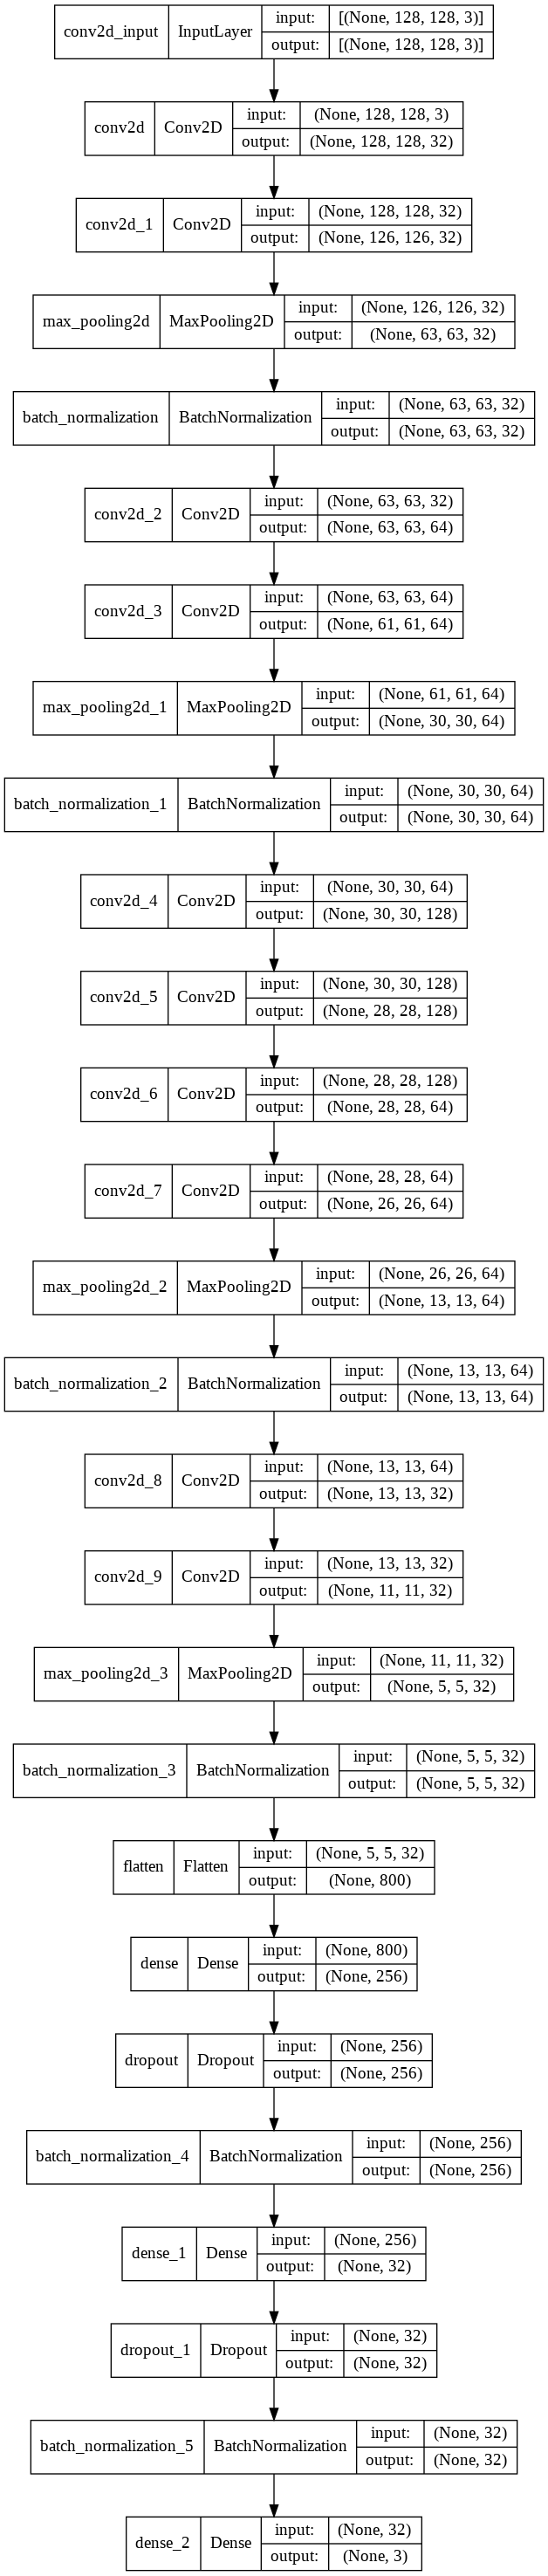

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Training PO Model

In [ ]:
EPOCHS = 40
logging.getLogger('PIL').setLevel(logging.WARNING)

model.compile(#loss = tf.keras.losses.CategoricalCrossentropy(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = Adam(learning_rate = 0.00002),
              metrics = ['acc'])

checkpoint = ModelCheckpoint(filepath='model.hdf5', 
                             verbose=1, 
                             save_best_only=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

fit_history = model.fit(
    x_post_norm,    #Normalized
    #x_new_post,     #Normalized and Augmented
    #x_post_final2,   #Standard
    #y_post_hot,  
    y_post_hot2,                  
    #y_new_hot,
    epochs = EPOCHS,
    #callbacks=[callback],
    batch_size = 128,
    validation_data = (val_post_norm, val_post_hot)
    #validation_data = (val_post_final, val_post_hot)  #Standard
)

Epoch 1/40
258/258 [==============================] - 25s 49ms/step - loss: 0.7894 - acc: 0.3586 - val_loss: 0.7871 - val_acc: 0.2264
Epoch 2/40
258/258 [==============================] - 11s 43ms/step - loss: 0.7051 - acc: 0.4612 - val_loss: 0.7174 - val_acc: 0.2681
Epoch 3/40
258/258 [==============================] - 11s 43ms/step - loss: 0.6686 - acc: 0.4926 - val_loss: 0.5817 - val_acc: 0.5366
Epoch 4/40
258/258 [==============================] - 11s 43ms/step - loss: 0.6435 - acc: 0.5146 - val_loss: 0.5653 - val_acc: 0.5440
Epoch 5/40
258/258 [==============================] - 11s 42ms/step - loss: 0.6267 - acc: 0.5268 - val_loss: 0.5706 - val_acc: 0.5511
Epoch 6/40
258/258 [==============================] - 11s 43ms/step - loss: 0.6080 - acc: 0.5432 - val_loss: 0.5555 - val_acc: 0.5601
Epoch 7/40
258/258 [==============================] - 11s 43ms/step - loss: 0.6010 - acc: 0.5491 - val_loss: 0.5347 - val_acc: 0.5849
Epoch 8/40
258/258 [==============================] - 11s 43ms

## Transfer Learning

In [ ]:
#input_shape = (128, 128, 3)
input_shape = (64, 64, 3)
num_classes = 3

base_model = keras.applications.Xception(
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = Input(shape=input_shape)
x = tf.keras.applications.xception.preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

#Dense1
#x = keras.layers.Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
#Dense2
#x = keras.layers.Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
#Dense2

#x = keras.layers.Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 64, 64, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 64, 64, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
EPOCHS = 20
lr = 0.0001
logging.getLogger('PIL').setLevel(logging.WARNING)

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = Adam(learning_rate = lr),
              metrics = ['acc'])

#checkpoint = ModelCheckpoint(filepath='model.hdf5', 
#                               verbose=1, 
#                               save_best_only=True)


fit_history = model.fit(
    x_post_norm,    #Normalized
    #[x_new_post, x_new_pre],     #Normalized and Augmented
    y_post_hot2,                  
    #y_new_hot,
    epochs = EPOCHS,
    #callbacks=[callback],
    batch_size = 128,
    validation_data = (val_post_norm, val_post_hot)
)

Epoch 1/20
319/319 [==============================] - 13s 32ms/step - loss: 1.0975 - acc: 0.3557 - val_loss: 1.0974 - val_acc: 0.3314
Epoch 2/20
319/319 [==============================] - 9s 28ms/step - loss: 1.0937 - acc: 0.3888 - val_loss: 1.0917 - val_acc: 0.4059
Epoch 3/20
319/319 [==============================] - 9s 28ms/step - loss: 1.0874 - acc: 0.4038 - val_loss: 1.0851 - val_acc: 0.3844
Epoch 4/20
319/319 [==============================] - 9s 28ms/step - loss: 1.0795 - acc: 0.4103 - val_loss: 1.0772 - val_acc: 0.4065
Epoch 5/20
319/319 [==============================] - 9s 28ms/step - loss: 1.0724 - acc: 0.4163 - val_loss: 1.0700 - val_acc: 0.4221
Epoch 6/20
319/319 [==============================] - 9s 28ms/step - loss: 1.0660 - acc: 0.4241 - val_loss: 1.0670 - val_acc: 0.4215
Epoch 7/20
319/319 [==============================] - 9s 28ms/step - loss: 1.0607 - acc: 0.4309 - val_loss: 1.0628 - val_acc: 0.4261
Epoch 8/20
319/319 [==============================] - 9s 28ms/step -

### Fine tuning

In [ ]:
base_model.trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 64, 64, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 64, 64, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
EPOCHS = 80
lr = 0.001
logging.getLogger('PIL').setLevel(logging.WARNING)

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = Adam(learning_rate = lr),
              metrics = ['acc'])

#checkpoint = ModelCheckpoint(filepath='model.hdf5', 
#                               verbose=1, 
#                               save_best_only=True)

fit_history = model.fit(
    x_post_norm,    #Normalized
    #[x_new_post, x_new_pre],     #Normalized and Augmented
    y_post_hot2,                  
    #y_new_hot,
    epochs = EPOCHS,
    #callbacks=[callback],
    batch_size = 128,
    validation_data = (val_post_norm, val_post_hot)
)

Epoch 1/80
319/319 [==============================] - 31s 84ms/step - loss: 1.4919 - acc: 0.3312 - val_loss: 1.0986 - val_acc: 0.3375
Epoch 2/80
319/319 [==============================] - 25s 79ms/step - loss: 1.0988 - acc: 0.3306 - val_loss: 1.0988 - val_acc: 0.3380
Epoch 3/80
319/319 [==============================] - 25s 78ms/step - loss: 1.0986 - acc: 0.3312 - val_loss: 1.0989 - val_acc: 0.3245
Epoch 4/80
319/319 [==============================] - 25s 78ms/step - loss: 1.0987 - acc: 0.3329 - val_loss: 1.0987 - val_acc: 0.3375
Epoch 5/80
319/319 [==============================] - 25s 78ms/step - loss: 1.0987 - acc: 0.3314 - val_loss: 1.0987 - val_acc: 0.3245
Epoch 6/80
319/319 [==============================] - 25s 78ms/step - loss: 1.0986 - acc: 0.3366 - val_loss: 1.0987 - val_acc: 0.3375
Epoch 7/80
319/319 [==============================] - 25s 79ms/step - loss: 1.0987 - acc: 0.3320 - val_loss: 1.0987 - val_acc: 0.3375
Epoch 8/80
319/319 [==============================] - 26s 81ms

KeyboardInterrupt: ignored

## Data Subtraction

<class 'numpy.ndarray'>
[35 27  6]
[50 44 31]
[15 17 25]


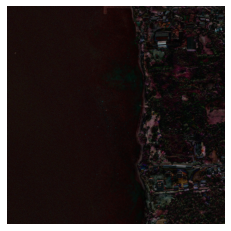

True

In [ ]:
image_paths = []

#Change the path for train/test images
image_paths.extend(full_palu_images + image for image in os.listdir(full_palu_images))

image_post = 'palu-tsunami_00000009_post_disaster.png'
image_pre = 'palu-tsunami_00000009_pre_disaster.png' 

img_post = cv2.imread(os.path.join(full_palu_images, image_post))
img_pre = cv2.imread(os.path.join(full_palu_images, image_pre))
print(type(img_post))

img_sub = cv2.absdiff(img_post, img_pre)

print(img_post[0][0])
print(img_pre[0][0])

print(img_sub[0][0])

imgshow(img_sub)
cv2.imwrite(palu_path + '/img_ex.png', img_sub)

## Save Subtracted Images 

In [ ]:
image_paths = []
#Change the path for train/test images
#image_paths.extend(train_palu_images + image for image in os.listdir(train_palu_images))
#image_paths.extend(test_palu_images + image for image in os.listdir(test_palu_images))
image_paths.extend(full_palu_images + image for image in os.listdir(full_palu_images))

#Create the couple PRE-POST image, find the subtracted image and save it on Drive

n = len(image_paths)
n /= 2
print("Number of couples: ", int(n))

arr_couple = []
for num in range(int(n)):
  arr_n = []
  string = '00' + str(num) + '_' 
  for img in image_paths:
    if img.find(string) != -1:
      arr_n.append(img)
  arr_couple.append(arr_n)

count = 0
for couple in arr_couple:
  if couple[0].find('post') != -1:
    post_image = couple[0]
    pre_image = couple[1]
  else:
    post_image = couple[1]
    pre_image = couple[0]

  img_post = cv2.imread(os.path.join(full_palu_images, post_image))
  img_pre = cv2.imread(os.path.join(full_palu_images, pre_image))

  img_sub = cv2.absdiff(img_post, img_pre)

  #imgshow(img_sub)
  cv2.imwrite(full_palu_images_subtract + '/image_' + str(count) + '.png', img_sub)
  
  count += 1

Number of couples:  196


In [ ]:
print(x_data)
print(label_building_encoding)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(x_data)
print(label_building_encoding)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## TTS Model

In [ ]:
def abs_diff(X):
    s = X[0]
    for i in range(1, len(X)):
        s -= X[i]
    s = K.abs(s)
    return s

In [ ]:
#MODEL 1

#from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, subtract

visible1 = Input(shape=(64,64,3))
conv1a = Conv2D(8, kernel_size=(3,3), padding = 'same', activation='relu')(visible1)
pool1a = MaxPooling2D(pool_size=(2, 2))(conv1a)
batch_1a = BatchNormalization()(pool1a)
conv2a = Conv2D(16, kernel_size=(3,3), padding = 'same', activation='relu')(batch_1a)
conv3a = Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu')(conv2a)
conv4a = Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu')(conv3a)
conv5a = Conv2D(64, kernel_size=(3,3), padding = 'same', activation='relu')(conv4a)
pool5a = MaxPooling2D(pool_size=(2, 2))(conv5a)
batch_5a = BatchNormalization()(pool5a)

visible2 = Input(shape=(64,64,3))
conv1b = Conv2D(8, kernel_size=(3,3), padding = 'same', activation='relu')(visible2)
pool1b = MaxPooling2D(pool_size=(2, 2))(conv1b)
batch_b = BatchNormalization()(pool1b)
conv2b = Conv2D(16, kernel_size=(3,3), padding = 'same', activation='relu')(batch_b)
conv3b = Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu')(conv2b)
conv4b = Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu')(conv3b)
conv5b = Conv2D(64, kernel_size=(3,3), padding = 'same', activation='relu')(conv4b)
pool5b = MaxPooling2D(pool_size=(2, 2))(conv5b)
batch_5b = BatchNormalization()(pool5b)

#merge = concatenate([pool12, pool22])
merge = subtract([batch_5a, batch_5b])
#merge = Lambda([batch_5a, batch_5b], abs_diff)

#Conv3 32 with concatenate, 16 with subtract
conv6 = Conv2D(64, kernel_size=(3,3), activation='relu')(merge)
pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
flat = Flatten()(pool6)

dense1 = Dense(512, activation='relu')(flat)
drop1 = Dropout(0.3)(dense1)
batch1 = BatchNormalization()(drop1)

#dense2 = Dense(128, activation='relu')(batch1)
#drop2 = Dropout(0.3)(dense2)
#batch2 = BatchNormalization()(drop2)

dense3 = Dense(64, activation='sigmoid')(batch1)
drop3 = Dropout(0.3)(dense3)
batch3 = BatchNormalization()(drop3)

#4 Classes
output = Dense(4, activation='softmax')(batch3)
#Binary Classification
#output = Dense(2, activation='sigmoid')(batch3)
model = Model(inputs=[visible1, visible2], outputs=output)

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 64, 64, 8)    224         ['input_3[0][0]']                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 8)    224         ['input_4[0][0]']                
                                                                                            

In [ ]:
#MODEL 2

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, subtract

visible_A = Input(shape=(128,128,3))
conv_1a = Conv2D(16, kernel_size=(3,3), padding = 'same', activation='relu')(visible_A)
pool_1a = MaxPooling2D(pool_size=(2, 2))(conv_1a)
batch_1a = BatchNormalization()(pool_1a)
conv_2a = Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu')(batch_1a)
conv_3a = Conv2D(16, kernel_size=(3,3), padding = 'same', activation='relu')(conv_2a)
batch_3a = BatchNormalization()(conv_3a)

visible_B = Input(shape=(128,128,3))
conv_1b = Conv2D(16, kernel_size=(3,3), padding = 'same', activation='relu')(visible_B)
pool_1b = MaxPooling2D(pool_size=(2, 2))(conv_1b)
batch_1b = BatchNormalization()(pool_1b)
conv_2b = Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu')(batch_1b)
conv_3b = Conv2D(16, kernel_size=(3,3), padding = 'same', activation='relu')(conv_2b)
batch_3b = BatchNormalization()(conv_3b)

merge = subtract([batch_3a, batch_3b])

#Conv3 32 with concatenate, 16 with subtract
conv = Conv2D(16, kernel_size=(3,3), activation='relu')(merge)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
flat = Flatten()(pool)

dense1 = Dense(256, activation='relu')(flat)
drop1 = Dropout(0.3)(dense1)
batch1 = BatchNormalization()(drop1)

dense3 = Dense(64, activation='sigmoid')(batch1)
drop3 = Dropout(0.3)(dense3)
batch3 = BatchNormalization()(drop3)

#3 Classes
output = Dense(4, activation='softmax')(batch3)
model = Model(inputs=[visible_A, visible_B], outputs=output)

print(model.summary())


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 128, 128, 16  448         ['input_7[0][0]']                
                                )                                                           

In [ ]:
def model_shared(visible1):

  conv1a = Conv2D(8, kernel_size=(3,3), padding = 'same', activation='relu')(visible1)
  pool1a = MaxPooling2D(pool_size=(2, 2))(conv1a)
  batch_1a = BatchNormalization()(pool1a)
  conv2a = Conv2D(16, kernel_size=(3,3), padding = 'same', activation='relu')(batch_1a)
  conv3a = Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu')(conv2a)
  conv4a = Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu')(conv3a)
  conv5a = Conv2D(64, kernel_size=(3,3), padding = 'same', activation='relu')(conv4a)
  pool5a = MaxPooling2D(pool_size=(2, 2))(conv5a)
  batch_5a = BatchNormalization()(pool5a)
  return batch_5a

visible1 = Input(shape=(64,64,3))
visible2 = Input(shape=(64,64,3))

f1 = model_shared(visible1)
f2 = model_shared(visible2)

merge = subtract([f1, f2])
#merge = Lambda([batch_5a, batch_5b], abs_diff)

#Conv3 32 with concatenate, 16 with subtract
conv6 = Conv2D(64, kernel_size=(3,3), activation='relu')(merge)
pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
flat = Flatten()(pool6)

dense1 = Dense(256, activation='relu')(flat)
drop1 = Dropout(0.3)(dense1)
batch1 = BatchNormalization()(drop1)

#dense2 = Dense(128, activation='relu')(batch1)
#drop2 = Dropout(0.3)(dense2)
#batch2 = BatchNormalization()(drop2)

dense3 = Dense(64, activation='sigmoid')(batch1)
drop3 = Dropout(0.3)(dense3)
batch3 = BatchNormalization()(drop3)

#3 Classes
output = Dense(4, activation='softmax')(batch3)
#Binary Classification
#output = Dense(2, activation='sigmoid')(batch2)
model = Model(inputs=[visible1, visible2], outputs=output)
print(model.summary())

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_150 (Conv2D)            (None, 64, 64, 8)    224         ['input_31[0][0]']               
                                                                                                  
 conv2d_155 (Conv2D)            (None, 64, 64, 8)    224         ['input_32[0][0]']               
                                                                                           

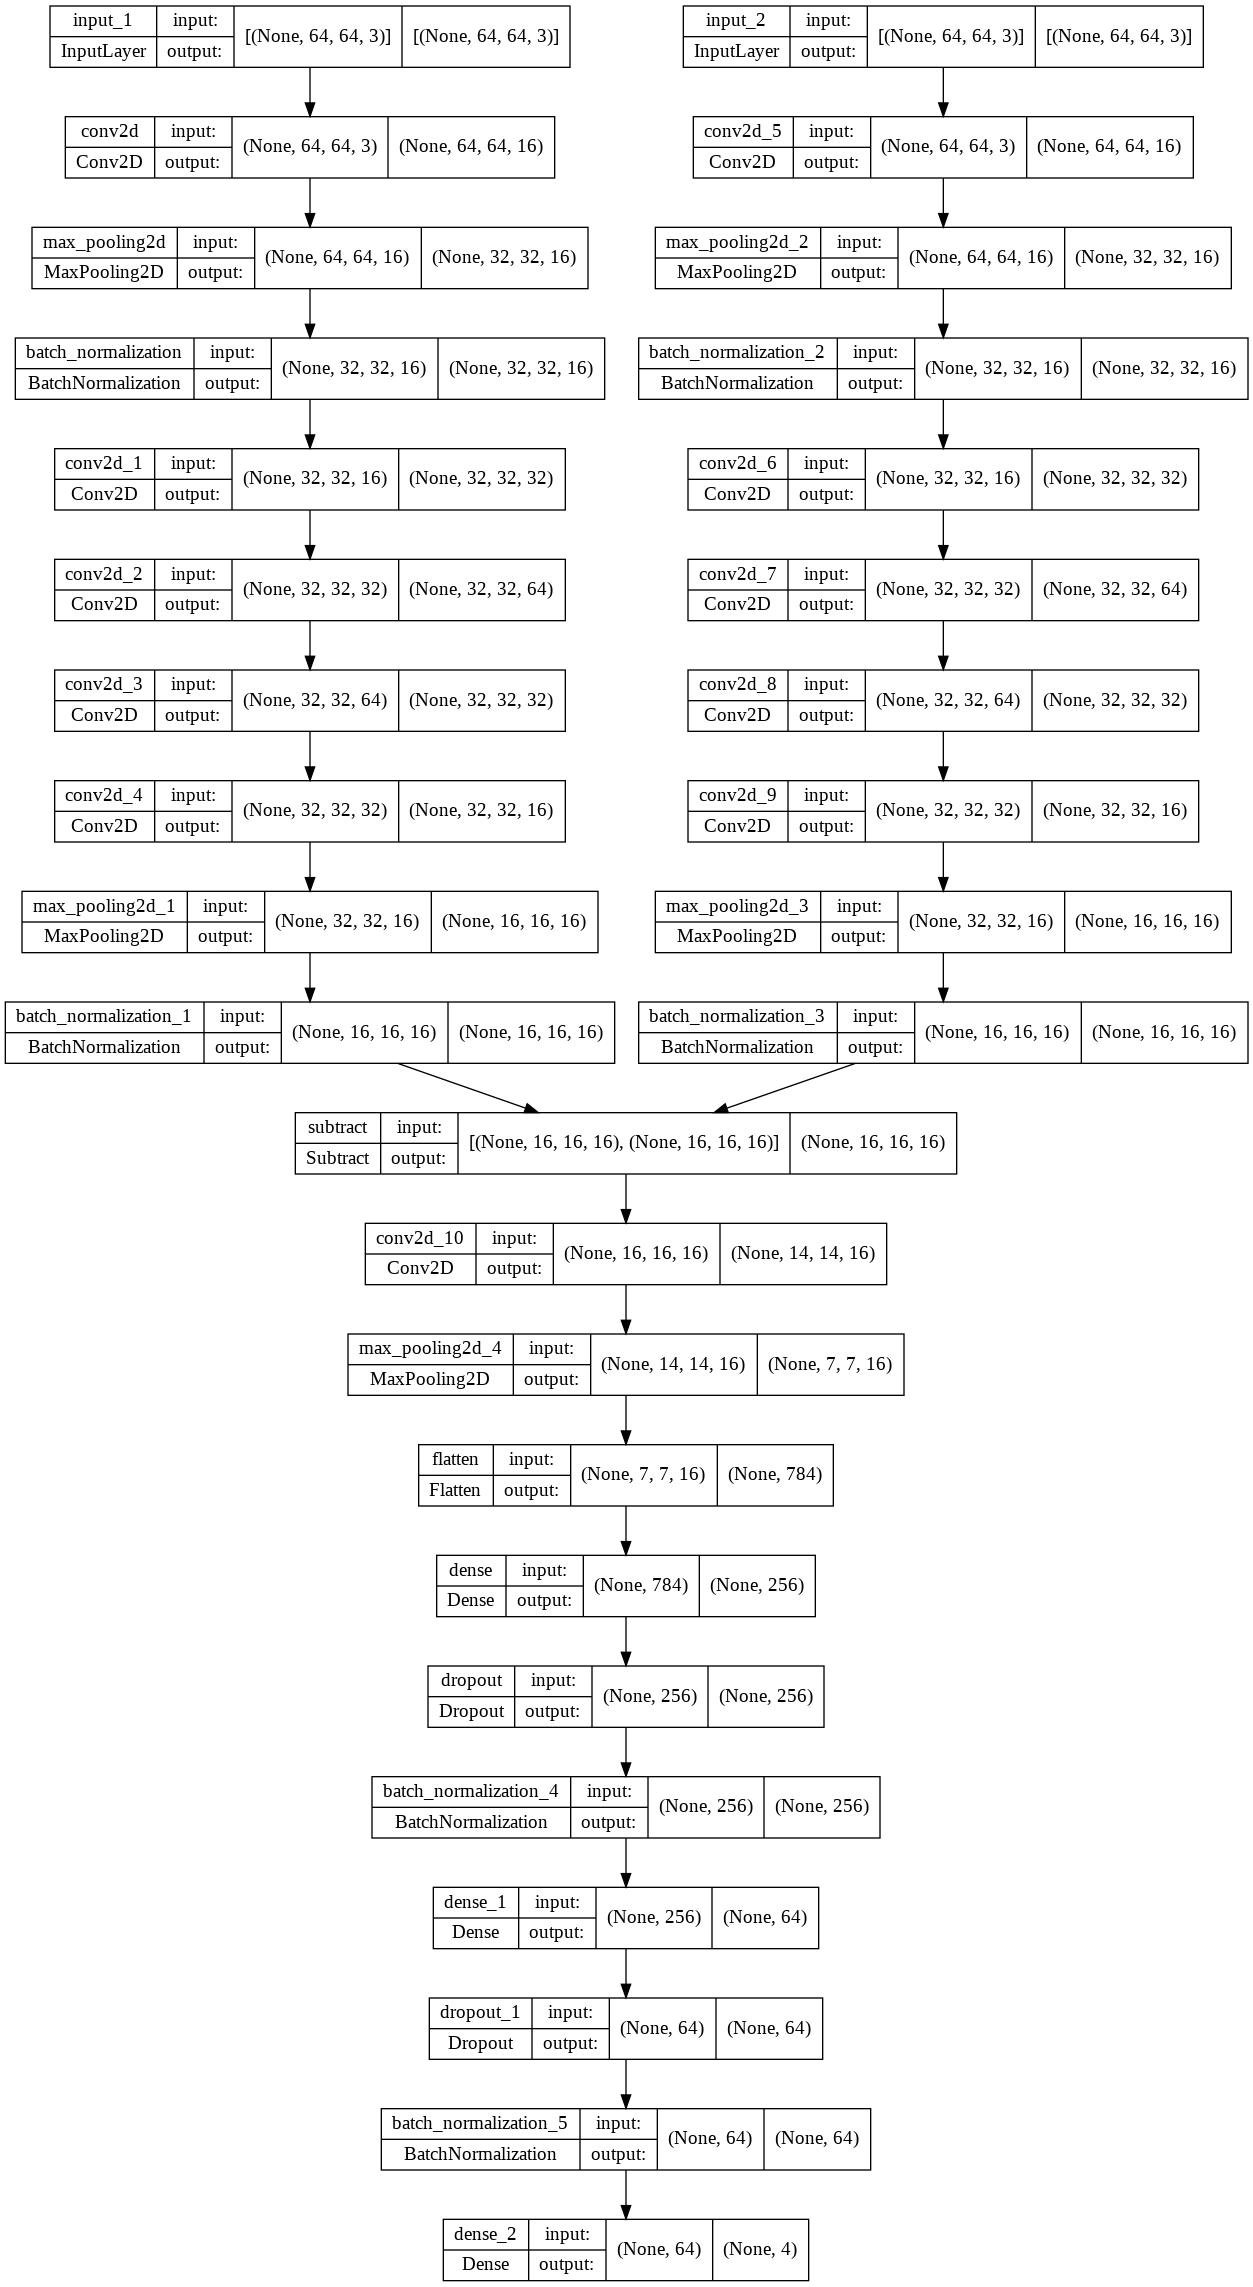

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Data Processing

### Label Replacement

In [ ]:
#4 CLASSES

def label_replacement(label_building_encoding):

    label_building_encoding_new = []
    for val in label_building_encoding:
          label_building_encoding_new.append(val)

    label_building_encoding = label_building_encoding_new
    
    return label_building_encoding

In [ ]:
#3 CLASSES

def label_replacement(label_building_encoding):

    #I put together minor-damage with major-damage and un-classified in no-damage
    label_building_encoding_new = []
    for val in label_building_encoding:
        if val == 4: 
          label_building_encoding_new.append(0)
        elif val == 3: 
          label_building_encoding_new.append(2)
        else: 
          label_building_encoding_new.append(val)

    label_building_encoding = label_building_encoding_new
    
    return label_building_encoding

In [ ]:
#2 CLASSES

def label_replacement(label_building_encoding):

    #I put together minor-damage with major-damage and un-classified in no-damage
    label_building_encoding_new = []
    for val in label_building_encoding:
        if val == 3: 
          label_building_encoding_new.append(1)
        elif val == 2: 
          label_building_encoding_new.append(1)
        else: 
          label_building_encoding_new.append(val)

    label_building_encoding = label_building_encoding_new
    
    return label_building_encoding

### Data Undersampling

In [ ]:
def data_undersampling(x_data, buildings_array, label_building_encoding):

    label_building_encoding = label_replacement(label_building_encoding)

    df_full = pd.DataFrame({'uuid':x_data, 'labels':label_building_encoding})
    x = df_full['labels'].value_counts()

    #4 Classes
    print(x[0], x[1], x[2], x[3])
    minor_n = min(x[0], x[1], x[2], x[3])
    print(minor_n)
    minor_n = 80000

    #3 Classes
    #print(x[0], x[1], x[2])
    #minor_n = min(x[0], x[1], x[2])
    #print(minor_n)
    
    #2 Classes
    #minor_n = min(x[0], x[1])
    #print(minor_n)

    #print(df_full['uuid'])

    x_data_equalized = []
    label_encoding_equalized = []
    count_0 = 0
    count_1 = 0
    count_2 = 0
    count_3 = 0
    for i in range(len(label_building_encoding)):
      if label_building_encoding[i] == 0 and count_0 < minor_n:     # < minor_n usually
        count_0 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])
      if label_building_encoding[i] == 1 and count_1 < minor_n:
        count_1 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])
      if label_building_encoding[i] == 2 and count_2 < minor_n:
        count_2 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])
      if label_building_encoding[i] == 3 and count_3 < minor_n:
        count_3 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])

    #print(label_encoding_equalized)
    #print(x_data_equalized)

    return x_data_equalized, label_encoding_equalized

In [ ]:
sl = list(zip(buildings_array_post, buildings_array_pre, label_building_encoding_post))
random.shuffle(sl)
buildings_array_post, buildings_array_pre, label_building_encoding_post = zip(*sl)

x_post, y_post = data_undersampling(x_data_post, buildings_array_post, label_building_encoding_post)
x_pre, y_pre = data_undersampling(x_data_pre, buildings_array_pre, label_building_encoding_post)
#x_sub, y_sub = data_undersampling(x_data_sub, buildings_array_sub, label_building_encoding_sub)

NameError: ignored

### Image Resizing

In [ ]:
img_recovery = np.zeros((64,64,3))

#Try both with 128*128 and 64*64
#size = (128,128)
size = (64,64)
x_post_resized = []

x_post_final = np.asarray(resize_array_img(x_post))
x_pre_final = np.asarray(resize_array_img(x_pre))
#x_sub_final = np.asarray(resize_array_img(x_sub))

print(x_post_final.shape)

y_post_hot = to_categorical(np.asarray(y_post))
y_pre_hot = to_categorical(np.asarray(y_post))
#y_sub_hot = to_categorical(np.asarray(y_sub))

print(y_post_hot.shape)

Corrupt image
Corrupt image
Corrupt image
Corrupt image
Corrupt image
Corrupt image
Corrupt image
Corrupt image
(28427, 64, 64, 3)
(28427, 4)


In [ ]:
print(len(x_post), len(y_post))
print(len(x_pre), len(y_pre))
#print(len(x_sub), len(y_sub))

28427 28427
28427 28427


In [ ]:
#Shuffle
x_post_final, y_post_hot, x_pre_final, y_pre_hot = unison_shuffled_copies(x_post_final, y_post_hot, x_pre_final, y_pre_hot)

#POST images
x_post_final2, val_post_final = x_post_final[:int(0.80*len(x_post_final))], x_post_final[int(0.80*len(x_post_final)):]
y_post_hot2, val_post_hot = y_post_hot[:int(0.80*len(x_post_final))], y_post_hot[int(0.80*len(x_post_final)):]

#PRE images
#x_pre_final, y_pre_hot = unison_shuffled_copies(x_pre_final, y_pre_hot)

x_pre_final2, val_pre_final = x_pre_final[:int(0.80*len(x_post_final))], x_pre_final[int(0.80*len(x_post_final)):]
y_pre_hot2, val_pre_hot = y_pre_hot[:int(0.80*len(x_post_final))], y_pre_hot[int(0.80*len(x_post_final)):]

#SUB images
#x_sub_final, y_sub_hot = unison_shuffled_copies(x_sub_final, y_sub_hot)

#x_sub_final2, val_sub_final = x_sub_final[:int(0.80*len(x_post_final))], x_sub_final[int(0.80*len(x_post_final)):]
#y_sub_hot2, val_sub_hot = y_sub_hot[:int(0.80*len(x_post_final))], y_sub_hot[int(0.80*len(x_post_final)):]

print(x_post_final2.shape)
print(val_post_final.shape)
print(y_post_hot2.shape)
print(val_post_hot.shape)

(22741, 64, 64, 3)
(5686, 64, 64, 3)
(22741, 4)
(5686, 4)


In [ ]:
del x_data_post
del x_data_pre
#del x_data_sub 

### Normalization

In [ ]:
x_post_norm = x_post_final2/255.0
x_pre_norm = x_pre_final2/255.0
#x_sub_norm = x_sub_final2/255.0

del x_post_final2
del x_pre_final2
#del x_sub_final2

val_post_norm = val_post_final/255.0
val_pre_norm = val_pre_final/255.0
#val_sub_norm = val_sub_final/255.0

del val_post_final
del val_pre_final
#del val_sub_final

### Data Augmentation

In [ ]:
def check_size(size):
    if type(size) == int:
        size = (size, size)
    if type(size) != tuple:
        raise TypeError('size is int or tuple')
    return size

def resize(image, size):
    size = check_size(size)
    image = cv2.resize(image, size)
    return image

def horizontal_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[:, ::-1, :]
    return image

def vertical_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[::-1, :, :]
    return image

def random_rotation(image, angle_range=(0, 180)):
    h, w, _ = image.shape
    angle = np.random.randint(*angle_range)
    image = rotate(image, angle)
    image = resize(image, (h, w))
    return image

list_norm_post = []
list_norm_pre = []

for image in x_post_norm:
  list_norm_post.append(horizontal_flip(image))

for image in x_pre_norm:
  list_norm_pre.append(horizontal_flip(image))

for image in x_post_norm:
  list_norm_post.append(vertical_flip(image))

for image in x_pre_norm:
  list_norm_pre.append(vertical_flip(image))

for image in x_post_norm:
  list_norm_post.append(random_rotation(image))

for image in x_pre_norm:
  list_norm_pre.append(random_rotation(image))

augmented_norm_post = np.asanyarray(list_norm_post)
augmented_norm_pre = np.asanyarray(list_norm_pre)

x_post_norm = np.concatenate((x_post_norm, augmented_norm_post))
x_pre_norm = np.concatenate((x_pre_norm, augmented_norm_pre))

y_post_hot2 = np.concatenate((y_post_hot2, y_post_hot2, y_post_hot2, y_post_hot2))

#x_post_norm = np.concatenate((x_post_norm, horizontal_flip(x_post_norm) , vertical_flip(x_post_norm)))
#x_pre_norm = np.concatenate((x_pre_norm, horizontal_flip(x_pre_norm), vertical_flip(x_pre_norm)))

#y_post_hot2 = np.concatenate((y_post_hot2, y_post_hot2, y_post_hot2))

In [ ]:
print(x_post_norm.shape)
print(x_pre_norm.shape)

print(y_post_hot2.shape)

(10668, 64, 64, 3)
(10668, 64, 64, 3)
(10668, 4)


### Save Arrays on Drive

In [ ]:
#Images
#np.save('x_complete_post.npy', x_new_post)
#np.save('x_complete_pre.npy', x_new_pre)
#np.save('x_complete_sub.npy', x_new_sub)

np.save('val_complete_post.npy', val_post_norm)
#np.save('val_complete_pre.npy', val_new_pre)
#np.save('val_complete_sub.npy', val_new_sub)

#Labels
#np.save('y_complete_post.npy', y_hot_post)
#np.save('x_complete_post.npy', y_hot_pre)
#np.save('x_complete_post.npy', y_hot_sub)

np.save('val_complete_post_hot.npy', val_post_hot)
#np.save('val_complete_post.npy', y_hot_pre)
#np.save('val_complete_post.npy', y_hot_sub)

## Training TTS Model

In [ ]:
EPOCHS = 30
logging.getLogger('PIL').setLevel(logging.WARNING)

model.compile(#loss = tf.keras.losses.CategoricalCrossentropy(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = Adam(learning_rate = 0.00002),
              metrics = ['acc'])

checkpoint = ModelCheckpoint(filepath='model.hdf5', 
                             verbose=1, 
                             save_best_only=True)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

fit_history = model.fit(
    [x_post_norm, x_pre_norm],    #Normalized
    #[x_new_post, x_new_pre],     #Normalized and Augmented
    #[x_post_final2, x_pre_final2],   #Standard
    #y_post_hot,  
    y_post_hot2,                  
    #y_new_hot,
    epochs = EPOCHS,
    #callbacks=[callback],
    batch_size = 128,
    validation_data = ([val_post_norm, val_pre_norm], val_post_hot)
    #validation_data = ([val_post_final, val_pre_final], val_post_hot)  #Standard
)

Epoch 1/30
29/29 [==============================] - 2s 30ms/step - loss: 0.4717 - acc: 0.7584 - val_loss: 0.4415 - val_acc: 0.7537
Epoch 2/30
29/29 [==============================] - 1s 19ms/step - loss: 0.4696 - acc: 0.7642 - val_loss: 0.4295 - val_acc: 0.7463
Epoch 3/30
29/29 [==============================] - 1s 19ms/step - loss: 0.4653 - acc: 0.7706 - val_loss: 0.4257 - val_acc: 0.7537
Epoch 4/30
29/29 [==============================] - 1s 19ms/step - loss: 0.4492 - acc: 0.7863 - val_loss: 0.4319 - val_acc: 0.7463
Epoch 5/30
29/29 [==============================] - 1s 19ms/step - loss: 0.4552 - acc: 0.7781 - val_loss: 0.4341 - val_acc: 0.7587
Epoch 6/30
29/29 [==============================] - 1s 19ms/step - loss: 0.4467 - acc: 0.7833 - val_loss: 0.4291 - val_acc: 0.7438
Epoch 7/30
29/29 [==============================] - 1s 19ms/step - loss: 0.4402 - acc: 0.7830 - val_loss: 0.4186 - val_acc: 0.7463
Epoch 8/30
29/29 [==============================] - 1s 19ms/step - loss: 0.4331 - a

In [ ]:
EPOCHS = 100
logging.getLogger('PIL').setLevel(logging.WARNING)

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = Adam(learning_rate = 0.00001),
              metrics = ['acc'])

fit_history = model.fit(
    x_new_post,
    y_new_hot,
    epochs = EPOCHS,
    batch_size = 128,
    validation_data = (val_post_norm, val_post_hot)
)

## Evaluation

In [ ]:
del x_post_norm
del x_pre_norm

In [ ]:
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0

x_test_post = []
x_test_pre = []
y_test = []

i = 0
while i in range(len(val_post_hot)):
    if val_post_hot[i][0] == 1. and count_0 < 80: 
      count_0 += 1
      x_test_post.append(val_post_norm[i])
      x_test_pre.append(val_pre_norm[i])
      y_test.append(val_post_hot[i])
    if val_post_hot[i][1] == 1. and count_1 < 80:
      count_1 += 1
      x_test_post.append(val_post_norm[i])
      x_test_pre.append(val_pre_norm[i])
      y_test.append(val_post_hot[i])
    if val_post_hot[i][2] == 1. and count_2 < 80: 
      count_2 += 1
      x_test_post.append(val_post_norm[i])
      x_test_pre.append(val_pre_norm[i])
      y_test.append(val_post_hot[i])
    if val_post_hot[i][3] == 1. and count_3 < 80: 
      count_3 += 1
      x_test_post.append(val_post_norm[i])
      x_test_pre.append(val_pre_norm[i])
      y_test.append(val_post_hot[i])
    i += 1

print(count_0)
print(count_1)
print(count_2)
print(count_3)

print(len(x_test_post))
print(len(x_test_pre))
print(len(y_test))

80
80
80
80
320
320
320


In [ ]:
x_test_post = np.asarray(x_test_post)
x_test_pre = np.asarray(x_test_pre)
y_test = np.asarray(y_test)

print(x_test_post.shape)
print(x_test_pre.shape)
print(y_test.shape)

(320, 64, 64, 3)
(320, 64, 64, 3)
(320, 4)


In [ ]:
val_post_hot2 = val_post_hot
val_post_norm2 = val_post_norm
val_pre_norm2 = val_pre_norm

In [ ]:
def eval_single_disaster(val_post_norm, val_pre_norm, val_post_hot, disaster):
  
  val_post_norm_dis = []
  val_pre_norm_dis = []
  val_post_hot_dis = []
  for i in range(len(val_post_norm)):
    if val_mapping[i] == single_disasters[disaster]:
      val_post_norm_dis.append(val_post_norm[i])
      val_pre_norm_dis.append(val_pre_norm[i])
      val_post_hot_dis.append(val_post_hot[i])
  
  val_post_norm_dis = np.asarray(val_post_norm_dis)
  val_pre_norm_dis = np.asarray(val_pre_norm_dis)
  val_post_hot_dis = np.asarray(val_post_hot_dis)

  return val_post_norm_dis, val_pre_norm_dis, val_post_hot_dis

val_post_norm_dis, val_pre_norm_dis, val_post_hot_dis = eval_single_disaster(val_post_norm,  
                                                                             val_pre_norm, val_post_hot, 'hurricane-harvey')

print(type(val_post_norm_dis))
print(val_pre_norm_dis.shape)
print(val_post_hot_dis.shape)

model.evaluate([val_post_norm_dis, val_pre_norm_dis], val_post_hot_dis)

labels = tf.argmax(val_post_hot_dis, axis = 1)
predict_arr = model.predict([val_post_norm_dis, val_pre_norm_dis])

predict_arr_list = []
for el in predict_arr:
    n = np.argmax(el)
    predict_arr_list.append(n)

predict_tensor = tf.convert_to_tensor(predict_arr_list, dtype='int64')
print("Tensor 1 of the predictions: ", predict_tensor)

confusion_mtx = tf.math.confusion_matrix(labels, predict_tensor) 

classes = ['No Damage', 'Destroyed', 'Major Damage', 'Minor Damage']
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

calc_F1_scores(confusion_mtx)

<class 'numpy.ndarray'>
(0,)
(0,)


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:923: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: ignored

In [ ]:
#Balanced Test Set
#model.evaluate([val_post_norm, val_pre_norm], val_post_hot, batch_size=128)

#Unbalanced Test Set
#PO Model
#model.evaluate(x_test_post, y_test, batch_size=32)
#TTS Model
model.evaluate([x_test_post, x_test_pre], y_test, batch_size=32)

10/10 [==============================] - 0s 5ms/step - loss: 0.4066 - acc: 0.7469


[0.40657711029052734, 0.746874988079071]

In [ ]:
labels1 = tf.argmax(val_post_hot, axis = 1)
labels2 = tf.argmax(y_test, axis = 1)

#PO
#predict_arr1 = model.predict(val_post_norm)
#predict_arr2 = model.predict(x_test_post)

#TTS
predict_arr1 = model.predict([val_post_norm, val_pre_norm])
predict_arr2 = model.predict([x_test_post, x_test_pre])

predict_arr_dis = []
labels_dis = []
for i in range(len(val_mapping)):
  if val_mapping[i] == single_disasters['socal-fire'] or val_mapping[i] == single_disasters['santa-rosa-wildfire']:
    predict_arr_dis.append(predict_arr1[i])
    labels_dis.append(labels1[i])

predict_arr_list_dis = []
for el in predict_arr_dis:
    n = np.argmax(el)
    predict_arr_list_dis.append(n)

predict_arr_list1 = []
for el in predict_arr1:
    n = np.argmax(el)
    predict_arr_list1.append(n)

predict_arr_list2 = []
for el in predict_arr2:
    n = np.argmax(el)
    predict_arr_list2.append(n)

predict_tensor1 = tf.convert_to_tensor(predict_arr_list1, dtype='int64')
print("Tensor 1 of the predictions: ", predict_tensor1)

predict_tensor2 = tf.convert_to_tensor(predict_arr_list2, dtype='int64')
print("Tensor 2 of the predictions: ", predict_tensor2)

predict_tensor_dis = tf.convert_to_tensor(predict_arr_list_dis, dtype='int64')
print("Tensor Single Disaster of the predictions: ", predict_tensor_dis)

Tensor 1 of the predictions:  tf.Tensor(
[3 2 1 0 1 0 2 2 0 3 1 0 1 0 2 2 0 2 0 3 2 3 2 1 2 1 2 2 0 0 3 0 2 2 3 3 1
 0 0 0 0 3 0 1 3 0 2 2 1 3 2 1 1 2 1 1 2 1 3 2 0 3 2 0 2 2 2 2 2 3 0 3 1 2
 2 2 2 1 2 0 3 3 1 2 0 1 0 0 0 2 2 2 3 1 2 3 2 2 3 0 1 1 0 1 3 2 0 0 1 2 0
 1 3 3 0 2 1 0 1 0 2 1 1 3 0 1 3 0 0 0 3 2 2 2 2 1 3 3 1 3 3 2 2 1 2 1 1 0
 1 3 1 0 1 3 2 2 2 0 1 2 2 2 0 1 1 2 1 2 2 0 2 0 0 2 1 1 2 2 2 3 0 2 1 0 0
 0 0 3 1 0 0 3 0 1 1 3 3 1 2 3 0 2 1 1 3 1 0 3 3 1 3 1 1 2 0 3 2 0 3 3 0 2
 1 1 1 1 3 3 3 3 2 0 1 0 1 3 1 1 2 0 1 3 0 3 2 0 0 1 3 3 2 0 2 2 2 2 2 0 0
 2 1 0 2 1 1 3 1 2 3 3 2 3 0 0 2 3 3 0 0 0 1 2 3 0 2 2 1 3 1 2 1 1 0 1 3 2
 1 0 2 2 1 3 3 0 1 0 2 2 1 3 1 2 3 3 1 1 1 2 1 0 0 0 2 3 0 1 2 2 1 1 2 2 2
 1 2 0 3 1 2 2 1 0 2 1 0 3 1 1 2 3 1 1 0 0 0 2 1 3 0 1 2 2 2 1 2 2 3 2 1 1
 3 0 2 0 0 3 3 2 1 3 2 3 1 2 2 3 0 0 2 1 3 2 1 2 3 2 3 3 2 3 3 2], shape=(402,), dtype=int64)
Tensor 2 of the predictions:  tf.Tensor(
[3 2 1 0 1 0 2 2 0 3 1 0 1 0 2 2 0 2 0 3 2 3 2 1 2 1 2 2 0 0 3 0 2 2 3 3 1

In [ ]:
confusion_mtx_dis = tf.math.confusion_matrix(labels_dis, predict_tensor_dis) 
calc_F1_scores(confusion_mtx_dis)

InvalidArgumentError: ignored

2022-05-10 22:27:32,340 - DEBUG - matplotlib.colorbar : 607 - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1c9a912c10>
2022-05-10 22:27:32,341 - DEBUG - matplotlib.colorbar : 652 - Using auto colorbar locator on colorbar
2022-05-10 22:27:32,342 - DEBUG - matplotlib.colorbar : 653 - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1c9a912c10>
2022-05-10 22:27:32,343 - DEBUG - matplotlib.colorbar : 822 - Setting pcolormesh


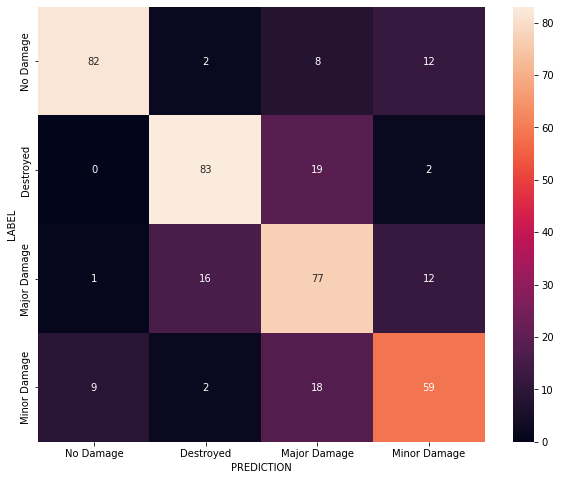

2022-05-10 22:27:32,562 - DEBUG - matplotlib.colorbar : 607 - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1c9a85ed10>
2022-05-10 22:27:32,563 - DEBUG - matplotlib.colorbar : 652 - Using auto colorbar locator on colorbar
2022-05-10 22:27:32,564 - DEBUG - matplotlib.colorbar : 653 - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1c9a85ed10>
2022-05-10 22:27:32,566 - DEBUG - matplotlib.colorbar : 822 - Setting pcolormesh


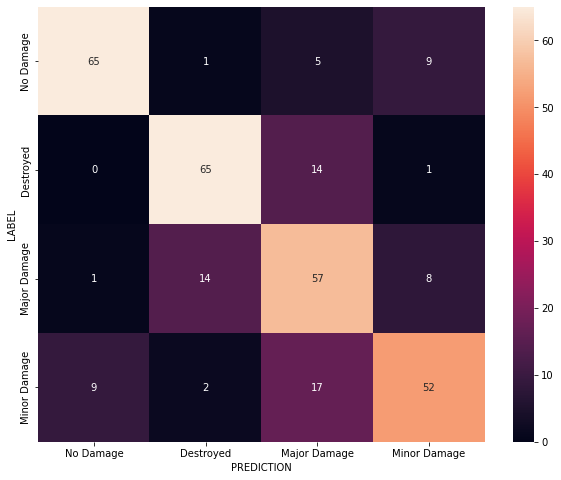

In [ ]:
#Confusion Matrix

confusion_mtx1 = tf.math.confusion_matrix(labels1, predict_tensor1) 
confusion_mtx2 = tf.math.confusion_matrix(labels2, predict_tensor2) 
#print(confusion_mtx1)

classes = ['No Damage', 'Destroyed', 'Major Damage', 'Minor Damage']

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx1, xticklabels=classes, yticklabels=classes, 
            annot=True, fmt='g')
plt.xlabel('PREDICTION')
plt.ylabel('LABEL')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx2, xticklabels=classes, yticklabels=classes, 
            annot=True, fmt='g')
plt.xlabel('PREDICTION')
plt.ylabel('LABEL')
plt.show()

In [ ]:
def calc_F1_scores(confusion_mtx):

  #F1 Score
  #num_classes = 4
  #num_classes = 3
  num_classes = 2

  res1 = 0; res2 = 0; val = 0
  sum_weighted = np.zeros(num_classes)
  precision = np.zeros(num_classes)
  recall = np.zeros(num_classes)
  for i in range(0, num_classes):
    for j in range(0, num_classes):
      if i==j:
        val = confusion_mtx[i][j]
      res1 += confusion_mtx[i][j]
      res2 += confusion_mtx[j][i]
    
    sum_weighted[i] = res2.numpy()
    precision[i] = (val/res1).numpy()
    recall[i] = (val/res2).numpy()
    
    res1 = 0; res2 = 0

  #F1-score calc for each class
  f1_score = np.zeros(num_classes)
  for i in range(0, num_classes):
    f1_score[i] = 2*(precision[i]*recall[i]) / (precision[i]+recall[i])
    print("F1-Score for class", i, ": ", f1_score[i])


  sum_macro = 0; sum_weighted_num = 0; sum_weighted_den = 0
  for i in range(0, num_classes):
    sum_macro += f1_score[i]
    sum_weighted_num += (f1_score[i]*sum_weighted[i])
    sum_weighted_den += sum_weighted[i]

  #Macro F1-score and weighted F1-score calc
  macro_f1 = sum_macro / num_classes
  weighted_f1 = sum_weighted_num / sum_weighted_den 

  print("Macro-F1: ", macro_f1)
  print("Weighted-F1: ", weighted_f1)
  print('\n')

In [ ]:
calc_F1_scores(confusion_mtx1)
calc_F1_scores(confusion_mtx2)

F1-Score for class 0 :  0.741031941031941
F1-Score for class 1 :  0.7472422062350121
Macro-F1:  0.7441370736334766
Weighted-F1:  0.7441822940111689


F1-Score for class 0 :  0.8020527859237536
F1-Score for class 1 :  0.5754716981132075
Macro-F1:  0.6887622420184806
Weighted-F1:  0.7145924860288828




## Test Single Disaster

In [ ]:
def data_undersampling(x_data, buildings_array, label_building_encoding, disaster_arr):

    label_building_encoding = label_replacement(label_building_encoding)

    df_full = pd.DataFrame({'uuid':x_data, 'labels':label_building_encoding})
    x = df_full['labels'].value_counts()

    print(len(disaster_arr))
    print(len(buildings_array))

    #4 Classes
    print("Unclassified buildings: ", x[4])
    print("0: No Damage, 1: Destroyed, 2: Mayor Damage, 3: Minor Damage")
    print("Quantities for each building: ", x[0], x[1], x[2], x[3])
    minor_n = min(x[0], x[1], x[2], x[3])
    print("Minor number: ", minor_n)
    #minor_n = 10200

    print("Percentage of damaged buildings: ", 1-(x[0]/(x[0]+x[1]+x[2]+x[3])))

    x_data_equalized = []
    label_encoding_equalized = []
    disaster_array = []

    count_0 = 0
    count_1 = 0
    count_2 = 0
    count_3 = 0
    for i in range(len(label_building_encoding)):
      if label_building_encoding[i] == 0 and count_0 < minor_n:     # < minor_n usually
        count_0 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])
        disaster_array.append(disaster_arr[i])
      if label_building_encoding[i] == 1 and count_1 < minor_n:
        count_1 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])
        disaster_array.append(disaster_arr[i])
      if label_building_encoding[i] == 2 and count_2 < minor_n:
        count_2 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])
        disaster_array.append(disaster_arr[i])
      if label_building_encoding[i] == 3 and count_3 < minor_n:
        count_3 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])
        disaster_array.append(disaster_arr[i])

    #print(label_encoding_equalized)
    #print(x_data_equalized)

    return x_data_equalized, label_encoding_equalized, disaster_array

In [ ]:
def data_undersampling(x_data, buildings_array, label_building_encoding, disaster_arr):

    label_building_encoding = label_replacement(label_building_encoding)

    df_full = pd.DataFrame({'uuid':x_data, 'labels':label_building_encoding})
    x = df_full['labels'].value_counts()

    #2 Classes
    print("0: No Damage, 1: Damage")
    print("Quantities for each building: ", x[0], x[1])
    minor_n = min(x[0], x[1])
    print("Minor number: ", minor_n)
    minor_n = 10300

    print("Percentage of damaged buildings: ", 1 - (x[0]/(x[0]+x[1])))

    x_data_equalized = []
    label_encoding_equalized = []
    disaster_array = []

    count_0 = 0
    count_1 = 0

    for i in range(len(label_building_encoding)):
      if label_building_encoding[i] == 0 and count_0 < minor_n:     # < minor_n usually
        count_0 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])
        disaster_array.append(disaster_arr[i])
      if label_building_encoding[i] == 1 and count_1 < minor_n:
        count_1 += 1
        x_data_equalized.append(buildings_array[i])
        label_encoding_equalized.append(label_building_encoding[i])
        disaster_array.append(disaster_arr[i])
    
    #print(len(x_data_equalized))

    return x_data_equalized, label_encoding_equalized, disaster_array

### Creation of Building Images

In [ ]:
image_paths = []
image_paths_post = []
image_paths_pre = []

image_paths_train = []
image_paths_test = []

count = 0
#for image in os.listdir(complete_path_1_images):
#   image_paths_train.append(complete_path_1_images + image)

#for image in os.listdir(complete_path_2_images):
#    image_paths_train.append(complete_path_2_images + image)

for image in os.listdir(complete_path_3_images):
  if  'joplin' in image:
    image_paths_train.append(complete_path_3_images + image)

#To use only for the standard dataset to take the POST and PRE images separately
image_paths_post_train, image_paths_pre_train = select_post_images(image_paths_train)
image_paths_post_test, image_paths_pre_test = select_post_images(image_paths_test)

print("N. of post images:", len(image_paths_post_train))
print("N. of pre images:", len(image_paths_pre_train))
print("N. of post images:", len(image_paths_post_test))
print("N. of pre images:", len(image_paths_pre_test))

x_data_post_train, label_building_encoding_post_train, buildings_array_post_train, dis = image_segmentation(image_paths_post_train, 'post')
x_data_pre_train, label_building_encoding_pre_train, buildings_array_pre_train, dis2 = image_segmentation(image_paths_pre_train, 'pre')

x_data_post_test, label_building_encoding_post_test, buildings_array_post_test, dis3 = image_segmentation(image_paths_post_test, 'post')
x_data_pre_test, label_building_encoding_pre_test, buildings_array_pre_test, dis4 = image_segmentation(image_paths_pre_test, 'pre')


N. of post images: 149
N. of pre images: 149
N. of post images: 0
N. of pre images: 0


  0%|          | 0/149 [00:00<?, ?it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000000_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000000_post_disaster.json


  1%|          | 1/149 [00:00<02:05,  1.18it/s]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000001_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000001_post_disaster.json


  1%|▏         | 2/149 [00:03<05:05,  2.08s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000002_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000002_post_disaster.json


  2%|▏         | 3/149 [00:06<05:18,  2.18s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000003_post_disaster.json


  3%|▎         | 4/149 [00:08<05:07,  2.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000004_post_disaster.json


  3%|▎         | 5/149 [00:10<05:42,  2.38s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000005_post_disaster.json


  4%|▍         | 6/149 [00:12<04:56,  2.07s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000006_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000006_post_disaster.json


  5%|▍         | 7/149 [00:14<04:59,  2.11s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000007_post_disaster.json


  5%|▌         | 8/149 [00:16<04:53,  2.08s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000008_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000008_post_disaster.json


  6%|▌         | 9/149 [00:18<04:46,  2.04s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000009_post_disaster.json


  7%|▋         | 10/149 [00:20<04:39,  2.01s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000010_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000010_post_disaster.json


  7%|▋         | 11/149 [00:23<05:08,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000011_post_disaster.json


  8%|▊         | 12/149 [00:26<05:29,  2.41s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000012_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000012_post_disaster.json


  9%|▊         | 13/149 [00:28<05:26,  2.40s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000013_post_disaster.json


  9%|▉         | 14/149 [00:29<04:45,  2.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000014_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000014_post_disaster.json


 10%|█         | 15/149 [00:32<05:09,  2.31s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000015_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000015_post_disaster.json


 11%|█         | 16/149 [00:34<05:02,  2.28s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000016_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000016_post_disaster.json


 11%|█▏        | 17/149 [00:37<05:20,  2.43s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000017_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000017_post_disaster.json


 12%|█▏        | 18/149 [00:40<05:30,  2.52s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000018_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000018_post_disaster.json


 13%|█▎        | 19/149 [00:41<04:49,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000019_post_disaster.json


 13%|█▎        | 20/149 [00:44<04:49,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000020_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000020_post_disaster.json


 14%|█▍        | 21/149 [00:46<04:47,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000021_post_disaster.json


 15%|█▍        | 22/149 [00:48<04:46,  2.26s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000022_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000022_post_disaster.json


 15%|█▌        | 23/149 [00:50<04:42,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000023_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000023_post_disaster.json


 16%|█▌        | 24/149 [00:53<04:57,  2.38s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000024_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000024_post_disaster.json


 17%|█▋        | 25/149 [00:56<05:01,  2.43s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000025_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000025_post_disaster.json


 17%|█▋        | 26/149 [00:59<05:19,  2.60s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000026_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000026_post_disaster.json


 18%|█▊        | 27/149 [01:01<04:57,  2.44s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000027_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000027_post_disaster.json


 19%|█▉        | 28/149 [01:03<04:48,  2.39s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000028_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000028_post_disaster.json


 19%|█▉        | 29/149 [01:05<04:40,  2.34s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000029_post_disaster.json


 20%|██        | 30/149 [01:07<04:33,  2.30s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000030_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000030_post_disaster.json


 21%|██        | 31/149 [01:10<04:22,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000031_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000031_post_disaster.json


 21%|██▏       | 32/149 [01:12<04:23,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000032_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000032_post_disaster.json


 22%|██▏       | 33/149 [01:14<04:12,  2.18s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000033_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000033_post_disaster.json


 23%|██▎       | 34/149 [01:17<04:40,  2.44s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000034_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000034_post_disaster.json


 23%|██▎       | 35/149 [01:19<04:28,  2.36s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000035_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000035_post_disaster.json


 24%|██▍       | 36/149 [01:21<04:20,  2.30s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000036_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000036_post_disaster.json


 25%|██▍       | 37/149 [01:24<04:32,  2.43s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000037_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000037_post_disaster.json


 26%|██▌       | 38/149 [01:27<04:39,  2.52s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000038_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000038_post_disaster.json


 26%|██▌       | 39/149 [01:29<04:20,  2.37s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000039_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000039_post_disaster.json


 27%|██▋       | 40/149 [01:31<04:18,  2.37s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000040_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000040_post_disaster.json


 28%|██▊       | 41/149 [01:33<04:10,  2.32s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000041_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000041_post_disaster.json


 28%|██▊       | 42/149 [01:35<04:00,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000042_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000042_post_disaster.json


 29%|██▉       | 43/149 [01:38<03:59,  2.26s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000043_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000043_post_disaster.json


 30%|██▉       | 44/149 [01:40<03:49,  2.18s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000044_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000044_post_disaster.json


 30%|███       | 45/149 [01:42<03:49,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000045_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000045_post_disaster.json


 31%|███       | 46/149 [01:43<03:22,  1.96s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000046_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000046_post_disaster.json


 32%|███▏      | 47/149 [01:46<03:44,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000047_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000047_post_disaster.json


 32%|███▏      | 48/149 [01:48<03:38,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000048_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000048_post_disaster.json


 33%|███▎      | 49/149 [01:50<03:34,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000049_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000049_post_disaster.json


 34%|███▎      | 50/149 [01:52<03:28,  2.11s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000050_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000050_post_disaster.json


 34%|███▍      | 51/149 [01:54<03:29,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000051_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000051_post_disaster.json


 35%|███▍      | 52/149 [01:57<03:28,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000052_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000052_post_disaster.json


 36%|███▌      | 53/149 [01:59<03:26,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000053_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000053_post_disaster.json


 36%|███▌      | 54/149 [02:01<03:28,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000054_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000054_post_disaster.json


 37%|███▋      | 55/149 [02:03<03:27,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000055_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000055_post_disaster.json


 38%|███▊      | 56/149 [02:06<03:24,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000056_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000056_post_disaster.json


 38%|███▊      | 57/149 [02:08<03:18,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000057_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000057_post_disaster.json


 39%|███▉      | 58/149 [02:10<03:18,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000058_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000058_post_disaster.json


 40%|███▉      | 59/149 [02:12<03:20,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000059_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000059_post_disaster.json


 40%|████      | 60/149 [02:14<03:10,  2.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000060_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000060_post_disaster.json


 41%|████      | 61/149 [02:16<03:09,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000061_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000061_post_disaster.json


 42%|████▏     | 62/149 [02:18<03:01,  2.09s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000062_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000062_post_disaster.json


 42%|████▏     | 63/149 [02:20<02:55,  2.04s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000063_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000063_post_disaster.json


 43%|████▎     | 64/149 [02:22<02:51,  2.02s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000064_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000064_post_disaster.json


 44%|████▎     | 65/149 [02:25<03:07,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000065_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000065_post_disaster.json


 44%|████▍     | 66/149 [02:27<03:06,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000066_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000066_post_disaster.json


 45%|████▍     | 67/149 [02:29<03:03,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000067_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000067_post_disaster.json


 46%|████▌     | 68/149 [02:31<02:58,  2.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000068_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000068_post_disaster.json


 46%|████▋     | 69/149 [02:33<02:50,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000069_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000069_post_disaster.json


 47%|████▋     | 70/149 [02:36<02:50,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000070_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000070_post_disaster.json


 48%|████▊     | 71/149 [02:38<02:44,  2.11s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000071_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000071_post_disaster.json


 48%|████▊     | 72/149 [02:40<02:55,  2.28s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000072_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000072_post_disaster.json


 49%|████▉     | 73/149 [02:43<02:52,  2.27s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000073_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000073_post_disaster.json


 50%|████▉     | 74/149 [02:45<02:44,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000074_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000074_post_disaster.json


 50%|█████     | 75/149 [02:47<02:50,  2.30s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000075_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000075_post_disaster.json


 51%|█████     | 76/149 [02:49<02:46,  2.28s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000076_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000076_post_disaster.json


 52%|█████▏    | 77/149 [02:52<02:52,  2.40s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000077_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000077_post_disaster.json


 52%|█████▏    | 78/149 [02:54<02:47,  2.36s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000078_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000078_post_disaster.json


 53%|█████▎    | 79/149 [02:56<02:38,  2.27s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000079_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000079_post_disaster.json


 54%|█████▎    | 80/149 [02:58<02:29,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000080_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000080_post_disaster.json


 54%|█████▍    | 81/149 [03:01<02:30,  2.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000081_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000081_post_disaster.json


 55%|█████▌    | 82/149 [03:03<02:29,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000082_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000082_post_disaster.json


 56%|█████▌    | 83/149 [03:05<02:26,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000083_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000083_post_disaster.json


 56%|█████▋    | 84/149 [03:07<02:26,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000084_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000084_post_disaster.json


 57%|█████▋    | 85/149 [03:10<02:22,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000085_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000085_post_disaster.json


 58%|█████▊    | 86/149 [03:12<02:16,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000086_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000086_post_disaster.json


 58%|█████▊    | 87/149 [03:14<02:15,  2.18s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000087_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000087_post_disaster.json


 59%|█████▉    | 88/149 [03:16<02:14,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000088_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000088_post_disaster.json


 60%|█████▉    | 89/149 [03:19<02:22,  2.37s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000089_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000089_post_disaster.json


 60%|██████    | 90/149 [03:21<02:16,  2.31s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000090_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000090_post_disaster.json


 61%|██████    | 91/149 [03:24<02:22,  2.46s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000091_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000091_post_disaster.json


 62%|██████▏   | 92/149 [03:26<02:15,  2.38s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000092_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000092_post_disaster.json


 62%|██████▏   | 93/149 [03:28<02:12,  2.36s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000093_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000093_post_disaster.json


 63%|██████▎   | 94/149 [03:31<02:07,  2.31s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000094_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000094_post_disaster.json


 64%|██████▍   | 95/149 [03:33<02:01,  2.26s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000095_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000095_post_disaster.json


 64%|██████▍   | 96/149 [03:34<01:46,  2.01s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000096_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000096_post_disaster.json


 65%|██████▌   | 97/149 [03:37<01:54,  2.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000097_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000097_post_disaster.json


 66%|██████▌   | 98/149 [03:39<01:52,  2.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000098_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000098_post_disaster.json


 66%|██████▋   | 99/149 [03:41<01:46,  2.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000099_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000099_post_disaster.json


 67%|██████▋   | 100/149 [03:43<01:44,  2.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000100_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000100_post_disaster.json


 68%|██████▊   | 101/149 [03:45<01:43,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000101_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000101_post_disaster.json


 68%|██████▊   | 102/149 [03:47<01:41,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000102_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000102_post_disaster.json


 69%|██████▉   | 103/149 [03:50<01:46,  2.31s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000103_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000103_post_disaster.json


 70%|██████▉   | 104/149 [03:53<01:50,  2.46s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000104_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000104_post_disaster.json


 70%|███████   | 105/149 [03:56<01:51,  2.53s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000105_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000105_post_disaster.json


 71%|███████   | 106/149 [03:57<01:36,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000106_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000106_post_disaster.json


 72%|███████▏  | 107/149 [03:59<01:33,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000107_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000107_post_disaster.json


 72%|███████▏  | 108/149 [04:01<01:30,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000108_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000108_post_disaster.json


 73%|███████▎  | 109/149 [04:04<01:28,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000109_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000109_post_disaster.json


 74%|███████▍  | 110/149 [04:06<01:31,  2.35s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000110_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000110_post_disaster.json


 74%|███████▍  | 111/149 [04:09<01:33,  2.46s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000111_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000111_post_disaster.json


 75%|███████▌  | 112/149 [04:11<01:27,  2.38s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000112_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000112_post_disaster.json


 76%|███████▌  | 113/149 [04:13<01:23,  2.33s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000113_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000113_post_disaster.json


 77%|███████▋  | 114/149 [04:16<01:25,  2.45s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000114_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000114_post_disaster.json


 77%|███████▋  | 115/149 [04:18<01:18,  2.32s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000115_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000115_post_disaster.json


 78%|███████▊  | 116/149 [04:20<01:15,  2.28s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000116_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000116_post_disaster.json


 79%|███████▊  | 117/149 [04:23<01:12,  2.28s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000117_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000117_post_disaster.json


 79%|███████▉  | 118/149 [04:25<01:09,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000118_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000118_post_disaster.json


 80%|███████▉  | 119/149 [04:27<01:10,  2.36s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000119_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000119_post_disaster.json


 81%|████████  | 120/149 [04:30<01:12,  2.48s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000120_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000120_post_disaster.json


 81%|████████  | 121/149 [04:33<01:12,  2.57s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000121_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000121_post_disaster.json


 82%|████████▏ | 122/149 [04:35<01:07,  2.51s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000122_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000122_post_disaster.json


 83%|████████▎ | 123/149 [04:38<01:03,  2.43s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000123_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000123_post_disaster.json


 83%|████████▎ | 124/149 [04:40<00:59,  2.38s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000124_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000124_post_disaster.json


 84%|████████▍ | 125/149 [04:42<00:55,  2.32s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000125_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000125_post_disaster.json


 85%|████████▍ | 126/149 [04:44<00:51,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000126_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000126_post_disaster.json


 85%|████████▌ | 127/149 [04:46<00:47,  2.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000127_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000127_post_disaster.json


 86%|████████▌ | 128/149 [04:55<01:27,  4.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000128_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000128_post_disaster.json


 87%|████████▋ | 129/149 [04:57<01:11,  3.58s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000129_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000129_post_disaster.json


 87%|████████▋ | 130/149 [05:00<01:03,  3.32s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000130_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000130_post_disaster.json


 88%|████████▊ | 131/149 [05:02<00:54,  3.02s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000131_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000131_post_disaster.json


 89%|████████▊ | 132/149 [05:04<00:43,  2.55s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000132_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000132_post_disaster.json


 89%|████████▉ | 133/149 [05:06<00:41,  2.61s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000133_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000133_post_disaster.json


 90%|████████▉ | 134/149 [05:09<00:37,  2.50s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000134_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000134_post_disaster.json


 91%|█████████ | 135/149 [05:11<00:33,  2.41s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000135_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000135_post_disaster.json


 91%|█████████▏| 136/149 [05:13<00:30,  2.33s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000136_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000136_post_disaster.json


 92%|█████████▏| 137/149 [05:15<00:26,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000137_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000137_post_disaster.json


 93%|█████████▎| 138/149 [05:17<00:24,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000138_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000138_post_disaster.json


 93%|█████████▎| 139/149 [05:19<00:22,  2.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000139_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000139_post_disaster.json


 94%|█████████▍| 140/149 [05:21<00:19,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000140_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000140_post_disaster.json


 95%|█████████▍| 141/149 [05:23<00:15,  1.93s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000141_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000141_post_disaster.json


 95%|█████████▌| 142/149 [05:25<00:13,  2.00s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000142_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000142_post_disaster.json


 96%|█████████▌| 143/149 [05:27<00:12,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000143_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000143_post_disaster.json


 97%|█████████▋| 144/149 [05:30<00:11,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000144_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000144_post_disaster.json


 97%|█████████▋| 145/149 [05:32<00:08,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000145_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000145_post_disaster.json


 98%|█████████▊| 146/149 [05:34<00:06,  2.18s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000146_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000146_post_disaster.json


 99%|█████████▊| 147/149 [05:36<00:04,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000147_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000147_post_disaster.json


 99%|█████████▉| 148/149 [05:39<00:02,  2.36s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000148_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000148_post_disaster.json


100%|██████████| 149/149 [05:41<00:00,  2.29s/it]


Type: <class 'dict'>
Numero di dati:  15352
Numero di label:  15352
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

  0%|          | 0/149 [00:00<?, ?it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000000_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000000_pre_disaster.json


  1%|          | 1/149 [00:01<04:54,  1.99s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000001_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000001_pre_disaster.json


  1%|▏         | 2/149 [00:04<05:23,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000002_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000002_pre_disaster.json


  2%|▏         | 3/149 [00:06<05:02,  2.07s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000003_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000003_pre_disaster.json


  3%|▎         | 4/149 [00:08<05:08,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000004_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000004_pre_disaster.json


  3%|▎         | 5/149 [00:11<05:40,  2.37s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000005_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000005_pre_disaster.json


  4%|▍         | 6/149 [00:12<04:53,  2.05s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000006_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000006_pre_disaster.json


  5%|▍         | 7/149 [00:15<05:03,  2.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000007_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000007_pre_disaster.json


  5%|▌         | 8/149 [00:17<05:04,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000008_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000008_pre_disaster.json


  6%|▌         | 9/149 [00:19<05:03,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000009_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000009_pre_disaster.json


  7%|▋         | 10/149 [00:21<05:02,  2.18s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000010_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000010_pre_disaster.json


  7%|▋         | 11/149 [00:23<05:00,  2.18s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000011_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000011_pre_disaster.json


  8%|▊         | 12/149 [00:26<04:59,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000012_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000012_pre_disaster.json


  9%|▊         | 13/149 [00:28<04:59,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000013_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000013_pre_disaster.json


  9%|▉         | 14/149 [00:29<04:25,  1.97s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000014_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000014_pre_disaster.json


 10%|█         | 15/149 [00:32<04:58,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000015_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000015_pre_disaster.json


 11%|█         | 16/149 [00:34<04:57,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000016_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000016_pre_disaster.json


 11%|█▏        | 17/149 [00:37<04:55,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000017_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000017_pre_disaster.json


 12%|█▏        | 18/149 [00:39<05:11,  2.38s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000018_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000018_pre_disaster.json


 13%|█▎        | 19/149 [00:41<05:03,  2.34s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000019_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000019_pre_disaster.json


 13%|█▎        | 20/149 [00:43<04:46,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000020_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000020_pre_disaster.json


 14%|█▍        | 21/149 [00:45<04:34,  2.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000021_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000021_pre_disaster.json


 15%|█▍        | 22/149 [00:47<04:31,  2.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000022_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000022_pre_disaster.json


 15%|█▌        | 23/149 [00:50<04:31,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000023_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000023_pre_disaster.json


 16%|█▌        | 24/149 [00:52<04:31,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000024_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000024_pre_disaster.json


 17%|█▋        | 25/149 [00:54<04:29,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000025_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000025_pre_disaster.json


 17%|█▋        | 26/149 [00:56<04:29,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000026_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000026_pre_disaster.json


 18%|█▊        | 27/149 [00:58<04:18,  2.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000027_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000027_pre_disaster.json


 19%|█▉        | 28/149 [01:00<04:11,  2.07s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000028_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000028_pre_disaster.json


 19%|█▉        | 29/149 [01:02<04:14,  2.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000029_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000029_pre_disaster.json


 20%|██        | 30/149 [01:05<04:22,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000030_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000030_pre_disaster.json


 21%|██        | 31/149 [01:07<04:18,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000031_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000031_pre_disaster.json


 21%|██▏       | 32/149 [01:09<04:19,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000032_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000032_pre_disaster.json


 22%|██▏       | 33/149 [01:11<04:07,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000033_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000033_pre_disaster.json


 23%|██▎       | 34/149 [01:13<04:07,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000034_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000034_pre_disaster.json


 23%|██▎       | 35/149 [01:16<04:06,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000035_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000035_pre_disaster.json


 24%|██▍       | 36/149 [01:18<03:58,  2.11s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000036_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000036_pre_disaster.json


 25%|██▍       | 37/149 [01:20<04:17,  2.30s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000037_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000037_pre_disaster.json


 26%|██▌       | 38/149 [01:23<04:15,  2.31s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000038_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000038_pre_disaster.json


 26%|██▌       | 39/149 [01:25<04:10,  2.28s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000039_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000039_pre_disaster.json


 27%|██▋       | 40/149 [01:27<04:05,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000040_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000040_pre_disaster.json


 28%|██▊       | 41/149 [01:30<04:22,  2.43s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000041_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000041_pre_disaster.json


 28%|██▊       | 42/149 [01:32<04:11,  2.35s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000042_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000042_pre_disaster.json


 29%|██▉       | 43/149 [01:35<04:19,  2.45s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000043_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000043_pre_disaster.json


 30%|██▉       | 44/149 [01:38<04:29,  2.57s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000044_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000044_pre_disaster.json


 30%|███       | 45/149 [01:40<04:21,  2.51s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000045_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000045_pre_disaster.json


 31%|███       | 46/149 [01:41<03:45,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000046_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000046_pre_disaster.json


 32%|███▏      | 47/149 [01:44<03:59,  2.35s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000047_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000047_pre_disaster.json


 32%|███▏      | 48/149 [01:46<03:52,  2.30s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000048_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000048_pre_disaster.json


 33%|███▎      | 49/149 [01:48<03:45,  2.26s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000049_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000049_pre_disaster.json


 34%|███▎      | 50/149 [01:51<03:39,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000050_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000050_pre_disaster.json


 34%|███▍      | 51/149 [01:53<03:38,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000051_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000051_pre_disaster.json


 35%|███▍      | 52/149 [01:55<03:27,  2.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000052_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000052_pre_disaster.json


 36%|███▌      | 53/149 [01:57<03:27,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000053_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000053_pre_disaster.json


 36%|███▌      | 54/149 [01:59<03:27,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000054_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000054_pre_disaster.json


 37%|███▋      | 55/149 [02:01<03:23,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000055_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000055_pre_disaster.json


 38%|███▊      | 56/149 [02:04<03:21,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000056_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000056_pre_disaster.json


 38%|███▊      | 57/149 [02:06<03:19,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000057_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000057_pre_disaster.json


 39%|███▉      | 58/149 [02:08<03:16,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000058_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000058_pre_disaster.json


 40%|███▉      | 59/149 [02:11<03:39,  2.44s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000059_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000059_pre_disaster.json


 40%|████      | 60/149 [02:13<03:30,  2.37s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000060_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000060_pre_disaster.json


 41%|████      | 61/149 [02:16<03:35,  2.45s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000061_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000061_pre_disaster.json


 42%|████▏     | 62/149 [02:18<03:27,  2.39s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000062_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000062_pre_disaster.json


 42%|████▏     | 63/149 [02:20<03:19,  2.32s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000063_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000063_pre_disaster.json


 43%|████▎     | 64/149 [02:22<03:13,  2.27s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000064_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000064_pre_disaster.json


 44%|████▎     | 65/149 [02:25<03:09,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000065_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000065_pre_disaster.json


 44%|████▍     | 66/149 [02:27<03:18,  2.39s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000066_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000066_pre_disaster.json


 45%|████▍     | 67/149 [02:29<03:11,  2.33s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000067_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000067_pre_disaster.json


 46%|████▌     | 68/149 [02:32<03:03,  2.27s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000068_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000068_pre_disaster.json


 46%|████▋     | 69/149 [02:34<03:02,  2.28s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000069_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000069_pre_disaster.json


 47%|████▋     | 70/149 [02:36<02:57,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000070_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000070_pre_disaster.json


 48%|████▊     | 71/149 [02:38<02:55,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000071_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000071_pre_disaster.json


 48%|████▊     | 72/149 [02:41<03:01,  2.36s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000072_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000072_pre_disaster.json


 49%|████▉     | 73/149 [02:43<02:50,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000073_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000073_pre_disaster.json


 50%|████▉     | 74/149 [02:45<02:48,  2.25s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000074_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000074_pre_disaster.json


 50%|█████     | 75/149 [02:47<02:44,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000075_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000075_pre_disaster.json


 51%|█████     | 76/149 [02:50<02:42,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000076_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000076_pre_disaster.json


 52%|█████▏    | 77/149 [02:51<02:33,  2.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000077_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000077_pre_disaster.json


 52%|█████▏    | 78/149 [02:54<02:37,  2.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000078_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000078_pre_disaster.json


 53%|█████▎    | 79/149 [02:56<02:29,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000079_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000079_pre_disaster.json


 54%|█████▎    | 80/149 [02:58<02:29,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000080_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000080_pre_disaster.json


 54%|█████▍    | 81/149 [03:00<02:22,  2.10s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000081_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000081_pre_disaster.json


 55%|█████▌    | 82/149 [03:03<02:31,  2.26s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000082_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000082_pre_disaster.json


 56%|█████▌    | 83/149 [03:05<02:29,  2.26s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000083_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000083_pre_disaster.json


 56%|█████▋    | 84/149 [03:07<02:24,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000084_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000084_pre_disaster.json


 57%|█████▋    | 85/149 [03:09<02:21,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000085_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000085_pre_disaster.json


 58%|█████▊    | 86/149 [03:11<02:18,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000086_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000086_pre_disaster.json


 58%|█████▊    | 87/149 [03:13<02:11,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000087_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000087_pre_disaster.json


 59%|█████▉    | 88/149 [03:16<02:12,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000088_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000088_pre_disaster.json


 60%|█████▉    | 89/149 [03:18<02:10,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000089_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000089_pre_disaster.json


 60%|██████    | 90/149 [03:21<02:18,  2.35s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000090_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000090_pre_disaster.json


 61%|██████    | 91/149 [03:23<02:09,  2.23s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000091_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000091_pre_disaster.json


 62%|██████▏   | 92/149 [03:25<02:05,  2.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000092_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000092_pre_disaster.json


 62%|██████▏   | 93/149 [03:27<02:03,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000093_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000093_pre_disaster.json


 63%|██████▎   | 94/149 [03:30<02:09,  2.35s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000094_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000094_pre_disaster.json


 64%|██████▍   | 95/149 [03:32<02:06,  2.35s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000095_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000095_pre_disaster.json


 64%|██████▍   | 96/149 [03:34<02:01,  2.28s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000096_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000096_pre_disaster.json


 65%|██████▌   | 97/149 [03:37<02:06,  2.43s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000097_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000097_pre_disaster.json


 66%|██████▌   | 98/149 [03:39<02:01,  2.38s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000098_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000098_pre_disaster.json


 66%|██████▋   | 99/149 [03:41<01:56,  2.33s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000099_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000099_pre_disaster.json


 67%|██████▋   | 100/149 [03:43<01:51,  2.27s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000100_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000100_pre_disaster.json


 68%|██████▊   | 101/149 [03:46<01:47,  2.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000101_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000101_pre_disaster.json


 68%|██████▊   | 102/149 [03:48<01:44,  2.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000102_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000102_pre_disaster.json


 69%|██████▉   | 103/149 [03:50<01:42,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000103_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000103_pre_disaster.json


 70%|██████▉   | 104/149 [03:53<01:46,  2.37s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000104_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000104_pre_disaster.json


 70%|███████   | 105/149 [03:55<01:41,  2.31s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000105_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000105_pre_disaster.json


 71%|███████   | 106/149 [03:56<01:27,  2.04s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000106_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000106_pre_disaster.json


 72%|███████▏  | 107/149 [03:58<01:25,  2.04s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000107_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000107_pre_disaster.json


 72%|███████▏  | 108/149 [04:01<01:25,  2.09s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000108_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000108_pre_disaster.json


 73%|███████▎  | 109/149 [04:03<01:26,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000109_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000109_pre_disaster.json


 74%|███████▍  | 110/149 [04:05<01:24,  2.18s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000110_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000110_pre_disaster.json


 74%|███████▍  | 111/149 [04:07<01:23,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000111_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000111_pre_disaster.json


 75%|███████▌  | 112/149 [04:09<01:13,  2.00s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000112_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000112_pre_disaster.json


 76%|███████▌  | 113/149 [04:11<01:14,  2.06s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000113_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000113_pre_disaster.json


 77%|███████▋  | 114/149 [04:13<01:13,  2.09s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000114_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000114_pre_disaster.json


 77%|███████▋  | 115/149 [04:15<01:12,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000115_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000115_pre_disaster.json


 78%|███████▊  | 116/149 [04:18<01:10,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000116_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000116_pre_disaster.json


 79%|███████▊  | 117/149 [04:20<01:09,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000117_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000117_pre_disaster.json


 79%|███████▉  | 118/149 [04:22<01:05,  2.13s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000118_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000118_pre_disaster.json


 80%|███████▉  | 119/149 [04:24<01:04,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000119_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000119_pre_disaster.json


 81%|████████  | 120/149 [04:26<01:03,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000120_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000120_pre_disaster.json


 81%|████████  | 121/149 [04:28<00:59,  2.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000121_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000121_pre_disaster.json


 82%|████████▏ | 122/149 [04:30<00:56,  2.10s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000122_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000122_pre_disaster.json


 83%|████████▎ | 123/149 [04:33<00:56,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000123_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000123_pre_disaster.json


 83%|████████▎ | 124/149 [04:35<00:52,  2.10s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000124_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000124_pre_disaster.json


 84%|████████▍ | 125/149 [04:37<00:50,  2.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000125_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000125_pre_disaster.json


 85%|████████▍ | 126/149 [04:39<00:49,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000126_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000126_pre_disaster.json


 85%|████████▌ | 127/149 [04:42<00:51,  2.32s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000127_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000127_pre_disaster.json


 86%|████████▌ | 128/149 [04:44<00:48,  2.31s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000128_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000128_pre_disaster.json


 87%|████████▋ | 129/149 [04:46<00:44,  2.22s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000129_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000129_pre_disaster.json


 87%|████████▋ | 130/149 [04:48<00:42,  2.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000130_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000130_pre_disaster.json


 88%|████████▊ | 131/149 [04:50<00:39,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000131_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000131_pre_disaster.json


 89%|████████▊ | 132/149 [04:52<00:33,  1.98s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000132_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000132_pre_disaster.json


 89%|████████▉ | 133/149 [04:55<00:35,  2.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000133_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000133_pre_disaster.json


 90%|████████▉ | 134/149 [04:57<00:32,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000134_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000134_pre_disaster.json


 91%|█████████ | 135/149 [04:59<00:30,  2.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000135_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000135_pre_disaster.json


 91%|█████████▏| 136/149 [05:01<00:28,  2.18s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000136_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000136_pre_disaster.json


 92%|█████████▏| 137/149 [05:03<00:26,  2.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000137_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000137_pre_disaster.json


 93%|█████████▎| 138/149 [05:05<00:23,  2.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000138_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000138_pre_disaster.json


 93%|█████████▎| 139/149 [05:08<00:24,  2.45s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000139_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000139_pre_disaster.json


 94%|█████████▍| 140/149 [05:11<00:21,  2.36s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000140_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000140_pre_disaster.json


 95%|█████████▍| 141/149 [05:12<00:16,  2.08s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000141_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000141_pre_disaster.json


 95%|█████████▌| 142/149 [05:14<00:14,  2.05s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000142_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000142_pre_disaster.json


 96%|█████████▌| 143/149 [05:16<00:12,  2.05s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000143_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000143_pre_disaster.json


 97%|█████████▋| 144/149 [05:18<00:10,  2.08s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000144_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000144_pre_disaster.json


 97%|█████████▋| 145/149 [05:20<00:08,  2.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000145_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000145_pre_disaster.json


 98%|█████████▊| 146/149 [05:23<00:06,  2.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000146_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000146_pre_disaster.json


 99%|█████████▊| 147/149 [05:25<00:04,  2.16s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000147_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000147_pre_disaster.json


 99%|█████████▉| 148/149 [05:28<00:02,  2.33s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/tier3/images/joplin-tornado_00000148_pre_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/tier3/labels/joplin-tornado_00000148_pre_disaster.json


100%|██████████| 149/149 [05:30<00:00,  2.21s/it]


Type: <class 'dict'>
Numero di dati:  15352
Numero di label:  0
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

0it [00:00, ?it/s]


Numero di dati:  0
Numero di label:  0
[]


0it [00:00, ?it/s]

Numero di dati:  0
Numero di label:  0
[]


In [ ]:
sl = list(zip(buildings_array_post_train, buildings_array_pre_train, label_building_encoding_post_train, dis))
random.shuffle(sl)
buildings_array_post_train, buildings_array_pre_train, label_building_encoding_post_train, dis = zip(*sl)

x_post_train, y_post_train, dis_array = data_undersampling(x_data_post_train, buildings_array_post_train, label_building_encoding_post_train, dis)
print("\n")
x_pre_train, y_pre_train, dis_array = data_undersampling(x_data_pre_train, buildings_array_pre_train, label_building_encoding_post_train, dis)
print("\n")

print(len(dis_array))
print(len(x_pre_train))
print("Length of the training field: ", len(x_post_train))

15352
15352
Unclassified buildings:  656
0: No Damage, 1: Destroyed, 2: Mayor Damage, 3: Minor Damage
Quantities for each building:  8225 3274 1005 2192
Minor number:  1005
Percentage of damaged buildings:  0.44032389765922697


15352
15352
Unclassified buildings:  656
0: No Damage, 1: Destroyed, 2: Mayor Damage, 3: Minor Damage
Quantities for each building:  8225 3274 1005 2192
Minor number:  1005
Percentage of damaged buildings:  0.44032389765922697


4020
4020
Length of the training field:  4020


In [ ]:
img_recovery = np.zeros((64,64,3))
#img_recovery = np.zeros((128,128,3))

#Try both with 128*128 and 64*64
size = (64,64)
#size = (128, 128)
x_post_resized = []

x_post_final_train = np.asarray(resize_array_img(x_post_train))
x_pre_final_train = np.asarray(resize_array_img(x_pre_train))

print(x_post_final_train.shape)

y_post_hot_train = to_categorical(np.asarray(y_post_train))
y_pre_hot_train = to_categorical(np.asarray(y_post_train))

print(y_post_hot_train.shape)

dis_array = np.asarray(dis_array)

Corrupt image
Corrupt image
(4020, 64, 64, 3)
(4020, 4)


In [ ]:
#Shuffle
x_post_final, y_post_hot, x_pre_final, y_pre_hot, dis_array = unison_shuffled_copies(x_post_final_train, y_post_hot_train, 
                                                                                     x_pre_final_train, y_pre_hot_train, dis_array)

#POST images
x_post_final2, val_post_final = x_post_final[:int(0.90*len(x_post_final))], x_post_final[int(0.90*len(x_post_final)):]
y_post_hot2, val_post_hot= y_post_hot[:int(0.90*len(x_post_final))], y_post_hot[int(0.90*len(x_post_final)):]

#PRE images
x_pre_final2, val_pre_final = x_pre_final[:int(0.90*len(x_pre_final))], x_pre_final[int(0.90*len(x_pre_final)):]
y_pre_hot2, val_pre_hot= y_pre_hot[:int(0.90*len(x_pre_final))], y_pre_hot[int(0.90*len(x_pre_final)):]

#Disaster Mapping
val_mapping = dis_array[int(0.90*len(dis_array)):]
print(len(val_mapping))

print("Train:")
print(x_post_final2.shape)
print(y_post_hot2.shape)

print("\n Validation:")
print(val_post_final.shape)
print(val_post_hot.shape)

402
Train:
(3618, 64, 64, 3)
(3618, 4)

 Validation:
(402, 64, 64, 3)
(402, 4)


In [ ]:
del y_pre_hot2
del val_pre_hot

x_post_norm = x_post_final2/255.0
x_pre_norm = x_pre_final2/255.0

del x_post_final2
del x_pre_final2

val_post_norm = val_post_final/255.0
val_pre_norm = val_pre_final/255.0

del val_post_final
del val_pre_final

In [ ]:
#Labels
np.save('y_post_hot.npy', y_post_hot2)
np.save('val_post_hot.npy', val_post_hot)

In [ ]:
#Images
np.save('x_post_norm_FULL.npy', x_post_norm)
np.save('x_pre_norm_FULL.npy', x_pre_norm)

np.save('val_post_norm_FULL.npy', val_post_norm)
np.save('val_pre_norm_FULL.npy', val_pre_norm)

#Labels
np.save('y_post_hot.npy', y_post_hot2)
np.save('val_post_hot.npy', val_post_hot)

NameError: ignored

### Testing

In [ ]:
del x_post_norm
del x_pre_norm

In [ ]:
img_recovery = np.zeros((64,64,3))

#Try both with 128*128 and 64*64
size = (64,64)
x_post_resized = []

x_post_final_test = np.asarray(resize_array_img(x_post_train))
x_pre_final_test = np.asarray(resize_array_img(x_pre_train))

print(x_post_final_test.shape)

y_post_hot_test = to_categorical(np.asarray(y_post_train))
y_pre_hot_test = to_categorical(np.asarray(y_post_train))

print(y_post_hot_test.shape)

(2008, 64, 64, 3)
(2008, 4)


In [ ]:
#IF NEEDED FOR FINE TUNING

x_post_final_test, y_post_hot_test, x_pre_final_test, y_pre_hot_test = unison_shuffled_copies(x_post_final_test, y_post_hot_test, 
                                                                                              x_pre_final_test, y_pre_hot_test)

#POST images
x_post_final2, val_post_final = x_post_final_test[:int(0.80*len(x_post_final_test))], x_post_final_test[int(0.80*len(x_post_final_test)):]
y_post_hot2, val_post_hot = y_post_hot_test[:int(0.80*len(x_post_final_test))], y_post_hot_test[int(0.80*len(x_post_final_test)):]

#PRE images
#x_pre_final, y_pre_hot = unison_shuffled_copies(x_pre_final, y_pre_hot)

x_pre_final2, val_pre_final = x_pre_final_test[:int(0.80*len(x_post_final_test))], x_pre_final_test[int(0.80*len(x_post_final_test)):]
y_pre_hot2, val_pre_hot = y_pre_hot_test[:int(0.80*len(x_post_final_test))], y_pre_hot_test[int(0.80*len(x_post_final_test)):]

print(x_post_final2.shape)
print(val_post_final.shape)
print(y_post_hot2.shape)
print(val_post_hot.shape)

x_post_norm = x_post_final2/255.0
x_pre_norm = x_pre_final2/255.0

del x_post_final2
del x_pre_final2

val_post_norm = val_post_final/255.0
val_pre_norm = val_pre_final/255.0

del val_post_final
del val_pre_final

(596, 64, 64, 3)
(150, 64, 64, 3)
(596, 4)
(150, 4)


In [ ]:
x_post_final_test_norm = x_post_final_test/255.0
x_pre_final_test_norm = x_pre_final_test/255.0

del x_post_final_test
del x_pre_final_test

In [ ]:
model.evaluate([x_post_final_test_norm, x_pre_final_test_norm], y_post_hot_test, batch_size=32)

63/63 [==============================] - 0s 5ms/step - loss: 1.9081 - acc: 0.3352


[1.908139944076538, 0.3351593613624573]

In [ ]:
#labels = tf.argmax(val_post_hot, axis = 1)
labels = tf.argmax(y_post_hot_test, axis = 1)
#predict_arr = model.predict([val_post_norm, val_pre_norm])
predict_arr = model.predict([x_post_final_test_norm, x_pre_final_test_norm])

predict_arr_list = []
for el in predict_arr:
    n = np.argmax(el)
    predict_arr_list.append(n)

predict_tensor = tf.convert_to_tensor(predict_arr_list, dtype='int64')
print("Tensor of the predictions: ", predict_tensor)

Tensor of the predictions:  tf.Tensor([1 3 1 ... 1 1 1], shape=(2008,), dtype=int64)


2022-05-06 12:43:39,429 - DEBUG - matplotlib.colorbar : 607 - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f63c0126a90>
2022-05-06 12:43:39,430 - DEBUG - matplotlib.colorbar : 652 - Using auto colorbar locator on colorbar
2022-05-06 12:43:39,431 - DEBUG - matplotlib.colorbar : 653 - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f63c0126a90>
2022-05-06 12:43:39,432 - DEBUG - matplotlib.colorbar : 822 - Setting pcolormesh


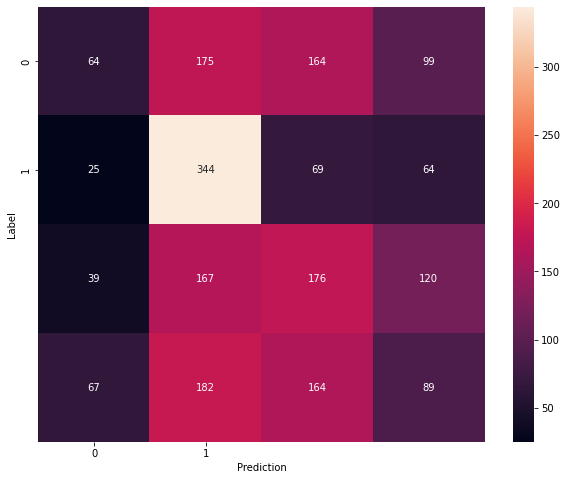

In [ ]:
#Confusion Matrix

confusion_mtx = tf.math.confusion_matrix(labels, predict_tensor) 
#print(confusion_mtx)

classes = range(0,2)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
#F1 Score
num_classes = 4
#num_classes = 3
#num_classes = 2

#Precision and recall calculus in order to calculate F1-score
res1 = 0; res2 = 0; val = 0
sum_weighted = np.zeros(num_classes)
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
for i in range(0, num_classes):
  for j in range(0, num_classes):
    if i==j:
      val = confusion_mtx[i][j]
    res1 += confusion_mtx[i][j]
    res2 += confusion_mtx[j][i]
  
  sum_weighted[i] = res2.numpy()
  precision[i] = (val/res1).numpy()
  recall[i] = (val/res2).numpy()
  
  res1 = 0; res2 = 0

#F1-score calc for each class
f1_score = np.zeros(num_classes)
for i in range(0, num_classes):
  f1_score[i] = 2*(precision[i]*recall[i]) / (precision[i]+recall[i])
  print("F1-Score for class", i, ": ", f1_score[i])

sum_macro = 0; sum_weighted_num = 0; sum_weighted_den = 0
for i in range(0, num_classes):
  sum_macro += f1_score[i]
  sum_weighted_num += (f1_score[i]*sum_weighted[i])
  sum_weighted_den += sum_weighted[i]

#Macro F1-score and weighted F1-score calc
macro_f1 = sum_macro / num_classes
weighted_f1 = sum_weighted_num / sum_weighted_den 

print("Macro-F1: ", macro_f1)
print("Weighted-F1: ", weighted_f1)

F1-Score for class 0 :  0.1836441893830703
F1-Score for class 1 :  0.5021897810218978
F1-Score for class 2 :  0.3274418604651163
F1-Score for class 3 :  0.2036613272311213
Macro-F1:  0.3042342895253014
Weighted-F1:  0.36608443557430015


## Data Comparisons between Different Disasters

In [ ]:
image_paths = []
image_paths_post = []
image_paths_pre = []

image_paths = []

count = 0
for image in os.listdir(complete_path_1_images):
  image_paths.append(complete_path_1_images + image)

for image in os.listdir(complete_path_2_images):
  image_paths.append(complete_path_2_images + image)

for image in os.listdir(complete_path_3_images):
  image_paths.append(complete_path_3_images + image)

image_paths_post, image_paths_pre = select_post_images(image_paths)

print("N. of post images:", len(image_paths_post))
print("N. of pre images:", len(image_paths_pre))

x_data_post, label_building_encoding_post, buildings_array_post, dis_A = image_segmentation(image_paths_post, 'post')
x_data_pre, label_building_encoding_pre, buildings_array_pre, dis_B = image_segmentation(image_paths_pre, 'post')

N. of post images: 10101
N. of pre images: 10101


  0%|          | 0/10101 [00:00<?, ?it/s]


Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000003_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000003_post_disaster.json


  0%|          | 1/10101 [00:01<3:28:28,  1.24s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000005_post_disaster.json


  0%|          | 2/10101 [00:02<3:23:34,  1.21s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000009_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000009_post_disaster.json


  0%|          | 3/10101 [00:03<3:20:27,  1.19s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000011_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000011_post_disaster.json


  0%|          | 4/10101 [00:04<3:21:36,  1.20s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/guatemala-volcano_00000021_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/guatemala-volcano_00000021_post_disaster.json


  0%|          | 5/10101 [00:05<3:12:25,  1.14s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000004_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000004_post_disaster.json


  0%|          | 6/10101 [00:06<3:07:58,  1.12s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000005_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000005_post_disaster.json


  0%|          | 7/10101 [00:08<3:13:50,  1.15s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000007_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000007_post_disaster.json


  0%|          | 8/10101 [00:09<3:16:09,  1.17s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000013_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000013_post_disaster.json


  0%|          | 9/10101 [00:10<3:36:47,  1.29s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000019_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000019_post_disaster.json


  0%|          | 10/10101 [00:12<3:37:55,  1.30s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000029_post_disaster.png

Label:  /content/drive/My Drive/Thesis Project/Data/test_complete/labels/hurricane-florence_00000029_post_disaster.json


  0%|          | 11/10101 [00:13<3:31:48,  1.26s/it]

Type: <class 'dict'>

Img:  /content/drive/My Drive/Thesis Project/Data/test_complete/images/hurricane-florence_00000039_post_disaster.png


  0%|          | 11/10101 [00:14<3:35:13,  1.28s/it]


KeyboardInterrupt: ignored

In [ ]:
sl = list(zip(buildings_array_post, buildings_array_pre, label_building_encoding_post))
random.shuffle(sl)
buildings_array_post, buildings_array_pre, label_building_encoding_post = zip(*sl)

x_post, y_post, dis_A = data_undersampling(x_data_post, buildings_array_post, label_building_encoding_post, dis_A)
print("\n")
x_pre, y_pre, dis_B = data_undersampling(x_data_pre, buildings_array_pre, label_building_encoding_post, dis_B)
print("\n")

print("Total number of buildings: ", len(x_post))

12000
370976
Unclassified buildings:  12756
0: No Damage, 1: Destroyed, 2: Mayor Damage, 3: Minor Damage
Quantities for each building:  275062 27337 25299 30522
Minor number:  25299
Percentage of damaged buildings:  0.2321422589470158


IndexError: ignored

In [ ]:
img_recovery = np.zeros((64,64,3))

size = (64,64)
x_post_resized = []

x_post_final = np.asarray(resize_array_img(x_post))
x_pre_final = np.asarray(resize_array_img(x_pre))

print(x_post_final.shape)

y_post_hot = to_categorical(np.asarray(y_post))
y_pre_hot = to_categorical(np.asarray(y_post))

print(y_post_hot.shape)

Corrupt image
Corrupt image
Corrupt image
Corrupt image
Corrupt image
Corrupt image
(12000, 64, 64, 3)
(12000, 4)


In [ ]:
#Images
np.save('x_post_norm_FULL.npy', x_post_final)
#np.save('x_pre_norm_FULL.npy', x_pre_final)

#Labels
#np.save('y_complete_post.npy', y_hot_post)
#np.save('x_complete_post.npy', y_hot_pre)
#np.save('x_complete_post.npy', y_hot_sub)

In [ ]:
#Stats about the difference between Pre image and Post image doing the subtraction
#Do it on the Normalized Images

#Take PRE image - POST image numpy arrays - do the PIXEL TO PIXEL subtraction - concentrate in the middle the comparisons
#---------------------|      0 8 16 24 32 40 48 56 64
#  0.5    0.5     0.5 |      8                      |
#  0.5 .........  0.5 |      16   ************      |
#  0.5 .  1.0  .  0.5 |      24   *          *      | 
#  0.5 .  1.0  .  0.5 |      32   *          *      |
#  0.5 .........  0.5 |      40   *          *      |
#  0.5    0.5     0.5 |      48   ************      |
#---------------------|      56                     |
#                            64 ....................|
#size = (64, 64)
#PRE Images Array - x_post_final
#POST Images Array - x_pre_final

def calc_mse(x_post_final, x_pre_final):
  
  mse_array1 = []
  mse_array2 = []

  for elem in range(len(x_post_final)):
    curr_mse = mse(x_post_final[elem], x_pre_final[elem])
    mse_array1.append(curr_mse)
  
  x_post_final = x_post_final/255.0
  x_pre_final = x_pre_final/255.0

  for elem in range(len(x_post_final)):
    curr_mse = mse(x_post_final[elem], x_pre_final[elem])
    mse_array2.append(curr_mse)

  return statistics.mean(mse_array1), statistics.mean(mse_array2) 

res1, res2 = calc_mse(x_post_final, x_pre_final)
print("Average of all the MSE between POST and PRE images: ", res1)
print("Average of all the MSE between POST and PRE images - Normalized: ", res2)

Average of all the MSE between POST and PRE images:  4845.070998779297
Average of all the MSE between POST and PRE images - Normalized:  0.07451089579053129


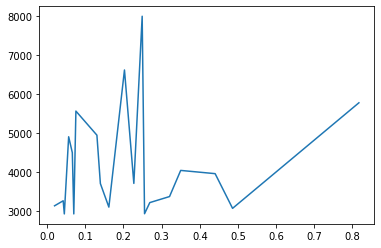

In [ ]:
#Stats Single Disasters

dam_perc = [0.01943, 0.04207, 0.04505, 0.05643, 0.06601, 0.06989, 0.0754, 0.13047, 0.13955, 0.1618, 0.2027, 0.22727, 0.2491, 0.2553, 0.26907, 0.3208, 0.35005, 0.4403, 0.4860, 0.81712]
mse_mean = [3137.705, 3266.45, 2929.67, 4908.51, 4501.22, 2929.675, 5567.07, 4949.184, 3708.15, 3104.29, 6621.13, 3712.05, 7999.41, 2934.579, 3220.07, 3374.881, 4045.330, 3962.36, 3072.74, 5779.85]

plt.plot(dam_perc, mse_mean)

#We can conclude that there are more important factors than percentage of damaged buildings

## Testing #2